In [1]:
!pip install transformers

In [2]:
!git lfs install

Git LFS initialized.


In [3]:
!git clone https://huggingface.co/bert-base-uncased

fatal: destination path 'bert-base-uncased' already exists and is not an empty directory.


In [4]:
!pip install scipy

In [5]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [13]:
import pandas as pd
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import spacy
import random

In [7]:
# pip install numpy==1.26

In [8]:
pip install scikit-learn==1.6.1

In [9]:
print(np.__version__)
print(torch.__version__)

1.26.0
2.8.0+cu126


In [10]:
dataset = pd.read_csv('resume_job_matching_dataset.csv')

In [11]:
dataset.head()

,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5


In [14]:
dataset['match_score'] = [
    random.randint(1, 20) if i==1 else random.randint(21, 40) if i == 2 else random.randint(41, 60) if i == 3 else random.randint(61, 80) if i == 4 else random.randint(81, 100) for i in dataset['match_score']
]

In [15]:
dataset.head()

,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",67
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",61
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",88
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",72
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",87


In [32]:
import re
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, pos_tag

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\+\#\.]', ' ', text)

    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words("english"))

    features = {"features": " "}

    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [word for word in words if word not in stop_words]

        tagged_words = pos_tag(words)
        filtered_words = [
            word for word, tag in tagged_words
            if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']
        ]
        features["features"] += " ".join(filtered_words)
        # features.extend(filtered_words)

    # unique_features = list(dict.fromkeys(features))


    return features



In [17]:
def get_embeddings(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().to("cpu").numpy()
    return embeddings

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [35]:
dataset["resume_features"] = dataset["resume"].apply(lambda x: preprocess_text(x))
dataset["job_features"] = dataset["job_description"].apply(lambda x: preprocess_text(x))

In [36]:
dataset.head(10)

,job_description,resume,match_score,resume_features,job_features
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",67,{'features': ' experienced professional skille...,{'features': ' data analyst needed experience ...
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",61,{'features': ' experienced professional skille...,{'features': ' data scientist needed experienc...
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",88,{'features': ' experienced professional skille...,{'features': ' software engineer needed experi...
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",72,{'features': ' experienced professional skille...,{'features': ' ml engineer needed experience p...
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",87,{'features': ' experienced professional skille...,{'features': ' software engineer needed experi...
5,"Data Analyst needed with experience in Excel, ...",Experienced professional skilled in Data Clean...,22,{'features': ' experienced professional skille...,{'features': ' data analyst needed experience ...
6,Software Engineer needed with experience in RE...,Experienced professional skilled in System Des...,38,{'features': ' experienced professional skille...,{'features': ' software engineer needed experi...
7,Product Manager needed with experience in Stak...,Experienced professional skilled in Product Ro...,48,{'features': ' experienced professional skille...,{'features': ' product manager needed experien...
8,"Data Analyst needed with experience in Excel, ...","Experienced professional skilled in as, choice...",73,{'features': ' experienced professional skille...,{'features': ' data analyst needed experience ...
9,"ML Engineer needed with experience in MLOps, P...","Experienced professional skilled in author, Co...",37,{'features': ' experienced professional skille...,{'features': ' ml engineer needed experience m...


In [38]:
print(dataset.iloc[0]["job_features"]["features"])
print(dataset.iloc[0]["resume_features"]["features"])

 data analyst needed experience sql excel power reporting data cleaning tableau .anything real big .suggest edge happen available treat somebody .
 experienced professional skilled sql power bi well try excel tableau .character truth store .better drop agent give quickly .agent system administration cold staff lawyer .


In [26]:
print(get_embeddings(dataset.iloc[0]["job_features"]["features"], model_name))

[[ 5.32625653e-02  5.76200128e-01  7.79025495e-01 -2.80671090e-01
   3.11705470e-01 -1.56809781e-02  3.48669410e-01  7.84515381e-01
  -9.61208567e-02  1.58811450e-01 -2.47978732e-01 -5.27504981e-01
  -4.44592565e-01  4.22188997e-01  3.15738946e-01  6.27287209e-01
   2.14654654e-01 -1.01863161e-01 -1.44538200e-02  1.01714797e-01
   4.03703868e-01  6.27868697e-02  1.80263937e-01  4.17663932e-01
   6.03589267e-02  3.40525359e-01 -6.28784075e-02 -2.30807349e-01
  -3.02279234e-01 -7.09337965e-02  4.46976840e-01  5.30864000e-01
  -8.37949157e-01 -2.51848638e-01 -5.29438956e-03 -1.31255522e-01
   3.23992521e-01  1.55654863e-01 -4.73938555e-01  1.46529689e-01
  -6.95589602e-01 -6.01715446e-01  3.45963895e-01  5.21064103e-01
  -4.21317518e-01 -2.19864368e-01  5.10587692e-01 -1.41174480e-01
   1.94817662e-01  2.47353166e-01 -7.45183229e-01  4.26108912e-02
  -2.46354192e-01 -6.82059348e-01 -1.84692472e-01  8.24227035e-01
  -1.51586324e-01 -6.06938720e-01 -3.90392870e-01 -3.10226262e-01
   1.15068

In [33]:
print(preprocess_text(dataset.iloc[0]['job_description']))

{'features': ' data analyst needed experience sql excel power reporting data cleaning tableau .anything real big .suggest edge happen available treat somebody .'}


In [34]:
print(preprocess_text(dataset.iloc[0]['resume']))

{'features': ' experienced professional skilled sql power bi well try excel tableau .character truth store .better drop agent give quickly .agent system administration cold staff lawyer .'}


In [41]:
pairs = []

for index in tqdm(range(len(dataset))):
  job_emb = np.array(get_embeddings(dataset.iloc[index]["job_features"]["features"], model_name))
  resume_emb = np.array(get_embeddings(dataset.iloc[index]["resume_features"]["features"], model_name))
  similarity = cosine_similarity(job_emb, resume_emb)
  print(round(similarity[0][0] * 100, 2))
  match_score = round(similarity[0][0] * 100, 2)  # Scale to 0–100%
  pairs.append((dataset.iloc[index]["job_features"]["features"], dataset.iloc[index]["resume_features"]["features"], match_score))

  0%|          | 1/10000 [00:00<40:19,  4.13it/s]

90.09


  0%|          | 2/10000 [00:00<48:34,  3.43it/s]

84.49


  0%|          | 4/10000 [00:01<41:40,  4.00it/s]

88.5
85.56


  0%|          | 5/10000 [00:01<38:32,  4.32it/s]

91.18


  0%|          | 6/10000 [00:01<40:26,  4.12it/s]

81.32


  0%|          | 8/10000 [00:01<36:15,  4.59it/s]

86.93
90.3


  0%|          | 10/10000 [00:02<28:00,  5.95it/s]

89.27
78.38


  0%|          | 12/10000 [00:02<23:57,  6.95it/s]

87.04
83.38


  0%|          | 14/10000 [00:02<21:31,  7.73it/s]

91.24
85.19


  0%|          | 16/10000 [00:02<24:41,  6.74it/s]

74.99
90.67


  0%|          | 18/10000 [00:03<21:44,  7.65it/s]

85.03
87.27


  0%|          | 20/10000 [00:03<20:42,  8.04it/s]

91.06
86.31


  0%|          | 22/10000 [00:03<19:54,  8.36it/s]

90.58
87.45


  0%|          | 24/10000 [00:03<19:54,  8.35it/s]

91.69
90.82


  0%|          | 26/10000 [00:04<20:04,  8.28it/s]

78.69
88.24


  0%|          | 28/10000 [00:04<19:38,  8.46it/s]

90.49
87.72


  0%|          | 30/10000 [00:04<19:20,  8.59it/s]

94.05
86.93


  0%|          | 32/10000 [00:04<19:20,  8.59it/s]

91.18
81.96


  0%|          | 34/10000 [00:05<19:32,  8.50it/s]

88.26
78.44


  0%|          | 36/10000 [00:05<19:29,  8.52it/s]

88.56
86.34


  0%|          | 38/10000 [00:05<19:40,  8.44it/s]

78.51
87.68


  0%|          | 40/10000 [00:05<19:11,  8.65it/s]

87.22
87.17


  0%|          | 42/10000 [00:06<19:41,  8.43it/s]

83.53
84.61


  0%|          | 44/10000 [00:06<19:21,  8.57it/s]

87.23
87.55


  0%|          | 46/10000 [00:06<19:53,  8.34it/s]

86.91
91.19


  0%|          | 48/10000 [00:06<19:18,  8.59it/s]

77.54
88.82


  0%|          | 50/10000 [00:06<18:56,  8.75it/s]

85.4
89.97


  1%|          | 52/10000 [00:07<19:16,  8.60it/s]

89.49
84.08


  1%|          | 54/10000 [00:07<19:08,  8.66it/s]

85.84
88.37


  1%|          | 56/10000 [00:07<19:04,  8.69it/s]

76.1
91.0


  1%|          | 58/10000 [00:07<19:00,  8.72it/s]

87.99
93.08


  1%|          | 60/10000 [00:08<19:21,  8.56it/s]

79.3
86.4


  1%|          | 62/10000 [00:08<19:06,  8.66it/s]

80.61
79.99


  1%|          | 64/10000 [00:08<19:30,  8.49it/s]

87.34
87.64


  1%|          | 66/10000 [00:08<19:27,  8.51it/s]

76.26
90.27


  1%|          | 68/10000 [00:09<19:13,  8.61it/s]

88.47
87.58


  1%|          | 70/10000 [00:09<19:43,  8.39it/s]

76.85
91.86


  1%|          | 72/10000 [00:09<19:27,  8.50it/s]

85.25
90.44


  1%|          | 74/10000 [00:09<19:11,  8.62it/s]

80.66
85.7


  1%|          | 76/10000 [00:09<18:59,  8.71it/s]

88.33
85.19


  1%|          | 78/10000 [00:10<20:43,  7.98it/s]

89.19
86.99


  1%|          | 80/10000 [00:10<20:01,  8.25it/s]

89.22
87.85


  1%|          | 82/10000 [00:10<20:47,  7.95it/s]

84.52
85.93


  1%|          | 84/10000 [00:11<25:48,  6.40it/s]

85.68
78.98


  1%|          | 86/10000 [00:11<27:59,  5.90it/s]

86.42
80.71


  1%|          | 88/10000 [00:11<28:04,  5.88it/s]

92.75
82.75


  1%|          | 90/10000 [00:12<28:53,  5.72it/s]

80.7
85.49


  1%|          | 92/10000 [00:12<30:44,  5.37it/s]

91.46
86.65


  1%|          | 94/10000 [00:12<29:29,  5.60it/s]

88.67
85.78


  1%|          | 96/10000 [00:13<24:17,  6.79it/s]

78.81
87.16


  1%|          | 98/10000 [00:13<22:13,  7.42it/s]

86.34
88.53


  1%|          | 100/10000 [00:13<20:34,  8.02it/s]

80.27
88.17


  1%|          | 102/10000 [00:13<19:49,  8.32it/s]

88.01
76.6


  1%|          | 104/10000 [00:14<19:17,  8.55it/s]

86.3
90.67


  1%|          | 106/10000 [00:14<19:47,  8.33it/s]

86.7
83.95


  1%|          | 108/10000 [00:14<19:30,  8.45it/s]

74.64
90.51


  1%|          | 110/10000 [00:14<18:46,  8.78it/s]

89.59
85.5


  1%|          | 112/10000 [00:15<18:35,  8.86it/s]

76.25
88.6


  1%|          | 114/10000 [00:15<18:40,  8.82it/s]

90.17
82.13


  1%|          | 116/10000 [00:15<19:19,  8.53it/s]

86.02
81.63


  1%|          | 118/10000 [00:15<18:56,  8.70it/s]

80.16
74.48


  1%|          | 120/10000 [00:15<18:52,  8.72it/s]

89.91
89.97


  1%|          | 122/10000 [00:16<19:05,  8.62it/s]

90.62
83.87


  1%|          | 124/10000 [00:16<19:44,  8.34it/s]

86.41
82.86


  1%|▏         | 126/10000 [00:16<19:34,  8.41it/s]

91.35
92.27


  1%|▏         | 128/10000 [00:16<19:26,  8.46it/s]

91.03
89.27


  1%|▏         | 130/10000 [00:17<19:24,  8.48it/s]

74.41
83.69


  1%|▏         | 132/10000 [00:17<19:45,  8.32it/s]

78.53
75.39


  1%|▏         | 134/10000 [00:17<20:23,  8.06it/s]

90.66
90.24


  1%|▏         | 136/10000 [00:17<20:09,  8.15it/s]

85.44
83.74


  1%|▏         | 138/10000 [00:18<20:08,  8.16it/s]

88.72
87.44


  1%|▏         | 140/10000 [00:18<21:07,  7.78it/s]

88.49
82.34


  1%|▏         | 142/10000 [00:18<21:09,  7.76it/s]

91.8
91.29


  1%|▏         | 144/10000 [00:18<20:14,  8.12it/s]

83.18
86.74


  1%|▏         | 146/10000 [00:19<19:46,  8.31it/s]

87.64
88.74


  1%|▏         | 148/10000 [00:19<19:44,  8.32it/s]

88.26
88.91


  2%|▏         | 150/10000 [00:19<20:11,  8.13it/s]

91.22
86.13


  2%|▏         | 152/10000 [00:19<20:03,  8.18it/s]

90.93
80.56


  2%|▏         | 154/10000 [00:20<20:18,  8.08it/s]

89.61
86.28


  2%|▏         | 156/10000 [00:20<20:12,  8.12it/s]

82.52
84.62


  2%|▏         | 158/10000 [00:20<21:50,  7.51it/s]

87.25
86.06


  2%|▏         | 160/10000 [00:20<21:14,  7.72it/s]

85.81
82.3


  2%|▏         | 162/10000 [00:21<20:43,  7.91it/s]

87.68
83.14


  2%|▏         | 164/10000 [00:21<21:06,  7.77it/s]

76.76
89.3


  2%|▏         | 166/10000 [00:21<21:44,  7.54it/s]

82.97
77.95


  2%|▏         | 168/10000 [00:21<20:58,  7.81it/s]

86.64
81.55


  2%|▏         | 170/10000 [00:22<20:33,  7.97it/s]

86.23
87.28


  2%|▏         | 172/10000 [00:22<20:20,  8.05it/s]

87.56
86.17


  2%|▏         | 174/10000 [00:22<20:50,  7.86it/s]

86.53
90.61


  2%|▏         | 176/10000 [00:22<22:43,  7.21it/s]

85.82
77.9


  2%|▏         | 178/10000 [00:23<27:12,  6.02it/s]

88.8
90.38


  2%|▏         | 180/10000 [00:23<29:25,  5.56it/s]

81.86
87.88


  2%|▏         | 182/10000 [00:24<29:54,  5.47it/s]

87.62
81.31


  2%|▏         | 184/10000 [00:24<30:54,  5.29it/s]

77.69
88.97


  2%|▏         | 185/10000 [00:24<31:03,  5.27it/s]

86.23


  2%|▏         | 187/10000 [00:25<31:50,  5.14it/s]

87.47
88.17


  2%|▏         | 189/10000 [00:25<25:38,  6.38it/s]

86.64
91.24


  2%|▏         | 191/10000 [00:25<22:59,  7.11it/s]

62.34
80.18


  2%|▏         | 193/10000 [00:25<22:32,  7.25it/s]

89.97
89.69


  2%|▏         | 195/10000 [00:26<21:23,  7.64it/s]

89.83
89.88


  2%|▏         | 197/10000 [00:26<20:36,  7.93it/s]

77.58
90.54


  2%|▏         | 199/10000 [00:26<20:25,  8.00it/s]

87.39
87.87


  2%|▏         | 201/10000 [00:26<20:46,  7.86it/s]

88.58
84.79


  2%|▏         | 203/10000 [00:27<20:22,  8.01it/s]

89.13
90.67


  2%|▏         | 205/10000 [00:27<20:54,  7.81it/s]

90.31
86.73


  2%|▏         | 207/10000 [00:27<20:55,  7.80it/s]

89.86
86.29


  2%|▏         | 209/10000 [00:27<21:20,  7.65it/s]

80.64
90.67


  2%|▏         | 211/10000 [00:28<20:50,  7.83it/s]

77.22
85.1


  2%|▏         | 213/10000 [00:28<20:22,  8.01it/s]

85.29
78.79


  2%|▏         | 215/10000 [00:28<19:58,  8.16it/s]

84.9
88.05


  2%|▏         | 217/10000 [00:28<20:02,  8.13it/s]

92.71
90.04


  2%|▏         | 219/10000 [00:29<19:49,  8.23it/s]

85.81
86.79


  2%|▏         | 221/10000 [00:29<20:41,  7.87it/s]

89.87
77.74


  2%|▏         | 223/10000 [00:29<20:09,  8.08it/s]

85.84
81.96


  2%|▏         | 225/10000 [00:29<19:55,  8.17it/s]

83.16
92.71


  2%|▏         | 227/10000 [00:30<20:07,  8.09it/s]

89.07
91.37


  2%|▏         | 229/10000 [00:30<19:58,  8.15it/s]

78.64
82.23


  2%|▏         | 231/10000 [00:30<19:57,  8.16it/s]

82.1
73.24


  2%|▏         | 233/10000 [00:30<19:56,  8.16it/s]

87.58
85.06


  2%|▏         | 235/10000 [00:31<20:49,  7.81it/s]

89.18
85.59


  2%|▏         | 237/10000 [00:31<20:17,  8.02it/s]

69.05
83.07


  2%|▏         | 239/10000 [00:31<20:11,  8.06it/s]

88.05
82.13


  2%|▏         | 241/10000 [00:31<21:55,  7.42it/s]

91.02
86.84


  2%|▏         | 243/10000 [00:32<21:18,  7.63it/s]

91.4
67.98


  2%|▏         | 245/10000 [00:32<20:29,  7.93it/s]

89.27
87.6


  2%|▏         | 247/10000 [00:32<20:36,  7.89it/s]

92.53
68.53


  2%|▏         | 249/10000 [00:32<19:42,  8.25it/s]

93.02
90.25


  3%|▎         | 251/10000 [00:33<20:08,  8.07it/s]

85.96
84.32


  3%|▎         | 253/10000 [00:33<20:15,  8.02it/s]

81.37
86.96


  3%|▎         | 255/10000 [00:33<20:16,  8.01it/s]

87.77
84.99


  3%|▎         | 257/10000 [00:33<19:50,  8.18it/s]

77.05
65.97


  3%|▎         | 259/10000 [00:34<20:01,  8.11it/s]

91.73
84.82


  3%|▎         | 261/10000 [00:34<20:04,  8.09it/s]

80.71
82.73


  3%|▎         | 263/10000 [00:34<19:58,  8.12it/s]

82.31
82.88


  3%|▎         | 265/10000 [00:34<20:08,  8.05it/s]

87.63
88.33


  3%|▎         | 267/10000 [00:35<21:41,  7.48it/s]

79.36
88.66


  3%|▎         | 269/10000 [00:35<27:02,  6.00it/s]

85.87
78.88


  3%|▎         | 271/10000 [00:35<28:58,  5.59it/s]

78.48
86.87


  3%|▎         | 273/10000 [00:36<29:37,  5.47it/s]

80.46
86.92


  3%|▎         | 274/10000 [00:36<29:40,  5.46it/s]

87.45
85.03


  3%|▎         | 277/10000 [00:37<31:02,  5.22it/s]

92.61
76.74


  3%|▎         | 279/10000 [00:37<28:13,  5.74it/s]

88.99
90.14


  3%|▎         | 281/10000 [00:37<23:53,  6.78it/s]

88.3
81.88


  3%|▎         | 283/10000 [00:37<21:59,  7.36it/s]

83.47
88.46


  3%|▎         | 285/10000 [00:38<20:45,  7.80it/s]

81.84
91.71


  3%|▎         | 287/10000 [00:38<21:23,  7.57it/s]

87.09
88.69


  3%|▎         | 289/10000 [00:38<20:31,  7.88it/s]

81.38
78.53


  3%|▎         | 291/10000 [00:38<20:22,  7.94it/s]

77.99
81.49


  3%|▎         | 293/10000 [00:39<20:28,  7.90it/s]

87.68
92.05


  3%|▎         | 295/10000 [00:39<20:51,  7.76it/s]

83.77
87.7


  3%|▎         | 297/10000 [00:39<20:13,  8.00it/s]

86.34
83.13


  3%|▎         | 299/10000 [00:39<19:55,  8.12it/s]

90.37
84.06


  3%|▎         | 301/10000 [00:40<19:55,  8.11it/s]

90.73
83.45


  3%|▎         | 303/10000 [00:40<20:40,  7.82it/s]

83.4
88.71


  3%|▎         | 305/10000 [00:40<19:58,  8.09it/s]

89.89
82.88


  3%|▎         | 307/10000 [00:40<19:50,  8.14it/s]

80.92
91.83


  3%|▎         | 309/10000 [00:41<19:41,  8.20it/s]

89.54
87.46


  3%|▎         | 311/10000 [00:41<20:33,  7.85it/s]

71.94
78.89


  3%|▎         | 313/10000 [00:41<20:30,  7.87it/s]

79.17
84.42


  3%|▎         | 315/10000 [00:41<19:51,  8.13it/s]

87.0
91.4


  3%|▎         | 317/10000 [00:42<19:31,  8.27it/s]

86.33
87.09


  3%|▎         | 319/10000 [00:42<19:17,  8.36it/s]

82.41
80.43


  3%|▎         | 321/10000 [00:42<20:14,  7.97it/s]

87.63
90.15


  3%|▎         | 323/10000 [00:42<20:21,  7.92it/s]

75.68
81.03


  3%|▎         | 325/10000 [00:43<19:53,  8.11it/s]

92.02
89.36


  3%|▎         | 327/10000 [00:43<20:19,  7.93it/s]

90.99
82.88


  3%|▎         | 329/10000 [00:43<20:36,  7.82it/s]

81.52
87.22


  3%|▎         | 331/10000 [00:43<20:32,  7.85it/s]

88.86
83.92


  3%|▎         | 333/10000 [00:44<20:20,  7.92it/s]

90.4
89.52


  3%|▎         | 335/10000 [00:44<19:47,  8.14it/s]

80.43
88.28


  3%|▎         | 337/10000 [00:44<20:04,  8.02it/s]

85.53
89.74


  3%|▎         | 339/10000 [00:44<19:34,  8.22it/s]

88.19
88.05


  3%|▎         | 341/10000 [00:45<19:37,  8.21it/s]

86.65
89.29


  3%|▎         | 343/10000 [00:45<19:46,  8.14it/s]

78.42
86.4


  3%|▎         | 345/10000 [00:45<20:33,  7.82it/s]

82.41
82.73


  3%|▎         | 347/10000 [00:45<20:20,  7.91it/s]

87.49
84.39


  3%|▎         | 349/10000 [00:46<20:06,  8.00it/s]

89.44
88.14


  4%|▎         | 351/10000 [00:46<20:31,  7.84it/s]

89.31
82.57


  4%|▎         | 353/10000 [00:46<20:47,  7.73it/s]

87.8
86.39


  4%|▎         | 355/10000 [00:46<20:19,  7.91it/s]

86.97
88.34


  4%|▎         | 357/10000 [00:47<19:56,  8.06it/s]

85.48
91.97


  4%|▎         | 359/10000 [00:47<23:37,  6.80it/s]

80.15
85.16


  4%|▎         | 361/10000 [00:47<27:55,  5.75it/s]

90.15
87.21


  4%|▎         | 363/10000 [00:48<28:47,  5.58it/s]

66.8
89.67


  4%|▎         | 365/10000 [00:48<29:46,  5.39it/s]

82.79
81.97


  4%|▎         | 367/10000 [00:49<30:08,  5.33it/s]

84.06
91.76


  4%|▎         | 368/10000 [00:49<30:58,  5.18it/s]

84.0


  4%|▎         | 370/10000 [00:49<29:27,  5.45it/s]

90.67
79.16


  4%|▎         | 372/10000 [00:49<25:13,  6.36it/s]

88.61
88.5


  4%|▎         | 374/10000 [00:50<22:24,  7.16it/s]

76.34
83.93


  4%|▍         | 376/10000 [00:50<20:55,  7.66it/s]

87.31
89.42


  4%|▍         | 378/10000 [00:50<20:25,  7.85it/s]

80.19
88.4


  4%|▍         | 380/10000 [00:50<20:21,  7.87it/s]

86.08
85.68


  4%|▍         | 382/10000 [00:51<19:47,  8.10it/s]

88.94
80.21


  4%|▍         | 384/10000 [00:51<19:33,  8.20it/s]

80.65
78.8


  4%|▍         | 386/10000 [00:51<19:40,  8.14it/s]

86.29
87.95


  4%|▍         | 388/10000 [00:51<19:54,  8.04it/s]

84.21
87.72


  4%|▍         | 390/10000 [00:52<19:53,  8.05it/s]

76.66
88.67


  4%|▍         | 392/10000 [00:52<19:34,  8.18it/s]

78.56
85.97


  4%|▍         | 394/10000 [00:52<19:35,  8.17it/s]

84.08
88.88


  4%|▍         | 396/10000 [00:52<19:02,  8.41it/s]

91.42
88.05


  4%|▍         | 398/10000 [00:53<20:16,  7.89it/s]

87.53
82.05


  4%|▍         | 400/10000 [00:53<20:39,  7.75it/s]

88.16
80.01


  4%|▍         | 402/10000 [00:53<21:03,  7.60it/s]

88.71
79.37


  4%|▍         | 404/10000 [00:53<21:37,  7.40it/s]

86.82
80.81


  4%|▍         | 406/10000 [00:54<20:16,  7.89it/s]

92.87
69.75


  4%|▍         | 408/10000 [00:54<21:20,  7.49it/s]

89.12
71.97


  4%|▍         | 410/10000 [00:54<22:04,  7.24it/s]

84.52
90.1


  4%|▍         | 412/10000 [00:54<22:47,  7.01it/s]

87.89
82.43


  4%|▍         | 414/10000 [00:55<22:13,  7.19it/s]

87.24
84.97


  4%|▍         | 416/10000 [00:55<21:42,  7.36it/s]

89.49
80.8


  4%|▍         | 418/10000 [00:55<21:29,  7.43it/s]

89.07
88.1


  4%|▍         | 420/10000 [00:56<21:14,  7.51it/s]

88.02
85.83


  4%|▍         | 422/10000 [00:56<19:55,  8.01it/s]

89.87
85.14


  4%|▍         | 424/10000 [00:56<19:08,  8.34it/s]

75.16
93.44


  4%|▍         | 426/10000 [00:56<18:30,  8.62it/s]

80.91
85.78


  4%|▍         | 428/10000 [00:56<19:16,  8.28it/s]

89.45
89.14


  4%|▍         | 430/10000 [00:57<18:53,  8.44it/s]

91.06
70.59


  4%|▍         | 432/10000 [00:57<18:48,  8.48it/s]

88.6
90.26


  4%|▍         | 434/10000 [00:57<18:43,  8.52it/s]

85.46
81.83


  4%|▍         | 436/10000 [00:57<18:29,  8.62it/s]

88.4
90.43


  4%|▍         | 438/10000 [00:58<20:20,  7.84it/s]

82.94
88.1


  4%|▍         | 440/10000 [00:58<21:25,  7.44it/s]

84.85
88.88


  4%|▍         | 442/10000 [00:58<21:48,  7.30it/s]

89.32
87.19


  4%|▍         | 444/10000 [00:59<22:23,  7.11it/s]

92.58
91.3


  4%|▍         | 446/10000 [00:59<21:44,  7.32it/s]

94.42
83.09


  4%|▍         | 448/10000 [00:59<24:30,  6.50it/s]

87.19
78.34


  4%|▍         | 450/10000 [01:00<27:47,  5.73it/s]

82.44
84.75


  5%|▍         | 452/10000 [01:00<28:29,  5.59it/s]

82.07
90.77


  5%|▍         | 454/10000 [01:00<27:49,  5.72it/s]

89.94
91.79


  5%|▍         | 456/10000 [01:01<27:56,  5.69it/s]

85.78
77.65


  5%|▍         | 458/10000 [01:01<29:06,  5.46it/s]

90.87
87.04


  5%|▍         | 460/10000 [01:01<26:38,  5.97it/s]

85.01
83.15


  5%|▍         | 462/10000 [01:02<22:21,  7.11it/s]

89.75
85.42


  5%|▍         | 464/10000 [01:02<22:22,  7.10it/s]

87.85
82.12


  5%|▍         | 466/10000 [01:02<21:48,  7.28it/s]

89.89
86.58


  5%|▍         | 468/10000 [01:02<20:18,  7.82it/s]

90.2
86.27


  5%|▍         | 470/10000 [01:03<21:15,  7.47it/s]

85.4
86.88


  5%|▍         | 472/10000 [01:03<21:07,  7.52it/s]

90.87
84.83


  5%|▍         | 474/10000 [01:03<20:25,  7.77it/s]

77.38
83.78


  5%|▍         | 476/10000 [01:03<19:49,  8.01it/s]

85.87
89.87


  5%|▍         | 478/10000 [01:04<19:48,  8.01it/s]

61.99
89.59


  5%|▍         | 480/10000 [01:04<19:43,  8.05it/s]

81.43
88.97


  5%|▍         | 482/10000 [01:04<19:26,  8.16it/s]

89.72
84.42


  5%|▍         | 484/10000 [01:04<18:51,  8.41it/s]

83.99
86.18


  5%|▍         | 486/10000 [01:05<19:03,  8.32it/s]

89.93
82.97


  5%|▍         | 488/10000 [01:05<19:09,  8.27it/s]

79.82
87.73


  5%|▍         | 490/10000 [01:05<20:06,  7.88it/s]

86.36
82.89


  5%|▍         | 492/10000 [01:05<20:07,  7.88it/s]

89.6
89.05


  5%|▍         | 494/10000 [01:06<20:05,  7.89it/s]

85.77
76.37


  5%|▍         | 496/10000 [01:06<19:50,  7.98it/s]

80.01
82.79


  5%|▍         | 498/10000 [01:06<20:24,  7.76it/s]

90.7
92.09


  5%|▌         | 500/10000 [01:06<19:25,  8.15it/s]

88.05
85.77


  5%|▌         | 502/10000 [01:07<18:57,  8.35it/s]

88.03
76.94


  5%|▌         | 504/10000 [01:07<18:41,  8.47it/s]

78.02
87.69


  5%|▌         | 506/10000 [01:07<19:12,  8.24it/s]

87.53
89.04


  5%|▌         | 508/10000 [01:07<18:54,  8.37it/s]

87.92
78.99


  5%|▌         | 510/10000 [01:08<18:40,  8.47it/s]

87.74
80.23


  5%|▌         | 512/10000 [01:08<18:41,  8.46it/s]

89.35
71.35


  5%|▌         | 514/10000 [01:08<19:23,  8.15it/s]

90.47
83.88


  5%|▌         | 516/10000 [01:08<19:19,  8.18it/s]

89.13
84.02


  5%|▌         | 518/10000 [01:08<19:20,  8.17it/s]

84.98
80.34


  5%|▌         | 520/10000 [01:09<19:38,  8.05it/s]

80.36
91.4


  5%|▌         | 522/10000 [01:09<20:06,  7.86it/s]

83.83
78.09


  5%|▌         | 524/10000 [01:09<19:36,  8.06it/s]

90.2
85.36


  5%|▌         | 526/10000 [01:09<19:12,  8.22it/s]

82.72
82.84


  5%|▌         | 528/10000 [01:10<18:58,  8.32it/s]

93.01
80.54


  5%|▌         | 530/10000 [01:10<18:52,  8.36it/s]

80.51
90.6


  5%|▌         | 532/10000 [01:10<19:12,  8.22it/s]

90.85
88.54


  5%|▌         | 534/10000 [01:10<18:42,  8.43it/s]

91.86
88.01


  5%|▌         | 536/10000 [01:11<18:34,  8.50it/s]

75.87
87.46


  5%|▌         | 538/10000 [01:11<18:39,  8.45it/s]

89.66
89.69


  5%|▌         | 540/10000 [01:11<19:54,  7.92it/s]

87.82
88.13


  5%|▌         | 542/10000 [01:12<25:12,  6.25it/s]

79.89
91.15


  5%|▌         | 544/10000 [01:12<26:32,  5.94it/s]

88.6
88.63


  5%|▌         | 546/10000 [01:12<27:32,  5.72it/s]

79.46
88.99


  5%|▌         | 548/10000 [01:13<27:50,  5.66it/s]

89.62
85.69


  6%|▌         | 550/10000 [01:13<28:57,  5.44it/s]

75.46
86.19


  6%|▌         | 552/10000 [01:13<30:11,  5.21it/s]

88.63
89.93


  6%|▌         | 554/10000 [01:14<24:01,  6.55it/s]

78.94
78.87


  6%|▌         | 556/10000 [01:14<21:43,  7.25it/s]

83.09
88.27


  6%|▌         | 558/10000 [01:14<20:24,  7.71it/s]

91.8
87.6


  6%|▌         | 560/10000 [01:14<20:08,  7.81it/s]

88.24
89.84


  6%|▌         | 562/10000 [01:15<19:56,  7.89it/s]

89.78
87.29


  6%|▌         | 564/10000 [01:15<19:06,  8.23it/s]

85.88
90.92


  6%|▌         | 566/10000 [01:15<19:01,  8.26it/s]

88.14
84.14


  6%|▌         | 568/10000 [01:15<19:39,  8.00it/s]

86.56
84.25


  6%|▌         | 570/10000 [01:16<19:31,  8.05it/s]

84.47
85.21


  6%|▌         | 572/10000 [01:16<19:08,  8.21it/s]

92.39
84.13


  6%|▌         | 574/10000 [01:16<19:03,  8.24it/s]

91.3
82.08


  6%|▌         | 576/10000 [01:16<19:35,  8.02it/s]

85.24
82.19


  6%|▌         | 578/10000 [01:17<19:32,  8.04it/s]

86.51
89.77


  6%|▌         | 580/10000 [01:17<18:51,  8.32it/s]

89.83
90.86


  6%|▌         | 582/10000 [01:17<19:01,  8.25it/s]

88.17
84.8


  6%|▌         | 584/10000 [01:17<20:10,  7.78it/s]

89.8
77.73


  6%|▌         | 586/10000 [01:18<19:16,  8.14it/s]

87.09
81.23


  6%|▌         | 588/10000 [01:18<18:58,  8.27it/s]

83.67
89.94


  6%|▌         | 590/10000 [01:18<18:59,  8.26it/s]

85.6
88.25


  6%|▌         | 592/10000 [01:18<19:47,  7.92it/s]

91.1
88.23


  6%|▌         | 594/10000 [01:19<19:04,  8.22it/s]

90.13
86.32


  6%|▌         | 596/10000 [01:19<18:40,  8.39it/s]

91.09
89.04


  6%|▌         | 598/10000 [01:19<18:43,  8.37it/s]

86.91
86.04


  6%|▌         | 600/10000 [01:19<18:45,  8.35it/s]

86.47
76.01


  6%|▌         | 602/10000 [01:20<19:21,  8.09it/s]

82.2
87.32


  6%|▌         | 604/10000 [01:20<18:53,  8.29it/s]

79.99
79.84


  6%|▌         | 606/10000 [01:20<19:06,  8.19it/s]

89.62
81.01


  6%|▌         | 608/10000 [01:20<18:53,  8.28it/s]

87.5
82.88


  6%|▌         | 610/10000 [01:21<19:11,  8.15it/s]

86.71
72.32


  6%|▌         | 612/10000 [01:21<18:47,  8.33it/s]

78.8
87.03


  6%|▌         | 614/10000 [01:21<18:42,  8.36it/s]

91.14
72.4


  6%|▌         | 616/10000 [01:21<18:48,  8.31it/s]

89.7
84.78


  6%|▌         | 618/10000 [01:22<19:05,  8.19it/s]

86.81
76.54


  6%|▌         | 620/10000 [01:22<18:38,  8.39it/s]

90.02
89.14


  6%|▌         | 622/10000 [01:22<18:24,  8.49it/s]

91.85
89.03


  6%|▌         | 624/10000 [01:22<18:29,  8.45it/s]

86.19
72.44


  6%|▋         | 626/10000 [01:22<18:49,  8.30it/s]

72.64
65.7


  6%|▋         | 628/10000 [01:23<18:34,  8.41it/s]

85.98
78.64


  6%|▋         | 630/10000 [01:23<18:26,  8.47it/s]

88.39
84.79


  6%|▋         | 632/10000 [01:23<18:34,  8.40it/s]

83.44
91.54


  6%|▋         | 634/10000 [01:23<18:45,  8.33it/s]

89.9
87.19


  6%|▋         | 636/10000 [01:24<23:59,  6.51it/s]

88.42
83.56


  6%|▋         | 638/10000 [01:24<27:02,  5.77it/s]

82.38
83.16


  6%|▋         | 640/10000 [01:25<27:50,  5.60it/s]

81.69
87.52


  6%|▋         | 642/10000 [01:25<27:46,  5.61it/s]

88.72
90.89


  6%|▋         | 644/10000 [01:25<28:36,  5.45it/s]

92.56
86.32


  6%|▋         | 646/10000 [01:26<29:34,  5.27it/s]

87.63
86.07


  6%|▋         | 648/10000 [01:26<24:40,  6.32it/s]

91.18
76.23


  6%|▋         | 650/10000 [01:26<21:31,  7.24it/s]

84.74
78.93


  7%|▋         | 652/10000 [01:26<19:50,  7.85it/s]

81.82
85.34


  7%|▋         | 654/10000 [01:27<19:15,  8.09it/s]

76.07
85.54


  7%|▋         | 656/10000 [01:27<19:53,  7.83it/s]

88.74
82.77


  7%|▋         | 658/10000 [01:27<19:33,  7.96it/s]

74.42
89.43


  7%|▋         | 660/10000 [01:27<19:07,  8.14it/s]

85.29
84.07


  7%|▋         | 662/10000 [01:28<19:00,  8.19it/s]

88.22
80.92


  7%|▋         | 664/10000 [01:28<20:07,  7.73it/s]

88.75
85.17


  7%|▋         | 666/10000 [01:28<19:25,  8.01it/s]

86.95
88.51


  7%|▋         | 668/10000 [01:28<18:43,  8.30it/s]

85.58
82.44


  7%|▋         | 670/10000 [01:29<18:05,  8.60it/s]

76.85
76.69


  7%|▋         | 672/10000 [01:29<18:54,  8.22it/s]

91.28
83.98


  7%|▋         | 674/10000 [01:29<18:32,  8.39it/s]

70.01
86.75


  7%|▋         | 676/10000 [01:29<18:17,  8.50it/s]

89.01
77.78


  7%|▋         | 678/10000 [01:30<18:09,  8.55it/s]

82.97
88.06


  7%|▋         | 680/10000 [01:30<18:51,  8.24it/s]

82.84
92.6


  7%|▋         | 682/10000 [01:30<18:43,  8.30it/s]

79.72
85.87


  7%|▋         | 684/10000 [01:30<18:28,  8.41it/s]

63.47
86.29


  7%|▋         | 686/10000 [01:31<18:18,  8.48it/s]

82.73
84.27


  7%|▋         | 688/10000 [01:31<18:12,  8.52it/s]

86.76
78.33


  7%|▋         | 690/10000 [01:31<18:47,  8.25it/s]

86.9
87.96


  7%|▋         | 692/10000 [01:31<18:43,  8.29it/s]

87.11
84.95


  7%|▋         | 694/10000 [01:31<18:52,  8.22it/s]

81.93
89.97


  7%|▋         | 696/10000 [01:32<18:25,  8.42it/s]

89.93
86.35


  7%|▋         | 698/10000 [01:32<18:58,  8.17it/s]

92.22
80.98


  7%|▋         | 700/10000 [01:32<19:01,  8.15it/s]

88.05
90.55


  7%|▋         | 702/10000 [01:32<18:28,  8.39it/s]

81.84
89.44


  7%|▋         | 704/10000 [01:33<18:19,  8.45it/s]

86.13
90.57


  7%|▋         | 706/10000 [01:33<20:54,  7.41it/s]

91.74
76.39


  7%|▋         | 708/10000 [01:33<19:18,  8.02it/s]

84.35
85.38


  7%|▋         | 710/10000 [01:33<18:24,  8.41it/s]

79.08
92.04


  7%|▋         | 712/10000 [01:34<17:54,  8.65it/s]

77.12
87.21


  7%|▋         | 714/10000 [01:34<18:07,  8.54it/s]

87.88
64.35


  7%|▋         | 716/10000 [01:34<18:44,  8.26it/s]

83.0
88.93


  7%|▋         | 718/10000 [01:34<18:42,  8.27it/s]

88.73
91.56


  7%|▋         | 720/10000 [01:35<18:11,  8.50it/s]

85.51
85.51


  7%|▋         | 722/10000 [01:35<18:26,  8.38it/s]

86.71
87.01


  7%|▋         | 724/10000 [01:35<18:37,  8.30it/s]

85.24
85.99


  7%|▋         | 726/10000 [01:35<18:24,  8.40it/s]

91.47
81.32


  7%|▋         | 728/10000 [01:36<18:14,  8.47it/s]

78.51
91.95


  7%|▋         | 730/10000 [01:36<21:48,  7.08it/s]

82.42
91.06


  7%|▋         | 732/10000 [01:36<25:57,  5.95it/s]

88.0
80.16


  7%|▋         | 734/10000 [01:37<26:49,  5.76it/s]

88.68
90.54


  7%|▋         | 736/10000 [01:37<26:46,  5.77it/s]

75.67
73.94


  7%|▋         | 738/10000 [01:37<28:12,  5.47it/s]

88.52
83.88


  7%|▋         | 739/10000 [01:38<28:24,  5.43it/s]

90.57


  7%|▋         | 741/10000 [01:38<28:49,  5.35it/s]

92.77
89.82


  7%|▋         | 743/10000 [01:38<24:54,  6.19it/s]

68.17
80.72


  7%|▋         | 745/10000 [01:38<21:44,  7.09it/s]

80.25
84.98


  7%|▋         | 747/10000 [01:39<20:17,  7.60it/s]

78.51
93.15


  7%|▋         | 749/10000 [01:39<19:47,  7.79it/s]

92.57
91.22


  8%|▊         | 751/10000 [01:39<20:14,  7.61it/s]

92.61
85.11


  8%|▊         | 753/10000 [01:40<20:00,  7.70it/s]

82.66
92.25


  8%|▊         | 755/10000 [01:40<19:07,  8.06it/s]

84.01
79.76


  8%|▊         | 757/10000 [01:40<18:40,  8.25it/s]

92.85
74.71


  8%|▊         | 759/10000 [01:40<19:28,  7.91it/s]

85.88
86.87


  8%|▊         | 761/10000 [01:40<18:57,  8.12it/s]

81.04
82.63


  8%|▊         | 763/10000 [01:41<18:42,  8.23it/s]

85.84
90.15


  8%|▊         | 765/10000 [01:41<18:30,  8.31it/s]

75.21
85.73


  8%|▊         | 767/10000 [01:41<18:29,  8.32it/s]

82.47
80.82


  8%|▊         | 769/10000 [01:41<18:46,  8.19it/s]

86.81
76.29


  8%|▊         | 771/10000 [01:42<18:21,  8.38it/s]

87.94
77.48


  8%|▊         | 773/10000 [01:42<18:16,  8.41it/s]

85.91
88.04


  8%|▊         | 775/10000 [01:42<18:35,  8.27it/s]

88.49
82.21


  8%|▊         | 777/10000 [01:42<18:52,  8.14it/s]

90.83
81.79


  8%|▊         | 779/10000 [01:43<18:38,  8.25it/s]

85.41
75.52


  8%|▊         | 781/10000 [01:43<18:24,  8.35it/s]

84.26
77.0


  8%|▊         | 783/10000 [01:43<18:21,  8.36it/s]

87.14
88.67


  8%|▊         | 785/10000 [01:43<18:59,  8.09it/s]

82.34
77.66


  8%|▊         | 787/10000 [01:44<18:48,  8.17it/s]

92.51
85.75


  8%|▊         | 789/10000 [01:44<18:11,  8.44it/s]

82.58
92.35


  8%|▊         | 791/10000 [01:44<18:09,  8.46it/s]

86.55
87.47


  8%|▊         | 793/10000 [01:44<18:41,  8.21it/s]

88.29
84.54


  8%|▊         | 795/10000 [01:45<18:20,  8.37it/s]

78.47
83.11


  8%|▊         | 797/10000 [01:45<18:03,  8.50it/s]

90.16
87.82


  8%|▊         | 799/10000 [01:45<18:03,  8.49it/s]

91.72
81.78


  8%|▊         | 801/10000 [01:45<18:18,  8.37it/s]

92.59
83.76


  8%|▊         | 803/10000 [01:46<18:33,  8.26it/s]

87.29
78.6


  8%|▊         | 805/10000 [01:46<18:12,  8.42it/s]

92.46
76.47


  8%|▊         | 807/10000 [01:46<18:11,  8.42it/s]

83.54
90.49


  8%|▊         | 809/10000 [01:46<18:13,  8.41it/s]

86.28
83.44


  8%|▊         | 811/10000 [01:46<18:45,  8.17it/s]

84.45
91.26


  8%|▊         | 813/10000 [01:47<18:07,  8.45it/s]

87.27
68.22


  8%|▊         | 815/10000 [01:47<18:10,  8.42it/s]

90.78
81.7


  8%|▊         | 817/10000 [01:47<18:50,  8.13it/s]

85.4
84.12


  8%|▊         | 819/10000 [01:47<19:01,  8.04it/s]

85.54
85.63


  8%|▊         | 821/10000 [01:48<18:20,  8.34it/s]

87.02
90.79


  8%|▊         | 823/10000 [01:48<19:16,  7.93it/s]

87.85
88.96


  8%|▊         | 825/10000 [01:48<23:37,  6.47it/s]

83.63
90.87


  8%|▊         | 827/10000 [01:49<26:59,  5.66it/s]

93.76
87.7


  8%|▊         | 829/10000 [01:49<28:00,  5.46it/s]

81.88
87.79


  8%|▊         | 831/10000 [01:49<28:00,  5.46it/s]

90.31
93.06


  8%|▊         | 833/10000 [01:50<29:27,  5.19it/s]

72.66
80.33


  8%|▊         | 835/10000 [01:50<28:09,  5.42it/s]

91.0
90.02


  8%|▊         | 837/10000 [01:50<22:44,  6.71it/s]

92.42
87.51


  8%|▊         | 839/10000 [01:51<21:04,  7.25it/s]

86.19
64.62


  8%|▊         | 841/10000 [01:51<19:53,  7.67it/s]

90.4
81.29


  8%|▊         | 843/10000 [01:51<19:24,  7.86it/s]

87.28
72.98


  8%|▊         | 845/10000 [01:51<18:52,  8.09it/s]

83.47
84.85


  8%|▊         | 847/10000 [01:52<19:03,  8.00it/s]

72.36
88.32


  8%|▊         | 849/10000 [01:52<18:29,  8.25it/s]

72.7
89.07


  9%|▊         | 851/10000 [01:52<18:13,  8.36it/s]

84.77
89.35


  9%|▊         | 853/10000 [01:52<18:27,  8.26it/s]

90.59
85.96


  9%|▊         | 855/10000 [01:53<18:49,  8.10it/s]

91.08
90.92


  9%|▊         | 857/10000 [01:53<18:25,  8.27it/s]

86.26
86.32


  9%|▊         | 859/10000 [01:53<18:23,  8.28it/s]

85.93
85.64


  9%|▊         | 861/10000 [01:53<18:33,  8.20it/s]

80.13
79.82


  9%|▊         | 863/10000 [01:54<18:26,  8.25it/s]

83.37
87.57


  9%|▊         | 865/10000 [01:54<18:42,  8.14it/s]

83.0
87.5


  9%|▊         | 867/10000 [01:54<18:15,  8.34it/s]

90.61
80.29


  9%|▊         | 869/10000 [01:54<18:02,  8.43it/s]

85.47
83.44


  9%|▊         | 871/10000 [01:55<17:54,  8.50it/s]

88.37
84.25


  9%|▊         | 873/10000 [01:55<18:28,  8.23it/s]

88.9
70.74


  9%|▉         | 875/10000 [01:55<18:06,  8.40it/s]

91.24
82.15


  9%|▉         | 877/10000 [01:55<18:04,  8.41it/s]

85.49
88.28


  9%|▉         | 879/10000 [01:56<18:02,  8.42it/s]

85.98
84.23


  9%|▉         | 881/10000 [01:56<18:33,  8.19it/s]

86.37
86.76


  9%|▉         | 883/10000 [01:56<18:08,  8.37it/s]

77.93
79.34


  9%|▉         | 885/10000 [01:56<18:12,  8.35it/s]

88.09
85.75


  9%|▉         | 887/10000 [01:57<18:29,  8.22it/s]

83.32
91.64


  9%|▉         | 889/10000 [01:57<18:27,  8.23it/s]

84.08
88.63


  9%|▉         | 891/10000 [01:57<19:30,  7.78it/s]

92.11
88.63


  9%|▉         | 893/10000 [01:57<19:44,  7.69it/s]

86.6
81.17


  9%|▉         | 895/10000 [01:58<19:03,  7.96it/s]

91.75
86.78


  9%|▉         | 897/10000 [01:58<18:38,  8.14it/s]

78.93
89.12


  9%|▉         | 899/10000 [01:58<19:18,  7.85it/s]

88.04
89.44


  9%|▉         | 901/10000 [01:58<18:58,  7.99it/s]

87.99
83.55


  9%|▉         | 903/10000 [01:59<18:29,  8.20it/s]

89.77
88.8


  9%|▉         | 905/10000 [01:59<18:22,  8.25it/s]

78.24
88.41


  9%|▉         | 907/10000 [01:59<19:05,  7.94it/s]

88.21
80.44


  9%|▉         | 909/10000 [01:59<18:34,  8.16it/s]

84.62
90.23


  9%|▉         | 911/10000 [02:00<18:27,  8.20it/s]

84.04
87.33


  9%|▉         | 913/10000 [02:00<18:31,  8.17it/s]

72.65
89.32


  9%|▉         | 915/10000 [02:00<18:55,  8.00it/s]

74.37
75.11


  9%|▉         | 917/10000 [02:00<21:49,  6.94it/s]

83.91
83.94


  9%|▉         | 919/10000 [02:01<24:17,  6.23it/s]

88.16
78.67


  9%|▉         | 921/10000 [02:01<25:20,  5.97it/s]

77.08
88.52


  9%|▉         | 923/10000 [02:01<25:57,  5.83it/s]

86.64
83.96


  9%|▉         | 925/10000 [02:02<26:23,  5.73it/s]

89.75
90.55


  9%|▉         | 927/10000 [02:02<27:54,  5.42it/s]

90.49
87.91


  9%|▉         | 929/10000 [02:03<28:45,  5.26it/s]

79.01
89.35


  9%|▉         | 931/10000 [02:03<23:06,  6.54it/s]

79.22
75.39


  9%|▉         | 933/10000 [02:03<20:26,  7.39it/s]

83.61
88.54


  9%|▉         | 935/10000 [02:03<21:19,  7.09it/s]

78.16
83.37


  9%|▉         | 937/10000 [02:04<20:18,  7.44it/s]

84.57
81.23


  9%|▉         | 939/10000 [02:04<19:29,  7.75it/s]

85.17
85.83


  9%|▉         | 941/10000 [02:04<18:35,  8.12it/s]

77.76
74.75


  9%|▉         | 943/10000 [02:04<18:30,  8.16it/s]

85.12
88.4


  9%|▉         | 945/10000 [02:05<17:58,  8.40it/s]

87.65
87.65


  9%|▉         | 947/10000 [02:05<17:52,  8.44it/s]

87.51
87.15


  9%|▉         | 949/10000 [02:05<17:55,  8.42it/s]

88.26
91.8


 10%|▉         | 951/10000 [02:05<18:49,  8.01it/s]

89.15
92.76


 10%|▉         | 953/10000 [02:06<18:28,  8.16it/s]

85.33
77.2


 10%|▉         | 955/10000 [02:06<18:25,  8.18it/s]

75.93
90.14


 10%|▉         | 957/10000 [02:06<18:21,  8.21it/s]

88.91
85.24


 10%|▉         | 959/10000 [02:06<18:49,  8.00it/s]

90.72
89.33


 10%|▉         | 961/10000 [02:06<18:06,  8.32it/s]

88.67
80.78


 10%|▉         | 963/10000 [02:07<17:56,  8.40it/s]

83.11
68.72


 10%|▉         | 965/10000 [02:07<17:57,  8.39it/s]

89.14
74.67


 10%|▉         | 967/10000 [02:07<17:51,  8.43it/s]

82.75
90.25


 10%|▉         | 969/10000 [02:07<18:34,  8.11it/s]

85.79
82.74


 10%|▉         | 971/10000 [02:08<18:18,  8.22it/s]

82.58
89.62


 10%|▉         | 973/10000 [02:08<18:19,  8.21it/s]

87.08
86.16


 10%|▉         | 975/10000 [02:08<18:04,  8.32it/s]

88.75
84.96


 10%|▉         | 977/10000 [02:08<18:32,  8.11it/s]

92.53
92.33


 10%|▉         | 979/10000 [02:09<18:42,  8.03it/s]

84.4
89.81


 10%|▉         | 981/10000 [02:09<18:14,  8.24it/s]

83.15
86.99


 10%|▉         | 983/10000 [02:09<17:58,  8.36it/s]

89.24
90.88


 10%|▉         | 985/10000 [02:09<18:53,  7.95it/s]

83.3
85.37


 10%|▉         | 987/10000 [02:10<18:19,  8.20it/s]

81.38
73.83


 10%|▉         | 989/10000 [02:10<18:15,  8.22it/s]

87.34
91.39


 10%|▉         | 991/10000 [02:10<17:42,  8.48it/s]

79.47
90.89


 10%|▉         | 993/10000 [02:10<18:23,  8.16it/s]

88.28
79.9


 10%|▉         | 995/10000 [02:11<18:13,  8.24it/s]

80.74
79.67


 10%|▉         | 997/10000 [02:11<17:57,  8.36it/s]

80.05
89.52


 10%|▉         | 999/10000 [02:11<17:37,  8.51it/s]

89.99
88.88


 10%|█         | 1001/10000 [02:11<17:44,  8.45it/s]

81.01
83.49


 10%|█         | 1003/10000 [02:12<18:09,  8.26it/s]

81.51
87.17


 10%|█         | 1005/10000 [02:12<18:03,  8.30it/s]

90.97
79.95


 10%|█         | 1007/10000 [02:12<17:50,  8.40it/s]

85.48
86.71


 10%|█         | 1009/10000 [02:12<17:50,  8.40it/s]

79.69
84.08


 10%|█         | 1011/10000 [02:13<20:34,  7.28it/s]

80.68
83.88


 10%|█         | 1013/10000 [02:13<24:17,  6.17it/s]

84.3
83.28


 10%|█         | 1015/10000 [02:13<25:29,  5.88it/s]

92.09
92.77


 10%|█         | 1017/10000 [02:14<26:34,  5.63it/s]

81.34
82.71


 10%|█         | 1019/10000 [02:14<27:24,  5.46it/s]

87.79
84.53


 10%|█         | 1021/10000 [02:14<28:05,  5.33it/s]

83.51
85.2


 10%|█         | 1023/10000 [02:15<26:50,  5.57it/s]

80.54
83.63


 10%|█         | 1025/10000 [02:15<22:14,  6.72it/s]

84.34
82.28


 10%|█         | 1027/10000 [02:15<19:54,  7.51it/s]

85.78
88.3


 10%|█         | 1029/10000 [02:16<18:48,  7.95it/s]

85.93
85.06


 10%|█         | 1031/10000 [02:16<18:47,  7.96it/s]

80.47
86.44


 10%|█         | 1033/10000 [02:16<18:05,  8.26it/s]

93.01
88.84


 10%|█         | 1035/10000 [02:16<18:02,  8.28it/s]

71.92
93.05


 10%|█         | 1037/10000 [02:17<17:53,  8.35it/s]

82.54
82.3


 10%|█         | 1039/10000 [02:17<18:28,  8.08it/s]

83.24
83.18


 10%|█         | 1041/10000 [02:17<18:00,  8.29it/s]

66.34
84.17


 10%|█         | 1043/10000 [02:17<18:00,  8.29it/s]

91.85
84.67


 10%|█         | 1045/10000 [02:18<18:15,  8.17it/s]

89.37
84.33


 10%|█         | 1047/10000 [02:18<18:39,  8.00it/s]

79.22
88.38


 10%|█         | 1049/10000 [02:18<18:14,  8.18it/s]

86.42
86.41


 11%|█         | 1051/10000 [02:18<18:10,  8.21it/s]

86.77
89.39


 11%|█         | 1053/10000 [02:18<18:12,  8.19it/s]

87.09
83.32


 11%|█         | 1055/10000 [02:19<18:11,  8.20it/s]

79.26
90.56


 11%|█         | 1057/10000 [02:19<18:12,  8.19it/s]

81.64
93.37


 11%|█         | 1059/10000 [02:19<18:00,  8.27it/s]

81.65
83.7


 11%|█         | 1061/10000 [02:19<18:14,  8.17it/s]

89.81
79.81


 11%|█         | 1063/10000 [02:20<17:50,  8.35it/s]

90.2
93.28


 11%|█         | 1065/10000 [02:20<18:22,  8.10it/s]

87.72
84.96


 11%|█         | 1067/10000 [02:20<18:46,  7.93it/s]

81.37
91.7


 11%|█         | 1069/10000 [02:20<18:39,  7.98it/s]

89.13
76.39


 11%|█         | 1071/10000 [02:21<17:59,  8.27it/s]

77.24
84.01


 11%|█         | 1073/10000 [02:21<18:38,  7.98it/s]

87.62
89.71


 11%|█         | 1075/10000 [02:21<18:30,  8.03it/s]

86.13
78.52


 11%|█         | 1077/10000 [02:21<18:28,  8.05it/s]

84.21
80.71


 11%|█         | 1079/10000 [02:22<18:14,  8.15it/s]

90.41
90.57


 11%|█         | 1081/10000 [02:22<18:20,  8.11it/s]

92.8
82.15


 11%|█         | 1083/10000 [02:22<17:51,  8.32it/s]

83.39
86.76


 11%|█         | 1085/10000 [02:22<17:47,  8.35it/s]

84.43
79.95


 11%|█         | 1087/10000 [02:23<17:35,  8.44it/s]

89.81
85.51


 11%|█         | 1089/10000 [02:23<18:15,  8.13it/s]

84.29
91.14


 11%|█         | 1091/10000 [02:23<17:38,  8.41it/s]

88.32
85.65


 11%|█         | 1093/10000 [02:23<17:59,  8.25it/s]

84.25
93.14


 11%|█         | 1095/10000 [02:24<17:39,  8.41it/s]

84.7
90.04


 11%|█         | 1097/10000 [02:24<18:01,  8.23it/s]

88.98
90.23


 11%|█         | 1099/10000 [02:24<18:20,  8.09it/s]

63.86
64.45


 11%|█         | 1101/10000 [02:24<18:28,  8.03it/s]

87.08
84.82


 11%|█         | 1103/10000 [02:25<18:31,  8.01it/s]

83.49
76.71


 11%|█         | 1105/10000 [02:25<21:36,  6.86it/s]

86.43
78.67


 11%|█         | 1107/10000 [02:25<24:17,  6.10it/s]

77.59
89.02


 11%|█         | 1109/10000 [02:26<25:16,  5.86it/s]

89.29
71.43


 11%|█         | 1111/10000 [02:26<26:10,  5.66it/s]

84.01
88.06


 11%|█         | 1113/10000 [02:26<26:33,  5.58it/s]

82.98
79.41


 11%|█         | 1115/10000 [02:27<27:17,  5.43it/s]

83.1
85.99


 11%|█         | 1117/10000 [02:27<26:08,  5.66it/s]

83.59
70.79


 11%|█         | 1119/10000 [02:27<22:10,  6.68it/s]

90.04
83.4


 11%|█         | 1121/10000 [02:28<19:51,  7.45it/s]

89.32
89.94


 11%|█         | 1123/10000 [02:28<18:45,  7.89it/s]

86.99
83.46


 11%|█▏        | 1125/10000 [02:28<19:00,  7.78it/s]

85.07
89.44


 11%|█▏        | 1127/10000 [02:28<18:38,  7.93it/s]

78.81
87.99


 11%|█▏        | 1129/10000 [02:29<17:54,  8.25it/s]

90.89
90.54


 11%|█▏        | 1131/10000 [02:29<18:02,  8.19it/s]

78.13
75.43


 11%|█▏        | 1133/10000 [02:29<17:48,  8.30it/s]

93.28
85.57


 11%|█▏        | 1135/10000 [02:29<18:40,  7.91it/s]

84.69
82.42


 11%|█▏        | 1137/10000 [02:30<18:32,  7.97it/s]

87.84
74.09


 11%|█▏        | 1139/10000 [02:30<18:27,  8.00it/s]

82.29
87.32


 11%|█▏        | 1141/10000 [02:30<18:33,  7.95it/s]

85.67
86.59


 11%|█▏        | 1143/10000 [02:30<18:45,  7.87it/s]

66.54
91.25


 11%|█▏        | 1145/10000 [02:31<18:56,  7.79it/s]

83.58
86.2


 11%|█▏        | 1147/10000 [02:31<18:35,  7.93it/s]

94.09
91.88


 11%|█▏        | 1149/10000 [02:31<18:04,  8.16it/s]

74.09
82.4


 12%|█▏        | 1151/10000 [02:31<18:47,  7.85it/s]

80.61
85.99


 12%|█▏        | 1153/10000 [02:32<18:13,  8.09it/s]

89.72
87.93


 12%|█▏        | 1155/10000 [02:32<18:00,  8.19it/s]

81.84
83.89


 12%|█▏        | 1157/10000 [02:32<17:41,  8.33it/s]

80.49
75.41


 12%|█▏        | 1159/10000 [02:32<18:16,  8.06it/s]

85.77
88.14


 12%|█▏        | 1161/10000 [02:33<17:39,  8.34it/s]

82.98
83.75


 12%|█▏        | 1163/10000 [02:33<17:45,  8.30it/s]

78.71
83.77


 12%|█▏        | 1165/10000 [02:33<17:44,  8.30it/s]

71.33
78.96


 12%|█▏        | 1167/10000 [02:33<18:22,  8.01it/s]

85.96
84.95


 12%|█▏        | 1169/10000 [02:34<19:53,  7.40it/s]

77.33
78.11


 12%|█▏        | 1171/10000 [02:34<18:24,  7.99it/s]

91.93
87.62


 12%|█▏        | 1173/10000 [02:34<18:00,  8.17it/s]

88.9
82.57


 12%|█▏        | 1175/10000 [02:34<18:34,  7.92it/s]

77.29
87.35


 12%|█▏        | 1177/10000 [02:35<18:01,  8.16it/s]

86.21
85.34


 12%|█▏        | 1179/10000 [02:35<17:51,  8.23it/s]

90.71
88.68


 12%|█▏        | 1181/10000 [02:35<17:41,  8.31it/s]

82.23
86.45


 12%|█▏        | 1183/10000 [02:35<18:20,  8.01it/s]

89.34
86.49


 12%|█▏        | 1185/10000 [02:36<18:27,  7.96it/s]

90.37
91.26


 12%|█▏        | 1187/10000 [02:36<18:07,  8.10it/s]

89.37
92.48


 12%|█▏        | 1189/10000 [02:36<17:52,  8.22it/s]

76.97
84.25


 12%|█▏        | 1191/10000 [02:36<17:55,  8.19it/s]

76.19
81.43


 12%|█▏        | 1193/10000 [02:37<18:32,  7.92it/s]

88.45
89.46


 12%|█▏        | 1195/10000 [02:37<18:15,  8.04it/s]

86.31
88.16


 12%|█▏        | 1197/10000 [02:37<17:58,  8.16it/s]

86.43
80.34


 12%|█▏        | 1198/10000 [02:37<21:04,  6.96it/s]

85.22


 12%|█▏        | 1200/10000 [02:38<24:22,  6.02it/s]

60.54
87.86


 12%|█▏        | 1202/10000 [02:38<24:56,  5.88it/s]

86.56
88.94


 12%|█▏        | 1204/10000 [02:38<25:24,  5.77it/s]

87.39
87.45


 12%|█▏        | 1205/10000 [02:39<26:29,  5.53it/s]

88.47


 12%|█▏        | 1207/10000 [02:39<27:16,  5.37it/s]

92.3
90.86


 12%|█▏        | 1209/10000 [02:39<28:12,  5.20it/s]

89.28
62.25


 12%|█▏        | 1211/10000 [02:40<23:31,  6.22it/s]

80.45
82.99


 12%|█▏        | 1213/10000 [02:40<20:38,  7.10it/s]

81.76
90.66


 12%|█▏        | 1215/10000 [02:40<18:58,  7.72it/s]

90.04
83.89


 12%|█▏        | 1217/10000 [02:40<18:18,  7.99it/s]

79.77
90.05


 12%|█▏        | 1219/10000 [02:41<18:22,  7.97it/s]

91.49
78.16


 12%|█▏        | 1221/10000 [02:41<18:17,  8.00it/s]

91.37
76.28


 12%|█▏        | 1223/10000 [02:41<18:16,  8.00it/s]

83.85
87.4


 12%|█▏        | 1225/10000 [02:41<17:41,  8.26it/s]

85.36
83.05


 12%|█▏        | 1227/10000 [02:42<17:50,  8.19it/s]

80.7
90.25


 12%|█▏        | 1229/10000 [02:42<17:59,  8.13it/s]

87.26
88.12


 12%|█▏        | 1231/10000 [02:42<17:53,  8.17it/s]

68.42
79.18


 12%|█▏        | 1233/10000 [02:42<17:34,  8.32it/s]

81.58
91.26


 12%|█▏        | 1235/10000 [02:43<17:23,  8.40it/s]

89.71
85.86


 12%|█▏        | 1237/10000 [02:43<18:35,  7.85it/s]

87.85
87.56


 12%|█▏        | 1239/10000 [02:43<17:59,  8.12it/s]

80.18
87.3


 12%|█▏        | 1241/10000 [02:43<18:03,  8.08it/s]

84.02
82.33


 12%|█▏        | 1243/10000 [02:44<17:53,  8.15it/s]

88.54
82.62


 12%|█▏        | 1245/10000 [02:44<18:25,  7.92it/s]

89.96
87.55


 12%|█▏        | 1247/10000 [02:44<17:47,  8.20it/s]

81.31
85.37


 12%|█▏        | 1249/10000 [02:44<17:37,  8.27it/s]

92.05
72.62


 13%|█▎        | 1251/10000 [02:44<17:39,  8.26it/s]

89.93
83.78


 13%|█▎        | 1253/10000 [02:45<17:59,  8.10it/s]

83.93
82.93


 13%|█▎        | 1255/10000 [02:45<17:48,  8.18it/s]

86.47
87.56


 13%|█▎        | 1257/10000 [02:45<17:16,  8.43it/s]

86.22
91.1


 13%|█▎        | 1259/10000 [02:45<17:34,  8.29it/s]

87.4
82.96


 13%|█▎        | 1261/10000 [02:46<17:13,  8.46it/s]

91.56
87.35


 13%|█▎        | 1263/10000 [02:46<18:12,  7.99it/s]

75.15
87.26


 13%|█▎        | 1265/10000 [02:46<17:55,  8.12it/s]

88.76
90.91


 13%|█▎        | 1267/10000 [02:46<17:37,  8.26it/s]

84.02
88.97


 13%|█▎        | 1269/10000 [02:47<17:37,  8.25it/s]

86.92
66.9


 13%|█▎        | 1271/10000 [02:47<17:57,  8.10it/s]

82.05
82.58


 13%|█▎        | 1273/10000 [02:47<17:52,  8.14it/s]

91.38
85.8


 13%|█▎        | 1275/10000 [02:47<18:04,  8.04it/s]

87.63
83.58


 13%|█▎        | 1277/10000 [02:48<17:47,  8.17it/s]

84.16
86.49


 13%|█▎        | 1279/10000 [02:48<18:40,  7.78it/s]

74.61
80.97


 13%|█▎        | 1281/10000 [02:48<18:07,  8.02it/s]

90.07
86.15


 13%|█▎        | 1283/10000 [02:48<17:47,  8.16it/s]

86.47
84.83


 13%|█▎        | 1285/10000 [02:49<17:37,  8.24it/s]

90.5
85.57


 13%|█▎        | 1287/10000 [02:49<17:52,  8.13it/s]

89.59
82.85


 13%|█▎        | 1289/10000 [02:49<17:43,  8.19it/s]

84.9
79.71


 13%|█▎        | 1291/10000 [02:49<20:50,  6.96it/s]

87.19
89.13


 13%|█▎        | 1293/10000 [02:50<23:22,  6.21it/s]

84.1
91.09


 13%|█▎        | 1295/10000 [02:50<24:20,  5.96it/s]

73.47
73.69


 13%|█▎        | 1297/10000 [02:51<25:01,  5.80it/s]

84.21
71.15


 13%|█▎        | 1299/10000 [02:51<25:09,  5.76it/s]

83.13
85.65


 13%|█▎        | 1301/10000 [02:51<26:38,  5.44it/s]

86.58
88.93


 13%|█▎        | 1303/10000 [02:52<26:50,  5.40it/s]

79.69
84.64


 13%|█▎        | 1305/10000 [02:52<22:19,  6.49it/s]

78.12
90.3


 13%|█▎        | 1307/10000 [02:52<20:07,  7.20it/s]

83.99
87.47


 13%|█▎        | 1309/10000 [02:52<18:54,  7.66it/s]

76.67
79.14


 13%|█▎        | 1311/10000 [02:53<18:10,  7.97it/s]

83.11
84.7


 13%|█▎        | 1313/10000 [02:53<17:58,  8.06it/s]

77.02
84.3


 13%|█▎        | 1315/10000 [02:53<18:15,  7.93it/s]

82.12
84.9


 13%|█▎        | 1317/10000 [02:53<18:15,  7.93it/s]

72.08
84.84


 13%|█▎        | 1319/10000 [02:54<17:51,  8.10it/s]

88.34
87.07


 13%|█▎        | 1321/10000 [02:54<17:40,  8.18it/s]

90.21
86.9


 13%|█▎        | 1323/10000 [02:54<18:17,  7.91it/s]

72.97
91.49


 13%|█▎        | 1325/10000 [02:54<17:55,  8.06it/s]

84.38
86.67


 13%|█▎        | 1327/10000 [02:55<17:34,  8.22it/s]

77.13
83.83


 13%|█▎        | 1329/10000 [02:55<17:31,  8.25it/s]

87.78
74.25


 13%|█▎        | 1331/10000 [02:55<17:25,  8.29it/s]

87.6
82.97


 13%|█▎        | 1333/10000 [02:55<18:01,  8.01it/s]

85.6
88.07


 13%|█▎        | 1335/10000 [02:56<17:37,  8.19it/s]

82.17
76.4


 13%|█▎        | 1337/10000 [02:56<17:44,  8.14it/s]

87.11
84.67


 13%|█▎        | 1339/10000 [02:56<17:39,  8.18it/s]

88.49
86.57


 13%|█▎        | 1341/10000 [02:56<17:53,  8.07it/s]

90.13
88.12


 13%|█▎        | 1343/10000 [02:57<17:25,  8.28it/s]

87.02
89.05


 13%|█▎        | 1345/10000 [02:57<17:16,  8.35it/s]

80.66
80.04


 13%|█▎        | 1347/10000 [02:57<17:15,  8.36it/s]

92.72
85.09


 13%|█▎        | 1349/10000 [02:57<18:06,  7.96it/s]

88.49
80.91


 14%|█▎        | 1351/10000 [02:58<17:32,  8.22it/s]

93.42
72.31


 14%|█▎        | 1353/10000 [02:58<17:19,  8.32it/s]

91.42
83.36


 14%|█▎        | 1355/10000 [02:58<17:31,  8.22it/s]

75.28
86.5


 14%|█▎        | 1357/10000 [02:58<18:25,  7.82it/s]

84.05
91.61


 14%|█▎        | 1359/10000 [02:59<18:15,  7.89it/s]

78.83
93.61


 14%|█▎        | 1361/10000 [02:59<18:00,  8.00it/s]

90.46
88.78


 14%|█▎        | 1363/10000 [02:59<17:43,  8.12it/s]

87.4
82.76


 14%|█▎        | 1365/10000 [02:59<18:14,  7.89it/s]

87.07
80.54


 14%|█▎        | 1367/10000 [03:00<18:12,  7.90it/s]

75.28
91.73


 14%|█▎        | 1369/10000 [03:00<17:56,  8.02it/s]

91.72
88.41


 14%|█▎        | 1371/10000 [03:00<17:23,  8.27it/s]

88.02
86.38


 14%|█▎        | 1373/10000 [03:00<17:51,  8.05it/s]

86.66
86.83


 14%|█▍        | 1375/10000 [03:01<17:19,  8.30it/s]

88.7
90.23


 14%|█▍        | 1377/10000 [03:01<17:12,  8.35it/s]

82.76
88.75


 14%|█▍        | 1379/10000 [03:01<17:10,  8.37it/s]

79.03
86.75


 14%|█▍        | 1381/10000 [03:01<16:49,  8.53it/s]

84.87
87.97


 14%|█▍        | 1383/10000 [03:02<17:24,  8.25it/s]

83.19
94.59


 14%|█▍        | 1385/10000 [03:02<20:53,  6.87it/s]

89.02
80.95


 14%|█▍        | 1387/10000 [03:02<23:17,  6.16it/s]

76.17
86.32


 14%|█▍        | 1389/10000 [03:03<25:13,  5.69it/s]

85.0
84.09


 14%|█▍        | 1391/10000 [03:03<25:54,  5.54it/s]

92.39
90.0


 14%|█▍        | 1393/10000 [03:03<26:33,  5.40it/s]

90.09
91.19


 14%|█▍        | 1395/10000 [03:04<27:29,  5.22it/s]

88.46
91.55


 14%|█▍        | 1397/10000 [03:04<26:37,  5.39it/s]

86.21
89.4


 14%|█▍        | 1399/10000 [03:04<21:52,  6.55it/s]

88.38
86.2


 14%|█▍        | 1401/10000 [03:05<19:58,  7.18it/s]

89.14
81.23


 14%|█▍        | 1403/10000 [03:05<18:49,  7.61it/s]

83.41
84.02


 14%|█▍        | 1405/10000 [03:05<18:02,  7.94it/s]

92.61
85.12


 14%|█▍        | 1407/10000 [03:05<17:28,  8.19it/s]

87.97
85.87


 14%|█▍        | 1409/10000 [03:06<17:18,  8.27it/s]

87.06
76.81


 14%|█▍        | 1411/10000 [03:06<17:57,  7.97it/s]

89.69
80.0


 14%|█▍        | 1413/10000 [03:06<17:40,  8.09it/s]

75.96
92.76


 14%|█▍        | 1415/10000 [03:06<17:26,  8.21it/s]

81.07
83.16


 14%|█▍        | 1417/10000 [03:07<17:09,  8.34it/s]

90.07
91.46


 14%|█▍        | 1419/10000 [03:07<17:38,  8.11it/s]

80.91
78.96


 14%|█▍        | 1421/10000 [03:07<17:29,  8.17it/s]

84.55
90.73


 14%|█▍        | 1423/10000 [03:07<17:24,  8.21it/s]

91.88
84.03


 14%|█▍        | 1425/10000 [03:08<17:34,  8.13it/s]

85.52
87.9


 14%|█▍        | 1427/10000 [03:08<18:13,  7.84it/s]

89.12
88.28


 14%|█▍        | 1429/10000 [03:08<17:40,  8.08it/s]

86.8
71.74


 14%|█▍        | 1431/10000 [03:08<17:34,  8.13it/s]

78.28
89.78


 14%|█▍        | 1433/10000 [03:09<17:18,  8.25it/s]

86.02
84.6


 14%|█▍        | 1435/10000 [03:09<18:04,  7.90it/s]

85.52
88.32


 14%|█▍        | 1437/10000 [03:09<17:47,  8.02it/s]

72.14
69.01


 14%|█▍        | 1439/10000 [03:09<17:29,  8.16it/s]

83.14
77.57


 14%|█▍        | 1441/10000 [03:10<17:18,  8.24it/s]

76.39
81.52


 14%|█▍        | 1443/10000 [03:10<18:14,  7.82it/s]

90.82
82.44


 14%|█▍        | 1445/10000 [03:10<18:04,  7.89it/s]

91.46
82.11


 14%|█▍        | 1447/10000 [03:10<17:34,  8.11it/s]

83.94
83.91


 14%|█▍        | 1449/10000 [03:11<17:09,  8.30it/s]

73.89
76.63


 15%|█▍        | 1451/10000 [03:11<17:32,  8.13it/s]

89.57
87.04


 15%|█▍        | 1453/10000 [03:11<18:15,  7.80it/s]

83.86
82.55


 15%|█▍        | 1455/10000 [03:11<18:14,  7.81it/s]

87.85
87.37


 15%|█▍        | 1457/10000 [03:12<17:44,  8.03it/s]

86.4
83.16


 15%|█▍        | 1459/10000 [03:12<17:22,  8.19it/s]

73.68
86.9


 15%|█▍        | 1461/10000 [03:12<17:52,  7.96it/s]

88.45
88.57


 15%|█▍        | 1463/10000 [03:12<18:00,  7.90it/s]

70.34
82.59


 15%|█▍        | 1465/10000 [03:13<17:42,  8.03it/s]

85.52
88.42


 15%|█▍        | 1467/10000 [03:13<17:24,  8.17it/s]

86.04
76.46


 15%|█▍        | 1469/10000 [03:13<17:46,  8.00it/s]

80.09
88.08


 15%|█▍        | 1471/10000 [03:13<17:22,  8.18it/s]

82.35
91.76


 15%|█▍        | 1473/10000 [03:14<17:28,  8.13it/s]

79.85
82.46


 15%|█▍        | 1475/10000 [03:14<17:13,  8.25it/s]

81.17
86.6


 15%|█▍        | 1477/10000 [03:14<17:43,  8.01it/s]

87.95
85.1


 15%|█▍        | 1479/10000 [03:14<21:38,  6.56it/s]

85.82
82.94


 15%|█▍        | 1481/10000 [03:15<23:03,  6.16it/s]

90.26
87.3


 15%|█▍        | 1483/10000 [03:15<24:27,  5.80it/s]

90.85
86.04


 15%|█▍        | 1485/10000 [03:15<23:53,  5.94it/s]

82.47
87.46


 15%|█▍        | 1487/10000 [03:16<24:52,  5.70it/s]

80.86
73.47


 15%|█▍        | 1488/10000 [03:16<25:51,  5.49it/s]

87.62


 15%|█▍        | 1490/10000 [03:16<26:56,  5.26it/s]

77.9
85.09


 15%|█▍        | 1492/10000 [03:17<22:08,  6.41it/s]

75.67
89.8


 15%|█▍        | 1494/10000 [03:17<19:32,  7.25it/s]

89.64
68.33


 15%|█▍        | 1496/10000 [03:17<18:57,  7.48it/s]

82.12
83.72


 15%|█▍        | 1498/10000 [03:17<18:14,  7.77it/s]

88.79
92.41


 15%|█▌        | 1500/10000 [03:18<18:02,  7.85it/s]

94.11
88.09


 15%|█▌        | 1502/10000 [03:18<17:55,  7.90it/s]

78.48
89.78


 15%|█▌        | 1504/10000 [03:18<17:25,  8.13it/s]

78.77
86.17


 15%|█▌        | 1506/10000 [03:18<17:46,  7.97it/s]

91.52
90.36


 15%|█▌        | 1508/10000 [03:19<17:37,  8.03it/s]

84.82
89.43


 15%|█▌        | 1510/10000 [03:19<17:31,  8.07it/s]

83.26
92.4


 15%|█▌        | 1512/10000 [03:19<17:29,  8.09it/s]

93.09
81.19


 15%|█▌        | 1514/10000 [03:19<17:39,  8.01it/s]

78.05
76.78


 15%|█▌        | 1516/10000 [03:20<17:37,  8.03it/s]

90.31
84.0


 15%|█▌        | 1518/10000 [03:20<17:21,  8.14it/s]

83.76
84.82


 15%|█▌        | 1520/10000 [03:20<17:13,  8.20it/s]

83.26
82.83


 15%|█▌        | 1522/10000 [03:20<17:58,  7.86it/s]

88.85
87.87


 15%|█▌        | 1524/10000 [03:21<17:40,  8.00it/s]

88.96
93.68


 15%|█▌        | 1526/10000 [03:21<17:48,  7.93it/s]

84.37
85.82


 15%|█▌        | 1528/10000 [03:21<17:35,  8.03it/s]

88.17
91.72


 15%|█▌        | 1530/10000 [03:21<18:21,  7.69it/s]

86.91
86.1


 15%|█▌        | 1532/10000 [03:22<17:44,  7.96it/s]

84.44
79.41


 15%|█▌        | 1534/10000 [03:22<17:23,  8.11it/s]

60.14
89.23


 15%|█▌        | 1536/10000 [03:22<17:31,  8.05it/s]

91.48
86.18


 15%|█▌        | 1538/10000 [03:22<18:07,  7.78it/s]

87.6
84.92


 15%|█▌        | 1540/10000 [03:23<17:58,  7.84it/s]

77.48
90.58


 15%|█▌        | 1542/10000 [03:23<18:01,  7.82it/s]

90.79
84.86


 15%|█▌        | 1544/10000 [03:23<17:37,  7.99it/s]

88.78
84.44


 15%|█▌        | 1546/10000 [03:23<17:57,  7.84it/s]

88.18
81.41


 15%|█▌        | 1548/10000 [03:24<17:40,  7.97it/s]

85.52
84.36


 16%|█▌        | 1550/10000 [03:24<17:31,  8.04it/s]

81.21
89.6


 16%|█▌        | 1552/10000 [03:24<17:16,  8.15it/s]

92.35
90.42


 16%|█▌        | 1554/10000 [03:24<18:18,  7.69it/s]

82.7
88.76


 16%|█▌        | 1556/10000 [03:25<17:53,  7.87it/s]

84.58
85.7


 16%|█▌        | 1558/10000 [03:25<18:47,  7.49it/s]

90.84
88.64


 16%|█▌        | 1560/10000 [03:25<18:28,  7.61it/s]

88.44
89.46


 16%|█▌        | 1562/10000 [03:25<18:36,  7.56it/s]

68.96
90.42


 16%|█▌        | 1564/10000 [03:26<17:47,  7.90it/s]

83.45
86.49


 16%|█▌        | 1566/10000 [03:26<17:20,  8.10it/s]

84.21
86.93


 16%|█▌        | 1568/10000 [03:26<17:02,  8.24it/s]

90.84
84.86


 16%|█▌        | 1570/10000 [03:27<20:06,  6.99it/s]

86.48
85.19


 16%|█▌        | 1572/10000 [03:27<22:24,  6.27it/s]

78.99
81.32


 16%|█▌        | 1574/10000 [03:27<24:17,  5.78it/s]

91.4
84.13


 16%|█▌        | 1575/10000 [03:27<25:01,  5.61it/s]

85.0


 16%|█▌        | 1577/10000 [03:28<25:51,  5.43it/s]

83.05
80.5


 16%|█▌        | 1579/10000 [03:28<26:09,  5.37it/s]

81.69
72.82


 16%|█▌        | 1581/10000 [03:29<26:35,  5.28it/s]

87.91
78.75


 16%|█▌        | 1583/10000 [03:29<22:36,  6.21it/s]

77.1
89.38


 16%|█▌        | 1585/10000 [03:29<19:33,  7.17it/s]

77.85
82.81


 16%|█▌        | 1587/10000 [03:29<18:05,  7.75it/s]

88.47
86.05


 16%|█▌        | 1589/10000 [03:30<17:36,  7.96it/s]

85.43
86.04


 16%|█▌        | 1591/10000 [03:30<17:47,  7.87it/s]

83.87
85.94


 16%|█▌        | 1593/10000 [03:30<17:25,  8.04it/s]

85.55
78.53


 16%|█▌        | 1595/10000 [03:30<17:24,  8.05it/s]

69.79
81.48


 16%|█▌        | 1597/10000 [03:31<17:24,  8.05it/s]

72.51
90.21


 16%|█▌        | 1599/10000 [03:31<17:24,  8.04it/s]

82.93
86.93


 16%|█▌        | 1601/10000 [03:31<17:15,  8.11it/s]

83.8
77.3


 16%|█▌        | 1603/10000 [03:31<17:14,  8.12it/s]

86.67
84.3


 16%|█▌        | 1605/10000 [03:32<17:20,  8.07it/s]

83.77
89.89


 16%|█▌        | 1607/10000 [03:32<17:32,  7.98it/s]

83.56
87.59


 16%|█▌        | 1609/10000 [03:32<17:13,  8.12it/s]

90.95
81.36


 16%|█▌        | 1611/10000 [03:32<16:52,  8.28it/s]

81.09
81.54


 16%|█▌        | 1613/10000 [03:33<16:36,  8.42it/s]

87.17
79.84


 16%|█▌        | 1615/10000 [03:33<17:36,  7.94it/s]

81.15
88.88


 16%|█▌        | 1617/10000 [03:33<17:22,  8.04it/s]

77.46
92.09


 16%|█▌        | 1619/10000 [03:33<17:31,  7.97it/s]

90.34
83.03


 16%|█▌        | 1621/10000 [03:34<17:23,  8.03it/s]

81.19
88.63


 16%|█▌        | 1623/10000 [03:34<17:53,  7.80it/s]

73.54
83.97


 16%|█▋        | 1625/10000 [03:34<18:11,  7.67it/s]

92.21
90.48


 16%|█▋        | 1627/10000 [03:34<18:17,  7.63it/s]

80.5
76.35


 16%|█▋        | 1629/10000 [03:35<17:28,  7.98it/s]

87.21
90.24


 16%|█▋        | 1631/10000 [03:35<17:31,  7.96it/s]

89.54
91.17


 16%|█▋        | 1633/10000 [03:35<17:32,  7.95it/s]

83.32
85.21


 16%|█▋        | 1635/10000 [03:35<17:22,  8.03it/s]

76.94
93.47


 16%|█▋        | 1637/10000 [03:36<17:00,  8.19it/s]

86.08
77.93


 16%|█▋        | 1639/10000 [03:36<17:52,  7.80it/s]

84.41
90.86


 16%|█▋        | 1641/10000 [03:36<17:55,  7.77it/s]

86.79
84.05


 16%|█▋        | 1643/10000 [03:36<17:46,  7.84it/s]

91.5
83.06


 16%|█▋        | 1645/10000 [03:37<17:14,  8.08it/s]

86.5
83.53


 16%|█▋        | 1647/10000 [03:37<17:26,  7.98it/s]

74.84
88.43


 16%|█▋        | 1649/10000 [03:37<17:05,  8.15it/s]

84.17
81.42


 17%|█▋        | 1651/10000 [03:37<17:02,  8.17it/s]

79.84
90.05


 17%|█▋        | 1653/10000 [03:38<16:52,  8.24it/s]

91.82
79.69


 17%|█▋        | 1655/10000 [03:38<17:03,  8.16it/s]

88.37
81.94


 17%|█▋        | 1657/10000 [03:38<17:20,  8.02it/s]

79.24
74.83


 17%|█▋        | 1659/10000 [03:38<16:54,  8.22it/s]

83.53
73.51


 17%|█▋        | 1661/10000 [03:39<16:58,  8.19it/s]

84.64
89.03


 17%|█▋        | 1663/10000 [03:39<20:21,  6.82it/s]

88.12
77.31


 17%|█▋        | 1665/10000 [03:39<22:28,  6.18it/s]

91.26
74.98


 17%|█▋        | 1667/10000 [03:40<22:45,  6.10it/s]

79.05
84.13


 17%|█▋        | 1669/10000 [03:40<22:57,  6.05it/s]

87.48
89.51


 17%|█▋        | 1671/10000 [03:40<23:35,  5.88it/s]

79.85
83.13


 17%|█▋        | 1673/10000 [03:41<24:57,  5.56it/s]

90.6
79.13


 17%|█▋        | 1675/10000 [03:41<25:39,  5.41it/s]

83.66
87.3


 17%|█▋        | 1677/10000 [03:41<21:01,  6.60it/s]

80.62
73.61


 17%|█▋        | 1679/10000 [03:42<18:54,  7.33it/s]

80.27
87.29


 17%|█▋        | 1681/10000 [03:42<18:07,  7.65it/s]

92.68
89.14


 17%|█▋        | 1683/10000 [03:42<17:28,  7.94it/s]

83.38
88.47


 17%|█▋        | 1685/10000 [03:42<17:21,  7.99it/s]

82.91
85.25


 17%|█▋        | 1687/10000 [03:43<16:57,  8.17it/s]

82.82
90.47


 17%|█▋        | 1689/10000 [03:43<16:34,  8.35it/s]

89.62
85.87


 17%|█▋        | 1691/10000 [03:43<16:31,  8.38it/s]

85.73
81.57


 17%|█▋        | 1693/10000 [03:43<17:04,  8.11it/s]

85.91
76.3


 17%|█▋        | 1695/10000 [03:44<17:33,  7.88it/s]

87.03
88.26


 17%|█▋        | 1697/10000 [03:44<17:09,  8.06it/s]

93.93
90.78


 17%|█▋        | 1699/10000 [03:44<17:01,  8.13it/s]

83.98
90.89


 17%|█▋        | 1701/10000 [03:44<17:58,  7.69it/s]

87.94
90.73


 17%|█▋        | 1703/10000 [03:45<17:12,  8.04it/s]

87.75
83.58


 17%|█▋        | 1705/10000 [03:45<17:02,  8.11it/s]

86.4
85.69


 17%|█▋        | 1707/10000 [03:45<17:00,  8.12it/s]

92.04
89.36


 17%|█▋        | 1709/10000 [03:45<18:15,  7.57it/s]

86.82
89.29


 17%|█▋        | 1711/10000 [03:46<17:40,  7.81it/s]

84.45
90.43


 17%|█▋        | 1713/10000 [03:46<17:01,  8.11it/s]

81.87
81.67


 17%|█▋        | 1715/10000 [03:46<17:10,  8.04it/s]

75.81
83.54


 17%|█▋        | 1717/10000 [03:46<17:18,  7.97it/s]

84.69
80.13


 17%|█▋        | 1719/10000 [03:47<16:50,  8.19it/s]

79.34
88.92


 17%|█▋        | 1721/10000 [03:47<16:49,  8.20it/s]

92.38
81.37


 17%|█▋        | 1723/10000 [03:47<16:45,  8.23it/s]

92.41
86.29


 17%|█▋        | 1725/10000 [03:47<17:22,  7.94it/s]

78.01
81.3


 17%|█▋        | 1727/10000 [03:48<17:07,  8.05it/s]

90.43
85.39


 17%|█▋        | 1729/10000 [03:48<16:58,  8.12it/s]

89.88
89.37


 17%|█▋        | 1731/10000 [03:48<16:57,  8.13it/s]

88.53
84.94


 17%|█▋        | 1733/10000 [03:48<17:06,  8.06it/s]

80.87
65.96


 17%|█▋        | 1735/10000 [03:49<17:16,  7.97it/s]

90.95
91.47


 17%|█▋        | 1737/10000 [03:49<17:00,  8.10it/s]

92.82
84.73


 17%|█▋        | 1739/10000 [03:49<16:45,  8.22it/s]

86.36
82.36


 17%|█▋        | 1741/10000 [03:49<16:57,  8.12it/s]

78.71
83.41


 17%|█▋        | 1743/10000 [03:50<17:07,  8.04it/s]

90.51
91.55


 17%|█▋        | 1745/10000 [03:50<16:49,  8.18it/s]

87.34
86.58


 17%|█▋        | 1747/10000 [03:50<16:42,  8.23it/s]

85.29
85.56


 17%|█▋        | 1749/10000 [03:50<16:51,  8.16it/s]

90.15
85.77


 18%|█▊        | 1751/10000 [03:51<17:06,  8.03it/s]

85.91
84.91


 18%|█▊        | 1753/10000 [03:51<16:42,  8.23it/s]

84.24
84.83


 18%|█▊        | 1755/10000 [03:51<16:32,  8.31it/s]

72.47
85.52


 18%|█▊        | 1757/10000 [03:51<20:58,  6.55it/s]

88.6
89.76


 18%|█▊        | 1759/10000 [03:52<22:48,  6.02it/s]

75.95
87.85


 18%|█▊        | 1761/10000 [03:52<23:10,  5.92it/s]

82.57
89.85


 18%|█▊        | 1763/10000 [03:52<22:51,  6.01it/s]

85.58
91.28


 18%|█▊        | 1765/10000 [03:53<24:09,  5.68it/s]

86.43
84.88


 18%|█▊        | 1767/10000 [03:53<25:04,  5.47it/s]

77.68
87.94


 18%|█▊        | 1769/10000 [03:53<23:11,  5.92it/s]

87.92
86.68


 18%|█▊        | 1771/10000 [03:54<20:02,  6.85it/s]

88.57
85.33


 18%|█▊        | 1773/10000 [03:54<18:59,  7.22it/s]

81.76
78.45


 18%|█▊        | 1775/10000 [03:54<18:04,  7.59it/s]

75.49
87.13


 18%|█▊        | 1777/10000 [03:54<17:43,  7.73it/s]

83.6
78.26


 18%|█▊        | 1779/10000 [03:55<17:20,  7.90it/s]

88.79
85.74


 18%|█▊        | 1781/10000 [03:55<17:04,  8.02it/s]

87.16
86.43


 18%|█▊        | 1783/10000 [03:55<16:54,  8.10it/s]

82.97
91.7


 18%|█▊        | 1785/10000 [03:55<17:14,  7.94it/s]

85.95
90.89


 18%|█▊        | 1787/10000 [03:56<17:36,  7.78it/s]

90.12
90.05


 18%|█▊        | 1789/10000 [03:56<17:17,  7.91it/s]

81.81
81.09


 18%|█▊        | 1791/10000 [03:56<16:59,  8.05it/s]

84.88
86.53


 18%|█▊        | 1793/10000 [03:56<17:09,  7.97it/s]

91.77
89.02


 18%|█▊        | 1795/10000 [03:57<17:18,  7.90it/s]

88.99
73.88


 18%|█▊        | 1797/10000 [03:57<17:10,  7.96it/s]

88.78
90.71


 18%|█▊        | 1799/10000 [03:57<16:54,  8.08it/s]

86.13
86.59


 18%|█▊        | 1801/10000 [03:57<16:49,  8.12it/s]

90.1
94.03


 18%|█▊        | 1803/10000 [03:58<17:21,  7.87it/s]

86.2
76.47


 18%|█▊        | 1805/10000 [03:58<16:53,  8.09it/s]

82.26
90.94


 18%|█▊        | 1807/10000 [03:58<17:12,  7.93it/s]

86.07
86.13


 18%|█▊        | 1809/10000 [03:58<16:57,  8.05it/s]

83.75
91.4


 18%|█▊        | 1811/10000 [03:59<17:24,  7.84it/s]

79.17
90.72


 18%|█▊        | 1813/10000 [03:59<16:59,  8.03it/s]

84.78
85.51


 18%|█▊        | 1815/10000 [03:59<16:45,  8.14it/s]

78.23
85.82


 18%|█▊        | 1817/10000 [03:59<16:43,  8.16it/s]

91.9
84.52


 18%|█▊        | 1819/10000 [04:00<16:26,  8.30it/s]

90.96
90.04


 18%|█▊        | 1821/10000 [04:00<16:56,  8.04it/s]

81.83
84.98


 18%|█▊        | 1823/10000 [04:00<16:50,  8.09it/s]

90.91
93.61


 18%|█▊        | 1825/10000 [04:00<16:37,  8.20it/s]

86.13
85.73


 18%|█▊        | 1827/10000 [04:01<16:32,  8.24it/s]

78.43
89.86


 18%|█▊        | 1829/10000 [04:01<16:47,  8.11it/s]

89.64
91.45


 18%|█▊        | 1831/10000 [04:01<16:29,  8.25it/s]

88.39
87.95


 18%|█▊        | 1833/10000 [04:01<16:10,  8.42it/s]

88.89
84.97


 18%|█▊        | 1835/10000 [04:02<16:25,  8.29it/s]

81.53
86.28


 18%|█▊        | 1837/10000 [04:02<16:56,  8.03it/s]

87.11
85.15


 18%|█▊        | 1839/10000 [04:02<16:52,  8.06it/s]

91.68
75.05


 18%|█▊        | 1841/10000 [04:02<16:29,  8.25it/s]

83.94
73.84


 18%|█▊        | 1843/10000 [04:03<16:24,  8.29it/s]

82.07
88.18


 18%|█▊        | 1845/10000 [04:03<16:47,  8.10it/s]

87.26
86.44


 18%|█▊        | 1847/10000 [04:03<17:10,  7.91it/s]

80.57
90.7


 18%|█▊        | 1849/10000 [04:03<19:25,  6.99it/s]

83.59
67.76


 19%|█▊        | 1851/10000 [04:04<22:07,  6.14it/s]

86.18
88.95


 19%|█▊        | 1853/10000 [04:04<23:22,  5.81it/s]

92.04
90.01


 19%|█▊        | 1855/10000 [04:05<23:55,  5.68it/s]

94.83
88.09


 19%|█▊        | 1857/10000 [04:05<23:24,  5.80it/s]

88.77
86.44


 19%|█▊        | 1859/10000 [04:05<24:44,  5.49it/s]

92.46
81.91


 19%|█▊        | 1860/10000 [04:05<25:18,  5.36it/s]

87.39


 19%|█▊        | 1862/10000 [04:06<24:13,  5.60it/s]

86.25
76.9


 19%|█▊        | 1864/10000 [04:06<20:38,  6.57it/s]

85.98
72.3


 19%|█▊        | 1866/10000 [04:06<18:23,  7.37it/s]

85.62
88.62


 19%|█▊        | 1868/10000 [04:07<17:39,  7.68it/s]

76.79
88.07


 19%|█▊        | 1870/10000 [04:07<17:47,  7.62it/s]

87.76
87.59


 19%|█▊        | 1872/10000 [04:07<18:02,  7.51it/s]

80.08
87.95


 19%|█▊        | 1874/10000 [04:07<17:48,  7.60it/s]

87.09
84.38


 19%|█▉        | 1876/10000 [04:08<17:12,  7.87it/s]

86.48
83.62


 19%|█▉        | 1878/10000 [04:08<17:22,  7.79it/s]

90.99
88.8


 19%|█▉        | 1880/10000 [04:08<17:38,  7.67it/s]

86.1
85.01


 19%|█▉        | 1882/10000 [04:08<17:02,  7.94it/s]

85.23
90.71


 19%|█▉        | 1884/10000 [04:09<17:20,  7.80it/s]

83.95
89.66


 19%|█▉        | 1886/10000 [04:09<16:51,  8.02it/s]

83.08
88.42


 19%|█▉        | 1888/10000 [04:09<17:14,  7.84it/s]

91.95
81.56


 19%|█▉        | 1890/10000 [04:09<16:59,  7.95it/s]

80.47
91.56


 19%|█▉        | 1892/10000 [04:10<16:56,  7.97it/s]

88.43
86.26


 19%|█▉        | 1894/10000 [04:10<16:41,  8.10it/s]

90.58
92.73


 19%|█▉        | 1896/10000 [04:10<16:52,  8.00it/s]

88.95
88.01


 19%|█▉        | 1898/10000 [04:10<17:09,  7.87it/s]

90.94
68.64


 19%|█▉        | 1900/10000 [04:11<16:43,  8.07it/s]

88.22
90.94


 19%|█▉        | 1902/10000 [04:11<16:29,  8.18it/s]

87.08
86.49


 19%|█▉        | 1904/10000 [04:11<16:29,  8.18it/s]

87.98
83.89


 19%|█▉        | 1906/10000 [04:11<16:56,  7.96it/s]

80.47
91.51


 19%|█▉        | 1908/10000 [04:12<16:49,  8.02it/s]

88.22
85.56


 19%|█▉        | 1910/10000 [04:12<16:39,  8.10it/s]

60.71
87.2


 19%|█▉        | 1912/10000 [04:12<16:40,  8.09it/s]

74.81
92.42


 19%|█▉        | 1914/10000 [04:12<16:56,  7.95it/s]

80.87
87.7


 19%|█▉        | 1916/10000 [04:13<16:39,  8.09it/s]

89.49
81.43


 19%|█▉        | 1918/10000 [04:13<16:39,  8.09it/s]

84.63
88.47


 19%|█▉        | 1920/10000 [04:13<16:25,  8.20it/s]

85.04
81.59


 19%|█▉        | 1922/10000 [04:13<16:48,  8.01it/s]

82.65
84.56


 19%|█▉        | 1924/10000 [04:14<16:20,  8.24it/s]

89.29
80.71


 19%|█▉        | 1926/10000 [04:14<16:07,  8.35it/s]

79.65
73.26


 19%|█▉        | 1928/10000 [04:14<16:09,  8.33it/s]

73.64
80.47


 19%|█▉        | 1930/10000 [04:14<16:53,  7.96it/s]

87.52
88.4


 19%|█▉        | 1932/10000 [04:15<16:26,  8.18it/s]

87.66
91.6


 19%|█▉        | 1934/10000 [04:15<16:17,  8.25it/s]

81.96
93.42


 19%|█▉        | 1936/10000 [04:15<16:13,  8.28it/s]

77.85
84.05


 19%|█▉        | 1938/10000 [04:15<17:21,  7.74it/s]

78.13
85.06


 19%|█▉        | 1940/10000 [04:16<16:46,  8.01it/s]

88.75
88.1


 19%|█▉        | 1942/10000 [04:16<19:43,  6.81it/s]

85.37
85.11


 19%|█▉        | 1944/10000 [04:16<22:17,  6.02it/s]

86.31
86.1


 19%|█▉        | 1946/10000 [04:17<23:23,  5.74it/s]

93.71
83.55


 19%|█▉        | 1948/10000 [04:17<22:42,  5.91it/s]

89.32
91.75


 20%|█▉        | 1950/10000 [04:17<22:45,  5.90it/s]

84.41
87.63


 20%|█▉        | 1952/10000 [04:18<24:19,  5.51it/s]

86.67
80.76


 20%|█▉        | 1954/10000 [04:18<24:33,  5.46it/s]

75.37
88.97


 20%|█▉        | 1956/10000 [04:18<21:04,  6.36it/s]

90.4
81.03


 20%|█▉        | 1958/10000 [04:19<19:05,  7.02it/s]

87.73
75.9


 20%|█▉        | 1960/10000 [04:19<17:48,  7.52it/s]

86.82
91.67


 20%|█▉        | 1962/10000 [04:19<17:16,  7.75it/s]

75.5
88.32


 20%|█▉        | 1964/10000 [04:19<17:02,  7.86it/s]

89.16
88.81


 20%|█▉        | 1966/10000 [04:20<17:01,  7.86it/s]

93.43
88.46


 20%|█▉        | 1968/10000 [04:20<16:47,  7.97it/s]

88.74
80.76


 20%|█▉        | 1970/10000 [04:20<16:46,  7.98it/s]

89.2
85.24


 20%|█▉        | 1972/10000 [04:20<16:42,  8.01it/s]

89.28
91.4


 20%|█▉        | 1974/10000 [04:21<17:21,  7.70it/s]

89.14
80.85


 20%|█▉        | 1976/10000 [04:21<16:50,  7.94it/s]

76.51
83.44


 20%|█▉        | 1978/10000 [04:21<16:33,  8.07it/s]

84.9
91.71


 20%|█▉        | 1980/10000 [04:21<16:31,  8.09it/s]

85.9
92.65


 20%|█▉        | 1982/10000 [04:22<16:53,  7.91it/s]

92.97
78.86


 20%|█▉        | 1984/10000 [04:22<16:30,  8.09it/s]

90.59
84.02


 20%|█▉        | 1986/10000 [04:22<16:24,  8.14it/s]

87.43
89.43


 20%|█▉        | 1988/10000 [04:22<16:33,  8.07it/s]

87.9
88.81


 20%|█▉        | 1990/10000 [04:23<16:50,  7.93it/s]

84.0
87.87


 20%|█▉        | 1992/10000 [04:23<16:34,  8.06it/s]

86.47
85.45


 20%|█▉        | 1994/10000 [04:23<16:20,  8.17it/s]

83.25
87.55


 20%|█▉        | 1996/10000 [04:23<16:21,  8.16it/s]

90.67
89.28


 20%|█▉        | 1998/10000 [04:24<16:39,  8.00it/s]

77.72
86.44


 20%|██        | 2000/10000 [04:24<16:39,  8.00it/s]

92.25
87.49


 20%|██        | 2002/10000 [04:24<16:09,  8.25it/s]

78.21
77.11


 20%|██        | 2004/10000 [04:24<16:17,  8.18it/s]

90.84
88.57


 20%|██        | 2006/10000 [04:25<16:17,  8.18it/s]

81.84
92.23


 20%|██        | 2008/10000 [04:25<16:31,  8.06it/s]

92.02
89.5


 20%|██        | 2010/10000 [04:25<16:16,  8.18it/s]

91.38
85.87


 20%|██        | 2012/10000 [04:25<16:16,  8.18it/s]

88.6
88.12


 20%|██        | 2014/10000 [04:26<16:12,  8.21it/s]

87.71
74.74


 20%|██        | 2016/10000 [04:26<16:42,  7.96it/s]

80.44
81.77


 20%|██        | 2018/10000 [04:26<16:27,  8.08it/s]

75.67
85.12


 20%|██        | 2020/10000 [04:26<16:24,  8.10it/s]

91.22
85.75


 20%|██        | 2022/10000 [04:27<16:08,  8.24it/s]

87.79
87.34


 20%|██        | 2024/10000 [04:27<16:40,  7.97it/s]

75.6
92.79


 20%|██        | 2026/10000 [04:27<16:16,  8.16it/s]

87.26
88.86


 20%|██        | 2028/10000 [04:27<16:07,  8.24it/s]

87.73
89.09


 20%|██        | 2030/10000 [04:28<16:15,  8.17it/s]

86.57
87.12


 20%|██        | 2032/10000 [04:28<16:48,  7.90it/s]

88.7
89.02


 20%|██        | 2034/10000 [04:28<18:12,  7.29it/s]

71.79
85.96


 20%|██        | 2036/10000 [04:29<21:13,  6.25it/s]

86.93
77.17


 20%|██        | 2038/10000 [04:29<22:27,  5.91it/s]

83.91
84.34


 20%|██        | 2040/10000 [04:29<22:45,  5.83it/s]

85.53
90.08


 20%|██        | 2042/10000 [04:30<24:13,  5.47it/s]

87.62
82.07


 20%|██        | 2044/10000 [04:30<25:08,  5.27it/s]

87.87
85.82


 20%|██        | 2046/10000 [04:30<25:07,  5.28it/s]

81.85
88.69


 20%|██        | 2048/10000 [04:31<20:47,  6.38it/s]

90.97
80.98


 20%|██        | 2050/10000 [04:31<18:10,  7.29it/s]

88.67
81.28


 21%|██        | 2052/10000 [04:31<17:22,  7.62it/s]

84.8
86.17


 21%|██        | 2054/10000 [04:31<16:42,  7.92it/s]

82.43
84.39


 21%|██        | 2056/10000 [04:32<16:15,  8.14it/s]

85.78
87.05


 21%|██        | 2058/10000 [04:32<16:27,  8.04it/s]

80.77
89.36


 21%|██        | 2060/10000 [04:32<16:36,  7.97it/s]

89.11
79.55


 21%|██        | 2062/10000 [04:32<16:26,  8.04it/s]

82.82
85.09


 21%|██        | 2064/10000 [04:33<16:04,  8.23it/s]

82.91
84.88


 21%|██        | 2066/10000 [04:33<16:09,  8.18it/s]

81.59
87.53


 21%|██        | 2068/10000 [04:33<16:39,  7.94it/s]

78.85
91.5


 21%|██        | 2070/10000 [04:33<16:29,  8.02it/s]

77.77
81.09


 21%|██        | 2072/10000 [04:34<16:18,  8.10it/s]

91.03
90.92


 21%|██        | 2074/10000 [04:34<16:06,  8.20it/s]

90.6
90.19


 21%|██        | 2076/10000 [04:34<16:05,  8.20it/s]

87.37
81.08


 21%|██        | 2078/10000 [04:34<16:20,  8.08it/s]

79.21
85.93


 21%|██        | 2080/10000 [04:35<16:22,  8.06it/s]

84.27
90.22


 21%|██        | 2082/10000 [04:35<17:52,  7.38it/s]

88.68
93.41


 21%|██        | 2084/10000 [04:35<17:00,  7.76it/s]

84.66
84.58


 21%|██        | 2086/10000 [04:35<17:10,  7.68it/s]

78.39
86.79


 21%|██        | 2088/10000 [04:36<16:39,  7.92it/s]

92.29
80.71


 21%|██        | 2090/10000 [04:36<16:39,  7.92it/s]

87.23
87.15


 21%|██        | 2092/10000 [04:36<16:18,  8.08it/s]

84.04
76.61


 21%|██        | 2094/10000 [04:36<17:13,  7.65it/s]

87.65
86.18


 21%|██        | 2096/10000 [04:37<16:45,  7.86it/s]

86.57
90.23


 21%|██        | 2098/10000 [04:37<16:28,  7.99it/s]

85.09
82.59


 21%|██        | 2100/10000 [04:37<16:10,  8.14it/s]

88.7
91.31


 21%|██        | 2102/10000 [04:37<16:31,  7.96it/s]

87.01
88.89


 21%|██        | 2104/10000 [04:38<16:13,  8.11it/s]

81.87
90.45


 21%|██        | 2106/10000 [04:38<16:09,  8.14it/s]

65.13
80.84


 21%|██        | 2108/10000 [04:38<15:55,  8.26it/s]

83.53
86.63


 21%|██        | 2110/10000 [04:38<16:19,  8.05it/s]

87.88
90.79


 21%|██        | 2112/10000 [04:39<16:07,  8.15it/s]

89.63
79.87


 21%|██        | 2114/10000 [04:39<16:02,  8.19it/s]

89.13
88.11


 21%|██        | 2116/10000 [04:39<15:52,  8.28it/s]

77.38
82.58


 21%|██        | 2118/10000 [04:39<16:37,  7.91it/s]

81.9
88.43


 21%|██        | 2120/10000 [04:40<17:05,  7.68it/s]

83.39
76.38


 21%|██        | 2122/10000 [04:40<16:45,  7.83it/s]

85.01
80.79


 21%|██        | 2124/10000 [04:40<16:04,  8.16it/s]

90.24
82.29


 21%|██▏       | 2126/10000 [04:40<17:34,  7.47it/s]

89.99
82.61


 21%|██▏       | 2128/10000 [04:41<20:48,  6.31it/s]

91.01
90.57


 21%|██▏       | 2130/10000 [04:41<22:06,  5.93it/s]

81.72
87.22


 21%|██▏       | 2132/10000 [04:42<23:21,  5.61it/s]

78.36
77.4


 21%|██▏       | 2134/10000 [04:42<24:03,  5.45it/s]

85.79
89.04


 21%|██▏       | 2136/10000 [04:42<24:11,  5.42it/s]

93.37
87.87


 21%|██▏       | 2137/10000 [04:42<24:48,  5.28it/s]

80.92


 21%|██▏       | 2139/10000 [04:43<23:32,  5.56it/s]

80.25
91.42


 21%|██▏       | 2141/10000 [04:43<19:48,  6.61it/s]

84.39
88.1


 21%|██▏       | 2143/10000 [04:43<17:44,  7.38it/s]

90.32
87.08


 21%|██▏       | 2145/10000 [04:44<17:35,  7.44it/s]

82.49
79.9


 21%|██▏       | 2147/10000 [04:44<16:44,  7.82it/s]

83.88
89.12


 21%|██▏       | 2149/10000 [04:44<16:31,  7.92it/s]

89.92
83.84


 22%|██▏       | 2151/10000 [04:44<16:29,  7.93it/s]

91.52
89.77


 22%|██▏       | 2153/10000 [04:45<16:40,  7.84it/s]

82.57
80.62


 22%|██▏       | 2155/10000 [04:45<16:23,  7.97it/s]

89.6
85.25


 22%|██▏       | 2157/10000 [04:45<16:33,  7.90it/s]

94.56
85.14


 22%|██▏       | 2159/10000 [04:45<17:01,  7.68it/s]

90.27
87.17


 22%|██▏       | 2161/10000 [04:46<17:24,  7.51it/s]

85.28
90.64


 22%|██▏       | 2163/10000 [04:46<17:09,  7.61it/s]

85.06
82.63


 22%|██▏       | 2165/10000 [04:46<16:31,  7.90it/s]

87.14
83.53


 22%|██▏       | 2167/10000 [04:46<16:04,  8.12it/s]

78.17
86.33


 22%|██▏       | 2169/10000 [04:47<16:31,  7.90it/s]

72.33
85.2


 22%|██▏       | 2171/10000 [04:47<16:41,  7.81it/s]

87.5
70.97


 22%|██▏       | 2173/10000 [04:47<16:14,  8.03it/s]

88.73
85.91


 22%|██▏       | 2175/10000 [04:47<15:51,  8.23it/s]

87.0
87.92


 22%|██▏       | 2177/10000 [04:48<15:50,  8.23it/s]

87.47
85.85


 22%|██▏       | 2179/10000 [04:48<16:29,  7.91it/s]

93.44
85.41


 22%|██▏       | 2181/10000 [04:48<16:05,  8.10it/s]

84.56
90.47


 22%|██▏       | 2183/10000 [04:48<16:03,  8.11it/s]

91.21
92.67


 22%|██▏       | 2185/10000 [04:49<15:59,  8.14it/s]

88.17
87.63


 22%|██▏       | 2187/10000 [04:49<16:18,  7.98it/s]

81.69
89.44


 22%|██▏       | 2189/10000 [04:49<16:07,  8.07it/s]

82.57
81.12


 22%|██▏       | 2191/10000 [04:49<15:56,  8.16it/s]

86.46
84.97


 22%|██▏       | 2193/10000 [04:50<16:05,  8.09it/s]

82.38
83.99


 22%|██▏       | 2195/10000 [04:50<16:37,  7.83it/s]

83.79
85.53


 22%|██▏       | 2197/10000 [04:50<16:28,  7.90it/s]

83.18
86.87


 22%|██▏       | 2199/10000 [04:50<16:23,  7.93it/s]

89.52
81.48


 22%|██▏       | 2201/10000 [04:51<16:10,  8.04it/s]

80.71
78.45


 22%|██▏       | 2203/10000 [04:51<16:18,  7.97it/s]

64.82
90.28


 22%|██▏       | 2205/10000 [04:51<16:04,  8.08it/s]

85.8
85.18


 22%|██▏       | 2207/10000 [04:51<15:48,  8.21it/s]

77.49
88.32


 22%|██▏       | 2209/10000 [04:52<15:51,  8.19it/s]

76.31
85.52


 22%|██▏       | 2211/10000 [04:52<16:19,  7.95it/s]

89.6
68.14


 22%|██▏       | 2213/10000 [04:52<16:22,  7.93it/s]

89.53
78.74


 22%|██▏       | 2215/10000 [04:52<16:28,  7.87it/s]

83.1
86.61


 22%|██▏       | 2217/10000 [04:53<16:24,  7.90it/s]

79.51
89.56


 22%|██▏       | 2218/10000 [04:53<18:04,  7.18it/s]

81.29


 22%|██▏       | 2220/10000 [04:53<21:25,  6.05it/s]

75.97
77.91


 22%|██▏       | 2222/10000 [04:54<22:02,  5.88it/s]

87.62
83.24


 22%|██▏       | 2224/10000 [04:54<22:23,  5.79it/s]

88.24
87.78


 22%|██▏       | 2226/10000 [04:54<21:58,  5.90it/s]

80.7
80.58


 22%|██▏       | 2228/10000 [04:55<23:21,  5.54it/s]

86.88
83.28


 22%|██▏       | 2230/10000 [04:55<24:02,  5.39it/s]

88.48
90.22


 22%|██▏       | 2232/10000 [04:55<21:02,  6.15it/s]

86.92
86.57


 22%|██▏       | 2234/10000 [04:56<18:10,  7.12it/s]

86.85
86.22


 22%|██▏       | 2236/10000 [04:56<17:18,  7.48it/s]

82.72
85.47


 22%|██▏       | 2238/10000 [04:56<16:50,  7.68it/s]

83.22
87.98


 22%|██▏       | 2240/10000 [04:56<16:27,  7.86it/s]

89.09
76.83


 22%|██▏       | 2242/10000 [04:57<15:58,  8.10it/s]

84.53
86.15


 22%|██▏       | 2244/10000 [04:57<15:53,  8.14it/s]

85.53
80.64


 22%|██▏       | 2246/10000 [04:57<15:48,  8.18it/s]

88.58
81.0


 22%|██▏       | 2248/10000 [04:57<16:54,  7.64it/s]

88.68
88.14


 22%|██▎       | 2250/10000 [04:58<16:24,  7.87it/s]

87.61
87.24


 23%|██▎       | 2252/10000 [04:58<16:08,  8.00it/s]

87.51
84.84


 23%|██▎       | 2254/10000 [04:58<15:57,  8.09it/s]

90.76
79.16


 23%|██▎       | 2256/10000 [04:58<16:58,  7.60it/s]

94.74
87.22


 23%|██▎       | 2258/10000 [04:59<16:41,  7.73it/s]

90.57
79.35


 23%|██▎       | 2260/10000 [04:59<16:19,  7.90it/s]

87.44
80.84


 23%|██▎       | 2262/10000 [04:59<15:45,  8.18it/s]

84.8
84.08


 23%|██▎       | 2264/10000 [04:59<16:08,  7.99it/s]

86.02
83.37


 23%|██▎       | 2266/10000 [05:00<15:47,  8.16it/s]

88.34
85.58


 23%|██▎       | 2268/10000 [05:00<15:40,  8.22it/s]

92.86
85.84


 23%|██▎       | 2270/10000 [05:00<15:35,  8.26it/s]

88.64
89.06


 23%|██▎       | 2272/10000 [05:00<16:07,  7.99it/s]

80.98
90.8


 23%|██▎       | 2274/10000 [05:01<16:01,  8.03it/s]

83.11
88.58


 23%|██▎       | 2276/10000 [05:01<15:46,  8.16it/s]

85.99
84.95


 23%|██▎       | 2278/10000 [05:01<15:48,  8.14it/s]

89.75
86.61


 23%|██▎       | 2280/10000 [05:01<16:11,  7.94it/s]

87.79
89.66


 23%|██▎       | 2282/10000 [05:02<16:09,  7.96it/s]

79.55
82.15


 23%|██▎       | 2284/10000 [05:02<15:57,  8.06it/s]

87.97
87.4


 23%|██▎       | 2286/10000 [05:02<15:59,  8.04it/s]

89.02
88.29


 23%|██▎       | 2288/10000 [05:02<16:04,  7.99it/s]

83.8
83.45


 23%|██▎       | 2290/10000 [05:03<15:47,  8.14it/s]

81.83
79.77


 23%|██▎       | 2292/10000 [05:03<15:37,  8.22it/s]

86.94
87.4


 23%|██▎       | 2294/10000 [05:03<15:39,  8.20it/s]

90.96
89.26


 23%|██▎       | 2296/10000 [05:03<16:30,  7.78it/s]

72.17
84.57


 23%|██▎       | 2298/10000 [05:04<16:26,  7.81it/s]

92.29
79.68


 23%|██▎       | 2300/10000 [05:04<16:20,  7.85it/s]

92.09
89.1


 23%|██▎       | 2302/10000 [05:04<16:19,  7.86it/s]

93.09
78.79


 23%|██▎       | 2304/10000 [05:04<17:00,  7.54it/s]

80.18
89.87


 23%|██▎       | 2306/10000 [05:05<16:38,  7.71it/s]

88.87
89.27


 23%|██▎       | 2308/10000 [05:05<16:15,  7.89it/s]

86.06
81.57


 23%|██▎       | 2310/10000 [05:05<17:08,  7.48it/s]

83.58
86.39


 23%|██▎       | 2312/10000 [05:06<20:58,  6.11it/s]

84.94
79.2


 23%|██▎       | 2314/10000 [05:06<21:37,  5.92it/s]

88.43
84.98


 23%|██▎       | 2316/10000 [05:06<21:41,  5.91it/s]

85.58
80.71


 23%|██▎       | 2318/10000 [05:07<22:01,  5.82it/s]

83.1
83.41


 23%|██▎       | 2320/10000 [05:07<22:02,  5.81it/s]

85.94
79.19


 23%|██▎       | 2322/10000 [05:07<22:39,  5.65it/s]

88.82
91.36


 23%|██▎       | 2324/10000 [05:08<23:53,  5.35it/s]

89.66
87.2


 23%|██▎       | 2326/10000 [05:08<20:06,  6.36it/s]

72.54
85.66


 23%|██▎       | 2328/10000 [05:08<17:43,  7.21it/s]

90.28
89.87


 23%|██▎       | 2330/10000 [05:08<16:48,  7.60it/s]

81.94
92.55


 23%|██▎       | 2332/10000 [05:09<17:01,  7.51it/s]

62.8
79.75


 23%|██▎       | 2334/10000 [05:09<16:22,  7.80it/s]

82.8
92.58


 23%|██▎       | 2336/10000 [05:09<15:52,  8.05it/s]

88.2
88.2


 23%|██▎       | 2338/10000 [05:09<15:43,  8.12it/s]

72.87
86.21


 23%|██▎       | 2340/10000 [05:10<16:16,  7.85it/s]

62.17
82.86


 23%|██▎       | 2342/10000 [05:10<16:03,  7.95it/s]

78.94
86.55


 23%|██▎       | 2344/10000 [05:10<15:54,  8.02it/s]

77.41
86.21


 23%|██▎       | 2346/10000 [05:10<15:50,  8.05it/s]

83.31
89.84


 23%|██▎       | 2348/10000 [05:11<16:26,  7.76it/s]

91.74
86.68


 24%|██▎       | 2350/10000 [05:11<16:09,  7.89it/s]

64.99
91.58


 24%|██▎       | 2352/10000 [05:11<15:56,  8.00it/s]

77.72
71.68


 24%|██▎       | 2354/10000 [05:11<15:40,  8.13it/s]

83.98
90.11


 24%|██▎       | 2356/10000 [05:12<16:17,  7.82it/s]

85.26
77.75


 24%|██▎       | 2358/10000 [05:12<15:56,  7.99it/s]

92.86
89.66


 24%|██▎       | 2360/10000 [05:12<15:31,  8.20it/s]

62.04
89.84


 24%|██▎       | 2362/10000 [05:12<15:29,  8.22it/s]

84.63
92.37


 24%|██▎       | 2364/10000 [05:13<16:30,  7.71it/s]

89.24
89.08


 24%|██▎       | 2366/10000 [05:13<16:25,  7.75it/s]

94.69
89.2


 24%|██▎       | 2368/10000 [05:13<16:03,  7.92it/s]

85.83
80.51


 24%|██▎       | 2370/10000 [05:13<15:50,  8.03it/s]

88.41
84.78


 24%|██▎       | 2372/10000 [05:14<15:44,  8.07it/s]

83.31
92.75


 24%|██▎       | 2374/10000 [05:14<16:05,  7.90it/s]

85.23
84.59


 24%|██▍       | 2376/10000 [05:14<15:47,  8.05it/s]

78.7
86.46


 24%|██▍       | 2378/10000 [05:14<15:37,  8.13it/s]

78.68
81.67


 24%|██▍       | 2380/10000 [05:15<15:54,  7.98it/s]

79.71
85.96


 24%|██▍       | 2382/10000 [05:15<16:26,  7.72it/s]

81.78
86.43


 24%|██▍       | 2384/10000 [05:15<16:14,  7.82it/s]

84.34
93.52


 24%|██▍       | 2386/10000 [05:16<16:41,  7.60it/s]

85.63
87.39


 24%|██▍       | 2388/10000 [05:16<16:48,  7.55it/s]

92.55
90.62


 24%|██▍       | 2390/10000 [05:16<16:40,  7.61it/s]

84.96
81.86


 24%|██▍       | 2392/10000 [05:16<16:01,  7.91it/s]

91.0
88.0


 24%|██▍       | 2394/10000 [05:17<15:48,  8.02it/s]

88.31
90.53


 24%|██▍       | 2396/10000 [05:17<15:40,  8.09it/s]

86.76
87.33


 24%|██▍       | 2398/10000 [05:17<16:03,  7.89it/s]

75.89
86.38


 24%|██▍       | 2400/10000 [05:17<15:40,  8.08it/s]

82.45
88.4


 24%|██▍       | 2402/10000 [05:18<15:30,  8.17it/s]

89.69
91.09


 24%|██▍       | 2404/10000 [05:18<19:45,  6.41it/s]

84.39
90.44


 24%|██▍       | 2406/10000 [05:18<22:06,  5.72it/s]

81.46
89.52


 24%|██▍       | 2408/10000 [05:19<22:50,  5.54it/s]

83.16
84.79


 24%|██▍       | 2410/10000 [05:19<22:12,  5.70it/s]

86.14
82.64


 24%|██▍       | 2412/10000 [05:19<22:15,  5.68it/s]

86.8
70.38


 24%|██▍       | 2414/10000 [05:20<24:08,  5.24it/s]

92.14
89.18


 24%|██▍       | 2416/10000 [05:20<23:12,  5.45it/s]

87.45
84.55


 24%|██▍       | 2418/10000 [05:20<19:27,  6.49it/s]

90.55
90.5


 24%|██▍       | 2420/10000 [05:21<17:33,  7.20it/s]

90.97
78.45


 24%|██▍       | 2422/10000 [05:21<16:33,  7.63it/s]

86.92
80.68


 24%|██▍       | 2424/10000 [05:21<16:19,  7.73it/s]

90.71
87.52


 24%|██▍       | 2426/10000 [05:21<15:55,  7.92it/s]

81.91
83.06


 24%|██▍       | 2428/10000 [05:22<15:34,  8.11it/s]

87.53
78.24


 24%|██▍       | 2430/10000 [05:22<15:40,  8.05it/s]

88.33
90.31


 24%|██▍       | 2432/10000 [05:22<16:03,  7.86it/s]

80.34
76.38


 24%|██▍       | 2434/10000 [05:22<15:59,  7.89it/s]

86.3
87.65


 24%|██▍       | 2436/10000 [05:23<15:45,  8.00it/s]

71.55
93.25


 24%|██▍       | 2438/10000 [05:23<15:53,  7.93it/s]

92.3
84.51


 24%|██▍       | 2440/10000 [05:23<16:26,  7.67it/s]

87.93
85.36


 24%|██▍       | 2442/10000 [05:23<16:25,  7.67it/s]

88.59
77.86


 24%|██▍       | 2444/10000 [05:24<15:53,  7.93it/s]

84.45
90.04


 24%|██▍       | 2446/10000 [05:24<16:04,  7.83it/s]

87.3
88.25


 24%|██▍       | 2448/10000 [05:24<16:10,  7.78it/s]

82.2
88.93


 24%|██▍       | 2450/10000 [05:24<15:59,  7.86it/s]

88.69
87.88


 25%|██▍       | 2452/10000 [05:25<15:31,  8.10it/s]

90.04
85.35


 25%|██▍       | 2454/10000 [05:25<15:35,  8.06it/s]

81.94
91.63


 25%|██▍       | 2456/10000 [05:25<15:56,  7.89it/s]

85.13
92.69


 25%|██▍       | 2458/10000 [05:25<15:45,  7.98it/s]

83.7
73.96


 25%|██▍       | 2460/10000 [05:26<15:25,  8.15it/s]

94.03
86.36


 25%|██▍       | 2462/10000 [05:26<16:03,  7.83it/s]

87.93
89.43


 25%|██▍       | 2464/10000 [05:26<16:03,  7.82it/s]

89.51
87.53


 25%|██▍       | 2466/10000 [05:27<16:36,  7.56it/s]

88.35
91.18


 25%|██▍       | 2468/10000 [05:27<16:12,  7.75it/s]

85.36
91.47


 25%|██▍       | 2470/10000 [05:27<16:05,  7.80it/s]

80.41
88.45


 25%|██▍       | 2472/10000 [05:27<16:08,  7.77it/s]

73.51
91.15


 25%|██▍       | 2474/10000 [05:28<16:38,  7.53it/s]

84.82
92.27


 25%|██▍       | 2476/10000 [05:28<16:10,  7.75it/s]

90.45
91.26


 25%|██▍       | 2478/10000 [05:28<15:46,  7.95it/s]

86.25
88.33


 25%|██▍       | 2480/10000 [05:28<15:21,  8.16it/s]

88.06
79.14


 25%|██▍       | 2482/10000 [05:29<16:06,  7.78it/s]

82.03
82.41


 25%|██▍       | 2484/10000 [05:29<15:52,  7.89it/s]

87.3
76.34


 25%|██▍       | 2486/10000 [05:29<15:38,  8.00it/s]

85.39
82.33


 25%|██▍       | 2488/10000 [05:29<15:47,  7.93it/s]

88.88
86.55


 25%|██▍       | 2490/10000 [05:30<15:51,  7.89it/s]

84.5
88.7


 25%|██▍       | 2492/10000 [05:30<15:36,  8.02it/s]

83.47
88.05


 25%|██▍       | 2494/10000 [05:30<16:20,  7.65it/s]

91.88
84.98


 25%|██▍       | 2496/10000 [05:30<20:21,  6.14it/s]

70.62
90.32


 25%|██▍       | 2498/10000 [05:31<21:15,  5.88it/s]

85.44
80.45


 25%|██▌       | 2500/10000 [05:31<21:19,  5.86it/s]

90.73
76.2


 25%|██▌       | 2502/10000 [05:32<21:17,  5.87it/s]

93.03
82.2


 25%|██▌       | 2503/10000 [05:32<22:08,  5.64it/s]

84.23


 25%|██▌       | 2505/10000 [05:32<23:41,  5.27it/s]

94.4
87.24


 25%|██▌       | 2507/10000 [05:32<23:05,  5.41it/s]

83.91
84.04


 25%|██▌       | 2509/10000 [05:33<19:47,  6.31it/s]

84.69
90.76


 25%|██▌       | 2511/10000 [05:33<17:55,  6.96it/s]

87.45
87.42


 25%|██▌       | 2513/10000 [05:33<16:35,  7.52it/s]

87.06
82.42


 25%|██▌       | 2515/10000 [05:34<15:51,  7.86it/s]

88.56
82.87


 25%|██▌       | 2517/10000 [05:34<15:49,  7.88it/s]

87.79
88.83


 25%|██▌       | 2519/10000 [05:34<15:45,  7.91it/s]

77.49
85.78


 25%|██▌       | 2521/10000 [05:34<15:35,  8.00it/s]

80.61
74.99


 25%|██▌       | 2523/10000 [05:35<15:27,  8.06it/s]

88.78
94.03


 25%|██▌       | 2525/10000 [05:35<15:55,  7.82it/s]

92.88
89.37


 25%|██▌       | 2527/10000 [05:35<15:50,  7.86it/s]

85.22
87.56


 25%|██▌       | 2529/10000 [05:35<15:40,  7.94it/s]

91.62
73.21


 25%|██▌       | 2531/10000 [05:36<16:45,  7.43it/s]

86.82
90.99


 25%|██▌       | 2533/10000 [05:36<16:39,  7.47it/s]

88.37
91.5


 25%|██▌       | 2535/10000 [05:36<16:05,  7.73it/s]

81.38
88.14


 25%|██▌       | 2537/10000 [05:36<15:48,  7.87it/s]

87.54
89.75


 25%|██▌       | 2539/10000 [05:37<15:26,  8.05it/s]

84.79
86.09


 25%|██▌       | 2541/10000 [05:37<15:59,  7.77it/s]

85.02
85.72


 25%|██▌       | 2543/10000 [05:37<15:48,  7.86it/s]

79.39
91.43


 25%|██▌       | 2545/10000 [05:37<16:17,  7.63it/s]

90.4
84.62


 25%|██▌       | 2547/10000 [05:38<17:12,  7.22it/s]

92.76
81.57


 25%|██▌       | 2549/10000 [05:38<17:02,  7.29it/s]

80.53
90.58


 26%|██▌       | 2551/10000 [05:38<16:26,  7.55it/s]

87.81
91.3


 26%|██▌       | 2553/10000 [05:38<16:19,  7.60it/s]

75.98
88.24


 26%|██▌       | 2555/10000 [05:39<15:50,  7.83it/s]

88.54
87.34


 26%|██▌       | 2557/10000 [05:39<16:29,  7.52it/s]

79.58
90.29


 26%|██▌       | 2559/10000 [05:39<16:03,  7.72it/s]

87.84
86.48


 26%|██▌       | 2561/10000 [05:40<15:45,  7.87it/s]

84.8
90.22


 26%|██▌       | 2563/10000 [05:40<15:18,  8.10it/s]

91.62
88.23


 26%|██▌       | 2565/10000 [05:40<16:04,  7.71it/s]

91.68
88.91


 26%|██▌       | 2567/10000 [05:40<15:46,  7.85it/s]

82.57
92.46


 26%|██▌       | 2569/10000 [05:41<15:35,  7.94it/s]

91.24
66.6


 26%|██▌       | 2571/10000 [05:41<15:30,  7.98it/s]

83.61
82.69


 26%|██▌       | 2573/10000 [05:41<16:01,  7.72it/s]

88.85
82.55


 26%|██▌       | 2575/10000 [05:41<15:48,  7.83it/s]

61.48
88.17


 26%|██▌       | 2577/10000 [05:42<15:30,  7.97it/s]

87.4
85.79


 26%|██▌       | 2579/10000 [05:42<15:38,  7.91it/s]

86.08
91.97


 26%|██▌       | 2581/10000 [05:42<16:15,  7.60it/s]

77.38
89.62


 26%|██▌       | 2583/10000 [05:42<15:51,  7.79it/s]

86.95
82.85


 26%|██▌       | 2585/10000 [05:43<18:27,  6.70it/s]

87.42
88.22


 26%|██▌       | 2587/10000 [05:43<21:16,  5.81it/s]

86.1
73.51


 26%|██▌       | 2589/10000 [05:43<21:19,  5.79it/s]

76.86
89.23


 26%|██▌       | 2591/10000 [05:44<21:15,  5.81it/s]

92.11
86.6


 26%|██▌       | 2593/10000 [05:44<21:11,  5.83it/s]

89.71
70.76


 26%|██▌       | 2595/10000 [05:44<22:20,  5.52it/s]

93.74
91.67


 26%|██▌       | 2597/10000 [05:45<23:06,  5.34it/s]

82.67
83.74


 26%|██▌       | 2599/10000 [05:45<19:11,  6.43it/s]

84.37
76.9


 26%|██▌       | 2601/10000 [05:45<18:04,  6.82it/s]

85.83
85.63


 26%|██▌       | 2603/10000 [05:46<16:42,  7.38it/s]

83.57
77.93


 26%|██▌       | 2605/10000 [05:46<16:22,  7.53it/s]

86.27
85.46


 26%|██▌       | 2607/10000 [05:46<15:53,  7.76it/s]

80.93
87.7


 26%|██▌       | 2609/10000 [05:46<16:02,  7.68it/s]

86.71
92.01


 26%|██▌       | 2611/10000 [05:47<15:25,  7.98it/s]

87.75
87.56


 26%|██▌       | 2613/10000 [05:47<15:21,  8.02it/s]

71.98
84.66


 26%|██▌       | 2615/10000 [05:47<15:15,  8.06it/s]

89.27
90.23


 26%|██▌       | 2617/10000 [05:47<15:41,  7.84it/s]

83.81
89.39


 26%|██▌       | 2619/10000 [05:48<15:39,  7.86it/s]

82.49
88.77


 26%|██▌       | 2621/10000 [05:48<15:23,  7.99it/s]

84.08
90.68


 26%|██▌       | 2623/10000 [05:48<15:20,  8.01it/s]

80.37
87.99


 26%|██▋       | 2625/10000 [05:48<15:37,  7.87it/s]

87.8
77.49


 26%|██▋       | 2627/10000 [05:49<15:36,  7.88it/s]

78.06
74.43


 26%|██▋       | 2629/10000 [05:49<15:34,  7.89it/s]

88.81
92.19


 26%|██▋       | 2631/10000 [05:49<15:23,  7.98it/s]

83.59
91.01


 26%|██▋       | 2633/10000 [05:49<16:23,  7.49it/s]

85.84
84.72


 26%|██▋       | 2635/10000 [05:50<15:55,  7.71it/s]

87.73
92.1


 26%|██▋       | 2637/10000 [05:50<15:53,  7.72it/s]

87.89
89.64


 26%|██▋       | 2639/10000 [05:50<15:36,  7.86it/s]

90.35
92.81


 26%|██▋       | 2641/10000 [05:51<15:54,  7.71it/s]

86.22
76.25


 26%|██▋       | 2643/10000 [05:51<15:28,  7.93it/s]

70.91
91.7


 26%|██▋       | 2645/10000 [05:51<15:22,  7.97it/s]

84.72
89.84


 26%|██▋       | 2647/10000 [05:51<15:27,  7.93it/s]

88.61
90.46


 26%|██▋       | 2649/10000 [05:52<15:43,  7.80it/s]

88.41
76.89


 27%|██▋       | 2651/10000 [05:52<15:25,  7.94it/s]

86.58
85.57


 27%|██▋       | 2653/10000 [05:52<15:22,  7.97it/s]

86.69
81.01


 27%|██▋       | 2655/10000 [05:52<15:15,  8.02it/s]

74.57
83.08


 27%|██▋       | 2657/10000 [05:53<15:41,  7.80it/s]

86.77
82.2


 27%|██▋       | 2659/10000 [05:53<15:28,  7.90it/s]

79.13
85.85


 27%|██▋       | 2661/10000 [05:53<15:32,  7.87it/s]

82.37
91.0


 27%|██▋       | 2663/10000 [05:53<17:23,  7.03it/s]

71.2
86.23


 27%|██▋       | 2665/10000 [05:54<16:53,  7.24it/s]

85.72
84.79


 27%|██▋       | 2667/10000 [05:54<15:57,  7.66it/s]

85.13
89.02


 27%|██▋       | 2669/10000 [05:54<15:41,  7.79it/s]

87.24
86.15


 27%|██▋       | 2671/10000 [05:54<15:17,  7.99it/s]

85.87
83.67


 27%|██▋       | 2673/10000 [05:55<16:00,  7.63it/s]

88.24
83.7


 27%|██▋       | 2675/10000 [05:55<17:18,  7.05it/s]

81.33
86.03


 27%|██▋       | 2677/10000 [05:55<19:38,  6.21it/s]

86.92
88.43


 27%|██▋       | 2679/10000 [05:56<20:12,  6.04it/s]

82.21
63.12


 27%|██▋       | 2681/10000 [05:56<20:02,  6.09it/s]

85.08
90.26


 27%|██▋       | 2683/10000 [05:56<20:06,  6.07it/s]

86.26
89.6


 27%|██▋       | 2684/10000 [05:56<20:32,  5.94it/s]

91.68


 27%|██▋       | 2686/10000 [05:57<22:39,  5.38it/s]

76.14
86.85


 27%|██▋       | 2688/10000 [05:57<22:49,  5.34it/s]

90.79
91.61


 27%|██▋       | 2690/10000 [05:58<19:11,  6.35it/s]

85.83
90.49


 27%|██▋       | 2692/10000 [05:58<17:30,  6.95it/s]

71.38
82.87


 27%|██▋       | 2694/10000 [05:58<16:16,  7.49it/s]

85.79
86.89


 27%|██▋       | 2696/10000 [05:58<15:36,  7.80it/s]

81.98
83.79


 27%|██▋       | 2698/10000 [05:59<15:53,  7.66it/s]

76.81
91.29


 27%|██▋       | 2700/10000 [05:59<16:13,  7.50it/s]

86.3
85.19


 27%|██▋       | 2702/10000 [05:59<15:42,  7.75it/s]

87.85
87.73


 27%|██▋       | 2704/10000 [05:59<15:21,  7.92it/s]

83.6
91.65


 27%|██▋       | 2706/10000 [06:00<15:06,  8.05it/s]

86.08
91.64


 27%|██▋       | 2708/10000 [06:00<15:18,  7.94it/s]

90.6
83.51


 27%|██▋       | 2710/10000 [06:00<16:08,  7.53it/s]

87.42
91.62


 27%|██▋       | 2712/10000 [06:00<15:47,  7.69it/s]

84.0
91.13


 27%|██▋       | 2714/10000 [06:01<15:26,  7.87it/s]

90.45
88.11


 27%|██▋       | 2716/10000 [06:01<15:48,  7.68it/s]

88.11
90.91


 27%|██▋       | 2718/10000 [06:01<15:48,  7.68it/s]

89.2
78.39


 27%|██▋       | 2720/10000 [06:01<15:37,  7.77it/s]

78.59
86.33


 27%|██▋       | 2722/10000 [06:02<15:29,  7.83it/s]

78.88
79.74


 27%|██▋       | 2724/10000 [06:02<15:48,  7.67it/s]

87.88
84.85


 27%|██▋       | 2726/10000 [06:02<15:38,  7.75it/s]

88.01
87.64


 27%|██▋       | 2728/10000 [06:02<15:14,  7.95it/s]

82.95
80.18


 27%|██▋       | 2730/10000 [06:03<15:01,  8.06it/s]

84.8
89.91


 27%|██▋       | 2732/10000 [06:03<15:26,  7.84it/s]

91.0
86.59


 27%|██▋       | 2734/10000 [06:03<15:07,  8.00it/s]

80.85
78.61


 27%|██▋       | 2736/10000 [06:03<15:05,  8.02it/s]

70.32
86.52


 27%|██▋       | 2738/10000 [06:04<14:59,  8.08it/s]

76.23
82.32


 27%|██▋       | 2740/10000 [06:04<17:10,  7.04it/s]

86.23
80.48


 27%|██▋       | 2742/10000 [06:04<18:25,  6.56it/s]

86.39
86.52


 27%|██▋       | 2744/10000 [06:05<17:23,  6.95it/s]

84.75
83.64


 27%|██▋       | 2746/10000 [06:05<16:05,  7.52it/s]

88.31
85.84


 27%|██▋       | 2748/10000 [06:05<16:04,  7.52it/s]

89.24
90.72


 28%|██▊       | 2750/10000 [06:05<15:34,  7.76it/s]

88.37
86.35


 28%|██▊       | 2752/10000 [06:06<15:08,  7.98it/s]

62.4
82.12


 28%|██▊       | 2754/10000 [06:06<14:58,  8.07it/s]

84.68
91.92


 28%|██▊       | 2756/10000 [06:06<16:05,  7.50it/s]

88.47
86.34


 28%|██▊       | 2758/10000 [06:06<16:33,  7.29it/s]

89.98
80.64


 28%|██▊       | 2760/10000 [06:07<16:49,  7.17it/s]

85.88
85.57


 28%|██▊       | 2762/10000 [06:07<16:17,  7.40it/s]

74.27
85.41


 28%|██▊       | 2764/10000 [06:07<16:01,  7.53it/s]

83.74
91.58


 28%|██▊       | 2766/10000 [06:08<19:13,  6.27it/s]

85.65
71.71


 28%|██▊       | 2768/10000 [06:08<20:50,  5.78it/s]

88.13
80.63


 28%|██▊       | 2770/10000 [06:08<21:09,  5.69it/s]

86.58
88.29


 28%|██▊       | 2772/10000 [06:09<21:34,  5.58it/s]

92.47
90.04


 28%|██▊       | 2774/10000 [06:09<21:48,  5.52it/s]

91.86
86.72


 28%|██▊       | 2776/10000 [06:09<22:54,  5.25it/s]

88.97
68.8


 28%|██▊       | 2778/10000 [06:10<20:04,  6.00it/s]

80.51
93.02


 28%|██▊       | 2780/10000 [06:10<17:30,  6.87it/s]

92.68
73.76


 28%|██▊       | 2782/10000 [06:10<16:51,  7.14it/s]

93.16
86.51


 28%|██▊       | 2784/10000 [06:11<16:22,  7.35it/s]

83.63
89.42


 28%|██▊       | 2786/10000 [06:11<15:45,  7.63it/s]

92.05
86.86


 28%|██▊       | 2788/10000 [06:11<15:11,  7.92it/s]

77.48
86.8


 28%|██▊       | 2790/10000 [06:11<15:38,  7.69it/s]

81.53
86.79


 28%|██▊       | 2792/10000 [06:12<15:41,  7.65it/s]

86.7
88.08


 28%|██▊       | 2794/10000 [06:12<15:33,  7.72it/s]

89.19
85.1


 28%|██▊       | 2796/10000 [06:12<15:18,  7.84it/s]

78.84
89.27


 28%|██▊       | 2798/10000 [06:12<15:59,  7.51it/s]

87.17
86.43


 28%|██▊       | 2800/10000 [06:13<15:34,  7.70it/s]

77.0
88.24


 28%|██▊       | 2802/10000 [06:13<15:07,  7.93it/s]

88.72
91.62


 28%|██▊       | 2804/10000 [06:13<14:55,  8.04it/s]

88.64
87.89


 28%|██▊       | 2806/10000 [06:13<15:21,  7.80it/s]

88.3
83.56


 28%|██▊       | 2808/10000 [06:14<14:59,  7.99it/s]

90.71
72.45


 28%|██▊       | 2810/10000 [06:14<15:02,  7.97it/s]

85.91
82.51


 28%|██▊       | 2812/10000 [06:14<14:49,  8.08it/s]

90.78
90.21


 28%|██▊       | 2814/10000 [06:14<15:28,  7.74it/s]

92.7
84.54


 28%|██▊       | 2816/10000 [06:15<15:07,  7.92it/s]

79.61
73.62


 28%|██▊       | 2818/10000 [06:15<15:16,  7.84it/s]

84.74
88.53


 28%|██▊       | 2820/10000 [06:15<15:06,  7.92it/s]

90.48
92.81


 28%|██▊       | 2822/10000 [06:15<15:27,  7.74it/s]

80.83
64.53


 28%|██▊       | 2824/10000 [06:16<15:05,  7.92it/s]

79.19
85.26


 28%|██▊       | 2826/10000 [06:16<14:51,  8.05it/s]

84.15
92.66


 28%|██▊       | 2828/10000 [06:16<14:57,  7.99it/s]

82.37
82.7


 28%|██▊       | 2830/10000 [06:16<15:39,  7.63it/s]

91.12
86.21


 28%|██▊       | 2832/10000 [06:17<15:18,  7.80it/s]

86.84
82.98


 28%|██▊       | 2834/10000 [06:17<14:59,  7.97it/s]

88.84
88.48


 28%|██▊       | 2836/10000 [06:17<15:03,  7.93it/s]

82.24
79.91


 28%|██▊       | 2838/10000 [06:17<15:03,  7.92it/s]

82.06
95.24


 28%|██▊       | 2840/10000 [06:18<15:18,  7.80it/s]

87.99
69.13


 28%|██▊       | 2842/10000 [06:18<15:09,  7.87it/s]

88.68
83.15


 28%|██▊       | 2844/10000 [06:18<15:12,  7.85it/s]

88.81
92.64


 28%|██▊       | 2846/10000 [06:18<15:24,  7.74it/s]

89.23
56.42


 28%|██▊       | 2848/10000 [06:19<15:51,  7.52it/s]

90.66
82.92


 28%|██▊       | 2850/10000 [06:19<15:21,  7.76it/s]

92.47
93.97


 29%|██▊       | 2852/10000 [06:19<15:06,  7.88it/s]

85.37
82.45


 29%|██▊       | 2854/10000 [06:20<15:11,  7.84it/s]

73.58
66.42


 29%|██▊       | 2856/10000 [06:20<18:26,  6.46it/s]

80.87
85.83


 29%|██▊       | 2858/10000 [06:20<20:15,  5.88it/s]

84.54
87.48


 29%|██▊       | 2860/10000 [06:21<21:02,  5.66it/s]

84.05
84.85


 29%|██▊       | 2862/10000 [06:21<21:35,  5.51it/s]

88.09
85.12


 29%|██▊       | 2864/10000 [06:21<21:36,  5.50it/s]

83.28
88.54


 29%|██▊       | 2865/10000 [06:22<22:43,  5.23it/s]

78.72


 29%|██▊       | 2867/10000 [06:22<23:23,  5.08it/s]

86.04
84.51


 29%|██▊       | 2869/10000 [06:22<19:32,  6.08it/s]

60.72
88.18


 29%|██▊       | 2871/10000 [06:22<17:12,  6.90it/s]

89.94
90.1


 29%|██▊       | 2873/10000 [06:23<16:52,  7.04it/s]

87.0
87.45


 29%|██▉       | 2875/10000 [06:23<15:53,  7.47it/s]

87.75
89.05


 29%|██▉       | 2877/10000 [06:23<15:36,  7.61it/s]

84.03
83.2


 29%|██▉       | 2879/10000 [06:24<15:19,  7.74it/s]

77.38
84.53


 29%|██▉       | 2881/10000 [06:24<15:40,  7.57it/s]

89.53
82.31


 29%|██▉       | 2883/10000 [06:24<15:16,  7.76it/s]

81.25
89.79


 29%|██▉       | 2885/10000 [06:24<15:10,  7.81it/s]

88.69
84.84


 29%|██▉       | 2887/10000 [06:25<15:08,  7.83it/s]

89.04
91.56


 29%|██▉       | 2889/10000 [06:25<15:14,  7.78it/s]

88.98
86.7


 29%|██▉       | 2891/10000 [06:25<15:11,  7.80it/s]

87.72
84.63


 29%|██▉       | 2893/10000 [06:25<15:04,  7.86it/s]

90.15
89.38


 29%|██▉       | 2895/10000 [06:26<14:51,  7.97it/s]

90.49
84.87


 29%|██▉       | 2897/10000 [06:26<15:26,  7.67it/s]

91.63
88.95


 29%|██▉       | 2899/10000 [06:26<15:03,  7.86it/s]

88.65
89.06


 29%|██▉       | 2901/10000 [06:26<14:55,  7.93it/s]

81.42
89.98


 29%|██▉       | 2903/10000 [06:27<15:29,  7.64it/s]

73.62
85.91


 29%|██▉       | 2905/10000 [06:27<15:31,  7.62it/s]

88.12
88.35


 29%|██▉       | 2907/10000 [06:27<15:01,  7.87it/s]

92.92
83.9


 29%|██▉       | 2909/10000 [06:27<14:57,  7.90it/s]

91.77
86.69


 29%|██▉       | 2911/10000 [06:28<15:02,  7.85it/s]

76.93
87.39


 29%|██▉       | 2913/10000 [06:28<15:16,  7.74it/s]

89.3
83.64


 29%|██▉       | 2915/10000 [06:28<14:58,  7.88it/s]

86.22
84.32


 29%|██▉       | 2917/10000 [06:28<15:04,  7.83it/s]

82.1
88.13


 29%|██▉       | 2919/10000 [06:29<14:45,  8.00it/s]

86.81
87.87


 29%|██▉       | 2921/10000 [06:29<15:13,  7.75it/s]

85.35
88.17


 29%|██▉       | 2923/10000 [06:29<15:13,  7.75it/s]

87.49
84.92


 29%|██▉       | 2925/10000 [06:29<15:04,  7.82it/s]

88.84
89.37


 29%|██▉       | 2927/10000 [06:30<14:52,  7.92it/s]

92.04
91.55


 29%|██▉       | 2929/10000 [06:30<15:19,  7.69it/s]

91.44
88.29


 29%|██▉       | 2931/10000 [06:30<15:08,  7.78it/s]

89.1
86.22


 29%|██▉       | 2933/10000 [06:30<15:00,  7.85it/s]

86.59
87.18


 29%|██▉       | 2935/10000 [06:31<14:44,  7.98it/s]

90.1
86.71


 29%|██▉       | 2937/10000 [06:31<14:48,  7.95it/s]

86.95
74.84


 29%|██▉       | 2939/10000 [06:31<15:03,  7.82it/s]

86.01
81.66


 29%|██▉       | 2941/10000 [06:31<15:14,  7.72it/s]

89.34
81.76


 29%|██▉       | 2943/10000 [06:32<14:51,  7.91it/s]

83.23
78.05


 29%|██▉       | 2945/10000 [06:32<14:43,  7.98it/s]

79.15
86.88


 29%|██▉       | 2947/10000 [06:32<18:37,  6.31it/s]

70.45
89.99


 29%|██▉       | 2949/10000 [06:33<20:35,  5.70it/s]

93.64
81.6


 30%|██▉       | 2951/10000 [06:33<20:46,  5.66it/s]

87.27
83.83


 30%|██▉       | 2953/10000 [06:33<20:12,  5.81it/s]

91.63
92.73


 30%|██▉       | 2955/10000 [06:34<20:18,  5.78it/s]

84.43
81.99


 30%|██▉       | 2956/10000 [06:34<21:39,  5.42it/s]

87.35


 30%|██▉       | 2957/10000 [06:34<22:23,  5.24it/s]

89.23


 30%|██▉       | 2959/10000 [06:35<21:48,  5.38it/s]

87.96
90.06


 30%|██▉       | 2961/10000 [06:35<18:24,  6.38it/s]

88.25
88.34


 30%|██▉       | 2963/10000 [06:35<16:53,  6.94it/s]

78.68
89.33


 30%|██▉       | 2965/10000 [06:35<16:44,  7.00it/s]

87.53
90.2


 30%|██▉       | 2967/10000 [06:36<15:39,  7.49it/s]

78.76
88.36


 30%|██▉       | 2969/10000 [06:36<15:01,  7.80it/s]

83.42
90.96


 30%|██▉       | 2971/10000 [06:36<14:42,  7.97it/s]

79.93
92.65


 30%|██▉       | 2973/10000 [06:36<15:16,  7.66it/s]

85.99
79.05


 30%|██▉       | 2975/10000 [06:37<14:50,  7.89it/s]

79.03
86.17


 30%|██▉       | 2977/10000 [06:37<14:38,  7.99it/s]

85.96
81.33


 30%|██▉       | 2979/10000 [06:37<15:40,  7.47it/s]

72.37
77.19


 30%|██▉       | 2981/10000 [06:37<15:52,  7.37it/s]

81.39
83.4


 30%|██▉       | 2983/10000 [06:38<15:07,  7.73it/s]

83.68
86.74


 30%|██▉       | 2985/10000 [06:38<14:46,  7.91it/s]

87.89
88.47


 30%|██▉       | 2987/10000 [06:38<14:46,  7.91it/s]

88.09
83.69


 30%|██▉       | 2989/10000 [06:39<15:28,  7.55it/s]

66.32
89.85


 30%|██▉       | 2991/10000 [06:39<15:06,  7.73it/s]

83.93
87.84


 30%|██▉       | 2993/10000 [06:39<14:49,  7.88it/s]

88.78
84.91


 30%|██▉       | 2995/10000 [06:39<14:50,  7.86it/s]

68.55
90.51


 30%|██▉       | 2997/10000 [06:40<15:22,  7.59it/s]

87.0
84.26


 30%|██▉       | 2999/10000 [06:40<14:51,  7.85it/s]

71.01
89.56


 30%|███       | 3001/10000 [06:40<14:45,  7.91it/s]

86.79
84.12


 30%|███       | 3003/10000 [06:40<14:57,  7.79it/s]

88.57
90.55


 30%|███       | 3005/10000 [06:41<15:11,  7.67it/s]

87.65
77.23


 30%|███       | 3007/10000 [06:41<14:56,  7.80it/s]

83.6
88.21


 30%|███       | 3009/10000 [06:41<14:38,  7.96it/s]

83.87
87.21


 30%|███       | 3011/10000 [06:41<14:42,  7.92it/s]

91.78
93.84


 30%|███       | 3013/10000 [06:42<15:12,  7.65it/s]

90.59
69.34


 30%|███       | 3015/10000 [06:42<15:33,  7.48it/s]

88.61
89.83


 30%|███       | 3017/10000 [06:42<15:06,  7.70it/s]

82.12
83.98


 30%|███       | 3019/10000 [06:42<14:55,  7.80it/s]

86.99
89.76


 30%|███       | 3021/10000 [06:43<15:10,  7.67it/s]

82.92
89.96


 30%|███       | 3023/10000 [06:43<14:50,  7.84it/s]

77.46
89.86


 30%|███       | 3025/10000 [06:43<14:34,  7.97it/s]

85.36
90.18


 30%|███       | 3027/10000 [06:43<14:32,  7.99it/s]

87.84
91.04


 30%|███       | 3029/10000 [06:44<14:50,  7.83it/s]

88.85
85.04


 30%|███       | 3031/10000 [06:44<14:56,  7.78it/s]

80.28
87.1


 30%|███       | 3033/10000 [06:44<15:29,  7.49it/s]

82.34
87.41


 30%|███       | 3035/10000 [06:44<15:37,  7.43it/s]

85.24
90.78


 30%|███       | 3037/10000 [06:45<18:47,  6.17it/s]

84.09
88.78


 30%|███       | 3039/10000 [06:45<19:46,  5.87it/s]

90.96
89.09


 30%|███       | 3041/10000 [06:46<20:38,  5.62it/s]

84.79
72.51


 30%|███       | 3043/10000 [06:46<20:25,  5.68it/s]

91.25
80.33


 30%|███       | 3045/10000 [06:46<20:48,  5.57it/s]

92.12
84.92


 30%|███       | 3047/10000 [06:47<21:41,  5.34it/s]

92.84
72.65


 30%|███       | 3049/10000 [06:47<21:11,  5.47it/s]

87.67
86.29


 31%|███       | 3051/10000 [06:47<17:51,  6.48it/s]

84.99
74.85


 31%|███       | 3053/10000 [06:48<16:24,  7.06it/s]

84.31
88.44


 31%|███       | 3055/10000 [06:48<16:10,  7.16it/s]

92.09
87.54


 31%|███       | 3057/10000 [06:48<15:23,  7.52it/s]

86.63
87.26


 31%|███       | 3059/10000 [06:48<15:09,  7.63it/s]

82.84
86.55


 31%|███       | 3061/10000 [06:49<14:45,  7.83it/s]

72.94
84.75


 31%|███       | 3063/10000 [06:49<14:53,  7.76it/s]

89.33
84.55


 31%|███       | 3065/10000 [06:49<14:48,  7.80it/s]

83.16
65.61


 31%|███       | 3067/10000 [06:49<14:52,  7.77it/s]

90.6
86.03


 31%|███       | 3069/10000 [06:50<14:48,  7.80it/s]

89.93
90.01


 31%|███       | 3071/10000 [06:50<15:00,  7.70it/s]

83.12
82.37


 31%|███       | 3073/10000 [06:50<14:49,  7.79it/s]

86.11
88.48


 31%|███       | 3075/10000 [06:50<14:38,  7.89it/s]

79.33
89.65


 31%|███       | 3077/10000 [06:51<14:34,  7.92it/s]

87.22
76.64


 31%|███       | 3079/10000 [06:51<14:52,  7.76it/s]

83.91
86.13


 31%|███       | 3081/10000 [06:51<14:35,  7.90it/s]

88.4
86.18


 31%|███       | 3083/10000 [06:51<14:31,  7.94it/s]

88.02
92.21


 31%|███       | 3085/10000 [06:52<15:12,  7.58it/s]

88.94
85.84


 31%|███       | 3087/10000 [06:52<15:12,  7.58it/s]

84.73
85.61


 31%|███       | 3089/10000 [06:52<14:56,  7.71it/s]

89.29
80.11


 31%|███       | 3091/10000 [06:53<15:05,  7.63it/s]

89.03
85.41


 31%|███       | 3093/10000 [06:53<14:43,  7.82it/s]

90.17
86.28


 31%|███       | 3095/10000 [06:53<14:47,  7.78it/s]

89.78
89.09


 31%|███       | 3097/10000 [06:53<14:42,  7.82it/s]

89.12
85.86


 31%|███       | 3099/10000 [06:54<14:27,  7.96it/s]

89.21
85.93


 31%|███       | 3101/10000 [06:54<14:19,  8.03it/s]

83.14
91.74


 31%|███       | 3103/10000 [06:54<14:45,  7.79it/s]

83.76
85.27


 31%|███       | 3105/10000 [06:54<14:27,  7.95it/s]

81.94
87.18


 31%|███       | 3107/10000 [06:55<14:46,  7.77it/s]

91.62
81.62


 31%|███       | 3109/10000 [06:55<14:36,  7.86it/s]

85.75
82.71


 31%|███       | 3111/10000 [06:55<14:48,  7.76it/s]

91.96
77.07


 31%|███       | 3113/10000 [06:55<14:27,  7.94it/s]

93.19
82.11


 31%|███       | 3115/10000 [06:56<14:11,  8.09it/s]

88.92
88.92


 31%|███       | 3117/10000 [06:56<14:11,  8.08it/s]

91.02
82.74


 31%|███       | 3119/10000 [06:56<14:35,  7.86it/s]

74.96
84.27


 31%|███       | 3121/10000 [06:56<14:29,  7.91it/s]

84.14
89.39


 31%|███       | 3123/10000 [06:57<14:41,  7.80it/s]

89.61
83.05


 31%|███▏      | 3125/10000 [06:57<14:48,  7.74it/s]

91.46
79.13


 31%|███▏      | 3127/10000 [06:57<17:06,  6.70it/s]

90.44
86.19


 31%|███▏      | 3129/10000 [06:58<19:32,  5.86it/s]

87.95
89.0


 31%|███▏      | 3131/10000 [06:58<19:36,  5.84it/s]

90.69
83.62


 31%|███▏      | 3133/10000 [06:58<19:58,  5.73it/s]

92.21
88.62


 31%|███▏      | 3135/10000 [06:59<20:00,  5.72it/s]

83.43
86.25


 31%|███▏      | 3137/10000 [06:59<20:53,  5.48it/s]

91.82
80.78


 31%|███▏      | 3138/10000 [06:59<22:09,  5.16it/s]

88.5


 31%|███▏      | 3140/10000 [07:00<21:08,  5.41it/s]

81.24
85.32


 31%|███▏      | 3142/10000 [07:00<17:44,  6.44it/s]

84.4
78.72


 31%|███▏      | 3144/10000 [07:00<16:09,  7.07it/s]

85.47
76.57


 31%|███▏      | 3146/10000 [07:00<15:36,  7.32it/s]

91.33
87.56


 31%|███▏      | 3148/10000 [07:01<14:58,  7.63it/s]

90.06
82.98


 32%|███▏      | 3150/10000 [07:01<14:45,  7.74it/s]

90.24
87.9


 32%|███▏      | 3152/10000 [07:01<14:41,  7.77it/s]

83.83
88.38


 32%|███▏      | 3154/10000 [07:01<14:51,  7.68it/s]

77.58
90.82


 32%|███▏      | 3156/10000 [07:02<14:38,  7.79it/s]

91.61
87.37


 32%|███▏      | 3158/10000 [07:02<14:27,  7.89it/s]

89.48
88.17


 32%|███▏      | 3160/10000 [07:02<14:19,  7.96it/s]

84.21
79.08


 32%|███▏      | 3162/10000 [07:02<14:45,  7.72it/s]

84.03
86.83


 32%|███▏      | 3164/10000 [07:03<14:27,  7.88it/s]

79.42
79.18


 32%|███▏      | 3166/10000 [07:03<14:46,  7.71it/s]

87.52
88.84


 32%|███▏      | 3168/10000 [07:03<14:23,  7.92it/s]

81.01
61.35


 32%|███▏      | 3170/10000 [07:03<14:50,  7.67it/s]

84.03
87.51


 32%|███▏      | 3172/10000 [07:04<14:26,  7.88it/s]

92.02
83.09


 32%|███▏      | 3174/10000 [07:04<14:19,  7.94it/s]

86.87
85.03


 32%|███▏      | 3176/10000 [07:04<14:05,  8.07it/s]

88.69
88.68


 32%|███▏      | 3178/10000 [07:04<14:26,  7.88it/s]

91.92
83.54


 32%|███▏      | 3180/10000 [07:05<14:18,  7.94it/s]

90.18
77.08


 32%|███▏      | 3182/10000 [07:05<14:21,  7.92it/s]

87.97
90.82


 32%|███▏      | 3184/10000 [07:05<14:20,  7.93it/s]

84.08
86.37


 32%|███▏      | 3186/10000 [07:05<14:51,  7.64it/s]

79.42
90.13


 32%|███▏      | 3188/10000 [07:06<14:41,  7.73it/s]

88.89
89.48


 32%|███▏      | 3190/10000 [07:06<14:36,  7.77it/s]

88.86
82.79


 32%|███▏      | 3192/10000 [07:06<14:30,  7.82it/s]

89.43
91.07


 32%|███▏      | 3194/10000 [07:07<14:57,  7.58it/s]

81.14
88.82


 32%|███▏      | 3196/10000 [07:07<14:40,  7.73it/s]

80.16
90.93


 32%|███▏      | 3198/10000 [07:07<14:30,  7.81it/s]

89.07
81.4


 32%|███▏      | 3200/10000 [07:07<14:24,  7.86it/s]

79.32
73.85


 32%|███▏      | 3202/10000 [07:08<15:53,  7.13it/s]

79.19
88.34


 32%|███▏      | 3204/10000 [07:08<15:16,  7.41it/s]

92.37
84.78


 32%|███▏      | 3206/10000 [07:08<15:26,  7.33it/s]

80.47
76.7


 32%|███▏      | 3208/10000 [07:08<15:12,  7.45it/s]

82.48
85.95


 32%|███▏      | 3210/10000 [07:09<15:23,  7.35it/s]

84.54
86.48


 32%|███▏      | 3212/10000 [07:09<15:06,  7.48it/s]

88.62
86.72


 32%|███▏      | 3214/10000 [07:09<15:03,  7.51it/s]

83.05
82.65


 32%|███▏      | 3216/10000 [07:09<14:41,  7.69it/s]

80.92
75.87


 32%|███▏      | 3218/10000 [07:10<17:34,  6.43it/s]

93.15
88.0


 32%|███▏      | 3220/10000 [07:10<18:25,  6.13it/s]

86.06
90.33


 32%|███▏      | 3222/10000 [07:10<18:45,  6.02it/s]

63.43
84.86


 32%|███▏      | 3224/10000 [07:11<19:24,  5.82it/s]

87.39
86.99


 32%|███▏      | 3226/10000 [07:11<18:58,  5.95it/s]

88.95
85.0


 32%|███▏      | 3228/10000 [07:12<19:44,  5.72it/s]

90.58
85.44


 32%|███▏      | 3230/10000 [07:12<21:21,  5.28it/s]

80.53
83.38


 32%|███▏      | 3232/10000 [07:12<18:47,  6.00it/s]

86.3
91.34


 32%|███▏      | 3234/10000 [07:13<16:38,  6.77it/s]

82.03
83.89


 32%|███▏      | 3236/10000 [07:13<15:58,  7.06it/s]

86.05
93.24


 32%|███▏      | 3238/10000 [07:13<15:16,  7.38it/s]

88.17
90.23


 32%|███▏      | 3240/10000 [07:13<15:30,  7.27it/s]

88.19
83.54


 32%|███▏      | 3242/10000 [07:14<14:57,  7.53it/s]

86.03
74.35


 32%|███▏      | 3244/10000 [07:14<15:08,  7.43it/s]

90.4
79.47


 32%|███▏      | 3246/10000 [07:14<14:36,  7.71it/s]

82.31
83.03


 32%|███▏      | 3248/10000 [07:14<14:25,  7.80it/s]

90.94
81.84


 32%|███▎      | 3250/10000 [07:15<14:22,  7.83it/s]

78.27
88.12


 33%|███▎      | 3252/10000 [07:15<14:50,  7.58it/s]

85.54
88.97


 33%|███▎      | 3254/10000 [07:15<14:37,  7.69it/s]

88.81
86.6


 33%|███▎      | 3256/10000 [07:15<14:34,  7.71it/s]

87.29
86.34


 33%|███▎      | 3258/10000 [07:16<14:20,  7.84it/s]

84.18
84.29


 33%|███▎      | 3260/10000 [07:16<14:43,  7.63it/s]

85.59
92.38


 33%|███▎      | 3262/10000 [07:16<14:43,  7.63it/s]

76.07
89.59


 33%|███▎      | 3264/10000 [07:16<14:28,  7.75it/s]

90.86
88.96


 33%|███▎      | 3266/10000 [07:17<14:17,  7.85it/s]

92.28
86.55


 33%|███▎      | 3268/10000 [07:17<14:38,  7.66it/s]

77.67
85.27


 33%|███▎      | 3270/10000 [07:17<14:23,  7.79it/s]

87.29
75.65


 33%|███▎      | 3272/10000 [07:17<14:18,  7.84it/s]

90.14
85.52


 33%|███▎      | 3274/10000 [07:18<14:13,  7.88it/s]

89.88
82.99


 33%|███▎      | 3276/10000 [07:18<14:53,  7.53it/s]

90.57
75.36


 33%|███▎      | 3278/10000 [07:18<14:37,  7.66it/s]

93.6
90.71


 33%|███▎      | 3280/10000 [07:19<14:27,  7.75it/s]

85.19
77.24


 33%|███▎      | 3282/10000 [07:19<14:13,  7.87it/s]

90.56
89.0


 33%|███▎      | 3284/10000 [07:19<14:29,  7.72it/s]

85.51
91.65


 33%|███▎      | 3286/10000 [07:19<14:41,  7.62it/s]

88.08
85.67


 33%|███▎      | 3288/10000 [07:20<14:27,  7.74it/s]

67.21
85.85


 33%|███▎      | 3290/10000 [07:20<14:19,  7.80it/s]

89.38
93.12


 33%|███▎      | 3292/10000 [07:20<15:26,  7.24it/s]

80.39
83.85


 33%|███▎      | 3294/10000 [07:20<15:09,  7.38it/s]

86.78
81.0


 33%|███▎      | 3296/10000 [07:21<14:44,  7.58it/s]

85.91
82.58


 33%|███▎      | 3298/10000 [07:21<14:17,  7.82it/s]

86.34
87.21


 33%|███▎      | 3300/10000 [07:21<14:28,  7.71it/s]

86.37
81.1


 33%|███▎      | 3302/10000 [07:21<14:19,  7.79it/s]

71.75
85.95


 33%|███▎      | 3304/10000 [07:22<14:09,  7.88it/s]

83.76
86.56


 33%|███▎      | 3306/10000 [07:22<14:09,  7.88it/s]

88.68
84.22


 33%|███▎      | 3308/10000 [07:22<16:40,  6.69it/s]

90.98
85.1


 33%|███▎      | 3310/10000 [07:23<18:22,  6.07it/s]

79.19
87.88


 33%|███▎      | 3312/10000 [07:23<18:46,  5.94it/s]

81.14
73.8


 33%|███▎      | 3314/10000 [07:23<20:26,  5.45it/s]

74.76
93.43


 33%|███▎      | 3316/10000 [07:24<20:24,  5.46it/s]

93.14
88.79


 33%|███▎      | 3317/10000 [07:24<21:25,  5.20it/s]

85.02


 33%|███▎      | 3319/10000 [07:24<21:30,  5.18it/s]

91.47
76.06


 33%|███▎      | 3321/10000 [07:25<19:40,  5.66it/s]

87.5
88.25


 33%|███▎      | 3323/10000 [07:25<16:49,  6.62it/s]

87.37
79.04


 33%|███▎      | 3325/10000 [07:25<15:10,  7.33it/s]

79.44
73.22


 33%|███▎      | 3327/10000 [07:25<14:58,  7.43it/s]

88.95
86.94


 33%|███▎      | 3329/10000 [07:26<14:20,  7.75it/s]

78.82
75.4


 33%|███▎      | 3331/10000 [07:26<14:15,  7.79it/s]

79.81
82.58


 33%|███▎      | 3333/10000 [07:26<14:03,  7.90it/s]

89.62
84.32


 33%|███▎      | 3335/10000 [07:26<14:45,  7.53it/s]

90.66
87.41


 33%|███▎      | 3337/10000 [07:27<15:01,  7.39it/s]

74.69
90.34


 33%|███▎      | 3339/10000 [07:27<14:53,  7.45it/s]

85.26
72.49


 33%|███▎      | 3341/10000 [07:27<14:57,  7.42it/s]

91.65
87.26


 33%|███▎      | 3343/10000 [07:28<15:02,  7.38it/s]

87.52
90.47


 33%|███▎      | 3345/10000 [07:28<14:31,  7.64it/s]

80.77
92.1


 33%|███▎      | 3347/10000 [07:28<14:21,  7.73it/s]

87.15
83.14


 33%|███▎      | 3349/10000 [07:28<14:19,  7.73it/s]

90.03
87.15


 34%|███▎      | 3351/10000 [07:29<14:32,  7.62it/s]

86.8
87.57


 34%|███▎      | 3353/10000 [07:29<14:18,  7.75it/s]

91.75
83.51


 34%|███▎      | 3355/10000 [07:29<14:02,  7.89it/s]

92.51
77.26


 34%|███▎      | 3357/10000 [07:29<14:04,  7.87it/s]

84.2
88.37


 34%|███▎      | 3359/10000 [07:30<14:31,  7.62it/s]

85.88
82.61


 34%|███▎      | 3361/10000 [07:30<14:14,  7.77it/s]

85.37
84.28


 34%|███▎      | 3363/10000 [07:30<14:21,  7.70it/s]

81.84
84.14


 34%|███▎      | 3365/10000 [07:30<14:29,  7.63it/s]

82.64
86.41


 34%|███▎      | 3367/10000 [07:31<14:56,  7.40it/s]

88.25
91.08


 34%|███▎      | 3369/10000 [07:31<14:49,  7.46it/s]

76.36
80.0


 34%|███▎      | 3371/10000 [07:31<14:16,  7.74it/s]

86.22
86.45


 34%|███▎      | 3373/10000 [07:31<14:22,  7.68it/s]

81.41
87.73


 34%|███▍      | 3375/10000 [07:32<15:05,  7.32it/s]

83.65
93.03


 34%|███▍      | 3377/10000 [07:32<14:37,  7.55it/s]

86.66
87.85


 34%|███▍      | 3379/10000 [07:32<14:18,  7.71it/s]

90.24
65.62


 34%|███▍      | 3381/10000 [07:33<14:22,  7.67it/s]

88.59
86.7


 34%|███▍      | 3383/10000 [07:33<14:35,  7.56it/s]

91.75
90.78


 34%|███▍      | 3385/10000 [07:33<14:20,  7.69it/s]

86.8
82.48


 34%|███▍      | 3387/10000 [07:33<14:05,  7.82it/s]

89.8
85.93


 34%|███▍      | 3389/10000 [07:34<14:09,  7.79it/s]

80.98
87.68


 34%|███▍      | 3391/10000 [07:34<14:30,  7.60it/s]

91.45
83.99


 34%|███▍      | 3393/10000 [07:34<14:11,  7.76it/s]

88.5
84.52


 34%|███▍      | 3395/10000 [07:34<14:31,  7.58it/s]

82.59
88.49


 34%|███▍      | 3397/10000 [07:35<17:15,  6.37it/s]

90.46
86.84


 34%|███▍      | 3399/10000 [07:35<18:48,  5.85it/s]

91.3
79.14


 34%|███▍      | 3401/10000 [07:35<18:43,  5.88it/s]

78.54
92.73


 34%|███▍      | 3403/10000 [07:36<19:11,  5.73it/s]

87.66
80.18


 34%|███▍      | 3405/10000 [07:36<19:02,  5.77it/s]

81.75
86.17


 34%|███▍      | 3407/10000 [07:37<19:31,  5.63it/s]

76.2
90.23


 34%|███▍      | 3408/10000 [07:37<20:31,  5.35it/s]

78.14


 34%|███▍      | 3410/10000 [07:37<20:20,  5.40it/s]

84.65
91.42


 34%|███▍      | 3412/10000 [07:37<17:24,  6.31it/s]

79.07
89.05


 34%|███▍      | 3414/10000 [07:38<15:44,  6.97it/s]

87.92
85.74


 34%|███▍      | 3416/10000 [07:38<14:55,  7.35it/s]

85.13
85.2


 34%|███▍      | 3418/10000 [07:38<14:40,  7.48it/s]

82.56
89.3


 34%|███▍      | 3420/10000 [07:38<14:23,  7.62it/s]

79.41
86.86


 34%|███▍      | 3422/10000 [07:39<15:44,  6.96it/s]

87.44
84.37


 34%|███▍      | 3424/10000 [07:39<15:17,  7.17it/s]

87.35
90.71


 34%|███▍      | 3426/10000 [07:39<14:42,  7.45it/s]

88.65
87.29


 34%|███▍      | 3428/10000 [07:40<14:21,  7.63it/s]

90.63
81.68


 34%|███▍      | 3430/10000 [07:40<14:05,  7.77it/s]

83.46
87.37


 34%|███▍      | 3432/10000 [07:40<14:25,  7.59it/s]

87.13
81.91


 34%|███▍      | 3434/10000 [07:40<14:12,  7.70it/s]

91.59
88.69


 34%|███▍      | 3436/10000 [07:41<14:09,  7.73it/s]

92.93
84.79


 34%|███▍      | 3438/10000 [07:41<13:56,  7.85it/s]

79.22
84.35


 34%|███▍      | 3440/10000 [07:41<14:19,  7.63it/s]

78.23
92.47


 34%|███▍      | 3442/10000 [07:41<14:09,  7.72it/s]

82.31
87.12


 34%|███▍      | 3444/10000 [07:42<14:01,  7.79it/s]

87.56
80.68


 34%|███▍      | 3446/10000 [07:42<14:12,  7.68it/s]

84.74
69.34


 34%|███▍      | 3448/10000 [07:42<14:40,  7.44it/s]

91.34
87.83


 34%|███▍      | 3450/10000 [07:42<14:33,  7.50it/s]

91.42
83.94


 35%|███▍      | 3452/10000 [07:43<14:21,  7.60it/s]

86.73
89.34


 35%|███▍      | 3454/10000 [07:43<14:26,  7.56it/s]

83.12
82.59


 35%|███▍      | 3456/10000 [07:43<14:52,  7.33it/s]

85.14
86.22


 35%|███▍      | 3458/10000 [07:43<14:39,  7.44it/s]

82.25
84.59


 35%|███▍      | 3460/10000 [07:44<14:11,  7.68it/s]

88.01
89.11


 35%|███▍      | 3462/10000 [07:44<14:01,  7.77it/s]

76.88
88.98


 35%|███▍      | 3464/10000 [07:44<14:18,  7.62it/s]

90.35
86.25


 35%|███▍      | 3466/10000 [07:45<14:12,  7.66it/s]

71.21
87.55


 35%|███▍      | 3468/10000 [07:45<14:21,  7.58it/s]

85.31
88.41


 35%|███▍      | 3470/10000 [07:45<14:02,  7.75it/s]

91.59
69.24


 35%|███▍      | 3472/10000 [07:45<14:36,  7.45it/s]

80.66
90.06


 35%|███▍      | 3474/10000 [07:46<14:21,  7.58it/s]

80.53
86.81


 35%|███▍      | 3476/10000 [07:46<14:06,  7.71it/s]

92.7
87.58


 35%|███▍      | 3478/10000 [07:46<14:01,  7.75it/s]

86.31
87.3


 35%|███▍      | 3480/10000 [07:46<14:29,  7.50it/s]

88.31
89.34


 35%|███▍      | 3482/10000 [07:47<14:06,  7.70it/s]

91.33
83.81


 35%|███▍      | 3484/10000 [07:47<13:50,  7.85it/s]

92.2
80.22


 35%|███▍      | 3486/10000 [07:47<15:46,  6.89it/s]

85.78
85.79


 35%|███▍      | 3488/10000 [07:48<17:46,  6.11it/s]

86.75
87.68


 35%|███▍      | 3490/10000 [07:48<19:01,  5.70it/s]

74.49
90.44


 35%|███▍      | 3492/10000 [07:48<18:22,  5.90it/s]

89.94
86.46


 35%|███▍      | 3494/10000 [07:49<18:22,  5.90it/s]

87.91
87.54


 35%|███▍      | 3496/10000 [07:49<19:11,  5.65it/s]

76.99
88.33


 35%|███▍      | 3497/10000 [07:49<19:41,  5.51it/s]

84.78


 35%|███▍      | 3499/10000 [07:50<21:10,  5.12it/s]

76.49
76.7


 35%|███▌      | 3501/10000 [07:50<17:20,  6.24it/s]

91.24
83.03


 35%|███▌      | 3503/10000 [07:50<15:26,  7.01it/s]

74.34
91.01


 35%|███▌      | 3505/10000 [07:50<14:38,  7.39it/s]

89.5
89.68


 35%|███▌      | 3507/10000 [07:51<14:42,  7.35it/s]

91.61
87.52


 35%|███▌      | 3509/10000 [07:51<14:18,  7.56it/s]

89.08
88.37


 35%|███▌      | 3511/10000 [07:51<14:20,  7.54it/s]

91.08
79.68


 35%|███▌      | 3513/10000 [07:51<14:13,  7.60it/s]

88.32
84.76


 35%|███▌      | 3515/10000 [07:52<14:37,  7.39it/s]

85.25
88.7


 35%|███▌      | 3517/10000 [07:52<14:12,  7.60it/s]

74.56
92.33


 35%|███▌      | 3519/10000 [07:52<13:59,  7.72it/s]

86.11
87.41


 35%|███▌      | 3521/10000 [07:52<13:51,  7.79it/s]

89.4
82.41


 35%|███▌      | 3523/10000 [07:53<14:29,  7.45it/s]

87.29
88.01


 35%|███▌      | 3525/10000 [07:53<14:13,  7.58it/s]

83.54
84.21


 35%|███▌      | 3527/10000 [07:53<14:19,  7.53it/s]

76.07
79.42


 35%|███▌      | 3529/10000 [07:54<14:16,  7.56it/s]

67.9
85.93


 35%|███▌      | 3531/10000 [07:54<14:34,  7.40it/s]

87.42
79.73


 35%|███▌      | 3533/10000 [07:54<14:17,  7.54it/s]

87.77
92.0


 35%|███▌      | 3535/10000 [07:54<14:21,  7.50it/s]

88.1
91.4


 35%|███▌      | 3537/10000 [07:55<14:17,  7.54it/s]

86.44
86.44


 35%|███▌      | 3539/10000 [07:55<14:15,  7.56it/s]

83.92
90.23


 35%|███▌      | 3541/10000 [07:55<13:56,  7.72it/s]

83.96
89.55


 35%|███▌      | 3543/10000 [07:55<13:57,  7.71it/s]

80.92
90.11


 35%|███▌      | 3545/10000 [07:56<13:35,  7.91it/s]

92.19
84.85


 35%|███▌      | 3547/10000 [07:56<13:58,  7.69it/s]

85.87
88.33


 35%|███▌      | 3549/10000 [07:56<13:55,  7.72it/s]

90.84
83.14


 36%|███▌      | 3551/10000 [07:56<13:42,  7.84it/s]

85.15
89.53


 36%|███▌      | 3553/10000 [07:57<13:35,  7.91it/s]

73.48
87.42


 36%|███▌      | 3555/10000 [07:57<14:01,  7.66it/s]

87.77
88.03


 36%|███▌      | 3557/10000 [07:57<13:57,  7.70it/s]

80.28
93.3


 36%|███▌      | 3559/10000 [07:58<14:07,  7.60it/s]

75.91
88.37


 36%|███▌      | 3561/10000 [07:58<15:03,  7.13it/s]

86.62
81.61


 36%|███▌      | 3563/10000 [07:58<14:41,  7.30it/s]

75.6
86.32


 36%|███▌      | 3565/10000 [07:58<14:31,  7.39it/s]

77.59
85.71


 36%|███▌      | 3567/10000 [07:59<14:28,  7.41it/s]

83.73
85.6


 36%|███▌      | 3569/10000 [07:59<14:57,  7.17it/s]

82.66
90.48


 36%|███▌      | 3571/10000 [07:59<14:22,  7.45it/s]

87.76
72.3


 36%|███▌      | 3573/10000 [07:59<14:10,  7.56it/s]

88.44
90.59


 36%|███▌      | 3575/10000 [08:00<16:11,  6.62it/s]

86.12
84.23


 36%|███▌      | 3577/10000 [08:00<18:10,  5.89it/s]

90.88
78.42


 36%|███▌      | 3579/10000 [08:00<18:40,  5.73it/s]

93.19
84.47


 36%|███▌      | 3581/10000 [08:01<18:31,  5.77it/s]

76.13
87.69


 36%|███▌      | 3583/10000 [08:01<18:36,  5.75it/s]

89.8
84.65


 36%|███▌      | 3585/10000 [08:02<18:51,  5.67it/s]

80.33
83.9


 36%|███▌      | 3587/10000 [08:02<19:34,  5.46it/s]

93.28
85.71


 36%|███▌      | 3589/10000 [08:02<18:46,  5.69it/s]

80.79
82.57


 36%|███▌      | 3591/10000 [08:03<16:16,  6.56it/s]

87.55
80.41


 36%|███▌      | 3593/10000 [08:03<14:47,  7.22it/s]

84.79
87.68


 36%|███▌      | 3595/10000 [08:03<14:17,  7.47it/s]

81.46
79.79


 36%|███▌      | 3597/10000 [08:03<14:23,  7.42it/s]

89.37
83.07


 36%|███▌      | 3599/10000 [08:04<14:12,  7.51it/s]

81.51
87.45


 36%|███▌      | 3601/10000 [08:04<13:56,  7.65it/s]

87.63
86.46


 36%|███▌      | 3603/10000 [08:04<14:00,  7.61it/s]

79.52
84.07


 36%|███▌      | 3605/10000 [08:04<14:18,  7.45it/s]

86.35
87.98


 36%|███▌      | 3607/10000 [08:05<14:12,  7.50it/s]

90.62
81.46


 36%|███▌      | 3609/10000 [08:05<14:02,  7.58it/s]

91.06
78.73


 36%|███▌      | 3611/10000 [08:05<13:52,  7.67it/s]

86.42
81.75


 36%|███▌      | 3613/10000 [08:05<14:34,  7.30it/s]

91.01
74.53


 36%|███▌      | 3615/10000 [08:06<14:51,  7.16it/s]

84.55
83.65


 36%|███▌      | 3617/10000 [08:06<14:18,  7.43it/s]

83.41
79.92


 36%|███▌      | 3619/10000 [08:06<14:20,  7.42it/s]

82.66
84.62


 36%|███▌      | 3621/10000 [08:07<13:54,  7.65it/s]

86.18
88.7


 36%|███▌      | 3623/10000 [08:07<13:37,  7.80it/s]

91.19
80.77


 36%|███▋      | 3625/10000 [08:07<13:40,  7.77it/s]

84.83
82.81


 36%|███▋      | 3627/10000 [08:07<14:04,  7.54it/s]

87.92
89.61


 36%|███▋      | 3629/10000 [08:08<13:55,  7.62it/s]

80.16
86.75


 36%|███▋      | 3631/10000 [08:08<13:44,  7.73it/s]

73.08
91.81


 36%|███▋      | 3633/10000 [08:08<13:39,  7.77it/s]

90.11
89.32


 36%|███▋      | 3635/10000 [08:08<14:06,  7.52it/s]

89.05
68.95


 36%|███▋      | 3637/10000 [08:09<14:00,  7.57it/s]

82.09
65.92


 36%|███▋      | 3639/10000 [08:09<14:18,  7.41it/s]

82.88
92.29


 36%|███▋      | 3641/10000 [08:09<14:25,  7.34it/s]

88.32
87.74


 36%|███▋      | 3643/10000 [08:09<14:27,  7.33it/s]

91.69
79.66


 36%|███▋      | 3645/10000 [08:10<13:58,  7.58it/s]

80.68
74.67


 36%|███▋      | 3647/10000 [08:10<13:39,  7.75it/s]

92.13
87.29


 36%|███▋      | 3649/10000 [08:10<13:28,  7.86it/s]

88.49
81.92


 37%|███▋      | 3651/10000 [08:11<14:09,  7.47it/s]

78.47
84.25


 37%|███▋      | 3653/10000 [08:11<13:49,  7.65it/s]

84.73
90.68


 37%|███▋      | 3655/10000 [08:11<13:45,  7.68it/s]

83.99
93.18


 37%|███▋      | 3657/10000 [08:11<13:39,  7.74it/s]

79.46
91.45


 37%|███▋      | 3659/10000 [08:12<14:08,  7.47it/s]

84.46
84.9


 37%|███▋      | 3661/10000 [08:12<14:01,  7.53it/s]

81.21
89.97


 37%|███▋      | 3663/10000 [08:12<13:45,  7.68it/s]

84.81
86.9


 37%|███▋      | 3665/10000 [08:12<15:59,  6.60it/s]

67.51
82.91


 37%|███▋      | 3667/10000 [08:13<17:48,  5.93it/s]

87.64
89.94


 37%|███▋      | 3669/10000 [08:13<18:04,  5.84it/s]

82.89
84.48


 37%|███▋      | 3671/10000 [08:13<18:01,  5.85it/s]

88.48
88.91


 37%|███▋      | 3673/10000 [08:14<18:17,  5.77it/s]

81.4
86.05


 37%|███▋      | 3675/10000 [08:14<19:24,  5.43it/s]

83.21
83.34


 37%|███▋      | 3677/10000 [08:15<19:34,  5.38it/s]

92.36
75.96


 37%|███▋      | 3679/10000 [08:15<17:30,  6.02it/s]

79.14
87.59


 37%|███▋      | 3681/10000 [08:15<15:25,  6.83it/s]

84.33
86.0


 37%|███▋      | 3683/10000 [08:15<14:51,  7.09it/s]

88.12
77.66


 37%|███▋      | 3685/10000 [08:16<14:06,  7.46it/s]

86.2
75.36


 37%|███▋      | 3687/10000 [08:16<14:28,  7.27it/s]

90.91
80.45


 37%|███▋      | 3689/10000 [08:16<14:29,  7.26it/s]

76.39
81.05


 37%|███▋      | 3691/10000 [08:17<14:06,  7.45it/s]

85.23
77.72


 37%|███▋      | 3693/10000 [08:17<14:13,  7.39it/s]

89.3
81.81


 37%|███▋      | 3695/10000 [08:17<14:13,  7.39it/s]

83.45
65.32


 37%|███▋      | 3697/10000 [08:17<13:48,  7.60it/s]

94.35
74.58


 37%|███▋      | 3699/10000 [08:18<13:48,  7.61it/s]

88.14
88.04


 37%|███▋      | 3701/10000 [08:18<13:54,  7.55it/s]

81.68
85.82


 37%|███▋      | 3703/10000 [08:18<13:35,  7.73it/s]

89.18
83.2


 37%|███▋      | 3705/10000 [08:18<13:25,  7.82it/s]

82.6
89.87


 37%|███▋      | 3707/10000 [08:19<13:31,  7.75it/s]

80.95
90.05


 37%|███▋      | 3709/10000 [08:19<13:58,  7.50it/s]

82.66
90.0


 37%|███▋      | 3711/10000 [08:19<13:44,  7.62it/s]

93.22
69.21


 37%|███▋      | 3713/10000 [08:19<13:28,  7.78it/s]

81.62
89.94


 37%|███▋      | 3715/10000 [08:20<13:34,  7.71it/s]

91.35
82.72


 37%|███▋      | 3717/10000 [08:20<13:59,  7.49it/s]

83.94
85.25


 37%|███▋      | 3719/10000 [08:20<13:54,  7.52it/s]

77.51
86.99


 37%|███▋      | 3721/10000 [08:20<13:48,  7.58it/s]

87.28
79.24


 37%|███▋      | 3723/10000 [08:21<13:58,  7.49it/s]

89.43
89.22


 37%|███▋      | 3725/10000 [08:21<14:12,  7.36it/s]

86.57
82.65


 37%|███▋      | 3727/10000 [08:21<14:00,  7.47it/s]

83.12
79.8


 37%|███▋      | 3729/10000 [08:22<13:49,  7.56it/s]

82.7
86.96


 37%|███▋      | 3731/10000 [08:22<13:42,  7.62it/s]

85.39
86.7


 37%|███▋      | 3733/10000 [08:22<13:51,  7.53it/s]

90.28
81.76


 37%|███▋      | 3735/10000 [08:22<13:33,  7.70it/s]

87.94
85.81


 37%|███▋      | 3737/10000 [08:23<13:29,  7.74it/s]

86.66
78.58


 37%|███▋      | 3739/10000 [08:23<13:33,  7.70it/s]

87.47
84.36


 37%|███▋      | 3741/10000 [08:23<13:52,  7.52it/s]

92.32
89.51


 37%|███▋      | 3743/10000 [08:23<13:38,  7.64it/s]

76.45
89.85


 37%|███▋      | 3745/10000 [08:24<13:33,  7.69it/s]

85.15
84.35


 37%|███▋      | 3747/10000 [08:24<13:27,  7.75it/s]

81.27
81.74


 37%|███▋      | 3749/10000 [08:24<13:43,  7.59it/s]

88.58
87.49


 38%|███▊      | 3751/10000 [08:24<13:34,  7.67it/s]

79.17
82.66


 38%|███▊      | 3753/10000 [08:25<13:37,  7.64it/s]

92.75
85.7


 38%|███▊      | 3755/10000 [08:25<16:29,  6.31it/s]

90.53
87.03


 38%|███▊      | 3757/10000 [08:25<17:48,  5.85it/s]

88.78
76.75


 38%|███▊      | 3759/10000 [08:26<18:09,  5.73it/s]

91.89
88.56


 38%|███▊      | 3761/10000 [08:26<17:38,  5.89it/s]

83.38
89.76


 38%|███▊      | 3763/10000 [08:27<18:46,  5.54it/s]

67.63
69.98


 38%|███▊      | 3764/10000 [08:27<19:22,  5.36it/s]

79.35


 38%|███▊      | 3766/10000 [08:27<19:50,  5.24it/s]

88.8
80.61


 38%|███▊      | 3768/10000 [08:27<18:09,  5.72it/s]

87.0
76.74


 38%|███▊      | 3770/10000 [08:28<15:51,  6.54it/s]

93.48
80.27


 38%|███▊      | 3772/10000 [08:28<14:32,  7.14it/s]

85.7
85.14


 38%|███▊      | 3774/10000 [08:28<14:08,  7.34it/s]

87.05
89.62


 38%|███▊      | 3776/10000 [08:29<14:08,  7.34it/s]

83.49
82.61


 38%|███▊      | 3778/10000 [08:29<13:48,  7.51it/s]

82.58
87.08


 38%|███▊      | 3780/10000 [08:29<13:30,  7.68it/s]

93.69
85.57


 38%|███▊      | 3782/10000 [08:29<13:41,  7.57it/s]

81.3
88.7


 38%|███▊      | 3784/10000 [08:30<13:40,  7.58it/s]

76.74
89.53


 38%|███▊      | 3786/10000 [08:30<13:27,  7.69it/s]

90.01
86.22


 38%|███▊      | 3788/10000 [08:30<13:18,  7.78it/s]

84.57
88.62


 38%|███▊      | 3790/10000 [08:30<13:23,  7.72it/s]

78.09
87.82


 38%|███▊      | 3792/10000 [08:31<14:08,  7.32it/s]

87.5
90.13


 38%|███▊      | 3794/10000 [08:31<14:00,  7.39it/s]

86.27
92.74


 38%|███▊      | 3796/10000 [08:31<13:29,  7.66it/s]

86.7
91.5


 38%|███▊      | 3798/10000 [08:31<13:56,  7.41it/s]

88.1
79.22


 38%|███▊      | 3800/10000 [08:32<13:42,  7.54it/s]

76.27
87.33


 38%|███▊      | 3802/10000 [08:32<13:36,  7.60it/s]

90.29
88.33


 38%|███▊      | 3804/10000 [08:32<13:16,  7.78it/s]

83.78
91.32


 38%|███▊      | 3806/10000 [08:33<13:37,  7.58it/s]

90.28
84.55


 38%|███▊      | 3808/10000 [08:33<13:39,  7.55it/s]

90.59
88.0


 38%|███▊      | 3810/10000 [08:33<13:30,  7.64it/s]

79.32
87.22


 38%|███▊      | 3812/10000 [08:33<13:51,  7.44it/s]

91.1
91.31


 38%|███▊      | 3814/10000 [08:34<14:10,  7.28it/s]

90.23
90.24


 38%|███▊      | 3816/10000 [08:34<13:45,  7.50it/s]

89.0
77.78


 38%|███▊      | 3818/10000 [08:34<13:29,  7.64it/s]

75.41
93.15


 38%|███▊      | 3820/10000 [08:34<13:18,  7.74it/s]

84.32
87.88


 38%|███▊      | 3822/10000 [08:35<13:39,  7.54it/s]

85.31
62.15


 38%|███▊      | 3824/10000 [08:35<13:22,  7.70it/s]

82.58
88.49


 38%|███▊      | 3826/10000 [08:35<13:10,  7.81it/s]

86.43
91.21


 38%|███▊      | 3828/10000 [08:35<13:13,  7.78it/s]

79.68
89.02


 38%|███▊      | 3830/10000 [08:36<13:42,  7.50it/s]

85.98
88.44


 38%|███▊      | 3832/10000 [08:36<13:39,  7.53it/s]

86.1
87.64


 38%|███▊      | 3834/10000 [08:36<13:27,  7.64it/s]

82.65
91.37


 38%|███▊      | 3836/10000 [08:36<13:18,  7.72it/s]

90.84
83.1


 38%|███▊      | 3838/10000 [08:37<13:37,  7.53it/s]

81.3
89.13


 38%|███▊      | 3840/10000 [08:37<13:29,  7.61it/s]

90.5
86.38


 38%|███▊      | 3842/10000 [08:37<13:40,  7.51it/s]

88.29
90.24


 38%|███▊      | 3844/10000 [08:38<16:51,  6.08it/s]

83.68
83.46


 38%|███▊      | 3846/10000 [08:38<17:39,  5.81it/s]

88.93
87.8


 38%|███▊      | 3848/10000 [08:38<17:38,  5.81it/s]

77.25
88.07


 38%|███▊      | 3850/10000 [08:39<18:46,  5.46it/s]

85.09
82.55


 39%|███▊      | 3851/10000 [08:39<18:52,  5.43it/s]

91.03


 39%|███▊      | 3852/10000 [08:39<19:37,  5.22it/s]

89.26


 39%|███▊      | 3854/10000 [08:40<20:18,  5.04it/s]

80.46
83.83


 39%|███▊      | 3855/10000 [08:40<21:18,  4.81it/s]

90.99


 39%|███▊      | 3857/10000 [08:40<18:55,  5.41it/s]

90.69
86.77


 39%|███▊      | 3859/10000 [08:40<15:58,  6.41it/s]

88.18
89.31


 39%|███▊      | 3861/10000 [08:41<14:34,  7.02it/s]

83.44
90.98


 39%|███▊      | 3863/10000 [08:41<14:20,  7.13it/s]

78.87
86.88


 39%|███▊      | 3865/10000 [08:41<13:36,  7.51it/s]

83.09
88.27


 39%|███▊      | 3867/10000 [08:41<13:15,  7.71it/s]

86.32
80.59


 39%|███▊      | 3869/10000 [08:42<13:18,  7.68it/s]

69.79
87.4


 39%|███▊      | 3871/10000 [08:42<13:41,  7.46it/s]

85.1
84.32


 39%|███▊      | 3873/10000 [08:42<13:27,  7.59it/s]

84.05
82.96


 39%|███▉      | 3875/10000 [08:42<13:23,  7.62it/s]

78.63
90.32


 39%|███▉      | 3877/10000 [08:43<13:09,  7.76it/s]

86.93
88.02


 39%|███▉      | 3879/10000 [08:43<13:47,  7.40it/s]

85.97
88.88


 39%|███▉      | 3881/10000 [08:43<13:19,  7.66it/s]

83.82
88.77


 39%|███▉      | 3883/10000 [08:44<13:05,  7.79it/s]

82.86
81.42


 39%|███▉      | 3885/10000 [08:44<13:00,  7.83it/s]

88.85
81.19


 39%|███▉      | 3887/10000 [08:44<13:32,  7.52it/s]

72.36
81.23


 39%|███▉      | 3889/10000 [08:44<13:16,  7.67it/s]

89.97
86.69


 39%|███▉      | 3891/10000 [08:45<13:00,  7.83it/s]

70.48
85.96


 39%|███▉      | 3893/10000 [08:45<13:04,  7.79it/s]

82.37
76.41


 39%|███▉      | 3895/10000 [08:45<13:25,  7.58it/s]

90.73
85.16


 39%|███▉      | 3897/10000 [08:45<13:08,  7.74it/s]

90.17
75.52


 39%|███▉      | 3899/10000 [08:46<13:04,  7.77it/s]

90.16
88.08


 39%|███▉      | 3901/10000 [08:46<13:00,  7.81it/s]

88.6
82.86


 39%|███▉      | 3903/10000 [08:46<13:30,  7.52it/s]

90.05
90.71


 39%|███▉      | 3905/10000 [08:46<13:05,  7.76it/s]

90.83
77.86


 39%|███▉      | 3907/10000 [08:47<13:01,  7.80it/s]

89.17
87.76


 39%|███▉      | 3909/10000 [08:47<13:03,  7.77it/s]

83.63
88.27


 39%|███▉      | 3911/10000 [08:47<13:32,  7.49it/s]

88.73
79.46


 39%|███▉      | 3913/10000 [08:47<14:10,  7.16it/s]

89.65
86.79


 39%|███▉      | 3915/10000 [08:48<14:27,  7.02it/s]

84.35
89.75


 39%|███▉      | 3917/10000 [08:48<13:56,  7.27it/s]

87.91
87.43


 39%|███▉      | 3919/10000 [08:48<13:41,  7.40it/s]

93.17
82.92


 39%|███▉      | 3921/10000 [08:49<13:33,  7.47it/s]

89.62
83.99


 39%|███▉      | 3923/10000 [08:49<13:30,  7.50it/s]

84.88
77.56


 39%|███▉      | 3925/10000 [08:49<13:24,  7.55it/s]

89.97
81.34


 39%|███▉      | 3927/10000 [08:49<13:25,  7.54it/s]

89.66
85.35


 39%|███▉      | 3929/10000 [08:50<13:24,  7.54it/s]

83.02
82.63


 39%|███▉      | 3931/10000 [08:50<13:42,  7.37it/s]

89.25
92.67


 39%|███▉      | 3932/10000 [08:50<15:57,  6.34it/s]

89.43


 39%|███▉      | 3933/10000 [08:50<17:25,  5.80it/s]

77.6


 39%|███▉      | 3935/10000 [08:51<18:06,  5.58it/s]

74.02
88.12


 39%|███▉      | 3937/10000 [08:51<17:54,  5.64it/s]

80.65
89.56


 39%|███▉      | 3939/10000 [08:51<17:51,  5.66it/s]

87.8
85.91


 39%|███▉      | 3941/10000 [08:52<18:11,  5.55it/s]

90.21
82.48


 39%|███▉      | 3943/10000 [08:52<18:18,  5.52it/s]

83.93
86.57


 39%|███▉      | 3945/10000 [08:53<19:21,  5.21it/s]

80.62
91.78


 39%|███▉      | 3947/10000 [08:53<16:10,  6.24it/s]

88.37
82.82


 39%|███▉      | 3949/10000 [08:53<14:32,  6.94it/s]

91.03
83.69


 40%|███▉      | 3951/10000 [08:53<13:43,  7.35it/s]

84.73
81.91


 40%|███▉      | 3953/10000 [08:54<13:33,  7.44it/s]

83.06
86.01


 40%|███▉      | 3955/10000 [08:54<13:30,  7.45it/s]

94.13
89.87


 40%|███▉      | 3957/10000 [08:54<13:17,  7.58it/s]

91.63
69.88


 40%|███▉      | 3959/10000 [08:54<13:03,  7.71it/s]

88.67
90.66


 40%|███▉      | 3961/10000 [08:55<13:30,  7.45it/s]

83.54
81.68


 40%|███▉      | 3963/10000 [08:55<13:24,  7.50it/s]

75.68
80.61


 40%|███▉      | 3965/10000 [08:55<13:01,  7.72it/s]

86.31
81.34


 40%|███▉      | 3967/10000 [08:55<13:00,  7.73it/s]

89.81
68.18


 40%|███▉      | 3969/10000 [08:56<13:13,  7.60it/s]

89.88
86.41


 40%|███▉      | 3971/10000 [08:56<13:07,  7.66it/s]

89.54
84.81


 40%|███▉      | 3973/10000 [08:56<12:54,  7.78it/s]

91.78
89.59


 40%|███▉      | 3975/10000 [08:57<12:59,  7.73it/s]

89.93
88.6


 40%|███▉      | 3977/10000 [08:57<13:08,  7.64it/s]

89.52
84.2


 40%|███▉      | 3979/10000 [08:57<13:01,  7.70it/s]

88.34
68.88


 40%|███▉      | 3981/10000 [08:57<12:44,  7.87it/s]

91.54
91.46


 40%|███▉      | 3983/10000 [08:58<12:57,  7.74it/s]

91.8
89.17


 40%|███▉      | 3985/10000 [08:58<13:28,  7.44it/s]

86.67
83.67


 40%|███▉      | 3987/10000 [08:58<13:23,  7.49it/s]

77.14
78.64


 40%|███▉      | 3989/10000 [08:58<13:37,  7.35it/s]

86.01
86.3


 40%|███▉      | 3991/10000 [08:59<13:37,  7.35it/s]

79.82
88.27


 40%|███▉      | 3993/10000 [08:59<13:42,  7.30it/s]

86.21
82.64


 40%|███▉      | 3995/10000 [08:59<13:09,  7.61it/s]

78.21
89.08


 40%|███▉      | 3997/10000 [08:59<12:56,  7.73it/s]

87.63
87.19


 40%|███▉      | 3999/10000 [09:00<13:22,  7.47it/s]

84.59
90.34


 40%|████      | 4001/10000 [09:00<13:06,  7.63it/s]

86.67
85.36


 40%|████      | 4003/10000 [09:00<12:51,  7.77it/s]

87.58
87.36


 40%|████      | 4005/10000 [09:01<12:56,  7.73it/s]

89.71
87.45


 40%|████      | 4007/10000 [09:01<13:24,  7.45it/s]

82.71
85.71


 40%|████      | 4009/10000 [09:01<13:12,  7.56it/s]

82.05
85.15


 40%|████      | 4011/10000 [09:01<13:26,  7.43it/s]

89.89
86.37


 40%|████      | 4013/10000 [09:02<13:21,  7.47it/s]

89.34
75.41


 40%|████      | 4015/10000 [09:02<13:38,  7.31it/s]

85.16
85.78


 40%|████      | 4017/10000 [09:02<13:26,  7.42it/s]

85.79
72.84


 40%|████      | 4019/10000 [09:02<13:32,  7.36it/s]

80.65
86.26


 40%|████      | 4021/10000 [09:03<15:24,  6.47it/s]

83.32
84.18


 40%|████      | 4023/10000 [09:03<17:37,  5.65it/s]

84.45
90.97


 40%|████      | 4025/10000 [09:04<18:01,  5.53it/s]

74.41
88.68


 40%|████      | 4027/10000 [09:04<18:11,  5.47it/s]

85.79
85.6


 40%|████      | 4029/10000 [09:04<17:26,  5.71it/s]

88.86
88.87


 40%|████      | 4031/10000 [09:05<18:00,  5.53it/s]

86.91
74.76


 40%|████      | 4032/10000 [09:05<18:34,  5.36it/s]

89.45


 40%|████      | 4034/10000 [09:05<19:03,  5.22it/s]

88.88
92.22


 40%|████      | 4036/10000 [09:05<15:45,  6.31it/s]

88.84
87.5


 40%|████      | 4038/10000 [09:06<14:26,  6.88it/s]

80.35
88.56


 40%|████      | 4040/10000 [09:06<13:40,  7.26it/s]

86.61
88.42


 40%|████      | 4042/10000 [09:06<13:33,  7.32it/s]

68.81
68.42


 40%|████      | 4044/10000 [09:07<13:23,  7.41it/s]

88.13
85.19


 40%|████      | 4046/10000 [09:07<13:16,  7.47it/s]

72.21
89.86


 40%|████      | 4048/10000 [09:07<13:28,  7.36it/s]

83.26
82.91


 40%|████      | 4050/10000 [09:07<12:56,  7.67it/s]

87.97
83.33


 41%|████      | 4052/10000 [09:08<12:59,  7.63it/s]

83.93
88.76


 41%|████      | 4054/10000 [09:08<12:51,  7.70it/s]

88.66
87.14


 41%|████      | 4056/10000 [09:08<13:31,  7.32it/s]

83.71
76.33


 41%|████      | 4058/10000 [09:08<13:17,  7.45it/s]

82.23
91.75


 41%|████      | 4060/10000 [09:09<13:26,  7.37it/s]

90.26
79.57


 41%|████      | 4062/10000 [09:09<13:30,  7.33it/s]

89.45
79.82


 41%|████      | 4064/10000 [09:09<13:23,  7.39it/s]

89.51
91.88


 41%|████      | 4066/10000 [09:09<12:58,  7.62it/s]

87.47
88.0


 41%|████      | 4068/10000 [09:10<12:54,  7.66it/s]

90.99
88.02


 41%|████      | 4070/10000 [09:10<12:49,  7.70it/s]

79.84
90.87


 41%|████      | 4072/10000 [09:10<13:05,  7.55it/s]

82.09
78.41


 41%|████      | 4074/10000 [09:11<14:08,  6.98it/s]

91.22
87.24


 41%|████      | 4076/10000 [09:11<13:26,  7.35it/s]

74.49
91.9


 41%|████      | 4078/10000 [09:11<12:59,  7.60it/s]

75.15
83.53


 41%|████      | 4080/10000 [09:11<13:12,  7.47it/s]

84.9
87.34


 41%|████      | 4082/10000 [09:12<13:02,  7.56it/s]

91.04
88.98


 41%|████      | 4084/10000 [09:12<13:02,  7.56it/s]

78.04
89.11


 41%|████      | 4086/10000 [09:12<12:45,  7.73it/s]

78.42
89.76


 41%|████      | 4088/10000 [09:12<13:05,  7.53it/s]

82.18
84.73


 41%|████      | 4090/10000 [09:13<13:07,  7.50it/s]

78.0
78.9


 41%|████      | 4092/10000 [09:13<13:04,  7.53it/s]

74.79
85.34


 41%|████      | 4094/10000 [09:13<12:47,  7.70it/s]

74.81
90.1


 41%|████      | 4096/10000 [09:14<13:16,  7.41it/s]

85.21
81.33


 41%|████      | 4098/10000 [09:14<13:07,  7.50it/s]

80.3
82.87


 41%|████      | 4100/10000 [09:14<12:54,  7.61it/s]

81.92
89.48


 41%|████      | 4102/10000 [09:14<12:37,  7.79it/s]

88.81
85.14


 41%|████      | 4104/10000 [09:15<12:56,  7.59it/s]

76.97
81.83


 41%|████      | 4106/10000 [09:15<12:52,  7.63it/s]

84.57
83.24


 41%|████      | 4108/10000 [09:15<12:42,  7.73it/s]

84.9
71.93


 41%|████      | 4110/10000 [09:15<14:33,  6.74it/s]

91.87
81.36


 41%|████      | 4112/10000 [09:16<16:46,  5.85it/s]

84.32
88.01


 41%|████      | 4114/10000 [09:16<16:44,  5.86it/s]

84.97
79.36


 41%|████      | 4116/10000 [09:16<16:36,  5.90it/s]

76.13
86.66


 41%|████      | 4118/10000 [09:17<17:25,  5.62it/s]

85.11
78.34


 41%|████      | 4120/10000 [09:17<17:49,  5.50it/s]

84.53
90.23


 41%|████      | 4122/10000 [09:18<18:37,  5.26it/s]

91.75
85.7


 41%|████      | 4124/10000 [09:18<17:14,  5.68it/s]

81.34
88.64


 41%|████▏     | 4126/10000 [09:18<14:54,  6.57it/s]

89.26
88.87


 41%|████▏     | 4128/10000 [09:19<14:02,  6.97it/s]

88.19
82.75


 41%|████▏     | 4130/10000 [09:19<13:43,  7.13it/s]

84.65
85.03


 41%|████▏     | 4132/10000 [09:19<13:13,  7.39it/s]

89.25
88.07


 41%|████▏     | 4134/10000 [09:19<13:03,  7.49it/s]

81.4
87.43


 41%|████▏     | 4136/10000 [09:20<12:48,  7.63it/s]

80.25
89.92


 41%|████▏     | 4138/10000 [09:20<13:17,  7.35it/s]

87.88
76.83


 41%|████▏     | 4140/10000 [09:20<12:59,  7.52it/s]

80.13
92.45


 41%|████▏     | 4142/10000 [09:20<12:50,  7.61it/s]

73.34
88.95


 41%|████▏     | 4144/10000 [09:21<12:42,  7.68it/s]

90.33
83.59


 41%|████▏     | 4146/10000 [09:21<13:37,  7.16it/s]

85.76
89.21


 41%|████▏     | 4148/10000 [09:21<13:09,  7.41it/s]

85.2
82.22


 42%|████▏     | 4150/10000 [09:21<13:08,  7.42it/s]

86.67
88.25


 42%|████▏     | 4152/10000 [09:22<12:52,  7.57it/s]

91.84
90.44


 42%|████▏     | 4154/10000 [09:22<13:04,  7.45it/s]

90.91
87.14


 42%|████▏     | 4156/10000 [09:22<12:43,  7.65it/s]

85.86
89.36


 42%|████▏     | 4158/10000 [09:23<12:30,  7.79it/s]

83.32
90.74


 42%|████▏     | 4160/10000 [09:23<12:31,  7.77it/s]

90.58
89.37


 42%|████▏     | 4162/10000 [09:23<13:00,  7.48it/s]

92.04
90.51


 42%|████▏     | 4164/10000 [09:23<12:48,  7.59it/s]

87.91
76.59


 42%|████▏     | 4166/10000 [09:24<12:39,  7.68it/s]

85.45
87.43


 42%|████▏     | 4168/10000 [09:24<12:54,  7.53it/s]

85.17
89.99


 42%|████▏     | 4170/10000 [09:24<13:12,  7.36it/s]

88.61
86.53


 42%|████▏     | 4172/10000 [09:24<12:55,  7.51it/s]

83.01
74.57


 42%|████▏     | 4174/10000 [09:25<13:05,  7.42it/s]

79.38
93.98


 42%|████▏     | 4176/10000 [09:25<13:24,  7.24it/s]

91.13
86.2


 42%|████▏     | 4178/10000 [09:25<13:22,  7.25it/s]

88.95
82.01


 42%|████▏     | 4180/10000 [09:25<13:04,  7.42it/s]

88.69
85.99


 42%|████▏     | 4182/10000 [09:26<12:41,  7.64it/s]

86.67
87.61


 42%|████▏     | 4184/10000 [09:26<13:25,  7.22it/s]

89.03
87.73


 42%|████▏     | 4186/10000 [09:26<13:04,  7.41it/s]

74.53
85.69


 42%|████▏     | 4188/10000 [09:27<12:42,  7.62it/s]

83.44
85.72


 42%|████▏     | 4190/10000 [09:27<12:39,  7.64it/s]

91.89
84.19


 42%|████▏     | 4192/10000 [09:27<13:29,  7.17it/s]

91.01
89.82


 42%|████▏     | 4194/10000 [09:27<13:06,  7.38it/s]

90.94
78.88


 42%|████▏     | 4196/10000 [09:28<13:02,  7.42it/s]

85.1
76.96


 42%|████▏     | 4197/10000 [09:28<13:09,  7.35it/s]

85.3
76.07


 42%|████▏     | 4200/10000 [09:28<16:56,  5.71it/s]

86.31
81.97


 42%|████▏     | 4202/10000 [09:29<17:02,  5.67it/s]

84.66
90.78


 42%|████▏     | 4204/10000 [09:29<17:17,  5.59it/s]

91.38
86.51


 42%|████▏     | 4206/10000 [09:29<17:04,  5.65it/s]

75.7
75.37


 42%|████▏     | 4207/10000 [09:30<17:10,  5.62it/s]

80.1
91.97


 42%|████▏     | 4210/10000 [09:30<18:06,  5.33it/s]

82.3
82.59


 42%|████▏     | 4212/10000 [09:31<17:06,  5.64it/s]

80.11
90.33


 42%|████▏     | 4214/10000 [09:31<14:47,  6.52it/s]

88.04
87.87


 42%|████▏     | 4216/10000 [09:31<13:41,  7.04it/s]

85.2
79.94


 42%|████▏     | 4218/10000 [09:31<13:34,  7.10it/s]

87.98
79.6


 42%|████▏     | 4220/10000 [09:32<13:22,  7.21it/s]

84.01
73.71


 42%|████▏     | 4222/10000 [09:32<13:08,  7.33it/s]

91.38
90.88


 42%|████▏     | 4224/10000 [09:32<13:09,  7.31it/s]

84.48
88.26


 42%|████▏     | 4226/10000 [09:32<13:13,  7.28it/s]

86.73
91.32


 42%|████▏     | 4228/10000 [09:33<12:50,  7.49it/s]

90.77
87.7


 42%|████▏     | 4230/10000 [09:33<13:11,  7.29it/s]

88.65
92.81


 42%|████▏     | 4232/10000 [09:33<13:01,  7.38it/s]

75.19
93.83


 42%|████▏     | 4234/10000 [09:34<12:55,  7.43it/s]

90.43
91.02


 42%|████▏     | 4236/10000 [09:34<12:48,  7.50it/s]

85.75
86.51


 42%|████▏     | 4238/10000 [09:34<12:46,  7.52it/s]

76.97
86.73


 42%|████▏     | 4240/10000 [09:34<12:45,  7.52it/s]

91.85
88.08


 42%|████▏     | 4242/10000 [09:35<12:50,  7.48it/s]

86.05
63.81


 42%|████▏     | 4244/10000 [09:35<12:51,  7.46it/s]

88.19
89.9


 42%|████▏     | 4246/10000 [09:35<13:00,  7.38it/s]

90.97
90.26


 42%|████▏     | 4248/10000 [09:35<13:07,  7.31it/s]

79.08
83.46


 42%|████▎     | 4250/10000 [09:36<13:17,  7.21it/s]

86.67
83.63


 43%|████▎     | 4252/10000 [09:36<13:25,  7.13it/s]

89.26
83.86


 43%|████▎     | 4254/10000 [09:36<13:10,  7.26it/s]

86.22
84.6


 43%|████▎     | 4256/10000 [09:37<13:44,  6.97it/s]

85.06
84.03


 43%|████▎     | 4258/10000 [09:37<13:28,  7.10it/s]

92.74
76.77


 43%|████▎     | 4260/10000 [09:37<13:18,  7.19it/s]

91.52
87.51


 43%|████▎     | 4262/10000 [09:37<12:49,  7.46it/s]

83.33
92.9


 43%|████▎     | 4264/10000 [09:38<13:11,  7.25it/s]

91.37
89.77


 43%|████▎     | 4266/10000 [09:38<13:05,  7.30it/s]

87.66
74.85


 43%|████▎     | 4268/10000 [09:38<13:04,  7.31it/s]

73.64
69.26


 43%|████▎     | 4270/10000 [09:39<12:41,  7.52it/s]

93.74
87.57


 43%|████▎     | 4272/10000 [09:39<13:13,  7.22it/s]

87.8
82.89


 43%|████▎     | 4274/10000 [09:39<13:23,  7.13it/s]

84.9
85.08


 43%|████▎     | 4276/10000 [09:39<13:38,  6.99it/s]

86.97
89.11


 43%|████▎     | 4278/10000 [09:40<13:08,  7.26it/s]

86.67
87.18


 43%|████▎     | 4280/10000 [09:40<13:01,  7.32it/s]

89.73
88.04


 43%|████▎     | 4282/10000 [09:40<12:41,  7.50it/s]

90.83
83.92


 43%|████▎     | 4284/10000 [09:40<13:00,  7.32it/s]

80.68
84.23


 43%|████▎     | 4286/10000 [09:41<15:43,  6.05it/s]

90.09
89.23


 43%|████▎     | 4288/10000 [09:41<16:07,  5.91it/s]

90.89
89.56


 43%|████▎     | 4290/10000 [09:42<16:01,  5.94it/s]

91.86
85.5


 43%|████▎     | 4291/10000 [09:42<16:08,  5.89it/s]

72.2


 43%|████▎     | 4293/10000 [09:42<17:29,  5.44it/s]

89.91
82.12


 43%|████▎     | 4295/10000 [09:42<17:56,  5.30it/s]

92.66
85.73


 43%|████▎     | 4296/10000 [09:43<17:44,  5.36it/s]

87.91
89.39


 43%|████▎     | 4299/10000 [09:43<17:41,  5.37it/s]

88.64
81.93


 43%|████▎     | 4301/10000 [09:43<14:40,  6.47it/s]

91.3
83.32


 43%|████▎     | 4303/10000 [09:44<13:31,  7.02it/s]

89.56
87.42


 43%|████▎     | 4305/10000 [09:44<13:15,  7.16it/s]

75.11
89.74


 43%|████▎     | 4307/10000 [09:44<12:43,  7.46it/s]

91.32
81.95


 43%|████▎     | 4309/10000 [09:45<12:29,  7.60it/s]

85.25
78.02


 43%|████▎     | 4311/10000 [09:45<12:25,  7.64it/s]

86.15
81.2


 43%|████▎     | 4313/10000 [09:45<12:50,  7.38it/s]

88.86
86.8


 43%|████▎     | 4315/10000 [09:45<12:26,  7.62it/s]

76.25
84.56


 43%|████▎     | 4317/10000 [09:46<12:14,  7.74it/s]

78.45
79.08


 43%|████▎     | 4319/10000 [09:46<12:05,  7.83it/s]

79.45
86.1


 43%|████▎     | 4321/10000 [09:46<12:39,  7.48it/s]

89.73
88.68


 43%|████▎     | 4323/10000 [09:46<12:36,  7.51it/s]

90.81
87.54


 43%|████▎     | 4325/10000 [09:47<13:09,  7.19it/s]

86.18
86.8


 43%|████▎     | 4327/10000 [09:47<12:54,  7.32it/s]

89.72
87.86


 43%|████▎     | 4329/10000 [09:47<12:56,  7.31it/s]

87.44
91.68


 43%|████▎     | 4331/10000 [09:48<12:41,  7.44it/s]

90.43
81.61


 43%|████▎     | 4333/10000 [09:48<12:47,  7.38it/s]

90.56
89.32


 43%|████▎     | 4335/10000 [09:48<12:44,  7.41it/s]

91.03
77.13


 43%|████▎     | 4337/10000 [09:48<12:37,  7.48it/s]

90.33
86.98


 43%|████▎     | 4339/10000 [09:49<12:27,  7.57it/s]

84.71
90.45


 43%|████▎     | 4341/10000 [09:49<12:18,  7.66it/s]

87.67
91.06


 43%|████▎     | 4343/10000 [09:49<12:38,  7.46it/s]

83.59
89.56


 43%|████▎     | 4345/10000 [09:49<12:52,  7.32it/s]

89.73
90.77


 43%|████▎     | 4347/10000 [09:50<12:22,  7.61it/s]

87.86
83.51


 43%|████▎     | 4349/10000 [09:50<12:18,  7.65it/s]

86.05
89.65


 44%|████▎     | 4351/10000 [09:50<12:43,  7.40it/s]

87.12
85.91


 44%|████▎     | 4353/10000 [09:50<12:38,  7.44it/s]

89.31
92.97


 44%|████▎     | 4355/10000 [09:51<12:21,  7.61it/s]

90.47
81.1


 44%|████▎     | 4357/10000 [09:51<12:19,  7.63it/s]

88.26
91.38


 44%|████▎     | 4359/10000 [09:51<12:45,  7.37it/s]

81.39
87.43


 44%|████▎     | 4361/10000 [09:52<12:29,  7.52it/s]

90.2
89.86


 44%|████▎     | 4363/10000 [09:52<12:36,  7.45it/s]

90.32
91.41


 44%|████▎     | 4365/10000 [09:52<12:30,  7.51it/s]

88.82
90.39


 44%|████▎     | 4367/10000 [09:52<12:39,  7.42it/s]

85.87
69.94


 44%|████▎     | 4369/10000 [09:53<12:21,  7.60it/s]

80.15
82.59


 44%|████▎     | 4371/10000 [09:53<12:25,  7.56it/s]

80.27
85.39


 44%|████▎     | 4373/10000 [09:53<12:20,  7.60it/s]

87.34
75.14


 44%|████▍     | 4375/10000 [09:54<15:03,  6.22it/s]

88.81
79.27


 44%|████▍     | 4377/10000 [09:54<15:55,  5.88it/s]

75.04
88.67


 44%|████▍     | 4379/10000 [09:54<16:30,  5.67it/s]

88.11
90.32


 44%|████▍     | 4381/10000 [09:55<16:20,  5.73it/s]

88.63
92.73


 44%|████▍     | 4383/10000 [09:55<16:21,  5.72it/s]

86.99
88.86


 44%|████▍     | 4385/10000 [09:55<17:13,  5.43it/s]

88.41
93.91


 44%|████▍     | 4387/10000 [09:56<18:02,  5.19it/s]

88.58
85.01


 44%|████▍     | 4389/10000 [09:56<15:41,  5.96it/s]

84.73
86.82


 44%|████▍     | 4391/10000 [09:56<13:53,  6.73it/s]

70.78
72.31


 44%|████▍     | 4393/10000 [09:57<13:35,  6.87it/s]

74.01
90.46


 44%|████▍     | 4395/10000 [09:57<12:56,  7.22it/s]

83.2
85.48


 44%|████▍     | 4397/10000 [09:57<12:58,  7.20it/s]

86.78
78.47


 44%|████▍     | 4399/10000 [09:57<12:38,  7.38it/s]

84.1
82.57


 44%|████▍     | 4401/10000 [09:58<12:48,  7.28it/s]

85.36
74.29


 44%|████▍     | 4403/10000 [09:58<12:53,  7.23it/s]

87.32
92.64


 44%|████▍     | 4405/10000 [09:58<12:42,  7.34it/s]

86.05
83.65


 44%|████▍     | 4407/10000 [09:58<12:32,  7.43it/s]

90.8
87.67


 44%|████▍     | 4409/10000 [09:59<12:55,  7.21it/s]

88.43
80.08


 44%|████▍     | 4411/10000 [09:59<13:01,  7.15it/s]

87.03
88.36


 44%|████▍     | 4413/10000 [09:59<12:35,  7.39it/s]

85.61
86.15


 44%|████▍     | 4415/10000 [10:00<12:38,  7.36it/s]

81.15
86.54


 44%|████▍     | 4417/10000 [10:00<12:25,  7.49it/s]

91.14
71.23


 44%|████▍     | 4419/10000 [10:00<12:10,  7.64it/s]

90.11
89.5


 44%|████▍     | 4421/10000 [10:00<12:09,  7.64it/s]

87.73
91.55


 44%|████▍     | 4423/10000 [10:01<12:33,  7.40it/s]

87.33
92.14


 44%|████▍     | 4425/10000 [10:01<12:28,  7.45it/s]

89.27
86.74


 44%|████▍     | 4427/10000 [10:01<12:12,  7.61it/s]

90.02
84.46


 44%|████▍     | 4429/10000 [10:01<12:12,  7.60it/s]

86.07
82.41


 44%|████▍     | 4431/10000 [10:02<12:45,  7.27it/s]

88.48
89.45


 44%|████▍     | 4433/10000 [10:02<12:34,  7.38it/s]

77.78
87.4


 44%|████▍     | 4435/10000 [10:02<12:13,  7.59it/s]

87.45
86.14


 44%|████▍     | 4437/10000 [10:03<12:10,  7.61it/s]

76.66
79.46


 44%|████▍     | 4439/10000 [10:03<12:27,  7.44it/s]

88.72
81.55


 44%|████▍     | 4441/10000 [10:03<12:23,  7.47it/s]

92.02
80.84


 44%|████▍     | 4443/10000 [10:03<12:12,  7.59it/s]

77.88
86.08


 44%|████▍     | 4445/10000 [10:04<12:04,  7.67it/s]

91.3
88.43


 44%|████▍     | 4447/10000 [10:04<12:32,  7.38it/s]

87.81
80.6


 44%|████▍     | 4449/10000 [10:04<12:17,  7.53it/s]

91.32
66.05


 45%|████▍     | 4451/10000 [10:04<12:02,  7.68it/s]

82.37
87.6


 45%|████▍     | 4453/10000 [10:05<11:55,  7.76it/s]

86.84
91.72


 45%|████▍     | 4455/10000 [10:05<12:29,  7.40it/s]

85.78
76.68


 45%|████▍     | 4457/10000 [10:05<12:17,  7.52it/s]

84.84
84.12


 45%|████▍     | 4459/10000 [10:05<12:12,  7.57it/s]

87.09
87.88


 45%|████▍     | 4461/10000 [10:06<12:16,  7.52it/s]

93.41
85.15


 45%|████▍     | 4463/10000 [10:06<14:46,  6.25it/s]

75.84
86.55


 45%|████▍     | 4465/10000 [10:06<15:26,  5.97it/s]

87.19
89.24


 45%|████▍     | 4467/10000 [10:07<15:26,  5.97it/s]

87.72
84.92


 45%|████▍     | 4469/10000 [10:07<16:23,  5.62it/s]

77.92
88.88


 45%|████▍     | 4471/10000 [10:08<16:11,  5.69it/s]

74.57
88.05


 45%|████▍     | 4473/10000 [10:08<17:26,  5.28it/s]

90.27
83.58


 45%|████▍     | 4474/10000 [10:08<18:27,  4.99it/s]

85.56


 45%|████▍     | 4476/10000 [10:09<17:18,  5.32it/s]

88.13
74.64


 45%|████▍     | 4478/10000 [10:09<14:45,  6.24it/s]

81.54
91.0


 45%|████▍     | 4480/10000 [10:09<13:54,  6.61it/s]

87.93
67.06


 45%|████▍     | 4482/10000 [10:09<13:14,  6.94it/s]

84.32
81.21


 45%|████▍     | 4484/10000 [10:10<13:23,  6.86it/s]

91.41
75.84


 45%|████▍     | 4486/10000 [10:10<12:48,  7.17it/s]

83.03
91.8


 45%|████▍     | 4488/10000 [10:10<13:05,  7.02it/s]

72.65
83.8


 45%|████▍     | 4490/10000 [10:11<12:47,  7.18it/s]

86.82
78.51


 45%|████▍     | 4492/10000 [10:11<12:25,  7.39it/s]

88.46
84.71


 45%|████▍     | 4494/10000 [10:11<12:21,  7.42it/s]

89.44
77.0


 45%|████▍     | 4496/10000 [10:11<12:35,  7.28it/s]

86.82
77.25


 45%|████▍     | 4498/10000 [10:12<12:14,  7.49it/s]

89.57
81.55


 45%|████▌     | 4500/10000 [10:12<12:10,  7.53it/s]

87.69
91.05


 45%|████▌     | 4502/10000 [10:12<12:17,  7.46it/s]

82.58
83.32


 45%|████▌     | 4504/10000 [10:12<13:22,  6.85it/s]

78.2
87.0


 45%|████▌     | 4506/10000 [10:13<12:30,  7.32it/s]

90.15
77.45


 45%|████▌     | 4508/10000 [10:13<12:23,  7.39it/s]

78.57
89.54


 45%|████▌     | 4510/10000 [10:13<12:05,  7.57it/s]

88.37
74.42


 45%|████▌     | 4512/10000 [10:14<12:15,  7.46it/s]

81.19
90.34


 45%|████▌     | 4514/10000 [10:14<12:06,  7.55it/s]

84.0
87.0


 45%|████▌     | 4516/10000 [10:14<12:03,  7.58it/s]

81.58
93.16


 45%|████▌     | 4518/10000 [10:14<12:02,  7.58it/s]

82.18
85.36


 45%|████▌     | 4520/10000 [10:15<12:17,  7.43it/s]

91.49
85.25


 45%|████▌     | 4522/10000 [10:15<12:05,  7.55it/s]

74.13
77.22


 45%|████▌     | 4524/10000 [10:15<12:00,  7.60it/s]

86.18
88.69


 45%|████▌     | 4526/10000 [10:15<12:18,  7.41it/s]

90.15
82.36


 45%|████▌     | 4528/10000 [10:16<12:01,  7.58it/s]

78.76
88.09


 45%|████▌     | 4530/10000 [10:16<11:51,  7.68it/s]

81.56
85.7


 45%|████▌     | 4532/10000 [10:16<11:58,  7.62it/s]

86.04
90.24


 45%|████▌     | 4534/10000 [10:16<12:04,  7.54it/s]

85.57
82.94


 45%|████▌     | 4536/10000 [10:17<11:49,  7.70it/s]

86.26
83.94


 45%|████▌     | 4538/10000 [10:17<11:48,  7.70it/s]

90.5
87.98


 45%|████▌     | 4540/10000 [10:17<12:03,  7.55it/s]

83.27
90.09


 45%|████▌     | 4542/10000 [10:18<12:25,  7.32it/s]

92.92
92.68


 45%|████▌     | 4544/10000 [10:18<12:17,  7.39it/s]

88.12
79.45


 45%|████▌     | 4546/10000 [10:18<12:20,  7.36it/s]

81.91
84.79


 45%|████▌     | 4548/10000 [10:18<12:27,  7.29it/s]

88.27
88.11


 45%|████▌     | 4549/10000 [10:19<13:33,  6.70it/s]

87.0


 46%|████▌     | 4551/10000 [10:19<15:48,  5.75it/s]

84.93
88.53


 46%|████▌     | 4553/10000 [10:19<16:37,  5.46it/s]

84.63
82.8


 46%|████▌     | 4555/10000 [10:20<16:36,  5.46it/s]

89.96
77.96


 46%|████▌     | 4557/10000 [10:20<15:56,  5.69it/s]

92.75
72.51


 46%|████▌     | 4559/10000 [10:20<16:08,  5.62it/s]

76.52
84.59


 46%|████▌     | 4560/10000 [10:21<16:53,  5.37it/s]

89.67


 46%|████▌     | 4561/10000 [10:21<17:46,  5.10it/s]

91.38


 46%|████▌     | 4563/10000 [10:21<17:36,  5.15it/s]

87.9
89.56


 46%|████▌     | 4565/10000 [10:21<14:55,  6.07it/s]

86.95
84.93


 46%|████▌     | 4567/10000 [10:22<13:59,  6.47it/s]

92.19
85.31


 46%|████▌     | 4569/10000 [10:22<12:55,  7.01it/s]

82.02
87.74


 46%|████▌     | 4571/10000 [10:22<12:21,  7.32it/s]

80.95
75.51


 46%|████▌     | 4573/10000 [10:23<12:09,  7.44it/s]

94.7
86.66


 46%|████▌     | 4575/10000 [10:23<12:31,  7.22it/s]

89.92
88.11


 46%|████▌     | 4577/10000 [10:23<12:11,  7.41it/s]

89.1
78.66


 46%|████▌     | 4579/10000 [10:23<12:22,  7.30it/s]

87.17
83.85


 46%|████▌     | 4581/10000 [10:24<12:10,  7.42it/s]

90.22
90.61


 46%|████▌     | 4583/10000 [10:24<12:28,  7.24it/s]

90.63
77.42


 46%|████▌     | 4585/10000 [10:24<12:10,  7.41it/s]

88.74
89.42


 46%|████▌     | 4587/10000 [10:24<11:56,  7.56it/s]

85.47
83.6


 46%|████▌     | 4589/10000 [10:25<12:05,  7.45it/s]

86.7
85.91


 46%|████▌     | 4591/10000 [10:25<12:10,  7.41it/s]

85.55
88.98


 46%|████▌     | 4593/10000 [10:25<11:57,  7.54it/s]

89.7
89.1


 46%|████▌     | 4595/10000 [10:25<11:48,  7.62it/s]

83.29
87.28


 46%|████▌     | 4597/10000 [10:26<11:58,  7.52it/s]

83.07
82.0


 46%|████▌     | 4599/10000 [10:26<12:00,  7.50it/s]

85.71
90.02


 46%|████▌     | 4601/10000 [10:26<11:46,  7.64it/s]

90.01
84.07


 46%|████▌     | 4603/10000 [10:27<11:45,  7.65it/s]

81.41
88.15


 46%|████▌     | 4605/10000 [10:27<11:38,  7.73it/s]

85.47
93.19


 46%|████▌     | 4607/10000 [10:27<12:20,  7.28it/s]

83.85
79.15


 46%|████▌     | 4609/10000 [10:27<12:07,  7.42it/s]

81.12
89.03


 46%|████▌     | 4611/10000 [10:28<11:48,  7.60it/s]

82.71
81.59


 46%|████▌     | 4613/10000 [10:28<11:51,  7.57it/s]

86.44
83.26


 46%|████▌     | 4615/10000 [10:28<12:01,  7.46it/s]

71.37
88.16


 46%|████▌     | 4617/10000 [10:28<12:01,  7.46it/s]

84.76
87.81


 46%|████▌     | 4619/10000 [10:29<12:21,  7.26it/s]

83.59
77.19


 46%|████▌     | 4621/10000 [10:29<12:48,  7.00it/s]

77.03
89.34


 46%|████▌     | 4623/10000 [10:29<12:26,  7.21it/s]

85.53
85.22


 46%|████▋     | 4625/10000 [10:30<12:04,  7.42it/s]

87.16
82.01


 46%|████▋     | 4627/10000 [10:30<11:53,  7.53it/s]

85.64
87.35


 46%|████▋     | 4629/10000 [10:30<12:16,  7.29it/s]

86.88
90.75


 46%|████▋     | 4631/10000 [10:30<11:56,  7.49it/s]

87.76
88.31


 46%|████▋     | 4633/10000 [10:31<11:42,  7.64it/s]

89.16
82.71


 46%|████▋     | 4635/10000 [10:31<11:33,  7.73it/s]

72.88
72.3


 46%|████▋     | 4636/10000 [10:31<11:36,  7.70it/s]

78.76


 46%|████▋     | 4637/10000 [10:31<13:41,  6.53it/s]

77.95


 46%|████▋     | 4639/10000 [10:32<15:35,  5.73it/s]

90.98
82.1


 46%|████▋     | 4641/10000 [10:32<16:21,  5.46it/s]

78.05
82.81


 46%|████▋     | 4643/10000 [10:32<16:41,  5.35it/s]

91.46
89.05


 46%|████▋     | 4645/10000 [10:33<16:24,  5.44it/s]

82.4
77.18


 46%|████▋     | 4646/10000 [10:33<17:11,  5.19it/s]

90.91


 46%|████▋     | 4647/10000 [10:33<17:40,  5.05it/s]

75.96


 46%|████▋     | 4649/10000 [10:34<17:49,  5.00it/s]

89.91
83.3


 47%|████▋     | 4651/10000 [10:34<14:54,  5.98it/s]

86.65
74.6


 47%|████▋     | 4653/10000 [10:34<13:12,  6.75it/s]

69.6
88.19


 47%|████▋     | 4655/10000 [10:34<12:46,  6.97it/s]

85.98
90.06


 47%|████▋     | 4657/10000 [10:35<12:12,  7.29it/s]

90.19
86.35


 47%|████▋     | 4659/10000 [10:35<11:55,  7.47it/s]

91.42
85.96


 47%|████▋     | 4661/10000 [10:35<11:49,  7.53it/s]

86.78
80.71


 47%|████▋     | 4663/10000 [10:35<11:57,  7.44it/s]

81.44
92.32


 47%|████▋     | 4665/10000 [10:36<11:43,  7.58it/s]

70.41
82.37


 47%|████▋     | 4667/10000 [10:36<11:44,  7.57it/s]

91.17
86.01


 47%|████▋     | 4669/10000 [10:36<11:41,  7.60it/s]

77.93
83.43


 47%|████▋     | 4671/10000 [10:37<11:50,  7.50it/s]

89.73
90.59


 47%|████▋     | 4673/10000 [10:37<11:36,  7.65it/s]

93.09
87.76


 47%|████▋     | 4675/10000 [10:37<11:35,  7.65it/s]

72.33
90.56


 47%|████▋     | 4677/10000 [10:37<11:35,  7.66it/s]

81.02
92.73


 47%|████▋     | 4679/10000 [10:38<11:50,  7.49it/s]

89.83
83.01


 47%|████▋     | 4681/10000 [10:38<11:46,  7.53it/s]

90.74
89.59


 47%|████▋     | 4683/10000 [10:38<11:59,  7.39it/s]

83.17
81.88


 47%|████▋     | 4685/10000 [10:38<11:48,  7.50it/s]

92.13
79.68


 47%|████▋     | 4687/10000 [10:39<12:02,  7.35it/s]

72.62
85.25


 47%|████▋     | 4689/10000 [10:39<12:01,  7.37it/s]

85.6
76.64


 47%|████▋     | 4691/10000 [10:39<11:51,  7.46it/s]

88.59
69.63


 47%|████▋     | 4693/10000 [10:40<12:35,  7.03it/s]

90.54
84.33


 47%|████▋     | 4695/10000 [10:40<12:15,  7.21it/s]

84.02
91.42


 47%|████▋     | 4697/10000 [10:40<12:03,  7.33it/s]

86.52
81.85


 47%|████▋     | 4699/10000 [10:40<11:43,  7.54it/s]

83.95
80.59


 47%|████▋     | 4701/10000 [10:41<12:01,  7.35it/s]

93.84
88.75


 47%|████▋     | 4703/10000 [10:41<11:59,  7.36it/s]

85.89
87.14


 47%|████▋     | 4705/10000 [10:41<11:49,  7.47it/s]

92.05
79.3


 47%|████▋     | 4707/10000 [10:41<11:58,  7.37it/s]

87.53
84.04


 47%|████▋     | 4709/10000 [10:42<12:13,  7.21it/s]

82.81
91.36


 47%|████▋     | 4711/10000 [10:42<12:01,  7.33it/s]

86.91
82.75


 47%|████▋     | 4713/10000 [10:42<11:43,  7.51it/s]

81.62
90.66


 47%|████▋     | 4715/10000 [10:43<12:07,  7.26it/s]

81.52
88.95


 47%|████▋     | 4717/10000 [10:43<12:19,  7.15it/s]

76.25
87.53


 47%|████▋     | 4719/10000 [10:43<12:15,  7.18it/s]

91.76
83.95


 47%|████▋     | 4721/10000 [10:43<12:07,  7.25it/s]

64.48
88.84


 47%|████▋     | 4722/10000 [10:44<13:08,  6.69it/s]

83.41


 47%|████▋     | 4724/10000 [10:44<15:17,  5.75it/s]

87.64
87.32


 47%|████▋     | 4726/10000 [10:44<16:00,  5.49it/s]

84.35
78.81


 47%|████▋     | 4728/10000 [10:45<15:52,  5.54it/s]

82.87
86.18


 47%|████▋     | 4730/10000 [10:45<15:37,  5.62it/s]

89.06
89.52


 47%|████▋     | 4732/10000 [10:45<15:27,  5.68it/s]

89.56
75.39


 47%|████▋     | 4734/10000 [10:46<16:11,  5.42it/s]

87.66
83.57


 47%|████▋     | 4736/10000 [10:46<16:51,  5.21it/s]

79.54
87.61


 47%|████▋     | 4738/10000 [10:46<14:52,  5.89it/s]

86.16
92.88


 47%|████▋     | 4740/10000 [10:47<13:26,  6.52it/s]

89.37
81.98


 47%|████▋     | 4742/10000 [10:47<12:32,  6.99it/s]

86.73
88.43


 47%|████▋     | 4744/10000 [10:47<12:01,  7.28it/s]

85.23
67.61


 47%|████▋     | 4746/10000 [10:48<11:52,  7.38it/s]

86.07
80.5


 47%|████▋     | 4748/10000 [10:48<12:20,  7.09it/s]

86.24
82.44


 48%|████▊     | 4750/10000 [10:48<12:08,  7.21it/s]

84.14
82.47


 48%|████▊     | 4752/10000 [10:48<12:16,  7.13it/s]

88.17
73.89


 48%|████▊     | 4754/10000 [10:49<11:48,  7.41it/s]

82.99
89.03


 48%|████▊     | 4756/10000 [10:49<12:08,  7.20it/s]

87.64
90.66


 48%|████▊     | 4758/10000 [10:49<11:51,  7.37it/s]

86.05
78.44


 48%|████▊     | 4760/10000 [10:49<11:44,  7.44it/s]

83.56
77.14


 48%|████▊     | 4762/10000 [10:50<11:42,  7.46it/s]

81.84
85.4


 48%|████▊     | 4764/10000 [10:50<11:59,  7.28it/s]

87.66
81.09


 48%|████▊     | 4766/10000 [10:50<12:12,  7.14it/s]

77.88
73.15


 48%|████▊     | 4768/10000 [10:51<11:44,  7.43it/s]

88.04
80.9


 48%|████▊     | 4770/10000 [10:51<11:40,  7.47it/s]

87.78
70.35


 48%|████▊     | 4772/10000 [10:51<11:53,  7.33it/s]

84.58
80.9


 48%|████▊     | 4774/10000 [10:51<11:39,  7.47it/s]

83.68
79.57


 48%|████▊     | 4776/10000 [10:52<11:26,  7.61it/s]

82.17
83.75


 48%|████▊     | 4778/10000 [10:52<12:01,  7.23it/s]

90.94
83.26


 48%|████▊     | 4780/10000 [10:52<11:36,  7.49it/s]

90.24
83.84


 48%|████▊     | 4782/10000 [10:52<11:29,  7.57it/s]

86.14
84.32


 48%|████▊     | 4784/10000 [10:53<11:31,  7.54it/s]

85.04
89.37


 48%|████▊     | 4786/10000 [10:53<11:43,  7.41it/s]

88.66
91.71


 48%|████▊     | 4788/10000 [10:53<11:46,  7.37it/s]

82.64
85.15


 48%|████▊     | 4790/10000 [10:54<11:43,  7.41it/s]

89.16
80.38


 48%|████▊     | 4792/10000 [10:54<11:34,  7.49it/s]

75.79
79.4


 48%|████▊     | 4794/10000 [10:54<11:55,  7.27it/s]

79.56
90.12


 48%|████▊     | 4796/10000 [10:54<11:39,  7.44it/s]

83.23
71.46


 48%|████▊     | 4798/10000 [10:55<12:00,  7.22it/s]

89.4
88.86


 48%|████▊     | 4800/10000 [10:55<12:00,  7.21it/s]

72.19
80.33


 48%|████▊     | 4802/10000 [10:55<12:19,  7.03it/s]

82.87
89.02


 48%|████▊     | 4804/10000 [10:56<12:03,  7.18it/s]

83.69
88.04


 48%|████▊     | 4806/10000 [10:56<11:51,  7.30it/s]

76.95
72.76


 48%|████▊     | 4808/10000 [10:56<11:45,  7.36it/s]

79.9
86.9


 48%|████▊     | 4810/10000 [10:56<12:44,  6.79it/s]

86.08
76.06


 48%|████▊     | 4812/10000 [10:57<14:20,  6.03it/s]

89.62
89.2


 48%|████▊     | 4814/10000 [10:57<14:58,  5.77it/s]

76.78
85.03


 48%|████▊     | 4816/10000 [10:58<15:19,  5.64it/s]

85.44
92.1


 48%|████▊     | 4818/10000 [10:58<15:28,  5.58it/s]

83.04
88.84


 48%|████▊     | 4820/10000 [10:58<15:51,  5.44it/s]

90.61
88.18


 48%|████▊     | 4822/10000 [10:59<16:25,  5.26it/s]

88.31
90.68


 48%|████▊     | 4824/10000 [10:59<16:02,  5.38it/s]

83.87
92.57


 48%|████▊     | 4826/10000 [10:59<13:50,  6.23it/s]

90.46
89.07


 48%|████▊     | 4828/10000 [11:00<12:48,  6.73it/s]

93.15
69.46


 48%|████▊     | 4830/10000 [11:00<12:04,  7.13it/s]

87.92
93.16


 48%|████▊     | 4832/10000 [11:00<11:47,  7.30it/s]

91.97
91.85


 48%|████▊     | 4834/10000 [11:00<11:26,  7.52it/s]

85.87
66.23


 48%|████▊     | 4836/10000 [11:01<11:32,  7.46it/s]

87.69
80.42


 48%|████▊     | 4838/10000 [11:01<11:22,  7.57it/s]

76.46
87.34


 48%|████▊     | 4840/10000 [11:01<11:33,  7.44it/s]

80.16
86.67


 48%|████▊     | 4842/10000 [11:01<11:35,  7.41it/s]

91.44
79.02


 48%|████▊     | 4844/10000 [11:02<11:35,  7.41it/s]

86.36
89.7


 48%|████▊     | 4846/10000 [11:02<11:34,  7.43it/s]

89.79
82.89


 48%|████▊     | 4848/10000 [11:02<11:33,  7.43it/s]

88.31
81.36


 48%|████▊     | 4850/10000 [11:03<11:42,  7.33it/s]

85.51
87.54


 49%|████▊     | 4852/10000 [11:03<11:31,  7.44it/s]

87.14
87.32


 49%|████▊     | 4854/10000 [11:03<11:34,  7.41it/s]

78.8
76.5


 49%|████▊     | 4856/10000 [11:03<12:37,  6.79it/s]

84.45
82.57


 49%|████▊     | 4858/10000 [11:04<15:52,  5.40it/s]

85.73
89.26


 49%|████▊     | 4860/10000 [11:04<16:04,  5.33it/s]

87.17
90.25


 49%|████▊     | 4861/10000 [11:04<16:28,  5.20it/s]

84.05


 49%|████▊     | 4862/10000 [11:05<17:45,  4.82it/s]

89.12


 49%|████▊     | 4864/10000 [11:05<18:23,  4.65it/s]

77.19
89.89


 49%|████▊     | 4866/10000 [11:06<18:23,  4.65it/s]

85.84
76.21


 49%|████▊     | 4867/10000 [11:06<18:49,  4.54it/s]

84.76


 49%|████▊     | 4868/10000 [11:06<18:55,  4.52it/s]

81.17


 49%|████▊     | 4870/10000 [11:06<17:34,  4.87it/s]

86.06
85.62


 49%|████▊     | 4872/10000 [11:07<14:16,  5.99it/s]

91.7
86.6


 49%|████▊     | 4874/10000 [11:07<13:15,  6.44it/s]

89.09
82.64


 49%|████▉     | 4876/10000 [11:07<12:20,  6.92it/s]

81.8
81.24


 49%|████▉     | 4878/10000 [11:08<11:56,  7.15it/s]

91.17
75.32


 49%|████▉     | 4880/10000 [11:08<11:59,  7.12it/s]

88.54
87.28


 49%|████▉     | 4882/10000 [11:08<11:43,  7.28it/s]

86.14
74.09


 49%|████▉     | 4884/10000 [11:08<11:40,  7.30it/s]

89.02
88.03


 49%|████▉     | 4886/10000 [11:09<11:21,  7.50it/s]

89.66
90.52


 49%|████▉     | 4888/10000 [11:09<12:00,  7.10it/s]

84.98
82.11


 49%|████▉     | 4890/10000 [11:09<13:57,  6.10it/s]

89.45
85.38


 49%|████▉     | 4892/10000 [11:10<14:14,  5.98it/s]

89.23
87.0


 49%|████▉     | 4894/10000 [11:10<14:43,  5.78it/s]

83.54
87.21


 49%|████▉     | 4896/10000 [11:10<14:21,  5.92it/s]

90.03
84.19


 49%|████▉     | 4898/10000 [11:11<14:08,  6.01it/s]

85.55
74.98


 49%|████▉     | 4899/10000 [11:11<14:29,  5.87it/s]

82.48


 49%|████▉     | 4901/10000 [11:11<15:06,  5.63it/s]

90.9
92.61


 49%|████▉     | 4903/10000 [11:12<15:54,  5.34it/s]

75.04
84.69


 49%|████▉     | 4905/10000 [11:12<14:42,  5.77it/s]

80.38
81.82


 49%|████▉     | 4907/10000 [11:12<13:11,  6.43it/s]

92.16
87.27


 49%|████▉     | 4909/10000 [11:12<12:02,  7.04it/s]

85.88
86.89


 49%|████▉     | 4911/10000 [11:13<11:30,  7.37it/s]

84.5
84.94


 49%|████▉     | 4913/10000 [11:13<11:17,  7.51it/s]

78.65
80.09


 49%|████▉     | 4915/10000 [11:13<11:28,  7.39it/s]

88.45
87.84


 49%|████▉     | 4917/10000 [11:14<11:13,  7.54it/s]

86.0
86.32


 49%|████▉     | 4919/10000 [11:14<11:00,  7.69it/s]

85.65
81.68


 49%|████▉     | 4921/10000 [11:14<12:13,  6.92it/s]

80.01
87.5


 49%|████▉     | 4923/10000 [11:14<11:43,  7.21it/s]

87.9
77.48


 49%|████▉     | 4925/10000 [11:15<11:24,  7.42it/s]

70.12
84.45


 49%|████▉     | 4927/10000 [11:15<11:16,  7.50it/s]

85.48
82.65


 49%|████▉     | 4929/10000 [11:15<11:44,  7.20it/s]

85.78
76.49


 49%|████▉     | 4931/10000 [11:15<11:58,  7.06it/s]

86.64
85.58


 49%|████▉     | 4933/10000 [11:16<11:36,  7.27it/s]

84.55
85.81


 49%|████▉     | 4935/10000 [11:16<11:28,  7.35it/s]

74.31
83.95


 49%|████▉     | 4937/10000 [11:16<11:35,  7.28it/s]

88.32
80.21


 49%|████▉     | 4939/10000 [11:17<11:23,  7.41it/s]

78.15
85.97


 49%|████▉     | 4941/10000 [11:17<11:15,  7.49it/s]

92.46
74.62


 49%|████▉     | 4943/10000 [11:17<11:21,  7.42it/s]

86.86
85.92


 49%|████▉     | 4945/10000 [11:17<11:39,  7.23it/s]

78.6
76.04


 49%|████▉     | 4947/10000 [11:18<11:23,  7.40it/s]

79.42
73.08


 49%|████▉     | 4949/10000 [11:18<11:29,  7.33it/s]

80.79
89.17


 50%|████▉     | 4951/10000 [11:18<12:03,  6.98it/s]

92.05
82.02


 50%|████▉     | 4953/10000 [11:19<11:47,  7.14it/s]

78.25
88.95


 50%|████▉     | 4955/10000 [11:19<11:25,  7.36it/s]

81.47
83.03


 50%|████▉     | 4957/10000 [11:19<11:17,  7.44it/s]

77.77
91.69


 50%|████▉     | 4959/10000 [11:19<11:38,  7.22it/s]

89.49
84.94


 50%|████▉     | 4961/10000 [11:20<11:09,  7.52it/s]

83.59
84.97


 50%|████▉     | 4963/10000 [11:20<11:05,  7.56it/s]

87.22
90.05


 50%|████▉     | 4965/10000 [11:20<11:18,  7.42it/s]

80.31
88.69


 50%|████▉     | 4967/10000 [11:20<11:32,  7.27it/s]

87.7
82.84


 50%|████▉     | 4969/10000 [11:21<11:28,  7.31it/s]

83.97
85.16


 50%|████▉     | 4971/10000 [11:21<11:23,  7.36it/s]

83.41
86.62


 50%|████▉     | 4973/10000 [11:21<11:18,  7.41it/s]

73.38
85.81


 50%|████▉     | 4975/10000 [11:22<11:33,  7.25it/s]

91.95
90.51


 50%|████▉     | 4977/10000 [11:22<11:54,  7.03it/s]

89.12
93.62


 50%|████▉     | 4979/10000 [11:22<14:08,  5.92it/s]

83.13
81.62


 50%|████▉     | 4981/10000 [11:23<15:04,  5.55it/s]

79.01
91.84


 50%|████▉     | 4983/10000 [11:23<14:31,  5.76it/s]

80.29
92.03


 50%|████▉     | 4985/10000 [11:23<14:32,  5.74it/s]

80.85
86.47


 50%|████▉     | 4987/10000 [11:24<14:36,  5.72it/s]

74.35
78.15


 50%|████▉     | 4989/10000 [11:24<15:27,  5.40it/s]

86.71
89.74


 50%|████▉     | 4990/10000 [11:24<16:00,  5.22it/s]

82.71


 50%|████▉     | 4992/10000 [11:25<15:30,  5.38it/s]

76.43
79.67


 50%|████▉     | 4994/10000 [11:25<13:19,  6.26it/s]

90.71
77.74


 50%|████▉     | 4996/10000 [11:25<12:06,  6.89it/s]

85.24
73.06


 50%|████▉     | 4998/10000 [11:25<11:41,  7.13it/s]

79.26
83.82


 50%|█████     | 5000/10000 [11:26<11:45,  7.09it/s]

77.88
88.73


 50%|█████     | 5002/10000 [11:26<11:19,  7.36it/s]

84.04
85.64


 50%|█████     | 5004/10000 [11:26<11:09,  7.47it/s]

82.9
89.99


 50%|█████     | 5006/10000 [11:26<11:04,  7.51it/s]

81.84
77.26


 50%|█████     | 5008/10000 [11:27<11:18,  7.35it/s]

81.37
72.01


 50%|█████     | 5010/10000 [11:27<11:01,  7.54it/s]

93.14
86.12


 50%|█████     | 5012/10000 [11:27<11:03,  7.52it/s]

91.87
87.83


 50%|█████     | 5014/10000 [11:28<10:58,  7.58it/s]

79.27
88.84


 50%|█████     | 5016/10000 [11:28<11:06,  7.48it/s]

88.15
87.29


 50%|█████     | 5018/10000 [11:28<11:06,  7.47it/s]

68.43
87.43


 50%|█████     | 5020/10000 [11:28<11:08,  7.45it/s]

85.71
80.39


 50%|█████     | 5022/10000 [11:29<11:12,  7.40it/s]

79.15
87.55


 50%|█████     | 5024/10000 [11:29<11:54,  6.97it/s]

90.1
76.5


 50%|█████     | 5026/10000 [11:29<11:31,  7.19it/s]

89.58
79.58


 50%|█████     | 5028/10000 [11:30<11:24,  7.27it/s]

87.98
88.46


 50%|█████     | 5030/10000 [11:30<11:46,  7.04it/s]

88.31
88.04


 50%|█████     | 5032/10000 [11:30<11:21,  7.29it/s]

87.54
89.6


 50%|█████     | 5034/10000 [11:30<11:13,  7.37it/s]

86.02
83.76


 50%|█████     | 5036/10000 [11:31<11:11,  7.39it/s]

87.22
92.71


 50%|█████     | 5038/10000 [11:31<11:30,  7.18it/s]

90.06
88.04


 50%|█████     | 5040/10000 [11:31<11:16,  7.33it/s]

79.91
74.85


 50%|█████     | 5042/10000 [11:31<11:05,  7.45it/s]

91.91
84.85


 50%|█████     | 5044/10000 [11:32<11:11,  7.38it/s]

86.74
82.21


 50%|█████     | 5046/10000 [11:32<11:28,  7.19it/s]

84.1
87.3


 50%|█████     | 5048/10000 [11:32<11:17,  7.31it/s]

85.64
81.39


 50%|█████     | 5050/10000 [11:33<11:17,  7.30it/s]

83.52
88.86


 51%|█████     | 5052/10000 [11:33<11:07,  7.41it/s]

76.91
84.29


 51%|█████     | 5054/10000 [11:33<11:23,  7.23it/s]

87.95
78.31


 51%|█████     | 5056/10000 [11:33<11:27,  7.19it/s]

86.42
81.5


 51%|█████     | 5058/10000 [11:34<11:04,  7.44it/s]

87.81
86.16


 51%|█████     | 5060/10000 [11:34<11:16,  7.30it/s]

88.25
78.92


 51%|█████     | 5062/10000 [11:34<11:12,  7.34it/s]

76.67
83.85


 51%|█████     | 5064/10000 [11:34<11:00,  7.47it/s]

90.02
85.41


 51%|█████     | 5066/10000 [11:35<13:41,  6.01it/s]

88.96
73.33


 51%|█████     | 5068/10000 [11:35<14:42,  5.59it/s]

89.16
86.93


 51%|█████     | 5070/10000 [11:36<14:56,  5.50it/s]

89.3
78.47


 51%|█████     | 5072/10000 [11:36<14:53,  5.52it/s]

87.87
76.41


 51%|█████     | 5074/10000 [11:36<15:34,  5.27it/s]

89.83
82.82


 51%|█████     | 5075/10000 [11:37<15:26,  5.32it/s]

84.79


 51%|█████     | 5076/10000 [11:37<15:51,  5.17it/s]

89.68


 51%|█████     | 5078/10000 [11:37<16:15,  5.05it/s]

85.53
87.66


 51%|█████     | 5080/10000 [11:37<13:46,  5.95it/s]

80.21
75.18


 51%|█████     | 5082/10000 [11:38<12:20,  6.64it/s]

82.73
88.69


 51%|█████     | 5084/10000 [11:38<11:33,  7.09it/s]

90.76
85.61


 51%|█████     | 5086/10000 [11:38<11:39,  7.02it/s]

79.51
89.86


 51%|█████     | 5088/10000 [11:39<11:18,  7.24it/s]

83.39
75.76


 51%|█████     | 5090/10000 [11:39<11:04,  7.39it/s]

79.47
81.43


 51%|█████     | 5092/10000 [11:39<11:04,  7.39it/s]

88.62
79.53


 51%|█████     | 5094/10000 [11:39<11:19,  7.22it/s]

90.7
80.82


 51%|█████     | 5096/10000 [11:40<11:03,  7.39it/s]

83.72
85.32


 51%|█████     | 5098/10000 [11:40<11:12,  7.28it/s]

83.45
82.51


 51%|█████     | 5100/10000 [11:40<11:12,  7.29it/s]

93.18
83.94


 51%|█████     | 5102/10000 [11:40<11:14,  7.27it/s]

70.38
85.9


 51%|█████     | 5104/10000 [11:41<11:03,  7.38it/s]

88.57
82.65


 51%|█████     | 5106/10000 [11:41<11:10,  7.30it/s]

84.88
66.23


 51%|█████     | 5108/10000 [11:41<11:22,  7.17it/s]

84.7
85.83


 51%|█████     | 5110/10000 [11:42<11:02,  7.38it/s]

88.72
85.69


 51%|█████     | 5112/10000 [11:42<10:53,  7.48it/s]

83.68
83.78


 51%|█████     | 5114/10000 [11:42<10:54,  7.47it/s]

78.42
88.95


 51%|█████     | 5116/10000 [11:42<11:17,  7.21it/s]

91.48
88.88


 51%|█████     | 5118/10000 [11:43<11:03,  7.35it/s]

87.64
82.71


 51%|█████     | 5120/10000 [11:43<10:59,  7.40it/s]

87.47
90.24


 51%|█████     | 5122/10000 [11:43<10:54,  7.45it/s]

86.85
76.17


 51%|█████     | 5124/10000 [11:44<11:14,  7.23it/s]

92.51
89.57


 51%|█████▏    | 5126/10000 [11:44<11:21,  7.15it/s]

81.71
88.44


 51%|█████▏    | 5128/10000 [11:44<11:00,  7.38it/s]

80.29
88.0


 51%|█████▏    | 5130/10000 [11:44<10:51,  7.48it/s]

85.67
84.15


 51%|█████▏    | 5132/10000 [11:45<11:11,  7.25it/s]

82.42
82.73


 51%|█████▏    | 5134/10000 [11:45<11:00,  7.37it/s]

90.25
83.33


 51%|█████▏    | 5136/10000 [11:45<11:43,  6.91it/s]

85.91
86.61


 51%|█████▏    | 5138/10000 [11:45<11:19,  7.15it/s]

84.31
84.63


 51%|█████▏    | 5140/10000 [11:46<11:05,  7.31it/s]

80.26
88.79


 51%|█████▏    | 5142/10000 [11:46<10:53,  7.44it/s]

80.42
88.22


 51%|█████▏    | 5144/10000 [11:46<10:56,  7.40it/s]

85.7
89.62


 51%|█████▏    | 5146/10000 [11:47<11:18,  7.15it/s]

90.77
75.34


 51%|█████▏    | 5148/10000 [11:47<10:54,  7.41it/s]

88.33
88.14


 52%|█████▏    | 5150/10000 [11:47<10:57,  7.38it/s]

89.54
84.2


 52%|█████▏    | 5151/10000 [11:47<12:21,  6.54it/s]

79.11


 52%|█████▏    | 5153/10000 [11:48<14:32,  5.56it/s]

91.03
78.06


 52%|█████▏    | 5155/10000 [11:48<15:03,  5.36it/s]

90.01
88.13


 52%|█████▏    | 5157/10000 [11:48<14:35,  5.53it/s]

85.01
86.78


 52%|█████▏    | 5159/10000 [11:49<15:10,  5.32it/s]

79.24
86.56


 52%|█████▏    | 5161/10000 [11:49<15:39,  5.15it/s]

83.73
93.25


 52%|█████▏    | 5162/10000 [11:49<16:01,  5.03it/s]

87.94
88.61


 52%|█████▏    | 5165/10000 [11:50<14:40,  5.49it/s]

88.64
84.9


 52%|█████▏    | 5167/10000 [11:50<12:49,  6.28it/s]

86.92
93.65


 52%|█████▏    | 5169/10000 [11:51<11:50,  6.80it/s]

90.41
87.6


 52%|█████▏    | 5171/10000 [11:51<11:34,  6.95it/s]

86.58
83.14


 52%|█████▏    | 5173/10000 [11:51<11:18,  7.12it/s]

91.26
93.36


 52%|█████▏    | 5175/10000 [11:51<11:16,  7.14it/s]

75.39
87.3


 52%|█████▏    | 5177/10000 [11:52<11:04,  7.26it/s]

83.77
84.49


 52%|█████▏    | 5179/10000 [11:52<11:22,  7.06it/s]

71.95
81.21


 52%|█████▏    | 5181/10000 [11:52<11:16,  7.13it/s]

84.91
87.9


 52%|█████▏    | 5183/10000 [11:53<11:09,  7.20it/s]

80.69
76.57


 52%|█████▏    | 5185/10000 [11:53<10:52,  7.38it/s]

85.73
83.19


 52%|█████▏    | 5187/10000 [11:53<11:05,  7.24it/s]

78.78
79.18


 52%|█████▏    | 5189/10000 [11:53<11:01,  7.27it/s]

86.79
84.38


 52%|█████▏    | 5191/10000 [11:54<10:52,  7.37it/s]

89.43
76.46


 52%|█████▏    | 5193/10000 [11:54<11:05,  7.23it/s]

87.93
82.62


 52%|█████▏    | 5195/10000 [11:54<10:55,  7.34it/s]

81.11
76.23


 52%|█████▏    | 5197/10000 [11:54<11:08,  7.18it/s]

85.07
89.98


 52%|█████▏    | 5199/10000 [11:55<10:56,  7.31it/s]

79.7
84.47


 52%|█████▏    | 5201/10000 [11:55<11:20,  7.05it/s]

80.19
89.32


 52%|█████▏    | 5203/10000 [11:55<11:04,  7.22it/s]

86.9
89.11


 52%|█████▏    | 5205/10000 [11:56<11:02,  7.24it/s]

85.52
85.01


 52%|█████▏    | 5207/10000 [11:56<10:47,  7.41it/s]

91.11
91.07


 52%|█████▏    | 5209/10000 [11:56<11:02,  7.23it/s]

85.8
79.79


 52%|█████▏    | 5211/10000 [11:56<10:54,  7.32it/s]

87.62
86.11


 52%|█████▏    | 5213/10000 [11:57<10:43,  7.44it/s]

91.66
91.08


 52%|█████▏    | 5215/10000 [11:57<10:37,  7.50it/s]

85.87
92.43


 52%|█████▏    | 5217/10000 [11:57<10:51,  7.34it/s]

88.72
83.53


 52%|█████▏    | 5219/10000 [11:57<10:52,  7.33it/s]

86.71
87.72


 52%|█████▏    | 5221/10000 [11:58<10:42,  7.44it/s]

87.47
81.8


 52%|█████▏    | 5223/10000 [11:58<10:58,  7.26it/s]

87.85
85.63


 52%|█████▏    | 5225/10000 [11:58<10:53,  7.30it/s]

90.37
88.82


 52%|█████▏    | 5227/10000 [11:59<10:44,  7.41it/s]

88.58
91.62


 52%|█████▏    | 5229/10000 [11:59<10:48,  7.36it/s]

78.52
87.92


 52%|█████▏    | 5231/10000 [11:59<11:13,  7.08it/s]

84.81
84.92


 52%|█████▏    | 5233/10000 [11:59<11:08,  7.13it/s]

90.46
87.49


 52%|█████▏    | 5235/10000 [12:00<10:50,  7.32it/s]

89.36
68.57


 52%|█████▏    | 5237/10000 [12:00<12:14,  6.49it/s]

91.19
86.79


 52%|█████▏    | 5239/10000 [12:00<13:00,  6.10it/s]

86.71
67.51


 52%|█████▏    | 5241/10000 [12:01<13:15,  5.99it/s]

75.84
83.14


 52%|█████▏    | 5243/10000 [12:01<13:18,  5.96it/s]

85.83
88.17


 52%|█████▏    | 5245/10000 [12:01<14:04,  5.63it/s]

85.03
83.73


 52%|█████▏    | 5247/10000 [12:02<13:54,  5.70it/s]

83.24
92.86


 52%|█████▏    | 5248/10000 [12:02<14:49,  5.34it/s]

84.65


 52%|█████▏    | 5249/10000 [12:02<15:15,  5.19it/s]

86.01


 52%|█████▎    | 5250/10000 [12:02<16:08,  4.91it/s]

90.78


 53%|█████▎    | 5252/10000 [12:03<14:39,  5.40it/s]

91.41
84.49


 53%|█████▎    | 5254/10000 [12:03<12:43,  6.21it/s]

82.97
78.98


 53%|█████▎    | 5256/10000 [12:03<11:50,  6.68it/s]

84.02
86.75


 53%|█████▎    | 5258/10000 [12:04<11:31,  6.86it/s]

89.31
78.08


 53%|█████▎    | 5260/10000 [12:04<11:17,  7.00it/s]

88.36
83.8


 53%|█████▎    | 5262/10000 [12:04<11:04,  7.13it/s]

67.59
87.07


 53%|█████▎    | 5264/10000 [12:04<11:15,  7.01it/s]

90.14
73.36


 53%|█████▎    | 5266/10000 [12:05<11:00,  7.17it/s]

80.35
88.93


 53%|█████▎    | 5268/10000 [12:05<10:54,  7.22it/s]

83.74
71.27


 53%|█████▎    | 5270/10000 [12:05<10:42,  7.36it/s]

83.23
82.94


 53%|█████▎    | 5272/10000 [12:06<10:53,  7.23it/s]

82.68
75.79


 53%|█████▎    | 5274/10000 [12:06<10:39,  7.39it/s]

89.94
90.25


 53%|█████▎    | 5276/10000 [12:06<10:31,  7.48it/s]

88.07
85.97


 53%|█████▎    | 5278/10000 [12:06<10:27,  7.53it/s]

81.12
87.82


 53%|█████▎    | 5280/10000 [12:07<10:45,  7.31it/s]

82.28
79.34


 53%|█████▎    | 5282/10000 [12:07<10:33,  7.45it/s]

79.92
74.99


 53%|█████▎    | 5284/10000 [12:07<10:35,  7.42it/s]

88.04
91.54


 53%|█████▎    | 5286/10000 [12:07<10:31,  7.46it/s]

85.18
85.33


 53%|█████▎    | 5288/10000 [12:08<10:50,  7.25it/s]

91.39
85.91


 53%|█████▎    | 5290/10000 [12:08<10:38,  7.38it/s]

87.54
87.15


 53%|█████▎    | 5292/10000 [12:08<10:35,  7.41it/s]

89.86
86.41


 53%|█████▎    | 5294/10000 [12:09<10:57,  7.15it/s]

84.1
90.23


 53%|█████▎    | 5296/10000 [12:09<10:57,  7.15it/s]

79.38
84.42


 53%|█████▎    | 5298/10000 [12:09<10:38,  7.37it/s]

82.41
85.11


 53%|█████▎    | 5300/10000 [12:09<10:39,  7.35it/s]

87.16
83.1


 53%|█████▎    | 5302/10000 [12:10<10:56,  7.15it/s]

86.71
89.26


 53%|█████▎    | 5304/10000 [12:10<10:41,  7.32it/s]

87.13
86.73


 53%|█████▎    | 5306/10000 [12:10<10:20,  7.57it/s]

86.73
85.88


 53%|█████▎    | 5308/10000 [12:10<10:23,  7.52it/s]

83.67
90.73


 53%|█████▎    | 5310/10000 [12:11<10:38,  7.35it/s]

85.69
88.75


 53%|█████▎    | 5312/10000 [12:11<10:34,  7.39it/s]

82.96
81.19


 53%|█████▎    | 5314/10000 [12:11<10:27,  7.46it/s]

83.33
89.84


 53%|█████▎    | 5316/10000 [12:12<10:27,  7.47it/s]

80.36
90.88


 53%|█████▎    | 5318/10000 [12:12<10:52,  7.17it/s]

93.23
92.89


 53%|█████▎    | 5320/10000 [12:12<10:46,  7.24it/s]

73.92
89.41


 53%|█████▎    | 5322/10000 [12:12<10:28,  7.45it/s]

69.56
83.5


 53%|█████▎    | 5324/10000 [12:13<11:48,  6.60it/s]

78.93
78.92


 53%|█████▎    | 5326/10000 [12:13<12:59,  6.00it/s]

83.29
86.31


 53%|█████▎    | 5328/10000 [12:13<13:10,  5.91it/s]

92.21
88.92


 53%|█████▎    | 5329/10000 [12:14<13:04,  5.96it/s]

73.77
88.42


 53%|█████▎    | 5332/10000 [12:14<13:32,  5.74it/s]

84.87
90.58


 53%|█████▎    | 5334/10000 [12:15<13:25,  5.79it/s]

85.48
84.18


 53%|█████▎    | 5335/10000 [12:15<13:55,  5.58it/s]

82.83


 53%|█████▎    | 5337/10000 [12:15<15:03,  5.16it/s]

88.97
88.16


 53%|█████▎    | 5338/10000 [12:15<15:53,  4.89it/s]

86.24


 53%|█████▎    | 5340/10000 [12:16<14:31,  5.35it/s]

82.47
91.61


 53%|█████▎    | 5342/10000 [12:16<12:38,  6.14it/s]

85.14
84.13


 53%|█████▎    | 5344/10000 [12:16<11:26,  6.78it/s]

86.65
88.37


 53%|█████▎    | 5346/10000 [12:17<10:48,  7.18it/s]

82.84
86.16


 53%|█████▎    | 5348/10000 [12:17<10:35,  7.32it/s]

87.94
68.66


 54%|█████▎    | 5350/10000 [12:17<10:48,  7.17it/s]

88.71
91.63


 54%|█████▎    | 5352/10000 [12:17<10:39,  7.27it/s]

91.12
91.16


 54%|█████▎    | 5354/10000 [12:18<10:30,  7.37it/s]

89.26
85.07


 54%|█████▎    | 5356/10000 [12:18<10:30,  7.37it/s]

90.2
80.21


 54%|█████▎    | 5358/10000 [12:18<10:39,  7.25it/s]

82.17
92.34


 54%|█████▎    | 5360/10000 [12:18<10:21,  7.46it/s]

86.2
82.51


 54%|█████▎    | 5362/10000 [12:19<10:19,  7.48it/s]

91.43
77.29


 54%|█████▎    | 5364/10000 [12:19<10:44,  7.19it/s]

82.21
86.19


 54%|█████▎    | 5366/10000 [12:19<10:46,  7.17it/s]

74.56
86.15


 54%|█████▎    | 5368/10000 [12:20<10:40,  7.24it/s]

85.65
82.61


 54%|█████▎    | 5370/10000 [12:20<10:31,  7.34it/s]

84.66
92.34


 54%|█████▎    | 5372/10000 [12:20<10:53,  7.08it/s]

84.51
88.28


 54%|█████▎    | 5374/10000 [12:20<10:41,  7.21it/s]

87.74
90.71


 54%|█████▍    | 5376/10000 [12:21<10:28,  7.36it/s]

86.56
89.13


 54%|█████▍    | 5378/10000 [12:21<10:29,  7.34it/s]

89.88
91.97


 54%|█████▍    | 5380/10000 [12:21<10:47,  7.14it/s]

87.52
90.12


 54%|█████▍    | 5382/10000 [12:22<11:00,  6.99it/s]

92.15
78.77


 54%|█████▍    | 5384/10000 [12:22<10:45,  7.15it/s]

68.56
81.95


 54%|█████▍    | 5386/10000 [12:22<10:29,  7.32it/s]

88.49
84.43


 54%|█████▍    | 5388/10000 [12:22<10:36,  7.24it/s]

74.92
86.84


 54%|█████▍    | 5390/10000 [12:23<10:14,  7.50it/s]

83.96
88.25


 54%|█████▍    | 5392/10000 [12:23<10:14,  7.50it/s]

83.08
87.76


 54%|█████▍    | 5394/10000 [12:23<10:47,  7.12it/s]

92.25
77.32


 54%|█████▍    | 5396/10000 [12:23<10:32,  7.28it/s]

82.23
84.65


 54%|█████▍    | 5398/10000 [12:24<10:12,  7.51it/s]

72.89
92.58


 54%|█████▍    | 5400/10000 [12:24<10:20,  7.42it/s]

78.67
86.88


 54%|█████▍    | 5402/10000 [12:24<10:30,  7.29it/s]

85.6
77.17


 54%|█████▍    | 5404/10000 [12:25<10:24,  7.36it/s]

85.02
77.78


 54%|█████▍    | 5406/10000 [12:25<10:27,  7.32it/s]

87.92
92.08


 54%|█████▍    | 5408/10000 [12:25<10:36,  7.22it/s]

85.37
84.42


 54%|█████▍    | 5410/10000 [12:25<10:50,  7.05it/s]

87.86
76.87


 54%|█████▍    | 5412/10000 [12:26<12:00,  6.36it/s]

85.68
76.64


 54%|█████▍    | 5413/10000 [12:26<12:54,  5.92it/s]

80.0


 54%|█████▍    | 5415/10000 [12:26<13:59,  5.46it/s]

83.85
80.27


 54%|█████▍    | 5417/10000 [12:27<13:35,  5.62it/s]

85.68
82.0


 54%|█████▍    | 5419/10000 [12:27<13:16,  5.75it/s]

83.21
84.81


 54%|█████▍    | 5421/10000 [12:27<13:21,  5.72it/s]

82.72
78.41


 54%|█████▍    | 5422/10000 [12:28<13:21,  5.71it/s]

85.96
89.9


 54%|█████▍    | 5425/10000 [12:28<14:33,  5.24it/s]

79.61
81.7


 54%|█████▍    | 5427/10000 [12:29<14:36,  5.21it/s]

73.88
85.66


 54%|█████▍    | 5429/10000 [12:29<12:20,  6.18it/s]

79.5
82.14


 54%|█████▍    | 5431/10000 [12:29<11:10,  6.82it/s]

71.25
87.61


 54%|█████▍    | 5433/10000 [12:29<10:40,  7.13it/s]

72.2
86.11


 54%|█████▍    | 5435/10000 [12:30<10:37,  7.16it/s]

91.59
90.55


 54%|█████▍    | 5437/10000 [12:30<10:24,  7.31it/s]

78.97
91.77


 54%|█████▍    | 5439/10000 [12:30<10:27,  7.26it/s]

82.56
79.79


 54%|█████▍    | 5441/10000 [12:30<10:12,  7.45it/s]

87.4
81.75


 54%|█████▍    | 5443/10000 [12:31<10:16,  7.40it/s]

87.12
88.61


 54%|█████▍    | 5445/10000 [12:31<10:11,  7.44it/s]

84.04
86.61


 54%|█████▍    | 5447/10000 [12:31<10:13,  7.42it/s]

84.29
89.3


 54%|█████▍    | 5449/10000 [12:32<10:33,  7.19it/s]

82.82
87.51


 55%|█████▍    | 5451/10000 [12:32<10:26,  7.27it/s]

81.87
86.9


 55%|█████▍    | 5453/10000 [12:32<10:18,  7.35it/s]

83.61
72.44


 55%|█████▍    | 5455/10000 [12:32<10:13,  7.41it/s]

84.8
82.51


 55%|█████▍    | 5457/10000 [12:33<10:32,  7.18it/s]

89.84
79.19


 55%|█████▍    | 5459/10000 [12:33<10:22,  7.29it/s]

85.07
89.04


 55%|█████▍    | 5461/10000 [12:33<10:19,  7.33it/s]

73.91
81.23


 55%|█████▍    | 5463/10000 [12:33<10:11,  7.42it/s]

87.13
89.45


 55%|█████▍    | 5465/10000 [12:34<10:25,  7.26it/s]

89.3
88.55


 55%|█████▍    | 5467/10000 [12:34<10:13,  7.38it/s]

84.54
91.03


 55%|█████▍    | 5469/10000 [12:34<10:14,  7.38it/s]

89.36
87.9


 55%|█████▍    | 5471/10000 [12:35<10:06,  7.47it/s]

71.72
90.12


 55%|█████▍    | 5473/10000 [12:35<10:16,  7.34it/s]

92.34
88.2


 55%|█████▍    | 5475/10000 [12:35<10:29,  7.19it/s]

88.59
74.86


 55%|█████▍    | 5477/10000 [12:35<10:24,  7.25it/s]

83.24
76.05


 55%|█████▍    | 5479/10000 [12:36<10:31,  7.16it/s]

88.08
73.19


 55%|█████▍    | 5481/10000 [12:36<10:34,  7.12it/s]

82.45
85.49


 55%|█████▍    | 5483/10000 [12:36<10:26,  7.21it/s]

88.87
88.37


 55%|█████▍    | 5485/10000 [12:37<10:39,  7.06it/s]

89.74
85.48


 55%|█████▍    | 5487/10000 [12:37<10:41,  7.03it/s]

87.4
82.98


 55%|█████▍    | 5489/10000 [12:37<10:27,  7.19it/s]

84.55
87.13


 55%|█████▍    | 5491/10000 [12:37<10:27,  7.19it/s]

90.45
78.38


 55%|█████▍    | 5493/10000 [12:38<10:24,  7.22it/s]

89.59
86.49


 55%|█████▍    | 5495/10000 [12:38<10:31,  7.13it/s]

82.11
69.15


 55%|█████▍    | 5497/10000 [12:38<10:20,  7.26it/s]

76.71
89.77


 55%|█████▍    | 5499/10000 [12:39<10:18,  7.28it/s]

88.3
86.51


 55%|█████▌    | 5500/10000 [12:39<11:50,  6.34it/s]

90.67


 55%|█████▌    | 5502/10000 [12:39<13:07,  5.71it/s]

90.75
78.35


 55%|█████▌    | 5504/10000 [12:39<13:10,  5.69it/s]

86.27
70.52


 55%|█████▌    | 5506/10000 [12:40<13:06,  5.71it/s]

88.15
79.33


 55%|█████▌    | 5508/10000 [12:40<14:06,  5.30it/s]

86.02
91.36


 55%|█████▌    | 5510/10000 [12:41<14:14,  5.26it/s]

90.83
91.0


 55%|█████▌    | 5511/10000 [12:41<13:54,  5.38it/s]

90.28


 55%|█████▌    | 5512/10000 [12:41<14:34,  5.13it/s]

79.76


 55%|█████▌    | 5514/10000 [12:41<14:54,  5.02it/s]

90.09
78.55


 55%|█████▌    | 5516/10000 [12:42<12:27,  6.00it/s]

88.93
87.21


 55%|█████▌    | 5518/10000 [12:42<11:15,  6.63it/s]

86.32
86.7


 55%|█████▌    | 5520/10000 [12:42<11:03,  6.75it/s]

89.06
88.34


 55%|█████▌    | 5522/10000 [12:43<10:26,  7.15it/s]

74.89
78.89


 55%|█████▌    | 5524/10000 [12:43<10:18,  7.23it/s]

85.39
84.15


 55%|█████▌    | 5526/10000 [12:43<10:12,  7.30it/s]

80.16
77.18


 55%|█████▌    | 5528/10000 [12:43<10:21,  7.20it/s]

84.39
88.49


 55%|█████▌    | 5530/10000 [12:44<10:14,  7.28it/s]

83.75
79.43


 55%|█████▌    | 5532/10000 [12:44<10:03,  7.40it/s]

88.54
89.09


 55%|█████▌    | 5534/10000 [12:44<10:24,  7.15it/s]

88.85
90.03


 55%|█████▌    | 5536/10000 [12:44<10:21,  7.18it/s]

80.95
87.4


 55%|█████▌    | 5538/10000 [12:45<10:07,  7.35it/s]

91.28
84.81


 55%|█████▌    | 5540/10000 [12:45<09:59,  7.44it/s]

82.58
73.42


 55%|█████▌    | 5542/10000 [12:45<10:16,  7.23it/s]

80.41
89.99


 55%|█████▌    | 5544/10000 [12:46<10:13,  7.27it/s]

79.18
85.53


 55%|█████▌    | 5546/10000 [12:46<10:33,  7.03it/s]

87.42
71.05


 55%|█████▌    | 5548/10000 [12:46<10:38,  6.98it/s]

85.02
75.44


 56%|█████▌    | 5550/10000 [12:46<10:37,  6.98it/s]

87.73
88.82


 56%|█████▌    | 5552/10000 [12:47<10:13,  7.25it/s]

73.63
73.98


 56%|█████▌    | 5554/10000 [12:47<10:00,  7.41it/s]

81.31
89.42


 56%|█████▌    | 5556/10000 [12:47<10:41,  6.92it/s]

76.85
93.56


 56%|█████▌    | 5558/10000 [12:48<10:12,  7.25it/s]

86.02
86.42


 56%|█████▌    | 5560/10000 [12:48<10:19,  7.17it/s]

76.38
82.97


 56%|█████▌    | 5562/10000 [12:48<10:13,  7.23it/s]

90.7
85.9


 56%|█████▌    | 5564/10000 [12:48<10:40,  6.92it/s]

89.96
80.88


 56%|█████▌    | 5566/10000 [12:49<10:14,  7.21it/s]

84.98
82.62


 56%|█████▌    | 5568/10000 [12:49<10:19,  7.15it/s]

86.09
79.09


 56%|█████▌    | 5570/10000 [12:49<10:23,  7.11it/s]

86.52
84.19


 56%|█████▌    | 5572/10000 [12:50<10:25,  7.08it/s]

84.76
85.63


 56%|█████▌    | 5574/10000 [12:50<10:22,  7.11it/s]

67.98
78.88


 56%|█████▌    | 5576/10000 [12:50<10:14,  7.20it/s]

75.79
85.09


 56%|█████▌    | 5578/10000 [12:50<10:18,  7.15it/s]

84.89
79.09


 56%|█████▌    | 5580/10000 [12:51<10:09,  7.25it/s]

90.02
81.81


 56%|█████▌    | 5582/10000 [12:51<09:55,  7.42it/s]

66.14
74.59


 56%|█████▌    | 5584/10000 [12:51<10:00,  7.36it/s]

87.59
83.21


 56%|█████▌    | 5585/10000 [12:51<10:18,  7.13it/s]

86.19


 56%|█████▌    | 5587/10000 [12:52<12:39,  5.81it/s]

85.86
81.36


 56%|█████▌    | 5589/10000 [12:52<13:21,  5.50it/s]

87.11
86.39


 56%|█████▌    | 5591/10000 [12:52<13:42,  5.36it/s]

86.57
84.36


 56%|█████▌    | 5593/10000 [12:53<13:34,  5.41it/s]

89.36
83.05


 56%|█████▌    | 5594/10000 [12:53<13:59,  5.25it/s]

84.7


 56%|█████▌    | 5596/10000 [12:53<14:16,  5.14it/s]

89.25
89.31


 56%|█████▌    | 5597/10000 [12:54<14:37,  5.02it/s]

84.91


 56%|█████▌    | 5599/10000 [12:54<14:11,  5.17it/s]

81.5
89.85


 56%|█████▌    | 5601/10000 [12:54<12:08,  6.04it/s]

75.07
82.57


 56%|█████▌    | 5603/10000 [12:55<11:33,  6.34it/s]

86.76
86.18


 56%|█████▌    | 5605/10000 [12:55<10:45,  6.81it/s]

87.38
91.44


 56%|█████▌    | 5607/10000 [12:55<10:18,  7.11it/s]

90.72
67.29


 56%|█████▌    | 5609/10000 [12:55<10:11,  7.18it/s]

78.94
87.98


 56%|█████▌    | 5611/10000 [12:56<10:23,  7.03it/s]

89.31
88.05


 56%|█████▌    | 5613/10000 [12:56<10:05,  7.25it/s]

88.01
90.64


 56%|█████▌    | 5615/10000 [12:56<09:55,  7.37it/s]

91.54
82.76


 56%|█████▌    | 5617/10000 [12:57<09:52,  7.40it/s]

91.69
87.41


 56%|█████▌    | 5619/10000 [12:57<10:07,  7.21it/s]

86.89
90.43


 56%|█████▌    | 5621/10000 [12:57<10:04,  7.24it/s]

73.69
80.21


 56%|█████▌    | 5623/10000 [12:57<09:58,  7.32it/s]

76.64
69.93


 56%|█████▋    | 5625/10000 [12:58<10:07,  7.20it/s]

88.29
83.61


 56%|█████▋    | 5627/10000 [12:58<10:22,  7.02it/s]

83.53
80.76


 56%|█████▋    | 5629/10000 [12:58<09:59,  7.29it/s]

88.94
83.92


 56%|█████▋    | 5631/10000 [12:59<09:47,  7.44it/s]

85.8
82.64


 56%|█████▋    | 5633/10000 [12:59<10:01,  7.26it/s]

86.58
89.45


 56%|█████▋    | 5635/10000 [12:59<10:10,  7.15it/s]

76.19
81.33


 56%|█████▋    | 5637/10000 [12:59<10:21,  7.02it/s]

85.56
86.0


 56%|█████▋    | 5639/10000 [13:00<10:13,  7.11it/s]

86.64
82.95


 56%|█████▋    | 5641/10000 [13:00<10:22,  7.00it/s]

92.86
64.81


 56%|█████▋    | 5643/10000 [13:00<10:14,  7.09it/s]

74.47
87.32


 56%|█████▋    | 5645/10000 [13:01<10:07,  7.16it/s]

72.97
86.5


 56%|█████▋    | 5647/10000 [13:01<09:49,  7.39it/s]

84.56
86.88


 56%|█████▋    | 5649/10000 [13:01<09:52,  7.34it/s]

86.12
90.46


 57%|█████▋    | 5651/10000 [13:01<09:57,  7.28it/s]

77.83
88.59


 57%|█████▋    | 5653/10000 [13:02<09:51,  7.35it/s]

70.35
78.64


 57%|█████▋    | 5655/10000 [13:02<10:01,  7.23it/s]

85.98
85.55


 57%|█████▋    | 5657/10000 [13:02<09:58,  7.26it/s]

69.13
90.44


 57%|█████▋    | 5659/10000 [13:02<09:51,  7.34it/s]

82.1
88.33


 57%|█████▋    | 5661/10000 [13:03<09:48,  7.37it/s]

86.01
89.5


 57%|█████▋    | 5663/10000 [13:03<10:04,  7.17it/s]

87.55
73.2


 57%|█████▋    | 5665/10000 [13:03<10:07,  7.13it/s]

85.21
89.49


 57%|█████▋    | 5667/10000 [13:04<09:55,  7.28it/s]

89.21
87.16


 57%|█████▋    | 5669/10000 [13:04<09:52,  7.31it/s]

88.6
71.76


 57%|█████▋    | 5671/10000 [13:04<11:47,  6.12it/s]

75.34
93.19


 57%|█████▋    | 5673/10000 [13:05<12:20,  5.84it/s]

74.07
71.63


 57%|█████▋    | 5675/10000 [13:05<12:48,  5.63it/s]

77.97
91.25


 57%|█████▋    | 5677/10000 [13:05<13:41,  5.26it/s]

81.89
84.69


 57%|█████▋    | 5679/10000 [13:06<13:51,  5.20it/s]

77.42
91.61


 57%|█████▋    | 5680/10000 [13:06<14:08,  5.09it/s]

80.89


 57%|█████▋    | 5682/10000 [13:06<14:17,  5.04it/s]

86.42
87.4


 57%|█████▋    | 5684/10000 [13:07<13:45,  5.23it/s]

77.97
82.3


 57%|█████▋    | 5686/10000 [13:07<11:34,  6.21it/s]

89.0
93.21


 57%|█████▋    | 5688/10000 [13:07<11:02,  6.51it/s]

85.98
89.61


 57%|█████▋    | 5690/10000 [13:08<10:18,  6.97it/s]

89.92
83.07


 57%|█████▋    | 5692/10000 [13:08<09:51,  7.28it/s]

79.0
86.37


 57%|█████▋    | 5694/10000 [13:08<09:46,  7.34it/s]

87.12
93.09


 57%|█████▋    | 5696/10000 [13:08<10:09,  7.06it/s]

71.51
63.35


 57%|█████▋    | 5698/10000 [13:09<10:16,  6.98it/s]

74.73
89.56


 57%|█████▋    | 5700/10000 [13:09<10:04,  7.11it/s]

88.61
86.47


 57%|█████▋    | 5702/10000 [13:09<09:47,  7.32it/s]

83.95
89.53


 57%|█████▋    | 5704/10000 [13:10<10:04,  7.11it/s]

87.74
91.18


 57%|█████▋    | 5706/10000 [13:10<09:51,  7.26it/s]

87.78
90.95


 57%|█████▋    | 5708/10000 [13:10<09:41,  7.38it/s]

81.15
91.15


 57%|█████▋    | 5710/10000 [13:10<10:09,  7.03it/s]

80.26
84.98


 57%|█████▋    | 5712/10000 [13:11<10:06,  7.07it/s]

85.0
75.62


 57%|█████▋    | 5714/10000 [13:11<09:53,  7.22it/s]

81.91
92.04


 57%|█████▋    | 5716/10000 [13:11<09:54,  7.21it/s]

80.75
90.19


 57%|█████▋    | 5718/10000 [13:12<10:24,  6.85it/s]

93.57
78.22


 57%|█████▋    | 5720/10000 [13:12<10:20,  6.90it/s]

87.78
89.51


 57%|█████▋    | 5722/10000 [13:12<09:58,  7.14it/s]

87.12
80.03


 57%|█████▋    | 5724/10000 [13:12<09:53,  7.21it/s]

89.84
84.64


 57%|█████▋    | 5726/10000 [13:13<09:53,  7.20it/s]

71.87
85.7


 57%|█████▋    | 5728/10000 [13:13<09:39,  7.37it/s]

90.22
84.05


 57%|█████▋    | 5730/10000 [13:13<09:30,  7.48it/s]

87.55
87.25


 57%|█████▋    | 5732/10000 [13:13<09:53,  7.20it/s]

85.2
81.37


 57%|█████▋    | 5734/10000 [13:14<09:42,  7.32it/s]

86.87
87.36


 57%|█████▋    | 5736/10000 [13:14<09:35,  7.41it/s]

83.38
89.34


 57%|█████▋    | 5738/10000 [13:14<09:23,  7.56it/s]

70.5
85.55


 57%|█████▋    | 5740/10000 [13:15<09:48,  7.24it/s]

90.33
92.79


 57%|█████▋    | 5742/10000 [13:15<09:40,  7.34it/s]

83.04
88.84


 57%|█████▋    | 5744/10000 [13:15<09:37,  7.37it/s]

82.13
91.32


 57%|█████▋    | 5746/10000 [13:15<09:38,  7.36it/s]

79.97
78.2


 57%|█████▋    | 5748/10000 [13:16<09:47,  7.24it/s]

93.94
86.34


 57%|█████▊    | 5750/10000 [13:16<09:41,  7.30it/s]

81.47
85.31


 58%|█████▊    | 5752/10000 [13:16<10:20,  6.85it/s]

91.02
80.25


 58%|█████▊    | 5754/10000 [13:17<10:08,  6.97it/s]

88.24
90.59


 58%|█████▊    | 5756/10000 [13:17<11:10,  6.33it/s]

81.14
79.55


 58%|█████▊    | 5758/10000 [13:17<11:50,  5.97it/s]

89.05
61.81


 58%|█████▊    | 5760/10000 [13:18<12:15,  5.76it/s]

78.22
83.94


 58%|█████▊    | 5762/10000 [13:18<12:34,  5.62it/s]

64.69
87.45


 58%|█████▊    | 5764/10000 [13:18<12:26,  5.68it/s]

87.71
87.54


 58%|█████▊    | 5766/10000 [13:19<12:19,  5.72it/s]

88.79
82.4


 58%|█████▊    | 5768/10000 [13:19<13:31,  5.21it/s]

83.85
89.56


 58%|█████▊    | 5770/10000 [13:19<14:11,  4.97it/s]

88.4
87.97


 58%|█████▊    | 5772/10000 [13:20<12:27,  5.65it/s]

77.65
72.35


 58%|█████▊    | 5774/10000 [13:20<10:53,  6.47it/s]

88.76
84.69


 58%|█████▊    | 5776/10000 [13:20<10:14,  6.87it/s]

84.79
87.58


 58%|█████▊    | 5778/10000 [13:21<09:49,  7.16it/s]

87.06
58.7


 58%|█████▊    | 5780/10000 [13:21<09:57,  7.06it/s]

86.96
86.38


 58%|█████▊    | 5782/10000 [13:21<09:38,  7.29it/s]

90.67
70.51


 58%|█████▊    | 5784/10000 [13:21<09:39,  7.28it/s]

79.1
81.89


 58%|█████▊    | 5786/10000 [13:22<09:53,  7.10it/s]

82.92
84.08


 58%|█████▊    | 5788/10000 [13:22<09:53,  7.09it/s]

87.77
80.88


 58%|█████▊    | 5790/10000 [13:22<09:45,  7.19it/s]

89.61
81.7


 58%|█████▊    | 5792/10000 [13:23<09:40,  7.24it/s]

85.63
88.41


 58%|█████▊    | 5794/10000 [13:23<10:06,  6.93it/s]

91.23
75.05


 58%|█████▊    | 5796/10000 [13:23<09:50,  7.12it/s]

84.91
72.46


 58%|█████▊    | 5798/10000 [13:23<09:48,  7.14it/s]

92.65
79.82


 58%|█████▊    | 5800/10000 [13:24<09:36,  7.28it/s]

88.42
86.3


 58%|█████▊    | 5802/10000 [13:24<09:43,  7.19it/s]

84.84
85.95


 58%|█████▊    | 5804/10000 [13:24<09:30,  7.36it/s]

82.79
92.11


 58%|█████▊    | 5806/10000 [13:25<09:21,  7.47it/s]

85.74
76.44


 58%|█████▊    | 5808/10000 [13:25<09:26,  7.40it/s]

90.08
87.63


 58%|█████▊    | 5810/10000 [13:25<09:46,  7.14it/s]

85.66
84.41


 58%|█████▊    | 5812/10000 [13:25<09:33,  7.30it/s]

89.78
92.16


 58%|█████▊    | 5814/10000 [13:26<09:37,  7.24it/s]

89.06
91.59


 58%|█████▊    | 5816/10000 [13:26<09:55,  7.03it/s]

92.48
79.86


 58%|█████▊    | 5818/10000 [13:26<09:40,  7.21it/s]

87.22
80.74


 58%|█████▊    | 5820/10000 [13:26<09:27,  7.36it/s]

89.72
85.18


 58%|█████▊    | 5822/10000 [13:27<09:24,  7.40it/s]

92.95
80.29


 58%|█████▊    | 5824/10000 [13:27<09:44,  7.15it/s]

89.53
87.67


 58%|█████▊    | 5826/10000 [13:27<09:31,  7.31it/s]

84.0
84.8


 58%|█████▊    | 5828/10000 [13:28<09:51,  7.05it/s]

92.54
73.67


 58%|█████▊    | 5830/10000 [13:28<09:41,  7.18it/s]

88.95
85.8


 58%|█████▊    | 5832/10000 [13:28<09:52,  7.04it/s]

75.13
84.83


 58%|█████▊    | 5834/10000 [13:28<09:41,  7.17it/s]

80.72
84.62


 58%|█████▊    | 5836/10000 [13:29<09:37,  7.21it/s]

87.2
89.42


 58%|█████▊    | 5838/10000 [13:29<09:32,  7.27it/s]

83.81
79.97


 58%|█████▊    | 5840/10000 [13:29<09:48,  7.07it/s]

86.68
83.59


 58%|█████▊    | 5842/10000 [13:30<10:39,  6.50it/s]

92.34
87.18


 58%|█████▊    | 5844/10000 [13:30<12:16,  5.64it/s]

78.37
91.91


 58%|█████▊    | 5846/10000 [13:30<12:48,  5.40it/s]

84.22
93.51


 58%|█████▊    | 5848/10000 [13:31<12:39,  5.46it/s]

92.14
87.46


 58%|█████▊    | 5850/10000 [13:31<12:08,  5.69it/s]

80.31
86.48


 59%|█████▊    | 5852/10000 [13:32<12:15,  5.64it/s]

90.4
77.0


 59%|█████▊    | 5854/10000 [13:32<12:44,  5.42it/s]

92.53
88.85


 59%|█████▊    | 5855/10000 [13:32<13:09,  5.25it/s]

85.57


 59%|█████▊    | 5857/10000 [13:32<12:59,  5.32it/s]

85.38
90.21


 59%|█████▊    | 5859/10000 [13:33<11:17,  6.11it/s]

84.75
89.81


 59%|█████▊    | 5861/10000 [13:33<10:30,  6.56it/s]

78.58
92.48


 59%|█████▊    | 5863/10000 [13:33<10:16,  6.71it/s]

79.23
93.13


 59%|█████▊    | 5865/10000 [13:34<09:46,  7.05it/s]

84.96
88.81


 59%|█████▊    | 5867/10000 [13:34<09:38,  7.14it/s]

85.13
89.09


 59%|█████▊    | 5869/10000 [13:34<09:41,  7.10it/s]

81.93
83.6


 59%|█████▊    | 5871/10000 [13:34<09:58,  6.89it/s]

84.39
89.35


 59%|█████▊    | 5873/10000 [13:35<09:44,  7.07it/s]

85.82
89.25


 59%|█████▉    | 5875/10000 [13:35<09:28,  7.26it/s]

90.69
88.09


 59%|█████▉    | 5877/10000 [13:35<09:22,  7.33it/s]

88.74
87.09


 59%|█████▉    | 5879/10000 [13:36<09:38,  7.13it/s]

75.66
85.6


 59%|█████▉    | 5881/10000 [13:36<09:33,  7.19it/s]

88.04
87.97


 59%|█████▉    | 5883/10000 [13:36<09:20,  7.34it/s]

81.7
88.9


 59%|█████▉    | 5885/10000 [13:36<09:14,  7.42it/s]

88.96
87.43


 59%|█████▉    | 5887/10000 [13:37<09:21,  7.32it/s]

91.02
79.92


 59%|█████▉    | 5889/10000 [13:37<09:13,  7.43it/s]

86.34
75.4


 59%|█████▉    | 5891/10000 [13:37<09:17,  7.37it/s]

91.67
88.64


 59%|█████▉    | 5893/10000 [13:38<09:33,  7.16it/s]

80.23
91.24


 59%|█████▉    | 5895/10000 [13:38<09:16,  7.37it/s]

70.85
82.2


 59%|█████▉    | 5897/10000 [13:38<09:20,  7.32it/s]

86.51
92.5


 59%|█████▉    | 5899/10000 [13:38<09:25,  7.26it/s]

78.95
84.11


 59%|█████▉    | 5901/10000 [13:39<09:37,  7.10it/s]

66.11
83.0


 59%|█████▉    | 5903/10000 [13:39<09:38,  7.09it/s]

89.07
88.95


 59%|█████▉    | 5905/10000 [13:39<09:22,  7.29it/s]

87.86
92.48


 59%|█████▉    | 5907/10000 [13:39<09:24,  7.25it/s]

81.37
86.23


 59%|█████▉    | 5909/10000 [13:40<09:37,  7.09it/s]

87.27
88.32


 59%|█████▉    | 5911/10000 [13:40<09:26,  7.22it/s]

74.43
84.09


 59%|█████▉    | 5913/10000 [13:40<09:16,  7.35it/s]

88.26
73.73


 59%|█████▉    | 5915/10000 [13:41<09:32,  7.13it/s]

90.62
69.39


 59%|█████▉    | 5917/10000 [13:41<09:34,  7.11it/s]

88.39
80.74


 59%|█████▉    | 5919/10000 [13:41<09:23,  7.25it/s]

91.4
83.22


 59%|█████▉    | 5921/10000 [13:41<09:24,  7.23it/s]

80.88
88.36


 59%|█████▉    | 5923/10000 [13:42<09:35,  7.09it/s]

79.2
87.19


 59%|█████▉    | 5925/10000 [13:42<09:27,  7.18it/s]

91.39
73.15


 59%|█████▉    | 5927/10000 [13:42<09:20,  7.27it/s]

91.38
89.96


 59%|█████▉    | 5929/10000 [13:43<10:50,  6.26it/s]

88.32
88.64


 59%|█████▉    | 5931/10000 [13:43<11:40,  5.81it/s]

86.5
84.62


 59%|█████▉    | 5933/10000 [13:43<11:33,  5.86it/s]

88.01
85.1


 59%|█████▉    | 5935/10000 [13:44<11:33,  5.86it/s]

75.46
85.93


 59%|█████▉    | 5937/10000 [13:44<11:43,  5.78it/s]

91.13
88.93


 59%|█████▉    | 5939/10000 [13:44<11:52,  5.70it/s]

88.34
89.37


 59%|█████▉    | 5940/10000 [13:45<12:46,  5.29it/s]

84.63


 59%|█████▉    | 5941/10000 [13:45<13:10,  5.14it/s]

82.54


 59%|█████▉    | 5943/10000 [13:45<13:39,  4.95it/s]

88.44
83.32


 59%|█████▉    | 5945/10000 [13:46<11:32,  5.85it/s]

91.61
88.15


 59%|█████▉    | 5947/10000 [13:46<10:16,  6.57it/s]

82.15
78.96


 59%|█████▉    | 5949/10000 [13:46<10:01,  6.74it/s]

88.64
87.28


 60%|█████▉    | 5951/10000 [13:46<09:54,  6.81it/s]

87.98
88.3


 60%|█████▉    | 5953/10000 [13:47<09:31,  7.08it/s]

86.3
88.85


 60%|█████▉    | 5955/10000 [13:47<09:14,  7.29it/s]

57.84
89.09


 60%|█████▉    | 5957/10000 [13:47<09:25,  7.15it/s]

91.25
84.33


 60%|█████▉    | 5959/10000 [13:48<10:05,  6.67it/s]

80.19
85.36


 60%|█████▉    | 5961/10000 [13:48<09:38,  6.98it/s]

80.59
87.93


 60%|█████▉    | 5963/10000 [13:48<09:38,  6.98it/s]

82.98
85.59


 60%|█████▉    | 5965/10000 [13:48<09:19,  7.21it/s]

85.47
84.96


 60%|█████▉    | 5967/10000 [13:49<09:06,  7.38it/s]

82.75
85.36


 60%|█████▉    | 5969/10000 [13:49<09:04,  7.41it/s]

84.05
77.05


 60%|█████▉    | 5971/10000 [13:49<09:30,  7.06it/s]

89.73
77.59


 60%|█████▉    | 5973/10000 [13:49<09:26,  7.11it/s]

85.37
89.1


 60%|█████▉    | 5975/10000 [13:50<09:15,  7.25it/s]

90.12
87.93


 60%|█████▉    | 5977/10000 [13:50<09:14,  7.25it/s]

88.79
79.93


 60%|█████▉    | 5979/10000 [13:50<09:17,  7.21it/s]

81.08
92.05


 60%|█████▉    | 5981/10000 [13:51<09:12,  7.27it/s]

86.44
86.07


 60%|█████▉    | 5983/10000 [13:51<09:01,  7.41it/s]

87.06
80.82


 60%|█████▉    | 5985/10000 [13:51<09:17,  7.21it/s]

85.73
83.78


 60%|█████▉    | 5987/10000 [13:51<09:30,  7.04it/s]

75.94
88.39


 60%|█████▉    | 5989/10000 [13:52<09:15,  7.22it/s]

75.15
88.87


 60%|█████▉    | 5991/10000 [13:52<09:12,  7.25it/s]

92.86
77.07


 60%|█████▉    | 5993/10000 [13:52<09:22,  7.13it/s]

87.76
84.66


 60%|█████▉    | 5995/10000 [13:53<09:07,  7.31it/s]

80.16
87.39


 60%|█████▉    | 5997/10000 [13:53<09:00,  7.40it/s]

78.93
91.94


 60%|█████▉    | 5999/10000 [13:53<09:01,  7.39it/s]

86.33
88.61


 60%|██████    | 6001/10000 [13:53<09:23,  7.09it/s]

89.22
84.7


 60%|██████    | 6003/10000 [13:54<09:10,  7.26it/s]

85.87
81.76


 60%|██████    | 6005/10000 [13:54<09:16,  7.18it/s]

91.26
83.63


 60%|██████    | 6007/10000 [13:54<09:02,  7.36it/s]

82.63
88.49


 60%|██████    | 6009/10000 [13:54<09:09,  7.27it/s]

81.57
87.5


 60%|██████    | 6011/10000 [13:55<09:01,  7.37it/s]

90.98
86.94


 60%|██████    | 6013/10000 [13:55<09:11,  7.23it/s]

81.47
81.47


 60%|██████    | 6014/10000 [13:55<09:14,  7.18it/s]

79.94


 60%|██████    | 6016/10000 [13:56<11:10,  5.94it/s]

88.33
89.31


 60%|██████    | 6018/10000 [13:56<11:42,  5.67it/s]

87.57
87.98


 60%|██████    | 6020/10000 [13:56<11:45,  5.64it/s]

90.36
87.06


 60%|██████    | 6022/10000 [13:57<11:59,  5.53it/s]

76.03
88.57


 60%|██████    | 6024/10000 [13:57<11:47,  5.62it/s]

86.74
81.83


 60%|██████    | 6026/10000 [13:57<12:19,  5.38it/s]

70.31
86.27


 60%|██████    | 6028/10000 [13:58<13:02,  5.08it/s]

66.17
84.9


 60%|██████    | 6030/10000 [13:58<11:39,  5.67it/s]

74.03
82.32


 60%|██████    | 6032/10000 [13:58<10:18,  6.41it/s]

78.15
89.8


 60%|██████    | 6034/10000 [13:59<09:48,  6.74it/s]

85.03
85.96


 60%|██████    | 6036/10000 [13:59<09:17,  7.10it/s]

85.78
75.39


 60%|██████    | 6038/10000 [13:59<08:53,  7.42it/s]

85.0
86.22


 60%|██████    | 6040/10000 [14:00<09:04,  7.28it/s]

86.71
86.75


 60%|██████    | 6042/10000 [14:00<09:13,  7.15it/s]

86.01
84.3


 60%|██████    | 6044/10000 [14:00<09:14,  7.14it/s]

87.18
84.25


 60%|██████    | 6046/10000 [14:00<08:56,  7.38it/s]

88.82
87.27


 60%|██████    | 6048/10000 [14:01<09:21,  7.04it/s]

86.29
87.05


 60%|██████    | 6050/10000 [14:01<09:14,  7.12it/s]

59.17
81.61


 61%|██████    | 6052/10000 [14:01<09:04,  7.25it/s]

80.61
85.9


 61%|██████    | 6054/10000 [14:02<09:04,  7.25it/s]

87.14
77.95


 61%|██████    | 6056/10000 [14:02<09:14,  7.11it/s]

80.09
90.8


 61%|██████    | 6058/10000 [14:02<09:25,  6.97it/s]

90.35
87.39


 61%|██████    | 6060/10000 [14:02<09:10,  7.16it/s]

87.35
92.49


 61%|██████    | 6062/10000 [14:03<08:59,  7.29it/s]

89.53
82.26


 61%|██████    | 6064/10000 [14:03<09:07,  7.20it/s]

88.2
87.45


 61%|██████    | 6066/10000 [14:03<08:53,  7.37it/s]

90.86
91.04


 61%|██████    | 6068/10000 [14:03<09:09,  7.16it/s]

90.53
92.48


 61%|██████    | 6070/10000 [14:04<09:19,  7.03it/s]

89.48
85.31


 61%|██████    | 6072/10000 [14:04<09:10,  7.14it/s]

89.65
88.71


 61%|██████    | 6074/10000 [14:04<09:08,  7.16it/s]

88.59
89.45


 61%|██████    | 6076/10000 [14:05<08:57,  7.30it/s]

80.97
88.13


 61%|██████    | 6078/10000 [14:05<09:07,  7.17it/s]

88.65
86.3


 61%|██████    | 6080/10000 [14:05<08:55,  7.32it/s]

88.43
88.72


 61%|██████    | 6082/10000 [14:05<08:52,  7.36it/s]

88.27
83.63


 61%|██████    | 6084/10000 [14:06<08:43,  7.48it/s]

94.77
76.1


 61%|██████    | 6086/10000 [14:06<09:09,  7.12it/s]

85.83
65.42


 61%|██████    | 6088/10000 [14:06<09:01,  7.22it/s]

77.6
91.13


 61%|██████    | 6090/10000 [14:07<09:00,  7.24it/s]

90.77
90.34


 61%|██████    | 6092/10000 [14:07<08:47,  7.41it/s]

87.46
76.6


 61%|██████    | 6094/10000 [14:07<09:12,  7.06it/s]

81.92
89.87


 61%|██████    | 6096/10000 [14:07<09:03,  7.19it/s]

90.54
89.94


 61%|██████    | 6098/10000 [14:08<09:02,  7.19it/s]

87.31
90.81


 61%|██████    | 6100/10000 [14:08<09:26,  6.88it/s]

84.14
79.04


 61%|██████    | 6102/10000 [14:08<11:10,  5.81it/s]

87.99
89.46


 61%|██████    | 6104/10000 [14:09<11:28,  5.66it/s]

73.5
81.37


 61%|██████    | 6106/10000 [14:09<11:50,  5.48it/s]

88.65
88.37


 61%|██████    | 6108/10000 [14:10<11:58,  5.41it/s]

88.68
74.33


 61%|██████    | 6109/10000 [14:10<12:00,  5.40it/s]

85.77
85.65


 61%|██████    | 6111/10000 [14:10<12:39,  5.12it/s]

89.82


 61%|██████    | 6112/10000 [14:10<13:21,  4.85it/s]

93.66


 61%|██████    | 6113/10000 [14:11<13:46,  4.70it/s]

86.18
85.94


 61%|██████    | 6116/10000 [14:11<11:29,  5.63it/s]

65.73
88.9


 61%|██████    | 6118/10000 [14:11<10:20,  6.26it/s]

81.89
92.1


 61%|██████    | 6120/10000 [14:12<09:29,  6.82it/s]

87.27
82.39


 61%|██████    | 6122/10000 [14:12<09:10,  7.04it/s]

84.71
80.38


 61%|██████    | 6124/10000 [14:12<09:13,  7.00it/s]

76.76
89.25


 61%|██████▏   | 6126/10000 [14:12<08:57,  7.21it/s]

83.92
89.56


 61%|██████▏   | 6128/10000 [14:13<08:46,  7.36it/s]

92.23
83.11


 61%|██████▏   | 6130/10000 [14:13<08:59,  7.18it/s]

89.08
73.93


 61%|██████▏   | 6132/10000 [14:13<09:15,  6.96it/s]

84.34
88.0


 61%|██████▏   | 6134/10000 [14:14<09:05,  7.09it/s]

85.98
71.21


 61%|██████▏   | 6136/10000 [14:14<08:53,  7.24it/s]

79.64
80.38


 61%|██████▏   | 6138/10000 [14:14<08:50,  7.28it/s]

85.08
86.4


 61%|██████▏   | 6140/10000 [14:14<09:00,  7.14it/s]

83.76
93.94


 61%|██████▏   | 6142/10000 [14:15<08:46,  7.33it/s]

86.82
82.28


 61%|██████▏   | 6144/10000 [14:15<08:48,  7.29it/s]

82.97
88.19


 61%|██████▏   | 6146/10000 [14:15<08:42,  7.38it/s]

89.57
85.58


 61%|██████▏   | 6148/10000 [14:16<08:55,  7.19it/s]

85.3
84.43


 62%|██████▏   | 6150/10000 [14:16<08:44,  7.34it/s]

88.14
78.78


 62%|██████▏   | 6152/10000 [14:16<08:49,  7.26it/s]

90.39
64.02


 62%|██████▏   | 6154/10000 [14:16<09:10,  6.99it/s]

88.96
86.37


 62%|██████▏   | 6156/10000 [14:17<08:58,  7.14it/s]

85.22
85.52


 62%|██████▏   | 6158/10000 [14:17<08:49,  7.26it/s]

82.69
86.0


 62%|██████▏   | 6160/10000 [14:17<08:47,  7.28it/s]

77.81
88.5


 62%|██████▏   | 6162/10000 [14:18<09:04,  7.04it/s]

85.13
89.22


 62%|██████▏   | 6164/10000 [14:18<09:33,  6.69it/s]

83.13
89.71


 62%|██████▏   | 6166/10000 [14:18<09:13,  6.92it/s]

90.69
88.73


 62%|██████▏   | 6168/10000 [14:18<09:26,  6.76it/s]

87.76
86.42


 62%|██████▏   | 6170/10000 [14:19<09:18,  6.85it/s]

85.46
87.38


 62%|██████▏   | 6172/10000 [14:19<08:59,  7.10it/s]

88.56
87.78


 62%|██████▏   | 6174/10000 [14:19<08:59,  7.10it/s]

87.41
80.91


 62%|██████▏   | 6176/10000 [14:20<09:17,  6.86it/s]

73.79
89.1


 62%|██████▏   | 6178/10000 [14:20<08:51,  7.19it/s]

88.19
82.67


 62%|██████▏   | 6180/10000 [14:20<08:57,  7.11it/s]

71.79
86.34


 62%|██████▏   | 6182/10000 [14:20<08:52,  7.17it/s]

81.72
86.36


 62%|██████▏   | 6184/10000 [14:21<09:00,  7.06it/s]

87.73
83.5


 62%|██████▏   | 6186/10000 [14:21<10:32,  6.03it/s]

84.82
88.61


 62%|██████▏   | 6188/10000 [14:21<11:03,  5.75it/s]

84.65
86.56


 62%|██████▏   | 6190/10000 [14:22<11:31,  5.51it/s]

76.6
86.69


 62%|██████▏   | 6192/10000 [14:22<11:52,  5.34it/s]

84.6
91.73


 62%|██████▏   | 6194/10000 [14:23<11:14,  5.64it/s]

90.9
90.08


 62%|██████▏   | 6196/10000 [14:23<11:50,  5.36it/s]

85.33
89.39


 62%|██████▏   | 6197/10000 [14:23<12:37,  5.02it/s]

80.27
83.98


 62%|██████▏   | 6200/10000 [14:24<11:22,  5.57it/s]

91.37
86.63


 62%|██████▏   | 6202/10000 [14:24<10:10,  6.22it/s]

85.4
89.3


 62%|██████▏   | 6204/10000 [14:24<09:19,  6.78it/s]

83.46
70.9


 62%|██████▏   | 6206/10000 [14:25<08:57,  7.06it/s]

84.34
85.52


 62%|██████▏   | 6208/10000 [14:25<09:00,  7.01it/s]

87.05
89.51


 62%|██████▏   | 6210/10000 [14:25<08:52,  7.12it/s]

88.38
89.55


 62%|██████▏   | 6212/10000 [14:25<08:39,  7.29it/s]

82.61
91.8


 62%|██████▏   | 6214/10000 [14:26<08:36,  7.32it/s]

83.02
90.25


 62%|██████▏   | 6216/10000 [14:26<08:51,  7.11it/s]

85.91
82.27


 62%|██████▏   | 6218/10000 [14:26<08:46,  7.18it/s]

85.95
89.6


 62%|██████▏   | 6220/10000 [14:26<08:37,  7.31it/s]

76.4
89.03


 62%|██████▏   | 6222/10000 [14:27<08:32,  7.38it/s]

88.99
88.05


 62%|██████▏   | 6224/10000 [14:27<08:39,  7.26it/s]

84.92
84.8


 62%|██████▏   | 6226/10000 [14:27<08:37,  7.30it/s]

86.97
71.43


 62%|██████▏   | 6228/10000 [14:28<08:29,  7.41it/s]

77.01
83.1


 62%|██████▏   | 6230/10000 [14:28<08:44,  7.18it/s]

87.45
87.16


 62%|██████▏   | 6232/10000 [14:28<08:36,  7.30it/s]

79.47
76.9


 62%|██████▏   | 6234/10000 [14:28<08:40,  7.24it/s]

87.21
75.95


 62%|██████▏   | 6236/10000 [14:29<08:35,  7.30it/s]

89.22
88.96


 62%|██████▏   | 6238/10000 [14:29<08:46,  7.14it/s]

83.63
79.84


 62%|██████▏   | 6240/10000 [14:29<08:35,  7.30it/s]

86.76
80.33


 62%|██████▏   | 6242/10000 [14:30<08:43,  7.18it/s]

77.44
87.06


 62%|██████▏   | 6244/10000 [14:30<08:40,  7.21it/s]

85.9
88.04


 62%|██████▏   | 6246/10000 [14:30<08:57,  6.98it/s]

77.59
90.98


 62%|██████▏   | 6248/10000 [14:30<08:53,  7.03it/s]

88.65
82.59


 62%|██████▎   | 6250/10000 [14:31<08:53,  7.03it/s]

82.0
92.3


 63%|██████▎   | 6252/10000 [14:31<08:57,  6.98it/s]

82.56
81.23


 63%|██████▎   | 6254/10000 [14:31<08:53,  7.03it/s]

87.96
90.32


 63%|██████▎   | 6256/10000 [14:32<08:52,  7.03it/s]

91.17
92.25


 63%|██████▎   | 6258/10000 [14:32<08:37,  7.23it/s]

75.56
86.37


 63%|██████▎   | 6260/10000 [14:32<08:52,  7.02it/s]

88.45
91.91


 63%|██████▎   | 6262/10000 [14:32<08:49,  7.06it/s]

85.14
89.05


 63%|██████▎   | 6264/10000 [14:33<08:46,  7.09it/s]

89.04
91.59


 63%|██████▎   | 6266/10000 [14:33<08:37,  7.22it/s]

88.52
86.61


 63%|██████▎   | 6268/10000 [14:33<08:47,  7.08it/s]

90.9
87.65


 63%|██████▎   | 6270/10000 [14:34<09:40,  6.43it/s]

88.25
86.4


 63%|██████▎   | 6272/10000 [14:34<11:13,  5.53it/s]

86.33
88.78


 63%|██████▎   | 6274/10000 [14:34<11:25,  5.44it/s]

82.69
75.37


 63%|██████▎   | 6276/10000 [14:35<11:31,  5.39it/s]

83.5
87.65


 63%|██████▎   | 6278/10000 [14:35<11:02,  5.61it/s]

91.72
88.36


 63%|██████▎   | 6280/10000 [14:35<11:16,  5.50it/s]

85.54
87.68


 63%|██████▎   | 6282/10000 [14:36<11:26,  5.41it/s]

71.19
90.61


 63%|██████▎   | 6284/10000 [14:36<12:22,  5.00it/s]

86.35
89.34


 63%|██████▎   | 6286/10000 [14:37<10:36,  5.84it/s]

88.79
72.64


 63%|██████▎   | 6288/10000 [14:37<09:31,  6.50it/s]

78.73
83.45


 63%|██████▎   | 6290/10000 [14:37<09:31,  6.49it/s]

86.12
90.52


 63%|██████▎   | 6292/10000 [14:38<09:58,  6.20it/s]

71.41
88.05


 63%|██████▎   | 6294/10000 [14:38<09:44,  6.34it/s]

88.72
82.3


 63%|██████▎   | 6296/10000 [14:38<09:51,  6.26it/s]

90.54
88.38


 63%|██████▎   | 6298/10000 [14:38<10:12,  6.05it/s]

86.27
87.14


 63%|██████▎   | 6300/10000 [14:39<09:50,  6.27it/s]

87.92
86.47


 63%|██████▎   | 6302/10000 [14:39<09:43,  6.34it/s]

77.18
90.08


 63%|██████▎   | 6304/10000 [14:39<09:45,  6.31it/s]

84.43
84.64


 63%|██████▎   | 6306/10000 [14:40<09:43,  6.33it/s]

83.79
88.72


 63%|██████▎   | 6308/10000 [14:40<09:35,  6.41it/s]

68.38
86.91


 63%|██████▎   | 6310/10000 [14:40<08:59,  6.84it/s]

65.45
90.95


 63%|██████▎   | 6312/10000 [14:41<09:00,  6.82it/s]

89.05
80.59


 63%|██████▎   | 6314/10000 [14:41<08:43,  7.04it/s]

85.35
91.62


 63%|██████▎   | 6316/10000 [14:41<08:44,  7.02it/s]

75.36
89.19


 63%|██████▎   | 6318/10000 [14:41<08:36,  7.12it/s]

83.47
88.07


 63%|██████▎   | 6320/10000 [14:42<08:54,  6.88it/s]

90.45
79.66


 63%|██████▎   | 6322/10000 [14:42<08:48,  6.96it/s]

85.07
88.66


 63%|██████▎   | 6324/10000 [14:42<08:40,  7.07it/s]

90.12
74.15


 63%|██████▎   | 6326/10000 [14:43<08:45,  6.99it/s]

82.63
85.81


 63%|██████▎   | 6328/10000 [14:43<08:32,  7.16it/s]

83.27
90.53


 63%|██████▎   | 6330/10000 [14:43<08:23,  7.30it/s]

79.11
91.86


 63%|██████▎   | 6332/10000 [14:43<08:18,  7.36it/s]

79.42
75.08


 63%|██████▎   | 6334/10000 [14:44<08:35,  7.11it/s]

84.35
74.28


 63%|██████▎   | 6336/10000 [14:44<08:45,  6.98it/s]

88.24
89.41


 63%|██████▎   | 6338/10000 [14:44<08:46,  6.95it/s]

92.14
87.65


 63%|██████▎   | 6340/10000 [14:45<08:40,  7.04it/s]

87.87
84.13


 63%|██████▎   | 6342/10000 [14:45<08:56,  6.81it/s]

85.16
87.42


 63%|██████▎   | 6344/10000 [14:45<08:48,  6.92it/s]

91.3
87.2


 63%|██████▎   | 6346/10000 [14:46<08:50,  6.89it/s]

81.59
83.2


 63%|██████▎   | 6348/10000 [14:46<08:50,  6.89it/s]

93.04
87.34


 64%|██████▎   | 6350/10000 [14:46<08:57,  6.79it/s]

79.83
86.11


 64%|██████▎   | 6352/10000 [14:46<09:16,  6.56it/s]

71.88
90.15


 64%|██████▎   | 6353/10000 [14:47<10:17,  5.91it/s]

89.63


 64%|██████▎   | 6355/10000 [14:47<11:14,  5.40it/s]

93.69
77.65


 64%|██████▎   | 6357/10000 [14:47<11:01,  5.51it/s]

83.61
83.79


 64%|██████▎   | 6359/10000 [14:48<10:57,  5.54it/s]

82.7
84.81


 64%|██████▎   | 6360/10000 [14:48<11:46,  5.15it/s]

88.9


 64%|██████▎   | 6362/10000 [14:48<12:02,  5.03it/s]

88.91
85.81


 64%|██████▎   | 6364/10000 [14:49<12:08,  4.99it/s]

91.18
87.12


 64%|██████▎   | 6365/10000 [14:49<12:51,  4.71it/s]

82.49


 64%|██████▎   | 6367/10000 [14:49<12:14,  4.94it/s]

91.12
86.26


 64%|██████▎   | 6369/10000 [14:50<10:17,  5.88it/s]

88.82
87.84


 64%|██████▎   | 6371/10000 [14:50<09:42,  6.23it/s]

86.78
82.8


 64%|██████▎   | 6373/10000 [14:50<09:06,  6.64it/s]

72.21
87.78


 64%|██████▍   | 6375/10000 [14:51<08:54,  6.78it/s]

79.62
89.32


 64%|██████▍   | 6377/10000 [14:51<08:47,  6.87it/s]

86.86
86.24


 64%|██████▍   | 6379/10000 [14:51<08:56,  6.74it/s]

83.27
88.68


 64%|██████▍   | 6381/10000 [14:52<08:52,  6.80it/s]

82.65
86.65


 64%|██████▍   | 6383/10000 [14:52<08:48,  6.85it/s]

82.48
84.36


 64%|██████▍   | 6385/10000 [14:52<08:47,  6.85it/s]

91.56
92.2


 64%|██████▍   | 6387/10000 [14:52<08:53,  6.77it/s]

80.14
87.65


 64%|██████▍   | 6389/10000 [14:53<08:54,  6.76it/s]

87.87
87.55


 64%|██████▍   | 6391/10000 [14:53<08:47,  6.85it/s]

76.54
84.71


 64%|██████▍   | 6393/10000 [14:53<08:58,  6.70it/s]

87.34
83.27


 64%|██████▍   | 6395/10000 [14:54<08:39,  6.94it/s]

90.34
87.03


 64%|██████▍   | 6397/10000 [14:54<09:04,  6.62it/s]

90.47
84.93


 64%|██████▍   | 6399/10000 [14:54<08:53,  6.75it/s]

89.07
83.77


 64%|██████▍   | 6401/10000 [14:54<08:40,  6.91it/s]

83.36
75.19


 64%|██████▍   | 6403/10000 [14:55<08:26,  7.10it/s]

80.73
88.14


 64%|██████▍   | 6405/10000 [14:55<08:17,  7.22it/s]

90.55
85.19


 64%|██████▍   | 6407/10000 [14:55<08:33,  7.00it/s]

86.74
87.85


 64%|██████▍   | 6409/10000 [14:56<08:22,  7.14it/s]

85.64
86.87


 64%|██████▍   | 6411/10000 [14:56<08:18,  7.20it/s]

79.74
82.49


 64%|██████▍   | 6413/10000 [14:56<08:11,  7.30it/s]

85.17
78.73


 64%|██████▍   | 6415/10000 [14:56<08:19,  7.18it/s]

85.43
86.08


 64%|██████▍   | 6417/10000 [14:57<08:11,  7.29it/s]

79.56
87.11


 64%|██████▍   | 6419/10000 [14:57<08:06,  7.36it/s]

93.89
77.58


 64%|██████▍   | 6421/10000 [14:57<08:14,  7.23it/s]

87.2
81.74


 64%|██████▍   | 6423/10000 [14:58<08:22,  7.13it/s]

80.11
92.53


 64%|██████▍   | 6425/10000 [14:58<08:24,  7.09it/s]

83.04
90.32


 64%|██████▍   | 6427/10000 [14:58<08:23,  7.10it/s]

84.7
90.41


 64%|██████▍   | 6429/10000 [14:58<08:47,  6.77it/s]

89.06
87.04


 64%|██████▍   | 6431/10000 [14:59<08:37,  6.90it/s]

83.06
89.7


 64%|██████▍   | 6433/10000 [14:59<08:20,  7.13it/s]

84.88
84.0


 64%|██████▍   | 6435/10000 [14:59<08:06,  7.32it/s]

88.96
88.07


 64%|██████▍   | 6437/10000 [15:00<09:48,  6.05it/s]

79.03
77.79


 64%|██████▍   | 6439/10000 [15:00<10:37,  5.59it/s]

89.81
88.98


 64%|██████▍   | 6441/10000 [15:00<10:17,  5.76it/s]

86.24
86.47


 64%|██████▍   | 6443/10000 [15:01<10:40,  5.55it/s]

85.97
78.32


 64%|██████▍   | 6445/10000 [15:01<10:34,  5.61it/s]

85.94
86.84


 64%|██████▍   | 6447/10000 [15:01<10:45,  5.51it/s]

84.83
84.31


 64%|██████▍   | 6449/10000 [15:02<11:07,  5.32it/s]

79.78
85.57


 65%|██████▍   | 6451/10000 [15:02<11:06,  5.33it/s]

65.78
86.54


 65%|██████▍   | 6453/10000 [15:02<09:29,  6.23it/s]

81.56
88.39


 65%|██████▍   | 6455/10000 [15:03<08:53,  6.64it/s]

79.95
86.4


 65%|██████▍   | 6457/10000 [15:03<08:28,  6.97it/s]

90.39
82.22


 65%|██████▍   | 6459/10000 [15:03<08:19,  7.10it/s]

86.15
85.4


 65%|██████▍   | 6461/10000 [15:04<08:08,  7.25it/s]

91.05
86.52


 65%|██████▍   | 6463/10000 [15:04<08:19,  7.08it/s]

93.78
83.97


 65%|██████▍   | 6465/10000 [15:04<08:13,  7.16it/s]

85.15
87.29


 65%|██████▍   | 6467/10000 [15:04<08:23,  7.01it/s]

85.88
88.0


 65%|██████▍   | 6469/10000 [15:05<08:44,  6.73it/s]

88.76
82.92


 65%|██████▍   | 6471/10000 [15:05<08:21,  7.04it/s]

89.56
86.86


 65%|██████▍   | 6473/10000 [15:05<08:22,  7.02it/s]

81.76
87.65


 65%|██████▍   | 6475/10000 [15:06<08:14,  7.13it/s]

85.94
73.18


 65%|██████▍   | 6477/10000 [15:06<08:23,  7.00it/s]

87.94
88.15


 65%|██████▍   | 6479/10000 [15:06<08:37,  6.81it/s]

85.96
87.08


 65%|██████▍   | 6481/10000 [15:07<08:32,  6.87it/s]

86.61
78.84


 65%|██████▍   | 6483/10000 [15:07<08:16,  7.09it/s]

89.85
87.6


 65%|██████▍   | 6485/10000 [15:07<08:20,  7.03it/s]

74.66
85.77


 65%|██████▍   | 6487/10000 [15:07<08:10,  7.16it/s]

91.36
66.62


 65%|██████▍   | 6489/10000 [15:08<08:04,  7.25it/s]

69.75
88.34


 65%|██████▍   | 6491/10000 [15:08<08:22,  6.99it/s]

89.89
80.47


 65%|██████▍   | 6493/10000 [15:08<08:14,  7.09it/s]

85.12
84.3


 65%|██████▍   | 6495/10000 [15:09<08:15,  7.07it/s]

79.82
88.48


 65%|██████▍   | 6497/10000 [15:09<08:13,  7.10it/s]

86.36
76.96


 65%|██████▍   | 6499/10000 [15:09<08:20,  6.99it/s]

90.13
93.12


 65%|██████▌   | 6501/10000 [15:09<08:08,  7.16it/s]

86.31
87.4


 65%|██████▌   | 6503/10000 [15:10<08:04,  7.22it/s]

84.12
88.77


 65%|██████▌   | 6505/10000 [15:10<08:12,  7.10it/s]

87.53
86.18


 65%|██████▌   | 6507/10000 [15:10<08:10,  7.12it/s]

88.75
78.61


 65%|██████▌   | 6509/10000 [15:10<08:05,  7.19it/s]

78.63
85.62


 65%|██████▌   | 6511/10000 [15:11<07:56,  7.32it/s]

64.76
83.68


 65%|██████▌   | 6513/10000 [15:11<08:11,  7.10it/s]

88.6
87.46


 65%|██████▌   | 6515/10000 [15:11<08:02,  7.22it/s]

89.0
81.05


 65%|██████▌   | 6517/10000 [15:12<07:56,  7.31it/s]

87.6
90.6


 65%|██████▌   | 6519/10000 [15:12<08:00,  7.25it/s]

89.13
80.38


 65%|██████▌   | 6521/10000 [15:12<08:10,  7.10it/s]

87.58
82.88


 65%|██████▌   | 6523/10000 [15:13<09:36,  6.04it/s]

86.34
75.91


 65%|██████▌   | 6525/10000 [15:13<10:22,  5.59it/s]

76.34
77.55


 65%|██████▌   | 6527/10000 [15:13<10:50,  5.33it/s]

80.01
87.71


 65%|██████▌   | 6529/10000 [15:14<10:16,  5.63it/s]

66.92
86.35


 65%|██████▌   | 6531/10000 [15:14<10:04,  5.74it/s]

89.74
80.38


 65%|██████▌   | 6533/10000 [15:14<10:50,  5.33it/s]

82.32
86.22


 65%|██████▌   | 6534/10000 [15:15<10:53,  5.30it/s]

85.6


 65%|██████▌   | 6535/10000 [15:15<11:13,  5.14it/s]

90.78


 65%|██████▌   | 6537/10000 [15:15<10:52,  5.31it/s]

89.89
88.54


 65%|██████▌   | 6539/10000 [15:15<09:37,  5.99it/s]

91.53
80.33


 65%|██████▌   | 6541/10000 [15:16<08:53,  6.48it/s]

87.69
88.8


 65%|██████▌   | 6543/10000 [15:16<08:26,  6.83it/s]

85.11
88.77


 65%|██████▌   | 6545/10000 [15:16<08:22,  6.88it/s]

91.0
73.12


 65%|██████▌   | 6547/10000 [15:17<08:08,  7.06it/s]

87.58
81.31


 65%|██████▌   | 6549/10000 [15:17<08:11,  7.03it/s]

75.54
84.16


 66%|██████▌   | 6551/10000 [15:17<08:03,  7.14it/s]

83.34
70.62


 66%|██████▌   | 6553/10000 [15:17<08:11,  7.02it/s]

84.85
80.25


 66%|██████▌   | 6555/10000 [15:18<08:07,  7.06it/s]

88.42
91.47


 66%|██████▌   | 6557/10000 [15:18<07:59,  7.18it/s]

79.12
88.91


 66%|██████▌   | 6559/10000 [15:18<08:07,  7.05it/s]

72.64
92.33


 66%|██████▌   | 6561/10000 [15:19<08:32,  6.71it/s]

77.84
87.73


 66%|██████▌   | 6563/10000 [15:19<08:11,  6.99it/s]

87.76
82.42


 66%|██████▌   | 6565/10000 [15:19<08:03,  7.10it/s]

85.81
88.51


 66%|██████▌   | 6567/10000 [15:20<08:06,  7.06it/s]

86.39
77.68


 66%|██████▌   | 6569/10000 [15:20<08:02,  7.11it/s]

91.7
80.06


 66%|██████▌   | 6571/10000 [15:20<08:05,  7.07it/s]

84.85
86.42


 66%|██████▌   | 6573/10000 [15:20<08:02,  7.11it/s]

84.87
71.13


 66%|██████▌   | 6575/10000 [15:21<08:04,  7.07it/s]

81.77
83.62


 66%|██████▌   | 6577/10000 [15:21<08:01,  7.11it/s]

88.38
88.83


 66%|██████▌   | 6579/10000 [15:21<07:55,  7.19it/s]

85.79
91.04


 66%|██████▌   | 6581/10000 [15:22<08:02,  7.08it/s]

89.64
78.72


 66%|██████▌   | 6583/10000 [15:22<07:55,  7.18it/s]

81.05
82.58


 66%|██████▌   | 6585/10000 [15:22<07:51,  7.24it/s]

84.08
87.57


 66%|██████▌   | 6587/10000 [15:22<07:51,  7.24it/s]

85.97
86.29


 66%|██████▌   | 6589/10000 [15:23<08:04,  7.04it/s]

80.72
87.55


 66%|██████▌   | 6591/10000 [15:23<07:52,  7.22it/s]

84.72
87.03


 66%|██████▌   | 6593/10000 [15:23<07:47,  7.29it/s]

90.51
85.16


 66%|██████▌   | 6595/10000 [15:23<07:49,  7.25it/s]

88.45
74.01


 66%|██████▌   | 6597/10000 [15:24<07:58,  7.11it/s]

84.44
78.4


 66%|██████▌   | 6599/10000 [15:24<07:59,  7.10it/s]

81.04
75.71


 66%|██████▌   | 6601/10000 [15:24<07:53,  7.17it/s]

80.68
90.97


 66%|██████▌   | 6603/10000 [15:25<07:46,  7.29it/s]

89.47
70.66


 66%|██████▌   | 6605/10000 [15:25<07:56,  7.13it/s]

81.56
93.9


 66%|██████▌   | 6607/10000 [15:25<08:57,  6.32it/s]

86.44
77.74


 66%|██████▌   | 6609/10000 [15:26<09:39,  5.85it/s]

92.79
91.45


 66%|██████▌   | 6611/10000 [15:26<10:05,  5.59it/s]

91.26
85.28


 66%|██████▌   | 6613/10000 [15:26<09:54,  5.70it/s]

86.63
86.05


 66%|██████▌   | 6615/10000 [15:27<09:59,  5.64it/s]

90.16
78.55


 66%|██████▌   | 6616/10000 [15:27<10:36,  5.32it/s]

81.41


 66%|██████▌   | 6617/10000 [15:27<10:57,  5.15it/s]

81.05


 66%|██████▌   | 6619/10000 [15:27<11:03,  5.09it/s]

84.06
85.39


 66%|██████▌   | 6620/10000 [15:28<11:28,  4.91it/s]

87.59


 66%|██████▌   | 6622/10000 [15:28<10:50,  5.19it/s]

87.91
87.01


 66%|██████▌   | 6624/10000 [15:28<09:22,  6.00it/s]

91.55
87.69


 66%|██████▋   | 6626/10000 [15:29<08:32,  6.58it/s]

80.56
87.03


 66%|██████▋   | 6628/10000 [15:29<08:24,  6.69it/s]

86.11
53.43


 66%|██████▋   | 6630/10000 [15:29<08:02,  6.99it/s]

87.97
86.25


 66%|██████▋   | 6632/10000 [15:30<07:54,  7.10it/s]

86.57
85.18


 66%|██████▋   | 6634/10000 [15:30<07:43,  7.26it/s]

71.52
87.47


 66%|██████▋   | 6636/10000 [15:30<08:01,  6.99it/s]

81.77
87.44


 66%|██████▋   | 6638/10000 [15:30<07:52,  7.12it/s]

85.06
76.82


 66%|██████▋   | 6640/10000 [15:31<07:41,  7.28it/s]

86.34
74.99


 66%|██████▋   | 6642/10000 [15:31<07:42,  7.25it/s]

87.82
90.66


 66%|██████▋   | 6644/10000 [15:31<08:05,  6.91it/s]

70.87
88.49


 66%|██████▋   | 6646/10000 [15:32<08:17,  6.74it/s]

88.82
87.02


 66%|██████▋   | 6648/10000 [15:32<08:09,  6.85it/s]

86.43
85.36


 66%|██████▋   | 6650/10000 [15:32<08:07,  6.87it/s]

92.68
72.39


 67%|██████▋   | 6652/10000 [15:32<07:58,  7.00it/s]

87.57
87.0


 67%|██████▋   | 6654/10000 [15:33<07:49,  7.13it/s]

76.94
82.63


 67%|██████▋   | 6656/10000 [15:33<07:46,  7.17it/s]

91.2
87.45


 67%|██████▋   | 6658/10000 [15:33<07:53,  7.06it/s]

74.91
89.39


 67%|██████▋   | 6660/10000 [15:34<07:42,  7.22it/s]

80.21
90.8


 67%|██████▋   | 6662/10000 [15:34<07:43,  7.20it/s]

93.33
83.13


 67%|██████▋   | 6664/10000 [15:34<07:44,  7.18it/s]

81.74
91.33


 67%|██████▋   | 6666/10000 [15:34<07:53,  7.04it/s]

89.08
88.49


 67%|██████▋   | 6668/10000 [15:35<07:45,  7.16it/s]

83.67
88.93


 67%|██████▋   | 6670/10000 [15:35<07:39,  7.25it/s]

89.21
85.63


 67%|██████▋   | 6672/10000 [15:35<07:46,  7.13it/s]

79.75
83.17


 67%|██████▋   | 6674/10000 [15:36<07:49,  7.08it/s]

85.21
85.67


 67%|██████▋   | 6676/10000 [15:36<07:43,  7.18it/s]

93.08
82.72


 67%|██████▋   | 6678/10000 [15:36<07:40,  7.22it/s]

71.8
85.88


 67%|██████▋   | 6680/10000 [15:36<08:01,  6.89it/s]

74.3
87.21


 67%|██████▋   | 6682/10000 [15:37<07:57,  6.96it/s]

81.84
82.81


 67%|██████▋   | 6684/10000 [15:37<07:51,  7.04it/s]

70.56
91.63


 67%|██████▋   | 6686/10000 [15:37<07:59,  6.91it/s]

63.62
89.2


 67%|██████▋   | 6688/10000 [15:38<07:45,  7.12it/s]

89.84
80.79


 67%|██████▋   | 6690/10000 [15:38<07:42,  7.16it/s]

84.89
84.47


 67%|██████▋   | 6692/10000 [15:38<08:38,  6.38it/s]

87.56
83.09


 67%|██████▋   | 6694/10000 [15:39<09:51,  5.59it/s]

88.91
84.2


 67%|██████▋   | 6696/10000 [15:39<09:59,  5.51it/s]

84.61
92.45


 67%|██████▋   | 6697/10000 [15:39<09:48,  5.61it/s]

86.24


 67%|██████▋   | 6698/10000 [15:39<10:23,  5.29it/s]

77.32


 67%|██████▋   | 6700/10000 [15:40<10:25,  5.28it/s]

80.38
80.4


 67%|██████▋   | 6702/10000 [15:40<10:00,  5.49it/s]

88.01
88.47


 67%|██████▋   | 6704/10000 [15:40<10:29,  5.24it/s]

87.43
84.82


 67%|██████▋   | 6706/10000 [15:41<10:52,  5.05it/s]

90.37
79.32


 67%|██████▋   | 6708/10000 [15:41<09:53,  5.55it/s]

84.5
86.95


 67%|██████▋   | 6710/10000 [15:41<08:38,  6.34it/s]

81.48
94.61


 67%|██████▋   | 6712/10000 [15:42<08:26,  6.49it/s]

85.0
88.77


 67%|██████▋   | 6714/10000 [15:42<08:12,  6.68it/s]

87.85
87.31


 67%|██████▋   | 6716/10000 [15:42<07:57,  6.88it/s]

78.42
86.12


 67%|██████▋   | 6718/10000 [15:43<07:54,  6.91it/s]

91.72
83.07


 67%|██████▋   | 6720/10000 [15:43<07:42,  7.09it/s]

92.59
88.43


 67%|██████▋   | 6722/10000 [15:43<07:32,  7.25it/s]

81.88
85.42


 67%|██████▋   | 6724/10000 [15:43<07:30,  7.27it/s]

85.21
80.41


 67%|██████▋   | 6726/10000 [15:44<07:39,  7.12it/s]

80.12
89.34


 67%|██████▋   | 6728/10000 [15:44<07:31,  7.24it/s]

88.21
87.84


 67%|██████▋   | 6730/10000 [15:44<07:33,  7.22it/s]

87.71
89.58


 67%|██████▋   | 6732/10000 [15:45<07:32,  7.22it/s]

85.43
87.76


 67%|██████▋   | 6734/10000 [15:45<07:38,  7.12it/s]

83.9
74.01


 67%|██████▋   | 6736/10000 [15:45<07:27,  7.30it/s]

81.91
89.11


 67%|██████▋   | 6738/10000 [15:45<07:38,  7.11it/s]

84.47
81.01


 67%|██████▋   | 6740/10000 [15:46<07:44,  7.02it/s]

74.68
79.05


 67%|██████▋   | 6742/10000 [15:46<07:36,  7.14it/s]

90.56
91.54


 67%|██████▋   | 6744/10000 [15:46<07:38,  7.10it/s]

88.22
79.79


 67%|██████▋   | 6746/10000 [15:47<07:38,  7.10it/s]

80.25
81.94


 67%|██████▋   | 6748/10000 [15:47<07:44,  7.00it/s]

84.41
88.77


 68%|██████▊   | 6750/10000 [15:47<07:39,  7.07it/s]

70.8
85.54


 68%|██████▊   | 6752/10000 [15:47<07:55,  6.83it/s]

88.36
90.6


 68%|██████▊   | 6754/10000 [15:48<08:00,  6.76it/s]

89.57
71.38


 68%|██████▊   | 6756/10000 [15:48<07:42,  7.01it/s]

93.29
82.38


 68%|██████▊   | 6758/10000 [15:48<07:33,  7.16it/s]

75.53
86.65


 68%|██████▊   | 6760/10000 [15:49<07:30,  7.19it/s]

83.81
88.26


 68%|██████▊   | 6762/10000 [15:49<08:34,  6.29it/s]

88.4
75.65


 68%|██████▊   | 6764/10000 [15:49<08:00,  6.73it/s]

85.94
86.33


 68%|██████▊   | 6766/10000 [15:49<07:44,  6.96it/s]

79.94
88.3


 68%|██████▊   | 6768/10000 [15:50<07:38,  7.05it/s]

80.95
80.51


 68%|██████▊   | 6770/10000 [15:50<07:50,  6.86it/s]

81.65
84.2


 68%|██████▊   | 6772/10000 [15:50<07:43,  6.96it/s]

85.74
91.17


 68%|██████▊   | 6774/10000 [15:51<07:35,  7.08it/s]

81.43
94.95


 68%|██████▊   | 6776/10000 [15:51<07:51,  6.83it/s]

90.38
88.67


 68%|██████▊   | 6778/10000 [15:51<09:09,  5.87it/s]

80.16
89.07


 68%|██████▊   | 6780/10000 [15:52<09:49,  5.46it/s]

89.0
91.38


 68%|██████▊   | 6782/10000 [15:52<09:59,  5.37it/s]

88.92
88.12


 68%|██████▊   | 6784/10000 [15:53<10:08,  5.29it/s]

77.95
92.9


 68%|██████▊   | 6786/10000 [15:53<09:39,  5.55it/s]

78.93
73.78


 68%|██████▊   | 6788/10000 [15:53<10:16,  5.21it/s]

81.88
79.06


 68%|██████▊   | 6789/10000 [15:54<10:59,  4.87it/s]

88.05


 68%|██████▊   | 6791/10000 [15:54<10:33,  5.06it/s]

83.85
80.03


 68%|██████▊   | 6793/10000 [15:54<09:06,  5.87it/s]

72.42
91.05


 68%|██████▊   | 6795/10000 [15:54<08:18,  6.43it/s]

70.84
85.59


 68%|██████▊   | 6797/10000 [15:55<07:48,  6.84it/s]

86.04
86.05


 68%|██████▊   | 6799/10000 [15:55<07:36,  7.01it/s]

89.44
80.89


 68%|██████▊   | 6801/10000 [15:55<07:31,  7.08it/s]

81.99
89.92


 68%|██████▊   | 6803/10000 [15:56<07:23,  7.21it/s]

89.28
85.17


 68%|██████▊   | 6805/10000 [15:56<07:24,  7.19it/s]

74.32
90.22


 68%|██████▊   | 6807/10000 [15:56<07:25,  7.16it/s]

87.58
85.32


 68%|██████▊   | 6809/10000 [15:56<07:34,  7.02it/s]

85.12
83.73


 68%|██████▊   | 6811/10000 [15:57<07:24,  7.17it/s]

89.92
89.61


 68%|██████▊   | 6813/10000 [15:57<07:34,  7.02it/s]

82.67
84.52


 68%|██████▊   | 6815/10000 [15:57<07:52,  6.74it/s]

90.36
87.58


 68%|██████▊   | 6817/10000 [15:58<07:54,  6.70it/s]

91.95
77.53


 68%|██████▊   | 6819/10000 [15:58<07:40,  6.92it/s]

82.42
84.87


 68%|██████▊   | 6821/10000 [15:58<07:24,  7.16it/s]

89.3
93.54


 68%|██████▊   | 6823/10000 [15:59<07:55,  6.68it/s]

77.56
92.62


 68%|██████▊   | 6825/10000 [15:59<07:48,  6.77it/s]

78.7
82.24


 68%|██████▊   | 6827/10000 [15:59<07:56,  6.66it/s]

87.43
94.26


 68%|██████▊   | 6829/10000 [15:59<07:47,  6.78it/s]

90.02
85.74


 68%|██████▊   | 6831/10000 [16:00<07:47,  6.78it/s]

84.08
88.83


 68%|██████▊   | 6833/10000 [16:00<07:27,  7.07it/s]

87.84
89.27


 68%|██████▊   | 6835/10000 [16:00<07:21,  7.17it/s]

87.51
81.61


 68%|██████▊   | 6837/10000 [16:01<07:32,  6.98it/s]

86.04
89.79


 68%|██████▊   | 6839/10000 [16:01<07:25,  7.10it/s]

87.29
91.16


 68%|██████▊   | 6841/10000 [16:01<07:21,  7.15it/s]

90.29
89.02


 68%|██████▊   | 6843/10000 [16:01<07:54,  6.65it/s]

79.95
86.37


 68%|██████▊   | 6845/10000 [16:02<07:45,  6.78it/s]

86.92
87.47


 68%|██████▊   | 6847/10000 [16:02<07:42,  6.82it/s]

84.18
88.08


 68%|██████▊   | 6849/10000 [16:02<07:42,  6.81it/s]

81.57
89.93


 69%|██████▊   | 6851/10000 [16:03<07:56,  6.61it/s]

75.6
86.22


 69%|██████▊   | 6853/10000 [16:03<07:48,  6.72it/s]

88.5
91.03


 69%|██████▊   | 6855/10000 [16:03<07:42,  6.80it/s]

86.57
84.97


 69%|██████▊   | 6857/10000 [16:04<08:01,  6.53it/s]

90.89
90.21


 69%|██████▊   | 6859/10000 [16:04<07:48,  6.71it/s]

90.32
91.68


 69%|██████▊   | 6860/10000 [16:04<09:05,  5.76it/s]

80.66


 69%|██████▊   | 6862/10000 [16:04<09:53,  5.28it/s]

59.26
91.4


 69%|██████▊   | 6863/10000 [16:05<09:53,  5.29it/s]

92.04


 69%|██████▊   | 6865/10000 [16:05<10:00,  5.22it/s]

85.75
91.23


 69%|██████▊   | 6867/10000 [16:05<09:41,  5.38it/s]

89.04
74.25


 69%|██████▊   | 6869/10000 [16:06<09:44,  5.35it/s]

71.79
87.24


 69%|██████▊   | 6871/10000 [16:06<10:10,  5.13it/s]

85.72
84.67


 69%|██████▊   | 6872/10000 [16:06<10:30,  4.96it/s]

92.92


 69%|██████▊   | 6874/10000 [16:07<10:34,  4.93it/s]

89.28
89.38


 69%|██████▉   | 6876/10000 [16:07<08:58,  5.80it/s]

90.56
94.0


 69%|██████▉   | 6878/10000 [16:07<08:17,  6.27it/s]

83.67
84.08


 69%|██████▉   | 6880/10000 [16:08<07:49,  6.65it/s]

80.48
83.45


 69%|██████▉   | 6882/10000 [16:08<07:50,  6.62it/s]

88.24
83.34


 69%|██████▉   | 6884/10000 [16:08<07:39,  6.78it/s]

90.87
83.84


 69%|██████▉   | 6886/10000 [16:09<07:44,  6.70it/s]

86.49
90.5


 69%|██████▉   | 6888/10000 [16:09<07:57,  6.52it/s]

81.21
85.04


 69%|██████▉   | 6890/10000 [16:09<07:42,  6.73it/s]

86.12
88.76


 69%|██████▉   | 6892/10000 [16:10<07:48,  6.63it/s]

82.1
77.82


 69%|██████▉   | 6894/10000 [16:10<07:30,  6.89it/s]

88.6
92.42


 69%|██████▉   | 6896/10000 [16:10<07:39,  6.76it/s]

90.8
87.35


 69%|██████▉   | 6898/10000 [16:10<07:30,  6.89it/s]

77.49
89.77


 69%|██████▉   | 6900/10000 [16:11<07:26,  6.94it/s]

85.95
86.39


 69%|██████▉   | 6902/10000 [16:11<07:37,  6.77it/s]

83.1
80.39


 69%|██████▉   | 6904/10000 [16:11<07:31,  6.85it/s]

85.92
83.94


 69%|██████▉   | 6906/10000 [16:12<07:31,  6.86it/s]

74.16
76.91


 69%|██████▉   | 6908/10000 [16:12<07:30,  6.86it/s]

90.24
84.53


 69%|██████▉   | 6910/10000 [16:12<07:41,  6.69it/s]

85.31
75.86


 69%|██████▉   | 6912/10000 [16:12<07:24,  6.94it/s]

88.23
82.02


 69%|██████▉   | 6914/10000 [16:13<07:13,  7.12it/s]

81.14
87.26


 69%|██████▉   | 6916/10000 [16:13<07:36,  6.75it/s]

88.7
81.56


 69%|██████▉   | 6918/10000 [16:13<07:33,  6.79it/s]

88.24
85.55


 69%|██████▉   | 6920/10000 [16:14<07:27,  6.89it/s]

85.64
84.26


 69%|██████▉   | 6922/10000 [16:14<07:17,  7.04it/s]

81.29
79.41


 69%|██████▉   | 6924/10000 [16:14<07:26,  6.88it/s]

88.56
88.48


 69%|██████▉   | 6926/10000 [16:15<07:22,  6.95it/s]

84.96
82.13


 69%|██████▉   | 6928/10000 [16:15<07:15,  7.06it/s]

81.28
90.4


 69%|██████▉   | 6930/10000 [16:15<07:39,  6.69it/s]

87.38
78.35


 69%|██████▉   | 6932/10000 [16:15<07:25,  6.89it/s]

76.62
85.79


 69%|██████▉   | 6934/10000 [16:16<07:13,  7.08it/s]

87.95
88.07


 69%|██████▉   | 6936/10000 [16:16<07:07,  7.17it/s]

90.12
86.63


 69%|██████▉   | 6938/10000 [16:16<07:18,  6.99it/s]

88.66
90.41


 69%|██████▉   | 6940/10000 [16:17<07:08,  7.13it/s]

86.07
91.7


 69%|██████▉   | 6942/10000 [16:17<07:46,  6.55it/s]

90.05
87.93


 69%|██████▉   | 6944/10000 [16:17<08:54,  5.72it/s]

84.27
90.03


 69%|██████▉   | 6946/10000 [16:18<08:58,  5.67it/s]

80.03
82.91


 69%|██████▉   | 6948/10000 [16:18<08:59,  5.65it/s]

84.78
82.93


 70%|██████▉   | 6950/10000 [16:18<09:14,  5.50it/s]

91.42
84.43


 70%|██████▉   | 6952/10000 [16:19<09:09,  5.55it/s]

93.12
85.74


 70%|██████▉   | 6953/10000 [16:19<09:44,  5.21it/s]

78.34


 70%|██████▉   | 6954/10000 [16:19<09:56,  5.11it/s]

83.24


 70%|██████▉   | 6956/10000 [16:20<10:11,  4.97it/s]

88.51
84.65


 70%|██████▉   | 6958/10000 [16:20<09:17,  5.46it/s]

80.26
71.21


 70%|██████▉   | 6960/10000 [16:20<08:54,  5.69it/s]

85.41
88.76


 70%|██████▉   | 6962/10000 [16:21<08:08,  6.22it/s]

85.59
77.28


 70%|██████▉   | 6964/10000 [16:21<07:30,  6.74it/s]

85.07
92.36


 70%|██████▉   | 6966/10000 [16:21<07:16,  6.94it/s]

81.64
89.85


 70%|██████▉   | 6968/10000 [16:21<07:09,  7.05it/s]

92.3
73.67


 70%|██████▉   | 6970/10000 [16:22<07:09,  7.06it/s]

90.15
90.02


 70%|██████▉   | 6972/10000 [16:22<07:09,  7.05it/s]

81.0
87.8


 70%|██████▉   | 6974/10000 [16:22<06:58,  7.22it/s]

85.64
88.47


 70%|██████▉   | 6976/10000 [16:23<07:13,  6.97it/s]

83.1
86.63


 70%|██████▉   | 6978/10000 [16:23<07:03,  7.13it/s]

90.08
88.52


 70%|██████▉   | 6980/10000 [16:23<07:09,  7.03it/s]

92.95
87.36


 70%|██████▉   | 6982/10000 [16:23<07:07,  7.06it/s]

89.22
87.87


 70%|██████▉   | 6984/10000 [16:24<07:11,  6.98it/s]

71.22
85.88


 70%|██████▉   | 6986/10000 [16:24<07:13,  6.96it/s]

88.26
78.27


 70%|██████▉   | 6988/10000 [16:24<07:00,  7.17it/s]

81.25
84.79


 70%|██████▉   | 6990/10000 [16:25<07:02,  7.12it/s]

83.77
78.51


 70%|██████▉   | 6992/10000 [16:25<07:09,  7.00it/s]

90.78
89.56


 70%|██████▉   | 6994/10000 [16:25<07:14,  6.92it/s]

77.93
87.39


 70%|██████▉   | 6996/10000 [16:25<07:10,  6.98it/s]

91.71
86.32


 70%|██████▉   | 6998/10000 [16:26<07:25,  6.74it/s]

80.89
90.82


 70%|███████   | 7000/10000 [16:26<07:19,  6.82it/s]

85.4
89.86


 70%|███████   | 7002/10000 [16:26<07:13,  6.92it/s]

90.99
80.97


 70%|███████   | 7004/10000 [16:27<07:17,  6.84it/s]

85.29
88.81


 70%|███████   | 7006/10000 [16:27<07:15,  6.87it/s]

66.55
88.11


 70%|███████   | 7008/10000 [16:27<07:00,  7.11it/s]

90.67
83.65


 70%|███████   | 7010/10000 [16:27<06:51,  7.27it/s]

68.38
88.95


 70%|███████   | 7012/10000 [16:28<07:03,  7.05it/s]

89.89
90.0


 70%|███████   | 7014/10000 [16:28<06:59,  7.11it/s]

80.75
85.68


 70%|███████   | 7016/10000 [16:28<06:59,  7.12it/s]

83.89
87.93


 70%|███████   | 7018/10000 [16:29<06:51,  7.25it/s]

93.11
90.1


 70%|███████   | 7020/10000 [16:29<07:05,  7.01it/s]

89.38
88.01


 70%|███████   | 7022/10000 [16:29<06:58,  7.11it/s]

75.04
89.06


 70%|███████   | 7024/10000 [16:29<07:07,  6.95it/s]

87.15
92.51


 70%|███████   | 7026/10000 [16:30<07:00,  7.08it/s]

92.08
77.47


 70%|███████   | 7028/10000 [16:30<08:21,  5.93it/s]

88.67
82.93


 70%|███████   | 7030/10000 [16:31<08:58,  5.51it/s]

80.58
84.07


 70%|███████   | 7032/10000 [16:31<09:02,  5.47it/s]

81.26
92.32


 70%|███████   | 7034/10000 [16:31<09:00,  5.49it/s]

79.33
83.76


 70%|███████   | 7036/10000 [16:32<08:40,  5.69it/s]

75.67
81.75


 70%|███████   | 7037/10000 [16:32<08:38,  5.71it/s]

85.04


 70%|███████   | 7038/10000 [16:32<09:11,  5.37it/s]

74.68


 70%|███████   | 7040/10000 [16:32<09:33,  5.16it/s]

78.19
73.87


 70%|███████   | 7042/10000 [16:33<09:58,  4.95it/s]

83.79
91.97


 70%|███████   | 7044/10000 [16:33<08:30,  5.78it/s]

89.7
82.2


 70%|███████   | 7046/10000 [16:33<07:35,  6.49it/s]

81.77
86.0


 70%|███████   | 7048/10000 [16:34<07:12,  6.83it/s]

87.08
75.5


 70%|███████   | 7050/10000 [16:34<06:58,  7.05it/s]

84.6
88.34


 71%|███████   | 7052/10000 [16:34<07:02,  6.98it/s]

92.02
89.54


 71%|███████   | 7054/10000 [16:35<06:52,  7.14it/s]

74.92
85.2


 71%|███████   | 7056/10000 [16:35<06:46,  7.25it/s]

88.79
88.03


 71%|███████   | 7058/10000 [16:35<06:47,  7.22it/s]

92.71
85.3


 71%|███████   | 7060/10000 [16:35<06:53,  7.10it/s]

92.46
89.85


 71%|███████   | 7062/10000 [16:36<06:48,  7.20it/s]

90.32
90.0


 71%|███████   | 7064/10000 [16:36<06:45,  7.24it/s]

83.23
87.93


 71%|███████   | 7066/10000 [16:36<06:54,  7.08it/s]

90.27
89.32


 71%|███████   | 7068/10000 [16:36<06:49,  7.17it/s]

87.82
87.77


 71%|███████   | 7070/10000 [16:37<06:50,  7.13it/s]

89.87
74.18


 71%|███████   | 7072/10000 [16:37<06:57,  7.01it/s]

88.45
83.76


 71%|███████   | 7074/10000 [16:37<07:07,  6.85it/s]

88.29
90.02


 71%|███████   | 7076/10000 [16:38<07:03,  6.91it/s]

82.01
80.74


 71%|███████   | 7078/10000 [16:38<07:04,  6.89it/s]

90.25
86.96


 71%|███████   | 7080/10000 [16:38<07:09,  6.79it/s]

90.08
84.26


 71%|███████   | 7082/10000 [16:39<06:57,  6.99it/s]

90.0
90.12


 71%|███████   | 7084/10000 [16:39<06:47,  7.16it/s]

78.98
87.25


 71%|███████   | 7086/10000 [16:39<06:45,  7.18it/s]

83.86
89.76


 71%|███████   | 7088/10000 [16:39<06:59,  6.94it/s]

80.55
91.26


 71%|███████   | 7090/10000 [16:40<06:50,  7.10it/s]

87.26
86.59


 71%|███████   | 7092/10000 [16:40<06:46,  7.15it/s]

85.92
91.85


 71%|███████   | 7094/10000 [16:40<06:46,  7.15it/s]

79.48
86.49


 71%|███████   | 7096/10000 [16:41<06:55,  6.99it/s]

89.92
81.71


 71%|███████   | 7098/10000 [16:41<06:46,  7.14it/s]

79.08
89.43


 71%|███████   | 7100/10000 [16:41<06:45,  7.15it/s]

87.13
84.54


 71%|███████   | 7102/10000 [16:41<06:46,  7.13it/s]

91.87
88.21


 71%|███████   | 7104/10000 [16:42<06:50,  7.05it/s]

87.3
69.66


 71%|███████   | 7106/10000 [16:42<06:51,  7.02it/s]

86.0
77.35


 71%|███████   | 7108/10000 [16:42<06:55,  6.96it/s]

91.29
86.43


 71%|███████   | 7110/10000 [16:43<07:04,  6.80it/s]

91.79
85.99


 71%|███████   | 7112/10000 [16:43<07:16,  6.62it/s]

92.19
92.77


 71%|███████   | 7114/10000 [16:43<08:10,  5.89it/s]

90.41
88.85


 71%|███████   | 7116/10000 [16:44<08:28,  5.67it/s]

89.51
92.54


 71%|███████   | 7117/10000 [16:44<09:18,  5.16it/s]

85.98


 71%|███████   | 7119/10000 [16:44<09:30,  5.05it/s]

89.36
91.38


 71%|███████   | 7121/10000 [16:45<09:15,  5.18it/s]

89.35
86.08


 71%|███████   | 7123/10000 [16:45<09:23,  5.11it/s]

77.09
93.47


 71%|███████   | 7124/10000 [16:45<09:58,  4.80it/s]

77.06
85.58


 71%|███████▏  | 7127/10000 [16:46<08:53,  5.38it/s]

82.23
85.41


 71%|███████▏  | 7129/10000 [16:46<07:44,  6.18it/s]

93.14
90.0


 71%|███████▏  | 7131/10000 [16:46<07:17,  6.56it/s]

81.82
88.34


 71%|███████▏  | 7133/10000 [16:47<07:11,  6.65it/s]

75.88
87.34


 71%|███████▏  | 7135/10000 [16:47<06:55,  6.90it/s]

85.25
92.86


 71%|███████▏  | 7137/10000 [16:47<06:51,  6.96it/s]

77.66
85.31


 71%|███████▏  | 7139/10000 [16:48<06:47,  7.02it/s]

85.72
89.38


 71%|███████▏  | 7141/10000 [16:48<06:55,  6.88it/s]

88.12
84.93


 71%|███████▏  | 7143/10000 [16:48<07:06,  6.70it/s]

87.24
69.68


 71%|███████▏  | 7145/10000 [16:48<06:54,  6.88it/s]

83.64
84.83


 71%|███████▏  | 7147/10000 [16:49<06:48,  6.98it/s]

79.8
76.57


 71%|███████▏  | 7149/10000 [16:49<06:55,  6.87it/s]

89.82
89.28


 72%|███████▏  | 7151/10000 [16:49<06:56,  6.84it/s]

86.43
81.42


 72%|███████▏  | 7153/10000 [16:50<06:41,  7.09it/s]

77.25
91.51


 72%|███████▏  | 7155/10000 [16:50<06:47,  6.98it/s]

86.8
91.96


 72%|███████▏  | 7157/10000 [16:50<06:45,  7.01it/s]

81.75
85.59


 72%|███████▏  | 7159/10000 [16:50<07:15,  6.53it/s]

84.66
83.26


 72%|███████▏  | 7161/10000 [16:51<06:48,  6.94it/s]

90.05
89.27


 72%|███████▏  | 7163/10000 [16:51<06:50,  6.91it/s]

79.83
88.81


 72%|███████▏  | 7165/10000 [16:51<06:47,  6.96it/s]

89.84
84.21


 72%|███████▏  | 7167/10000 [16:52<06:40,  7.07it/s]

89.59
90.33


 72%|███████▏  | 7169/10000 [16:52<06:50,  6.90it/s]

88.51
88.97


 72%|███████▏  | 7171/10000 [16:52<06:46,  6.96it/s]

84.2
78.43


 72%|███████▏  | 7173/10000 [16:52<06:33,  7.19it/s]

82.47
87.69


 72%|███████▏  | 7175/10000 [16:53<06:43,  6.99it/s]

85.58
89.44


 72%|███████▏  | 7177/10000 [16:53<06:46,  6.94it/s]

87.42
87.43


 72%|███████▏  | 7179/10000 [16:53<06:40,  7.04it/s]

89.21
85.15


 72%|███████▏  | 7181/10000 [16:54<06:34,  7.14it/s]

87.8
87.22


 72%|███████▏  | 7183/10000 [16:54<06:29,  7.23it/s]

75.0
87.17


 72%|███████▏  | 7185/10000 [16:54<06:37,  7.08it/s]

89.22
86.06


 72%|███████▏  | 7187/10000 [16:54<06:33,  7.14it/s]

79.89
91.62


 72%|███████▏  | 7189/10000 [16:55<06:32,  7.17it/s]

84.82
88.86


 72%|███████▏  | 7191/10000 [16:55<06:41,  6.99it/s]

87.4
75.58


 72%|███████▏  | 7193/10000 [16:55<06:42,  6.98it/s]

76.98
84.83


 72%|███████▏  | 7195/10000 [16:56<06:38,  7.05it/s]

90.31
86.2


 72%|███████▏  | 7197/10000 [16:56<07:49,  5.97it/s]

89.65
92.48


 72%|███████▏  | 7199/10000 [16:56<08:32,  5.47it/s]

87.52
75.93


 72%|███████▏  | 7201/10000 [16:57<08:35,  5.43it/s]

93.76
88.91


 72%|███████▏  | 7203/10000 [16:57<08:33,  5.45it/s]

76.34
73.54


 72%|███████▏  | 7205/10000 [16:57<08:16,  5.63it/s]

86.29
76.97


 72%|███████▏  | 7207/10000 [16:58<08:19,  5.59it/s]

91.17
91.19


 72%|███████▏  | 7208/10000 [16:58<08:54,  5.22it/s]

85.94


 72%|███████▏  | 7210/10000 [16:58<09:17,  5.00it/s]

81.05
84.3


 72%|███████▏  | 7212/10000 [16:59<08:27,  5.49it/s]

91.09
85.22


 72%|███████▏  | 7214/10000 [16:59<07:25,  6.25it/s]

89.69
78.3


 72%|███████▏  | 7216/10000 [16:59<07:11,  6.45it/s]

85.96
89.85


 72%|███████▏  | 7218/10000 [17:00<07:01,  6.60it/s]

85.66
82.25


 72%|███████▏  | 7220/10000 [17:00<06:48,  6.81it/s]

84.96
89.14


 72%|███████▏  | 7222/10000 [17:00<06:52,  6.73it/s]

87.37
83.01


 72%|███████▏  | 7224/10000 [17:01<06:49,  6.77it/s]

91.94
88.63


 72%|███████▏  | 7226/10000 [17:01<06:33,  7.06it/s]

88.31
91.3


 72%|███████▏  | 7228/10000 [17:01<06:30,  7.10it/s]

86.74
71.72


 72%|███████▏  | 7230/10000 [17:01<06:41,  6.91it/s]

79.07
88.81


 72%|███████▏  | 7232/10000 [17:02<06:30,  7.10it/s]

87.45
85.06


 72%|███████▏  | 7234/10000 [17:02<06:26,  7.16it/s]

92.79
84.35


 72%|███████▏  | 7236/10000 [17:02<06:30,  7.07it/s]

87.38
83.1


 72%|███████▏  | 7238/10000 [17:03<06:32,  7.03it/s]

92.3
65.42


 72%|███████▏  | 7240/10000 [17:03<06:27,  7.12it/s]

90.2
88.27


 72%|███████▏  | 7242/10000 [17:03<06:20,  7.25it/s]

82.18
86.91


 72%|███████▏  | 7244/10000 [17:03<06:41,  6.87it/s]

89.44
90.51


 72%|███████▏  | 7246/10000 [17:04<06:37,  6.93it/s]

86.17
88.95


 72%|███████▏  | 7248/10000 [17:04<06:28,  7.08it/s]

91.16
92.29


 72%|███████▎  | 7250/10000 [17:04<06:21,  7.20it/s]

83.22
83.03


 73%|███████▎  | 7252/10000 [17:05<06:38,  6.90it/s]

89.7
81.8


 73%|███████▎  | 7254/10000 [17:05<06:30,  7.04it/s]

86.38
61.71


 73%|███████▎  | 7256/10000 [17:05<06:24,  7.13it/s]

87.79
77.91


 73%|███████▎  | 7258/10000 [17:05<06:38,  6.88it/s]

86.96
92.01


 73%|███████▎  | 7260/10000 [17:06<06:31,  7.01it/s]

81.35
87.22


 73%|███████▎  | 7262/10000 [17:06<06:21,  7.18it/s]

90.43
87.33


 73%|███████▎  | 7264/10000 [17:06<06:18,  7.22it/s]

88.4
89.89


 73%|███████▎  | 7266/10000 [17:07<06:36,  6.89it/s]

76.69
87.56


 73%|███████▎  | 7268/10000 [17:07<06:26,  7.06it/s]

90.43
90.48


 73%|███████▎  | 7270/10000 [17:07<06:20,  7.18it/s]

89.13
86.6


 73%|███████▎  | 7272/10000 [17:07<06:25,  7.08it/s]

76.27
90.56


 73%|███████▎  | 7274/10000 [17:08<06:29,  7.00it/s]

81.87
89.04


 73%|███████▎  | 7276/10000 [17:08<06:18,  7.20it/s]

82.03
81.86


 73%|███████▎  | 7278/10000 [17:08<06:22,  7.12it/s]

87.25
84.46


 73%|███████▎  | 7280/10000 [17:09<06:32,  6.92it/s]

75.55
84.21


 73%|███████▎  | 7281/10000 [17:09<07:12,  6.28it/s]

90.67


 73%|███████▎  | 7283/10000 [17:09<07:53,  5.74it/s]

91.84
91.12


 73%|███████▎  | 7285/10000 [17:10<08:21,  5.42it/s]

77.55
82.64


 73%|███████▎  | 7287/10000 [17:10<08:27,  5.35it/s]

89.72
81.19


 73%|███████▎  | 7289/10000 [17:10<08:10,  5.53it/s]

88.63
92.37


 73%|███████▎  | 7291/10000 [17:11<08:06,  5.57it/s]

87.83
83.28


 73%|███████▎  | 7292/10000 [17:11<08:53,  5.08it/s]

80.52


 73%|███████▎  | 7294/10000 [17:11<09:11,  4.91it/s]

81.44
89.02


 73%|███████▎  | 7296/10000 [17:12<08:22,  5.38it/s]

82.63
91.63


 73%|███████▎  | 7298/10000 [17:12<07:35,  5.93it/s]

83.46
84.32


 73%|███████▎  | 7300/10000 [17:12<06:55,  6.50it/s]

89.77
74.07


 73%|███████▎  | 7302/10000 [17:13<06:43,  6.69it/s]

89.78
89.56


 73%|███████▎  | 7304/10000 [17:13<06:25,  7.00it/s]

80.46
86.02


 73%|███████▎  | 7306/10000 [17:13<06:26,  6.98it/s]

91.53
87.9


 73%|███████▎  | 7308/10000 [17:13<06:21,  7.06it/s]

91.55
83.61


 73%|███████▎  | 7310/10000 [17:14<06:15,  7.16it/s]

86.6
89.14


 73%|███████▎  | 7312/10000 [17:14<06:25,  6.97it/s]

89.65
86.21


 73%|███████▎  | 7314/10000 [17:14<06:30,  6.87it/s]

81.44
91.99


 73%|███████▎  | 7316/10000 [17:15<06:35,  6.79it/s]

86.8
89.43


 73%|███████▎  | 7318/10000 [17:15<06:23,  6.99it/s]

87.34
93.13


 73%|███████▎  | 7320/10000 [17:15<06:22,  7.00it/s]

86.47
85.82


 73%|███████▎  | 7322/10000 [17:15<06:19,  7.05it/s]

82.01
72.18


 73%|███████▎  | 7324/10000 [17:16<06:16,  7.11it/s]

81.3
71.3


 73%|███████▎  | 7326/10000 [17:16<06:31,  6.83it/s]

84.86
89.36


 73%|███████▎  | 7328/10000 [17:16<06:24,  6.95it/s]

86.25
90.6


 73%|███████▎  | 7330/10000 [17:17<06:18,  7.06it/s]

71.64
91.12


 73%|███████▎  | 7332/10000 [17:17<06:17,  7.06it/s]

89.48
91.7


 73%|███████▎  | 7334/10000 [17:17<06:27,  6.88it/s]

70.76
86.96


 73%|███████▎  | 7336/10000 [17:17<06:20,  7.00it/s]

79.13
90.61


 73%|███████▎  | 7338/10000 [17:18<06:14,  7.11it/s]

83.63
79.38


 73%|███████▎  | 7340/10000 [17:18<06:20,  6.99it/s]

88.48
87.9


 73%|███████▎  | 7342/10000 [17:18<06:33,  6.76it/s]

88.7
80.38


 73%|███████▎  | 7344/10000 [17:19<06:23,  6.92it/s]

89.79
88.06


 73%|███████▎  | 7346/10000 [17:19<06:16,  7.06it/s]

88.06
92.67


 73%|███████▎  | 7348/10000 [17:19<06:28,  6.83it/s]

80.72
91.64


 74%|███████▎  | 7350/10000 [17:20<06:19,  6.99it/s]

82.46
81.15


 74%|███████▎  | 7352/10000 [17:20<06:18,  6.99it/s]

90.37
83.83


 74%|███████▎  | 7354/10000 [17:20<06:17,  7.01it/s]

75.28
91.2


 74%|███████▎  | 7356/10000 [17:20<06:27,  6.83it/s]

58.33
81.53


 74%|███████▎  | 7358/10000 [17:21<06:57,  6.32it/s]

90.72
93.53


 74%|███████▎  | 7360/10000 [17:21<06:32,  6.72it/s]

81.56
89.27


 74%|███████▎  | 7362/10000 [17:21<06:48,  6.46it/s]

78.15
87.34


 74%|███████▎  | 7364/10000 [17:22<07:18,  6.02it/s]

87.03
80.28


 74%|███████▎  | 7365/10000 [17:22<07:53,  5.57it/s]

90.49


 74%|███████▎  | 7367/10000 [17:22<08:13,  5.34it/s]

78.4
82.96


 74%|███████▎  | 7369/10000 [17:23<08:11,  5.35it/s]

74.88
71.22


 74%|███████▎  | 7371/10000 [17:23<08:23,  5.22it/s]

84.05
75.0


 74%|███████▎  | 7373/10000 [17:23<08:22,  5.23it/s]

83.36
86.96


 74%|███████▍  | 7375/10000 [17:24<08:28,  5.16it/s]

88.72
93.38


 74%|███████▍  | 7377/10000 [17:24<08:30,  5.14it/s]

90.19
88.17


 74%|███████▍  | 7379/10000 [17:25<08:39,  5.04it/s]

76.87
82.69


 74%|███████▍  | 7381/10000 [17:25<07:20,  5.94it/s]

88.18
92.45


 74%|███████▍  | 7383/10000 [17:25<06:57,  6.26it/s]

85.22
88.41


 74%|███████▍  | 7385/10000 [17:26<06:27,  6.75it/s]

89.61
81.2


 74%|███████▍  | 7387/10000 [17:26<06:24,  6.79it/s]

90.07
75.78


 74%|███████▍  | 7389/10000 [17:26<06:12,  7.02it/s]

90.93
88.61


 74%|███████▍  | 7391/10000 [17:26<06:02,  7.20it/s]

84.7
84.32


 74%|███████▍  | 7393/10000 [17:27<06:11,  7.02it/s]

90.47
80.71


 74%|███████▍  | 7395/10000 [17:27<06:09,  7.06it/s]

84.65
74.31


 74%|███████▍  | 7397/10000 [17:27<06:00,  7.22it/s]

67.26
90.36


 74%|███████▍  | 7399/10000 [17:27<05:59,  7.23it/s]

83.24
91.57


 74%|███████▍  | 7401/10000 [17:28<06:09,  7.04it/s]

87.16
85.92


 74%|███████▍  | 7403/10000 [17:28<06:04,  7.13it/s]

75.14
89.2


 74%|███████▍  | 7405/10000 [17:28<06:03,  7.13it/s]

88.83
87.06


 74%|███████▍  | 7407/10000 [17:29<06:02,  7.15it/s]

82.57
79.55


 74%|███████▍  | 7409/10000 [17:29<06:15,  6.91it/s]

91.48
90.13


 74%|███████▍  | 7411/10000 [17:29<06:07,  7.05it/s]

81.56
90.12


 74%|███████▍  | 7413/10000 [17:29<05:57,  7.24it/s]

86.56
86.43


 74%|███████▍  | 7415/10000 [17:30<05:52,  7.32it/s]

89.35
87.06


 74%|███████▍  | 7417/10000 [17:30<06:02,  7.12it/s]

89.67
89.37


 74%|███████▍  | 7419/10000 [17:30<05:58,  7.20it/s]

78.65
88.1


 74%|███████▍  | 7421/10000 [17:31<05:58,  7.19it/s]

87.05
92.81


 74%|███████▍  | 7423/10000 [17:31<06:07,  7.01it/s]

90.67
75.01


 74%|███████▍  | 7425/10000 [17:31<06:05,  7.05it/s]

79.09
83.48


 74%|███████▍  | 7427/10000 [17:31<05:58,  7.17it/s]

76.81
88.85


 74%|███████▍  | 7429/10000 [17:32<05:58,  7.17it/s]

92.03
87.59


 74%|███████▍  | 7431/10000 [17:32<06:04,  7.05it/s]

84.89
83.88


 74%|███████▍  | 7433/10000 [17:32<05:57,  7.19it/s]

84.16
89.6


 74%|███████▍  | 7435/10000 [17:33<05:58,  7.16it/s]

79.07
93.46


 74%|███████▍  | 7437/10000 [17:33<05:54,  7.24it/s]

85.43
82.71


 74%|███████▍  | 7439/10000 [17:33<06:12,  6.88it/s]

84.11
76.89


 74%|███████▍  | 7441/10000 [17:33<06:06,  6.98it/s]

92.43
81.03


 74%|███████▍  | 7443/10000 [17:34<06:04,  7.02it/s]

79.96
91.47


 74%|███████▍  | 7445/10000 [17:34<06:16,  6.79it/s]

89.03
91.66


 74%|███████▍  | 7447/10000 [17:34<06:11,  6.87it/s]

77.97
89.83


 74%|███████▍  | 7449/10000 [17:35<06:47,  6.26it/s]

90.64
80.73


 75%|███████▍  | 7451/10000 [17:35<07:45,  5.47it/s]

93.32
85.21


 75%|███████▍  | 7453/10000 [17:35<07:44,  5.48it/s]

76.3
86.91


 75%|███████▍  | 7455/10000 [17:36<07:32,  5.63it/s]

82.7
79.14


 75%|███████▍  | 7457/10000 [17:36<07:43,  5.48it/s]

92.63
84.77


 75%|███████▍  | 7459/10000 [17:37<07:23,  5.73it/s]

89.35
89.81


 75%|███████▍  | 7461/10000 [17:37<07:35,  5.58it/s]

73.83
75.98


 75%|███████▍  | 7462/10000 [17:37<07:42,  5.49it/s]

89.53


 75%|███████▍  | 7463/10000 [17:37<08:25,  5.02it/s]

77.88


 75%|███████▍  | 7464/10000 [17:38<08:30,  4.97it/s]

88.35


 75%|███████▍  | 7466/10000 [17:38<07:59,  5.29it/s]

76.5
90.62


 75%|███████▍  | 7468/10000 [17:38<06:54,  6.11it/s]

79.38
89.76


 75%|███████▍  | 7470/10000 [17:38<06:31,  6.45it/s]

77.96
89.83


 75%|███████▍  | 7472/10000 [17:39<06:19,  6.66it/s]

89.68
80.39


 75%|███████▍  | 7474/10000 [17:39<06:08,  6.86it/s]

82.1
83.64


 75%|███████▍  | 7476/10000 [17:39<06:20,  6.63it/s]

87.53
58.95


 75%|███████▍  | 7478/10000 [17:40<06:07,  6.86it/s]

93.28
88.25


 75%|███████▍  | 7480/10000 [17:40<06:02,  6.95it/s]

90.7
88.57


 75%|███████▍  | 7482/10000 [17:40<05:59,  7.01it/s]

91.01
92.8


 75%|███████▍  | 7484/10000 [17:41<05:59,  7.00it/s]

89.66
90.46


 75%|███████▍  | 7486/10000 [17:41<05:57,  7.02it/s]

89.55
82.97


 75%|███████▍  | 7488/10000 [17:41<05:57,  7.03it/s]

84.1
79.0


 75%|███████▍  | 7490/10000 [17:41<06:00,  6.97it/s]

81.57
73.22


 75%|███████▍  | 7492/10000 [17:42<05:53,  7.09it/s]

86.92
76.42


 75%|███████▍  | 7494/10000 [17:42<05:57,  7.01it/s]

90.59
85.52


 75%|███████▍  | 7496/10000 [17:42<05:57,  7.00it/s]

76.39
87.56


 75%|███████▍  | 7498/10000 [17:43<06:05,  6.85it/s]

88.86
85.33


 75%|███████▌  | 7500/10000 [17:43<05:56,  7.01it/s]

80.47
81.06


 75%|███████▌  | 7502/10000 [17:43<05:53,  7.06it/s]

88.53
85.74


 75%|███████▌  | 7504/10000 [17:43<05:57,  6.98it/s]

87.33
90.58


 75%|███████▌  | 7506/10000 [17:44<06:01,  6.91it/s]

90.14
88.3


 75%|███████▌  | 7508/10000 [17:44<05:58,  6.95it/s]

86.82
84.09


 75%|███████▌  | 7510/10000 [17:44<05:53,  7.05it/s]

85.85
83.74


 75%|███████▌  | 7512/10000 [17:45<05:58,  6.94it/s]

85.24
86.56


 75%|███████▌  | 7514/10000 [17:45<06:00,  6.90it/s]

74.95
90.75


 75%|███████▌  | 7516/10000 [17:45<05:54,  7.00it/s]

86.58
90.16


 75%|███████▌  | 7518/10000 [17:45<05:58,  6.93it/s]

87.93
86.14


 75%|███████▌  | 7520/10000 [17:46<06:06,  6.78it/s]

90.27
91.77


 75%|███████▌  | 7522/10000 [17:46<05:58,  6.91it/s]

91.11
70.72


 75%|███████▌  | 7524/10000 [17:46<05:51,  7.05it/s]

89.04
86.63


 75%|███████▌  | 7526/10000 [17:47<05:59,  6.88it/s]

89.26
82.12


 75%|███████▌  | 7528/10000 [17:47<05:58,  6.90it/s]

85.34
91.13


 75%|███████▌  | 7530/10000 [17:47<05:53,  6.98it/s]

85.28
91.6


 75%|███████▌  | 7532/10000 [17:48<05:57,  6.90it/s]

89.05
83.29


 75%|███████▌  | 7534/10000 [17:48<06:30,  6.31it/s]

90.46
87.76


 75%|███████▌  | 7536/10000 [17:48<07:09,  5.73it/s]

85.25
78.45


 75%|███████▌  | 7538/10000 [17:49<07:08,  5.74it/s]

87.97
64.71


 75%|███████▌  | 7540/10000 [17:49<07:12,  5.69it/s]

88.58
85.34


 75%|███████▌  | 7542/10000 [17:49<07:16,  5.63it/s]

92.05
91.84


 75%|███████▌  | 7544/10000 [17:50<07:04,  5.79it/s]

82.44
90.67


 75%|███████▌  | 7546/10000 [17:50<07:28,  5.48it/s]

89.58
92.57


 75%|███████▌  | 7548/10000 [17:50<07:35,  5.38it/s]

86.78
88.93


 75%|███████▌  | 7549/10000 [17:51<07:58,  5.13it/s]

71.48


 76%|███████▌  | 7550/10000 [17:51<08:07,  5.02it/s]

76.36


 76%|███████▌  | 7552/10000 [17:51<07:54,  5.16it/s]

83.88
84.96


 76%|███████▌  | 7554/10000 [17:52<06:42,  6.08it/s]

82.47
88.49


 76%|███████▌  | 7556/10000 [17:52<06:17,  6.48it/s]

66.44
89.6


 76%|███████▌  | 7558/10000 [17:52<06:08,  6.63it/s]

67.01
85.86


 76%|███████▌  | 7560/10000 [17:52<05:55,  6.87it/s]

85.87
88.18


 76%|███████▌  | 7562/10000 [17:53<05:47,  7.02it/s]

90.14
89.22


 76%|███████▌  | 7564/10000 [17:53<05:43,  7.09it/s]

85.58
90.08


 76%|███████▌  | 7566/10000 [17:53<05:56,  6.84it/s]

75.75
84.38


 76%|███████▌  | 7568/10000 [17:54<05:46,  7.01it/s]

90.68
84.94


 76%|███████▌  | 7570/10000 [17:54<05:41,  7.11it/s]

82.6
76.53


 76%|███████▌  | 7572/10000 [17:54<05:58,  6.78it/s]

86.11
82.62


 76%|███████▌  | 7574/10000 [17:54<05:50,  6.93it/s]

88.56
87.4


 76%|███████▌  | 7576/10000 [17:55<05:46,  6.99it/s]

77.07
83.34


 76%|███████▌  | 7578/10000 [17:55<05:44,  7.03it/s]

85.94
91.18


 76%|███████▌  | 7580/10000 [17:55<05:50,  6.91it/s]

86.03
84.41


 76%|███████▌  | 7582/10000 [17:56<05:46,  6.98it/s]

87.83
76.8


 76%|███████▌  | 7584/10000 [17:56<05:40,  7.09it/s]

89.69
90.19


 76%|███████▌  | 7586/10000 [17:56<06:02,  6.66it/s]

89.2
79.18


 76%|███████▌  | 7588/10000 [17:56<05:51,  6.86it/s]

85.57
85.61


 76%|███████▌  | 7590/10000 [17:57<05:44,  6.99it/s]

82.78
86.82


 76%|███████▌  | 7592/10000 [17:57<05:45,  6.96it/s]

86.76
85.41


 76%|███████▌  | 7594/10000 [17:57<05:59,  6.70it/s]

92.15
82.27


 76%|███████▌  | 7596/10000 [17:58<05:49,  6.87it/s]

82.61
76.52


 76%|███████▌  | 7598/10000 [17:58<05:45,  6.96it/s]

78.06
74.93


 76%|███████▌  | 7600/10000 [17:58<05:57,  6.71it/s]

88.1
85.59


 76%|███████▌  | 7602/10000 [17:59<05:50,  6.85it/s]

84.72
80.74


 76%|███████▌  | 7604/10000 [17:59<05:49,  6.85it/s]

85.05
84.87


 76%|███████▌  | 7606/10000 [17:59<05:40,  7.02it/s]

85.24
82.39


 76%|███████▌  | 7608/10000 [17:59<05:44,  6.94it/s]

89.99
85.58


 76%|███████▌  | 7610/10000 [18:00<05:36,  7.10it/s]

80.34
84.99


 76%|███████▌  | 7612/10000 [18:00<05:40,  7.02it/s]

88.8
83.6


 76%|███████▌  | 7614/10000 [18:00<05:48,  6.85it/s]

92.21
86.58


 76%|███████▌  | 7616/10000 [18:01<05:47,  6.86it/s]

64.17
82.53


 76%|███████▌  | 7618/10000 [18:01<05:39,  7.01it/s]

87.32
89.27


 76%|███████▌  | 7620/10000 [18:01<06:34,  6.03it/s]

82.37
89.95


 76%|███████▌  | 7622/10000 [18:02<07:11,  5.52it/s]

88.82
84.25


 76%|███████▌  | 7624/10000 [18:02<07:00,  5.65it/s]

83.27
71.25


 76%|███████▋  | 7626/10000 [18:02<07:03,  5.61it/s]

90.08
87.86


 76%|███████▋  | 7628/10000 [18:03<07:12,  5.49it/s]

88.85
87.68


 76%|███████▋  | 7630/10000 [18:03<07:07,  5.54it/s]

88.53
84.76


 76%|███████▋  | 7632/10000 [18:03<07:28,  5.28it/s]

84.59
92.79


 76%|███████▋  | 7633/10000 [18:04<07:48,  5.05it/s]

81.19
93.25


 76%|███████▋  | 7636/10000 [18:04<06:47,  5.80it/s]

88.63
88.45


 76%|███████▋  | 7638/10000 [18:04<06:11,  6.36it/s]

83.89
89.14


 76%|███████▋  | 7640/10000 [18:05<05:52,  6.69it/s]

78.21
81.87


 76%|███████▋  | 7642/10000 [18:05<05:45,  6.82it/s]

86.95
88.07


 76%|███████▋  | 7644/10000 [18:05<05:41,  6.90it/s]

80.94
91.12


 76%|███████▋  | 7646/10000 [18:06<05:39,  6.93it/s]

93.0
81.42


 76%|███████▋  | 7648/10000 [18:06<05:39,  6.93it/s]

80.18
82.47


 76%|███████▋  | 7650/10000 [18:06<05:33,  7.05it/s]

93.93
90.94


 77%|███████▋  | 7652/10000 [18:06<05:26,  7.20it/s]

88.54
87.79


 77%|███████▋  | 7654/10000 [18:07<05:38,  6.94it/s]

82.81
78.69


 77%|███████▋  | 7656/10000 [18:07<05:32,  7.06it/s]

91.25
81.95


 77%|███████▋  | 7658/10000 [18:07<05:38,  6.92it/s]

88.66
80.44


 77%|███████▋  | 7660/10000 [18:08<05:34,  7.00it/s]

89.25
84.12


 77%|███████▋  | 7662/10000 [18:08<05:40,  6.86it/s]

82.57
87.17


 77%|███████▋  | 7664/10000 [18:08<05:35,  6.97it/s]

82.65
81.5


 77%|███████▋  | 7666/10000 [18:09<05:41,  6.84it/s]

86.72
91.2


 77%|███████▋  | 7668/10000 [18:09<05:45,  6.76it/s]

90.82
86.13


 77%|███████▋  | 7670/10000 [18:09<05:42,  6.81it/s]

86.18
92.62


 77%|███████▋  | 7672/10000 [18:09<05:37,  6.89it/s]

90.96
87.81


 77%|███████▋  | 7674/10000 [18:10<05:30,  7.03it/s]

91.04
88.08


 77%|███████▋  | 7676/10000 [18:10<05:35,  6.92it/s]

83.66
86.32


 77%|███████▋  | 7678/10000 [18:10<05:31,  7.01it/s]

75.04
81.27


 77%|███████▋  | 7680/10000 [18:11<05:30,  7.02it/s]

84.19
92.11


 77%|███████▋  | 7682/10000 [18:11<05:33,  6.94it/s]

84.4
85.48


 77%|███████▋  | 7684/10000 [18:11<05:30,  7.00it/s]

86.77
87.31


 77%|███████▋  | 7686/10000 [18:11<05:28,  7.05it/s]

85.05
91.53


 77%|███████▋  | 7688/10000 [18:12<05:25,  7.10it/s]

91.83
66.61


 77%|███████▋  | 7690/10000 [18:12<05:32,  6.94it/s]

80.26
87.93


 77%|███████▋  | 7692/10000 [18:12<05:23,  7.13it/s]

88.07
90.18


 77%|███████▋  | 7694/10000 [18:13<05:21,  7.18it/s]

81.89
87.34


 77%|███████▋  | 7696/10000 [18:13<05:30,  6.98it/s]

85.75
84.55


 77%|███████▋  | 7698/10000 [18:13<05:34,  6.87it/s]

88.35
87.8


 77%|███████▋  | 7700/10000 [18:13<05:29,  6.97it/s]

92.67
91.38


 77%|███████▋  | 7702/10000 [18:14<05:25,  7.06it/s]

89.84
85.04


 77%|███████▋  | 7703/10000 [18:14<05:34,  6.86it/s]

87.1


 77%|███████▋  | 7705/10000 [18:14<06:41,  5.72it/s]

82.98
75.9


 77%|███████▋  | 7707/10000 [18:15<06:48,  5.62it/s]

81.54
81.5


 77%|███████▋  | 7709/10000 [18:15<06:40,  5.72it/s]

85.8
84.3


 77%|███████▋  | 7711/10000 [18:15<06:54,  5.52it/s]

89.34
91.37


 77%|███████▋  | 7713/10000 [18:16<06:39,  5.72it/s]

88.6
89.52


 77%|███████▋  | 7715/10000 [18:16<06:34,  5.79it/s]

87.96
88.88


 77%|███████▋  | 7717/10000 [18:17<07:11,  5.30it/s]

83.36
90.75


 77%|███████▋  | 7718/10000 [18:17<07:16,  5.22it/s]

88.62


 77%|███████▋  | 7720/10000 [18:17<07:28,  5.09it/s]

90.18
87.89


 77%|███████▋  | 7722/10000 [18:17<06:32,  5.81it/s]

78.74
89.12


 77%|███████▋  | 7724/10000 [18:18<06:00,  6.31it/s]

82.77
88.53


 77%|███████▋  | 7726/10000 [18:18<05:42,  6.64it/s]

80.76
90.53


 77%|███████▋  | 7728/10000 [18:18<05:53,  6.44it/s]

86.17
81.21


 77%|███████▋  | 7730/10000 [18:19<05:45,  6.57it/s]

88.49
83.12


 77%|███████▋  | 7732/10000 [18:19<05:41,  6.65it/s]

87.13
80.42


 77%|███████▋  | 7734/10000 [18:19<05:34,  6.78it/s]

82.1
89.63


 77%|███████▋  | 7736/10000 [18:20<05:35,  6.75it/s]

87.85
86.54


 77%|███████▋  | 7738/10000 [18:20<05:31,  6.82it/s]

71.65
88.74


 77%|███████▋  | 7740/10000 [18:20<05:25,  6.94it/s]

79.21
90.67


 77%|███████▋  | 7742/10000 [18:20<05:44,  6.55it/s]

74.36
88.34


 77%|███████▋  | 7744/10000 [18:21<05:33,  6.77it/s]

80.87
86.77


 77%|███████▋  | 7746/10000 [18:21<05:32,  6.79it/s]

88.0
84.37


 77%|███████▋  | 7748/10000 [18:21<05:43,  6.56it/s]

90.69
86.03


 78%|███████▊  | 7750/10000 [18:22<05:44,  6.53it/s]

89.03
84.14


 78%|███████▊  | 7752/10000 [18:22<05:30,  6.80it/s]

90.85
88.99


 78%|███████▊  | 7754/10000 [18:22<05:24,  6.92it/s]

79.41
84.25


 78%|███████▊  | 7756/10000 [18:23<05:31,  6.76it/s]

91.51
81.72


 78%|███████▊  | 7758/10000 [18:23<05:22,  6.95it/s]

84.73
79.9


 78%|███████▊  | 7760/10000 [18:23<05:30,  6.78it/s]

87.24
84.39


 78%|███████▊  | 7762/10000 [18:23<05:26,  6.85it/s]

81.51
92.71


 78%|███████▊  | 7764/10000 [18:24<05:26,  6.86it/s]

90.75
91.08


 78%|███████▊  | 7766/10000 [18:24<05:18,  7.01it/s]

79.86
87.45


 78%|███████▊  | 7768/10000 [18:24<05:29,  6.78it/s]

81.87
80.27


 78%|███████▊  | 7770/10000 [18:25<05:29,  6.76it/s]

85.51
85.18


 78%|███████▊  | 7772/10000 [18:25<05:26,  6.83it/s]

83.2
84.24


 78%|███████▊  | 7774/10000 [18:25<05:23,  6.88it/s]

86.28
77.51


 78%|███████▊  | 7776/10000 [18:25<05:18,  6.98it/s]

86.2
88.06


 78%|███████▊  | 7778/10000 [18:26<05:21,  6.91it/s]

88.4
84.1


 78%|███████▊  | 7780/10000 [18:26<05:16,  7.01it/s]

89.25
90.05


 78%|███████▊  | 7782/10000 [18:26<05:14,  7.05it/s]

88.02
79.86


 78%|███████▊  | 7784/10000 [18:27<05:13,  7.06it/s]

75.55
87.7


 78%|███████▊  | 7786/10000 [18:27<05:24,  6.83it/s]

87.87
90.64


 78%|███████▊  | 7788/10000 [18:27<06:09,  5.99it/s]

78.74
88.21


 78%|███████▊  | 7790/10000 [18:28<06:24,  5.75it/s]

85.11
88.92


 78%|███████▊  | 7792/10000 [18:28<06:35,  5.58it/s]

89.08
81.55


 78%|███████▊  | 7794/10000 [18:28<06:36,  5.56it/s]

86.43
72.8


 78%|███████▊  | 7795/10000 [18:29<07:00,  5.25it/s]

79.29


 78%|███████▊  | 7797/10000 [18:29<07:12,  5.09it/s]

81.28
84.63


 78%|███████▊  | 7799/10000 [18:29<07:18,  5.01it/s]

78.37
90.43


 78%|███████▊  | 7800/10000 [18:30<07:35,  4.83it/s]

91.21


 78%|███████▊  | 7801/10000 [18:30<07:37,  4.81it/s]

80.32


 78%|███████▊  | 7803/10000 [18:30<07:05,  5.16it/s]

83.53
91.75


 78%|███████▊  | 7805/10000 [18:30<06:09,  5.93it/s]

90.46
91.81


 78%|███████▊  | 7807/10000 [18:31<05:40,  6.45it/s]

86.4
80.02


 78%|███████▊  | 7809/10000 [18:31<05:35,  6.53it/s]

77.73
87.43


 78%|███████▊  | 7811/10000 [18:31<05:36,  6.50it/s]

90.68
89.27


 78%|███████▊  | 7813/10000 [18:32<05:20,  6.82it/s]

86.1
73.33


 78%|███████▊  | 7815/10000 [18:32<05:24,  6.73it/s]

82.88
86.37


 78%|███████▊  | 7817/10000 [18:32<05:13,  6.96it/s]

87.54
70.26


 78%|███████▊  | 7819/10000 [18:33<05:16,  6.90it/s]

90.0
91.03


 78%|███████▊  | 7821/10000 [18:33<05:10,  7.01it/s]

77.97
86.71


 78%|███████▊  | 7823/10000 [18:33<05:20,  6.79it/s]

78.35
92.73


 78%|███████▊  | 7825/10000 [18:33<05:16,  6.87it/s]

73.89
88.71


 78%|███████▊  | 7827/10000 [18:34<05:10,  7.01it/s]

88.03
72.53


 78%|███████▊  | 7829/10000 [18:34<05:14,  6.91it/s]

77.75
88.37


 78%|███████▊  | 7831/10000 [18:34<05:10,  6.98it/s]

91.41
84.1


 78%|███████▊  | 7833/10000 [18:35<05:09,  7.00it/s]

75.09
84.81


 78%|███████▊  | 7835/10000 [18:35<05:06,  7.06it/s]

83.64
85.91


 78%|███████▊  | 7837/10000 [18:35<05:10,  6.98it/s]

71.46
89.7


 78%|███████▊  | 7839/10000 [18:35<05:06,  7.04it/s]

81.69
85.69


 78%|███████▊  | 7841/10000 [18:36<05:07,  7.01it/s]

86.5
82.11


 78%|███████▊  | 7843/10000 [18:36<05:13,  6.87it/s]

74.98
80.89


 78%|███████▊  | 7845/10000 [18:36<05:13,  6.87it/s]

80.55
86.73


 78%|███████▊  | 7847/10000 [18:37<05:08,  6.99it/s]

82.4
83.83


 78%|███████▊  | 7849/10000 [18:37<05:04,  7.07it/s]

78.95
90.89


 79%|███████▊  | 7851/10000 [18:37<05:11,  6.90it/s]

79.23
86.19


 79%|███████▊  | 7853/10000 [18:38<05:07,  6.98it/s]

90.23
87.85


 79%|███████▊  | 7855/10000 [18:38<05:08,  6.95it/s]

83.88
81.34


 79%|███████▊  | 7857/10000 [18:38<05:07,  6.97it/s]

84.73
90.8


 79%|███████▊  | 7859/10000 [18:38<05:16,  6.77it/s]

87.12
91.85


 79%|███████▊  | 7861/10000 [18:39<05:11,  6.87it/s]

89.9
92.99


 79%|███████▊  | 7863/10000 [18:39<05:08,  6.93it/s]

86.41
89.1


 79%|███████▊  | 7865/10000 [18:39<05:10,  6.88it/s]

83.95
79.83


 79%|███████▊  | 7867/10000 [18:40<05:12,  6.82it/s]

84.9
75.33


 79%|███████▊  | 7869/10000 [18:40<05:04,  7.00it/s]

87.63
84.62


 79%|███████▊  | 7871/10000 [18:40<05:37,  6.30it/s]

91.74
72.07


 79%|███████▊  | 7873/10000 [18:41<06:07,  5.79it/s]

86.89
84.43


 79%|███████▉  | 7875/10000 [18:41<06:19,  5.59it/s]

88.71
88.62


 79%|███████▉  | 7877/10000 [18:41<06:34,  5.38it/s]

88.36
88.54


 79%|███████▉  | 7879/10000 [18:42<06:29,  5.44it/s]

89.5
83.15


 79%|███████▉  | 7880/10000 [18:42<06:44,  5.24it/s]

87.52


 79%|███████▉  | 7881/10000 [18:42<07:15,  4.87it/s]

87.79


 79%|███████▉  | 7882/10000 [18:42<07:16,  4.85it/s]

86.07


 79%|███████▉  | 7883/10000 [18:43<07:52,  4.48it/s]

93.26


 79%|███████▉  | 7885/10000 [18:43<07:36,  4.63it/s]

87.0
88.73


 79%|███████▉  | 7887/10000 [18:43<06:12,  5.67it/s]

82.08
77.91


 79%|███████▉  | 7889/10000 [18:44<05:43,  6.15it/s]

88.74
87.8


 79%|███████▉  | 7891/10000 [18:44<05:21,  6.57it/s]

87.82
90.85


 79%|███████▉  | 7893/10000 [18:44<05:04,  6.91it/s]

86.24
86.98


 79%|███████▉  | 7895/10000 [18:44<05:02,  6.96it/s]

88.96
91.35


 79%|███████▉  | 7897/10000 [18:45<05:01,  6.98it/s]

84.31
86.4


 79%|███████▉  | 7899/10000 [18:45<05:01,  6.98it/s]

87.87
87.68


 79%|███████▉  | 7901/10000 [18:45<04:56,  7.08it/s]

84.9
83.81


 79%|███████▉  | 7903/10000 [18:46<04:58,  7.02it/s]

85.82
88.48


 79%|███████▉  | 7905/10000 [18:46<04:58,  7.01it/s]

88.61
78.51


 79%|███████▉  | 7907/10000 [18:46<04:57,  7.03it/s]

89.06
70.46


 79%|███████▉  | 7909/10000 [18:46<04:54,  7.10it/s]

89.62
84.61


 79%|███████▉  | 7911/10000 [18:47<05:05,  6.83it/s]

72.04
86.91


 79%|███████▉  | 7913/10000 [18:47<05:03,  6.87it/s]

76.05
79.84


 79%|███████▉  | 7915/10000 [18:47<05:01,  6.92it/s]

90.79
86.9


 79%|███████▉  | 7917/10000 [18:48<05:04,  6.85it/s]

82.35
91.2


 79%|███████▉  | 7919/10000 [18:48<05:07,  6.77it/s]

78.69
88.66


 79%|███████▉  | 7921/10000 [18:48<04:59,  6.94it/s]

83.79
91.78


 79%|███████▉  | 7923/10000 [18:49<04:56,  7.01it/s]

88.23
84.73


 79%|███████▉  | 7925/10000 [18:49<04:57,  6.98it/s]

71.27
91.53


 79%|███████▉  | 7927/10000 [18:49<04:53,  7.05it/s]

83.83
88.58


 79%|███████▉  | 7929/10000 [18:49<04:50,  7.14it/s]

90.94
88.23


 79%|███████▉  | 7931/10000 [18:50<04:49,  7.15it/s]

92.34
85.53


 79%|███████▉  | 7933/10000 [18:50<04:57,  6.95it/s]

85.9
90.79


 79%|███████▉  | 7935/10000 [18:50<04:52,  7.06it/s]

87.1
84.24


 79%|███████▉  | 7937/10000 [18:51<04:51,  7.08it/s]

83.97
94.01


 79%|███████▉  | 7939/10000 [18:51<04:59,  6.88it/s]

69.9
83.28


 79%|███████▉  | 7941/10000 [18:51<04:54,  7.00it/s]

83.38
86.06


 79%|███████▉  | 7943/10000 [18:51<04:52,  7.03it/s]

90.68
88.62


 79%|███████▉  | 7945/10000 [18:52<05:18,  6.46it/s]

88.76
87.23


 79%|███████▉  | 7947/10000 [18:52<05:10,  6.61it/s]

88.52
88.63


 79%|███████▉  | 7949/10000 [18:52<04:55,  6.93it/s]

88.04
74.16


 80%|███████▉  | 7951/10000 [18:53<04:56,  6.92it/s]

88.85
82.67


 80%|███████▉  | 7953/10000 [18:53<05:11,  6.58it/s]

82.29
91.96


 80%|███████▉  | 7954/10000 [18:53<05:38,  6.04it/s]

93.12


 80%|███████▉  | 7956/10000 [18:54<06:16,  5.43it/s]

87.14
85.44


 80%|███████▉  | 7958/10000 [18:54<06:16,  5.43it/s]

82.93
91.09


 80%|███████▉  | 7960/10000 [18:54<06:07,  5.56it/s]

88.73
85.07


 80%|███████▉  | 7962/10000 [18:55<05:59,  5.68it/s]

91.52
92.82


 80%|███████▉  | 7964/10000 [18:55<05:54,  5.74it/s]

77.82
89.29


 80%|███████▉  | 7966/10000 [18:55<06:18,  5.38it/s]

91.68
83.76


 80%|███████▉  | 7968/10000 [18:56<06:24,  5.28it/s]

85.53
86.49


 80%|███████▉  | 7969/10000 [18:56<06:46,  5.00it/s]

90.32


 80%|███████▉  | 7971/10000 [18:56<06:26,  5.25it/s]

87.29
88.24


 80%|███████▉  | 7973/10000 [18:57<05:33,  6.08it/s]

83.91
80.28


 80%|███████▉  | 7975/10000 [18:57<05:09,  6.55it/s]

91.04
90.95


 80%|███████▉  | 7977/10000 [18:57<05:15,  6.41it/s]

86.2
91.38


 80%|███████▉  | 7979/10000 [18:58<05:04,  6.63it/s]

91.63
88.39


 80%|███████▉  | 7981/10000 [18:58<04:56,  6.80it/s]

89.04
83.72


 80%|███████▉  | 7983/10000 [18:58<04:54,  6.85it/s]

82.97
86.9


 80%|███████▉  | 7985/10000 [18:58<04:55,  6.81it/s]

86.26
85.48


 80%|███████▉  | 7987/10000 [18:59<04:50,  6.94it/s]

76.72
86.3


 80%|███████▉  | 7989/10000 [18:59<04:48,  6.96it/s]

85.97
79.83


 80%|███████▉  | 7991/10000 [18:59<04:56,  6.78it/s]

79.87
87.73


 80%|███████▉  | 7993/10000 [19:00<04:49,  6.94it/s]

88.5
82.0


 80%|███████▉  | 7995/10000 [19:00<04:46,  6.99it/s]

86.6
89.1


 80%|███████▉  | 7997/10000 [19:00<04:53,  6.82it/s]

85.49
85.11


 80%|███████▉  | 7999/10000 [19:00<04:53,  6.83it/s]

86.99
88.85


 80%|████████  | 8001/10000 [19:01<04:47,  6.95it/s]

85.62
79.07


 80%|████████  | 8003/10000 [19:01<04:49,  6.90it/s]

90.37
80.38


 80%|████████  | 8005/10000 [19:01<04:49,  6.90it/s]

77.03
93.12


 80%|████████  | 8007/10000 [19:02<04:43,  7.02it/s]

83.93
88.23


 80%|████████  | 8009/10000 [19:02<04:43,  7.02it/s]

76.54
92.24


 80%|████████  | 8011/10000 [19:02<04:41,  7.06it/s]

89.02
86.09


 80%|████████  | 8013/10000 [19:03<04:50,  6.83it/s]

86.15
85.56


 80%|████████  | 8015/10000 [19:03<04:41,  7.04it/s]

80.95
85.33


 80%|████████  | 8017/10000 [19:03<04:41,  7.04it/s]

92.12
68.76


 80%|████████  | 8019/10000 [19:03<04:39,  7.09it/s]

73.77
69.96


 80%|████████  | 8021/10000 [19:04<04:46,  6.91it/s]

80.55
89.78


 80%|████████  | 8023/10000 [19:04<04:47,  6.89it/s]

87.4
87.0


 80%|████████  | 8025/10000 [19:04<04:51,  6.78it/s]

89.29
83.05


 80%|████████  | 8027/10000 [19:05<04:50,  6.79it/s]

84.27
88.59


 80%|████████  | 8029/10000 [19:05<04:44,  6.94it/s]

87.35
70.31


 80%|████████  | 8031/10000 [19:05<04:48,  6.82it/s]

81.93
90.19


 80%|████████  | 8033/10000 [19:05<04:43,  6.94it/s]

85.84
85.07


 80%|████████  | 8035/10000 [19:06<04:47,  6.84it/s]

82.06
84.82


 80%|████████  | 8037/10000 [19:06<04:42,  6.94it/s]

82.03
76.44


 80%|████████  | 8039/10000 [19:06<05:05,  6.41it/s]

78.79
85.22


 80%|████████  | 8040/10000 [19:07<05:25,  6.03it/s]

90.66
85.41


 80%|████████  | 8043/10000 [19:07<06:03,  5.38it/s]

87.26
82.06


 80%|████████  | 8045/10000 [19:07<05:52,  5.54it/s]

87.86
87.0


 80%|████████  | 8047/10000 [19:08<05:55,  5.49it/s]

80.28
94.48


 80%|████████  | 8049/10000 [19:08<05:42,  5.69it/s]

70.26
88.43


 80%|████████  | 8050/10000 [19:08<05:38,  5.76it/s]

81.32


 81%|████████  | 8052/10000 [19:09<06:05,  5.32it/s]

85.41
89.94


 81%|████████  | 8053/10000 [19:09<06:24,  5.07it/s]

89.05
88.64


 81%|████████  | 8056/10000 [19:10<06:02,  5.36it/s]

91.28
90.77


 81%|████████  | 8058/10000 [19:10<05:25,  5.98it/s]

89.12
75.67


 81%|████████  | 8060/10000 [19:10<04:58,  6.49it/s]

86.7
84.63


 81%|████████  | 8062/10000 [19:10<04:43,  6.85it/s]

90.53
87.35


 81%|████████  | 8064/10000 [19:11<04:36,  7.01it/s]

80.37
90.12


 81%|████████  | 8066/10000 [19:11<04:40,  6.88it/s]

90.86
82.21


 81%|████████  | 8068/10000 [19:11<04:41,  6.87it/s]

79.98
85.94


 81%|████████  | 8070/10000 [19:12<04:35,  7.01it/s]

86.5
85.72


 81%|████████  | 8072/10000 [19:12<04:39,  6.90it/s]

81.88
88.76


 81%|████████  | 8074/10000 [19:12<04:38,  6.91it/s]

92.54
88.0


 81%|████████  | 8076/10000 [19:12<04:37,  6.93it/s]

86.75
90.54


 81%|████████  | 8078/10000 [19:13<04:33,  7.04it/s]

90.81
87.29


 81%|████████  | 8080/10000 [19:13<04:42,  6.81it/s]

87.25
92.99


 81%|████████  | 8082/10000 [19:13<04:35,  6.96it/s]

83.18
83.29


 81%|████████  | 8084/10000 [19:14<04:31,  7.05it/s]

91.22
88.15


 81%|████████  | 8086/10000 [19:14<04:35,  6.95it/s]

89.75
83.41


 81%|████████  | 8088/10000 [19:14<04:39,  6.84it/s]

83.59
84.54


 81%|████████  | 8090/10000 [19:15<04:34,  6.95it/s]

89.33
91.23


 81%|████████  | 8092/10000 [19:15<04:29,  7.08it/s]

71.87
78.68


 81%|████████  | 8094/10000 [19:15<04:43,  6.72it/s]

82.42
87.14


 81%|████████  | 8096/10000 [19:15<04:44,  6.70it/s]

92.54
78.76


 81%|████████  | 8098/10000 [19:16<04:43,  6.70it/s]

85.47
79.35


 81%|████████  | 8100/10000 [19:16<04:34,  6.93it/s]

91.44
82.47


 81%|████████  | 8102/10000 [19:16<04:42,  6.72it/s]

85.43
91.71


 81%|████████  | 8104/10000 [19:17<04:38,  6.82it/s]

90.06
90.82


 81%|████████  | 8106/10000 [19:17<04:33,  6.94it/s]

86.16
86.91


 81%|████████  | 8108/10000 [19:17<04:43,  6.68it/s]

87.87
86.03


 81%|████████  | 8110/10000 [19:17<04:35,  6.87it/s]

86.97
83.71


 81%|████████  | 8112/10000 [19:18<04:30,  6.97it/s]

83.91
89.03


 81%|████████  | 8114/10000 [19:18<04:30,  6.97it/s]

72.93
88.76


 81%|████████  | 8116/10000 [19:18<04:35,  6.83it/s]

91.26
75.02


 81%|████████  | 8118/10000 [19:19<04:30,  6.97it/s]

91.99
78.47


 81%|████████  | 8120/10000 [19:19<04:30,  6.96it/s]

87.41
79.68


 81%|████████  | 8122/10000 [19:19<04:40,  6.70it/s]

88.96
74.22


 81%|████████  | 8124/10000 [19:20<05:08,  6.08it/s]

78.91
90.04


 81%|████████▏ | 8126/10000 [19:20<05:25,  5.76it/s]

87.35
84.31


 81%|████████▏ | 8128/10000 [19:20<05:48,  5.38it/s]

86.14
83.33


 81%|████████▏ | 8130/10000 [19:21<05:31,  5.64it/s]

81.33
93.02


 81%|████████▏ | 8132/10000 [19:21<05:34,  5.59it/s]

88.79
88.72


 81%|████████▏ | 8133/10000 [19:21<05:28,  5.69it/s]

92.16


 81%|████████▏ | 8135/10000 [19:22<05:36,  5.54it/s]

87.32
76.66


 81%|████████▏ | 8136/10000 [19:22<05:59,  5.18it/s]

82.79


 81%|████████▏ | 8138/10000 [19:22<06:03,  5.12it/s]

81.19
90.39


 81%|████████▏ | 8139/10000 [19:22<06:18,  4.91it/s]

83.12


 81%|████████▏ | 8140/10000 [19:23<06:20,  4.88it/s]

78.1


 81%|████████▏ | 8142/10000 [19:23<05:52,  5.26it/s]

87.23
88.74


 81%|████████▏ | 8144/10000 [19:23<05:12,  5.94it/s]

87.46
78.24


 81%|████████▏ | 8146/10000 [19:24<04:54,  6.29it/s]

85.67
89.25


 81%|████████▏ | 8148/10000 [19:24<04:42,  6.56it/s]

75.83
83.37


 82%|████████▏ | 8150/10000 [19:24<04:31,  6.81it/s]

82.48
84.04


 82%|████████▏ | 8152/10000 [19:25<04:28,  6.87it/s]

92.66
81.75


 82%|████████▏ | 8154/10000 [19:25<04:30,  6.82it/s]

88.0
89.58


 82%|████████▏ | 8156/10000 [19:25<04:26,  6.92it/s]

89.92
80.78


 82%|████████▏ | 8158/10000 [19:25<04:26,  6.92it/s]

89.42
84.57


 82%|████████▏ | 8160/10000 [19:26<04:31,  6.79it/s]

92.02
89.02


 82%|████████▏ | 8162/10000 [19:26<04:28,  6.86it/s]

84.37
83.28


 82%|████████▏ | 8164/10000 [19:26<04:24,  6.93it/s]

85.41
93.24


 82%|████████▏ | 8166/10000 [19:27<04:33,  6.70it/s]

81.13
87.05


 82%|████████▏ | 8168/10000 [19:27<04:35,  6.65it/s]

90.38
87.2


 82%|████████▏ | 8170/10000 [19:27<04:29,  6.78it/s]

82.47
87.6


 82%|████████▏ | 8172/10000 [19:27<04:27,  6.83it/s]

87.97
83.38


 82%|████████▏ | 8174/10000 [19:28<04:38,  6.56it/s]

84.33
78.03


 82%|████████▏ | 8176/10000 [19:28<04:29,  6.76it/s]

91.86
87.37


 82%|████████▏ | 8178/10000 [19:28<04:25,  6.87it/s]

85.21
87.72


 82%|████████▏ | 8180/10000 [19:29<04:22,  6.93it/s]

84.1
73.54


 82%|████████▏ | 8182/10000 [19:29<04:25,  6.84it/s]

92.76
84.86


 82%|████████▏ | 8184/10000 [19:29<04:18,  7.03it/s]

83.12
77.47


 82%|████████▏ | 8186/10000 [19:30<04:18,  7.02it/s]

75.5
87.96


 82%|████████▏ | 8188/10000 [19:30<04:22,  6.90it/s]

92.48
85.62


 82%|████████▏ | 8190/10000 [19:30<04:23,  6.88it/s]

89.08
85.45


 82%|████████▏ | 8192/10000 [19:30<04:25,  6.82it/s]

80.42
89.54


 82%|████████▏ | 8194/10000 [19:31<04:22,  6.87it/s]

84.28
77.02


 82%|████████▏ | 8196/10000 [19:31<04:25,  6.78it/s]

85.64
84.82


 82%|████████▏ | 8198/10000 [19:31<04:23,  6.84it/s]

87.41
75.35


 82%|████████▏ | 8200/10000 [19:32<04:21,  6.88it/s]

89.7
80.39


 82%|████████▏ | 8202/10000 [19:32<04:27,  6.73it/s]

86.94
92.65


 82%|████████▏ | 8204/10000 [19:32<04:19,  6.93it/s]

92.37
87.99


 82%|████████▏ | 8206/10000 [19:32<04:15,  7.02it/s]

81.44
87.08


 82%|████████▏ | 8208/10000 [19:33<04:17,  6.96it/s]

81.68
84.06


 82%|████████▏ | 8209/10000 [19:33<04:46,  6.26it/s]

84.81


 82%|████████▏ | 8210/10000 [19:33<05:14,  5.70it/s]

89.28


 82%|████████▏ | 8211/10000 [19:33<05:33,  5.37it/s]

88.57


 82%|████████▏ | 8213/10000 [19:34<05:40,  5.25it/s]

81.21
84.06


 82%|████████▏ | 8215/10000 [19:34<05:34,  5.34it/s]

87.99
85.22


 82%|████████▏ | 8217/10000 [19:35<05:19,  5.59it/s]

90.6
85.52


 82%|████████▏ | 8219/10000 [19:35<05:12,  5.71it/s]

86.56
82.06


 82%|████████▏ | 8221/10000 [19:35<05:21,  5.54it/s]

86.37
89.49


 82%|████████▏ | 8222/10000 [19:35<05:26,  5.45it/s]

93.19


 82%|████████▏ | 8224/10000 [19:36<05:35,  5.29it/s]

91.24
81.69


 82%|████████▏ | 8226/10000 [19:36<05:50,  5.06it/s]

77.15
89.86


 82%|████████▏ | 8228/10000 [19:37<05:25,  5.44it/s]

87.47
87.52


 82%|████████▏ | 8230/10000 [19:37<04:50,  6.09it/s]

84.43
87.75


 82%|████████▏ | 8232/10000 [19:37<04:29,  6.57it/s]

82.67
89.29


 82%|████████▏ | 8234/10000 [19:37<04:28,  6.59it/s]

82.4
88.05


 82%|████████▏ | 8236/10000 [19:38<04:21,  6.74it/s]

81.7
83.27


 82%|████████▏ | 8238/10000 [19:38<04:23,  6.69it/s]

89.4
85.49


 82%|████████▏ | 8240/10000 [19:38<04:27,  6.58it/s]

88.53
90.18


 82%|████████▏ | 8242/10000 [19:39<04:23,  6.68it/s]

87.79
88.8


 82%|████████▏ | 8244/10000 [19:39<04:25,  6.62it/s]

75.47
79.52


 82%|████████▏ | 8246/10000 [19:39<04:20,  6.73it/s]

84.31
89.13


 82%|████████▏ | 8248/10000 [19:40<04:22,  6.66it/s]

83.55
90.88


 82%|████████▎ | 8250/10000 [19:40<04:23,  6.64it/s]

91.37
86.77


 83%|████████▎ | 8252/10000 [19:40<04:20,  6.72it/s]

91.03
80.58


 83%|████████▎ | 8254/10000 [19:40<04:20,  6.70it/s]

85.77
87.59


 83%|████████▎ | 8256/10000 [19:41<04:18,  6.75it/s]

89.69
86.23


 83%|████████▎ | 8258/10000 [19:41<04:14,  6.84it/s]

89.4
85.67


 83%|████████▎ | 8260/10000 [19:41<04:10,  6.94it/s]

85.85
81.28


 83%|████████▎ | 8262/10000 [19:42<04:14,  6.84it/s]

90.14
86.6


 83%|████████▎ | 8264/10000 [19:42<04:14,  6.81it/s]

92.47
82.13


 83%|████████▎ | 8266/10000 [19:42<04:08,  6.97it/s]

91.11
83.94


 83%|████████▎ | 8268/10000 [19:43<04:16,  6.74it/s]

83.77
74.1


 83%|████████▎ | 8270/10000 [19:43<04:11,  6.88it/s]

85.04
90.56


 83%|████████▎ | 8272/10000 [19:43<04:07,  6.99it/s]

67.49
84.88


 83%|████████▎ | 8274/10000 [19:43<04:07,  6.97it/s]

89.14
77.77


 83%|████████▎ | 8276/10000 [19:44<04:16,  6.73it/s]

87.67
81.97


 83%|████████▎ | 8278/10000 [19:44<04:09,  6.89it/s]

86.36
92.41


 83%|████████▎ | 8280/10000 [19:44<04:05,  7.01it/s]

86.51
82.2


 83%|████████▎ | 8282/10000 [19:45<04:10,  6.85it/s]

74.9
75.19


 83%|████████▎ | 8284/10000 [19:45<04:09,  6.87it/s]

89.87
83.43


 83%|████████▎ | 8286/10000 [19:45<04:03,  7.04it/s]

89.14
81.97


 83%|████████▎ | 8288/10000 [19:45<04:01,  7.10it/s]

85.98
90.16


 83%|████████▎ | 8290/10000 [19:46<04:06,  6.92it/s]

78.83
79.65


 83%|████████▎ | 8292/10000 [19:46<04:07,  6.91it/s]

90.56
83.32


 83%|████████▎ | 8294/10000 [19:46<04:05,  6.94it/s]

80.84
83.71


 83%|████████▎ | 8296/10000 [19:47<04:39,  6.09it/s]

93.67
81.49


 83%|████████▎ | 8298/10000 [19:47<05:01,  5.65it/s]

73.85
80.71


 83%|████████▎ | 8300/10000 [19:47<05:13,  5.43it/s]

83.98
86.16


 83%|████████▎ | 8302/10000 [19:48<05:17,  5.34it/s]

86.63
86.53


 83%|████████▎ | 8304/10000 [19:48<05:22,  5.25it/s]

83.09
84.26


 83%|████████▎ | 8306/10000 [19:49<05:21,  5.26it/s]

84.82
85.71


 83%|████████▎ | 8307/10000 [19:49<05:45,  4.89it/s]

82.84


 83%|████████▎ | 8308/10000 [19:49<05:47,  4.87it/s]

84.83


 83%|████████▎ | 8309/10000 [19:49<06:04,  4.64it/s]

89.57


 83%|████████▎ | 8311/10000 [19:50<05:53,  4.77it/s]

79.68
82.32


 83%|████████▎ | 8313/10000 [19:50<05:03,  5.56it/s]

86.09
85.34


 83%|████████▎ | 8315/10000 [19:50<04:39,  6.03it/s]

79.81
89.56


 83%|████████▎ | 8317/10000 [19:51<04:22,  6.42it/s]

88.3
85.24


 83%|████████▎ | 8319/10000 [19:51<04:18,  6.50it/s]

90.85
89.12


 83%|████████▎ | 8321/10000 [19:51<04:11,  6.67it/s]

76.31
80.19


 83%|████████▎ | 8323/10000 [19:52<04:08,  6.76it/s]

88.58
80.61


 83%|████████▎ | 8325/10000 [19:52<04:04,  6.86it/s]

88.63
87.2


 83%|████████▎ | 8327/10000 [19:52<04:10,  6.67it/s]

85.14
85.92


 83%|████████▎ | 8329/10000 [19:52<04:23,  6.35it/s]

93.4
73.67


 83%|████████▎ | 8331/10000 [19:53<04:14,  6.56it/s]

91.61
85.97


 83%|████████▎ | 8333/10000 [19:53<04:15,  6.53it/s]

80.77
83.92


 83%|████████▎ | 8335/10000 [19:53<04:13,  6.56it/s]

87.12
83.1


 83%|████████▎ | 8337/10000 [19:54<04:09,  6.66it/s]

80.85
89.55


 83%|████████▎ | 8339/10000 [19:54<04:07,  6.72it/s]

84.5
89.81


 83%|████████▎ | 8341/10000 [19:54<04:07,  6.70it/s]

77.92
86.67


 83%|████████▎ | 8343/10000 [19:55<04:02,  6.83it/s]

85.35
77.79


 83%|████████▎ | 8345/10000 [19:55<04:00,  6.87it/s]

88.42
90.2


 83%|████████▎ | 8347/10000 [19:55<04:08,  6.65it/s]

76.93
87.52


 83%|████████▎ | 8349/10000 [19:55<04:02,  6.80it/s]

82.62
84.91


 84%|████████▎ | 8351/10000 [19:56<03:59,  6.88it/s]

84.1
83.74


 84%|████████▎ | 8353/10000 [19:56<03:58,  6.90it/s]

87.49
85.08


 84%|████████▎ | 8355/10000 [19:56<04:01,  6.81it/s]

80.29
86.48


 84%|████████▎ | 8357/10000 [19:57<03:58,  6.89it/s]

86.86
80.19


 84%|████████▎ | 8359/10000 [19:57<03:57,  6.92it/s]

82.84
83.19


 84%|████████▎ | 8361/10000 [19:57<04:01,  6.79it/s]

83.49
91.03


 84%|████████▎ | 8363/10000 [19:58<04:03,  6.73it/s]

87.87
81.75


 84%|████████▎ | 8365/10000 [19:58<04:02,  6.75it/s]

84.52
76.62


 84%|████████▎ | 8367/10000 [19:58<03:57,  6.87it/s]

92.18
85.57


 84%|████████▎ | 8369/10000 [19:58<04:01,  6.76it/s]

88.5
87.03


 84%|████████▎ | 8371/10000 [19:59<03:58,  6.83it/s]

90.6
87.12


 84%|████████▎ | 8373/10000 [19:59<03:55,  6.90it/s]

77.09
87.5


 84%|████████▍ | 8375/10000 [19:59<04:00,  6.77it/s]

80.29
88.59


 84%|████████▍ | 8377/10000 [20:00<03:54,  6.91it/s]

89.47
79.4


 84%|████████▍ | 8379/10000 [20:00<04:34,  5.90it/s]

89.57
86.16


 84%|████████▍ | 8380/10000 [20:00<04:55,  5.48it/s]

87.49


 84%|████████▍ | 8382/10000 [20:01<05:07,  5.27it/s]

86.53
79.25


 84%|████████▍ | 8384/10000 [20:01<04:53,  5.50it/s]

87.91
84.61


 84%|████████▍ | 8386/10000 [20:01<04:56,  5.45it/s]

80.04
84.98


 84%|████████▍ | 8388/10000 [20:02<05:00,  5.37it/s]

92.4
84.03


 84%|████████▍ | 8390/10000 [20:02<04:52,  5.51it/s]

89.77
81.63


 84%|████████▍ | 8392/10000 [20:02<05:07,  5.23it/s]

83.22
76.55


 84%|████████▍ | 8394/10000 [20:03<05:18,  5.05it/s]

86.05
76.33


 84%|████████▍ | 8396/10000 [20:03<05:02,  5.30it/s]

85.46
81.96


 84%|████████▍ | 8398/10000 [20:04<04:27,  5.99it/s]

86.14
75.08


 84%|████████▍ | 8400/10000 [20:04<04:12,  6.33it/s]

82.62
88.42


 84%|████████▍ | 8402/10000 [20:04<04:00,  6.65it/s]

90.85
94.31


 84%|████████▍ | 8404/10000 [20:04<04:03,  6.55it/s]

87.68
87.25


 84%|████████▍ | 8406/10000 [20:05<04:00,  6.63it/s]

84.58
83.85


 84%|████████▍ | 8408/10000 [20:05<03:54,  6.77it/s]

85.51
89.8


 84%|████████▍ | 8410/10000 [20:05<03:56,  6.74it/s]

83.96
83.25


 84%|████████▍ | 8412/10000 [20:06<04:03,  6.52it/s]

84.6
89.28


 84%|████████▍ | 8414/10000 [20:06<03:56,  6.72it/s]

83.76
78.24


 84%|████████▍ | 8416/10000 [20:06<03:55,  6.74it/s]

83.59
90.29


 84%|████████▍ | 8418/10000 [20:07<03:47,  6.95it/s]

86.74
76.36


 84%|████████▍ | 8420/10000 [20:07<03:51,  6.81it/s]

84.67
76.96


 84%|████████▍ | 8422/10000 [20:07<03:48,  6.91it/s]

89.82
78.66


 84%|████████▍ | 8424/10000 [20:07<03:52,  6.79it/s]

75.94
88.85


 84%|████████▍ | 8426/10000 [20:08<03:53,  6.75it/s]

91.81
67.25


 84%|████████▍ | 8428/10000 [20:08<03:48,  6.89it/s]

88.91
82.47


 84%|████████▍ | 8430/10000 [20:08<03:47,  6.91it/s]

87.52
90.97


 84%|████████▍ | 8432/10000 [20:09<03:43,  7.02it/s]

81.71
87.58


 84%|████████▍ | 8434/10000 [20:09<03:49,  6.82it/s]

88.31
90.84


 84%|████████▍ | 8436/10000 [20:09<03:47,  6.88it/s]

86.17
73.88


 84%|████████▍ | 8438/10000 [20:10<03:44,  6.95it/s]

78.11
89.27


 84%|████████▍ | 8440/10000 [20:10<03:48,  6.82it/s]

91.42
90.01


 84%|████████▍ | 8442/10000 [20:10<03:48,  6.83it/s]

92.63
91.02


 84%|████████▍ | 8444/10000 [20:10<03:48,  6.81it/s]

76.15
89.54


 84%|████████▍ | 8446/10000 [20:11<03:47,  6.85it/s]

82.36
87.56


 84%|████████▍ | 8448/10000 [20:11<03:47,  6.81it/s]

80.41
83.07


 84%|████████▍ | 8450/10000 [20:11<03:49,  6.75it/s]

84.9
81.46


 85%|████████▍ | 8452/10000 [20:12<03:45,  6.85it/s]

88.2
85.8


 85%|████████▍ | 8454/10000 [20:12<03:56,  6.53it/s]

87.58
85.7


 85%|████████▍ | 8456/10000 [20:12<03:51,  6.68it/s]

86.25
83.46


 85%|████████▍ | 8458/10000 [20:13<03:48,  6.75it/s]

89.02
88.71


 85%|████████▍ | 8460/10000 [20:13<03:49,  6.72it/s]

84.78
84.02


 85%|████████▍ | 8462/10000 [20:13<04:02,  6.34it/s]

89.21
86.37


 85%|████████▍ | 8464/10000 [20:14<04:29,  5.70it/s]

83.08
86.24


 85%|████████▍ | 8466/10000 [20:14<04:30,  5.67it/s]

76.8
84.24


 85%|████████▍ | 8468/10000 [20:14<04:36,  5.54it/s]

93.05
79.36


 85%|████████▍ | 8470/10000 [20:15<04:38,  5.50it/s]

86.47
90.25


 85%|████████▍ | 8472/10000 [20:15<04:45,  5.36it/s]

79.9
88.37


 85%|████████▍ | 8474/10000 [20:15<04:45,  5.35it/s]

86.2
65.77


 85%|████████▍ | 8476/10000 [20:16<04:58,  5.11it/s]

86.81
86.59


 85%|████████▍ | 8477/10000 [20:16<05:14,  4.85it/s]

89.98


 85%|████████▍ | 8478/10000 [20:16<05:19,  4.76it/s]

80.09


 85%|████████▍ | 8480/10000 [20:17<04:54,  5.15it/s]

87.71
85.85


 85%|████████▍ | 8482/10000 [20:17<04:14,  5.96it/s]

78.46
83.3


 85%|████████▍ | 8484/10000 [20:17<04:03,  6.22it/s]

91.81
91.44


 85%|████████▍ | 8486/10000 [20:18<03:50,  6.55it/s]

86.98
90.5


 85%|████████▍ | 8488/10000 [20:18<03:45,  6.70it/s]

83.44
85.44


 85%|████████▍ | 8490/10000 [20:18<03:41,  6.83it/s]

90.2
88.18


 85%|████████▍ | 8492/10000 [20:18<03:44,  6.73it/s]

90.83
80.62


 85%|████████▍ | 8494/10000 [20:19<03:40,  6.84it/s]

77.09
86.11


 85%|████████▍ | 8496/10000 [20:19<03:38,  6.89it/s]

82.36
68.82


 85%|████████▍ | 8498/10000 [20:19<03:53,  6.42it/s]

85.18
80.58


 85%|████████▌ | 8500/10000 [20:20<03:41,  6.78it/s]

87.43
90.16


 85%|████████▌ | 8502/10000 [20:20<03:37,  6.88it/s]

79.83
91.22


 85%|████████▌ | 8504/10000 [20:20<03:39,  6.80it/s]

82.69
85.88


 85%|████████▌ | 8506/10000 [20:21<03:39,  6.79it/s]

81.87
76.03


 85%|████████▌ | 8508/10000 [20:21<03:42,  6.71it/s]

94.05
86.62


 85%|████████▌ | 8510/10000 [20:21<03:36,  6.88it/s]

83.45
84.56


 85%|████████▌ | 8512/10000 [20:21<03:42,  6.68it/s]

81.24
83.15


 85%|████████▌ | 8514/10000 [20:22<03:39,  6.76it/s]

86.28
92.72


 85%|████████▌ | 8516/10000 [20:22<03:34,  6.91it/s]

88.69
90.57


 85%|████████▌ | 8518/10000 [20:22<03:33,  6.94it/s]

83.09
91.08


 85%|████████▌ | 8520/10000 [20:23<03:38,  6.76it/s]

92.26
81.56


 85%|████████▌ | 8522/10000 [20:23<03:52,  6.35it/s]

85.74
87.3


 85%|████████▌ | 8524/10000 [20:23<03:50,  6.39it/s]

78.48
85.7


 85%|████████▌ | 8526/10000 [20:24<03:48,  6.44it/s]

83.56
85.07


 85%|████████▌ | 8528/10000 [20:24<03:43,  6.59it/s]

87.02
91.91


 85%|████████▌ | 8530/10000 [20:24<03:39,  6.71it/s]

87.1
86.61


 85%|████████▌ | 8532/10000 [20:24<03:40,  6.67it/s]

80.12
82.39


 85%|████████▌ | 8534/10000 [20:25<03:37,  6.74it/s]

85.46
90.08


 85%|████████▌ | 8536/10000 [20:25<03:34,  6.84it/s]

91.68
85.62


 85%|████████▌ | 8538/10000 [20:25<03:35,  6.79it/s]

88.53
89.72


 85%|████████▌ | 8540/10000 [20:26<03:37,  6.72it/s]

86.89
82.16


 85%|████████▌ | 8542/10000 [20:26<03:37,  6.70it/s]

75.76
76.16


 85%|████████▌ | 8544/10000 [20:26<03:49,  6.35it/s]

86.03
84.37


 85%|████████▌ | 8545/10000 [20:26<03:49,  6.34it/s]

90.33


 85%|████████▌ | 8547/10000 [20:27<04:23,  5.51it/s]

91.48
93.42


 85%|████████▌ | 8549/10000 [20:27<04:26,  5.44it/s]

84.76
91.53


 86%|████████▌ | 8551/10000 [20:28<04:18,  5.61it/s]

88.88
88.06


 86%|████████▌ | 8553/10000 [20:28<04:22,  5.50it/s]

89.46
87.29


 86%|████████▌ | 8555/10000 [20:28<04:16,  5.63it/s]

74.75
90.92


 86%|████████▌ | 8557/10000 [20:29<04:11,  5.74it/s]

86.82
79.88


 86%|████████▌ | 8558/10000 [20:29<04:28,  5.37it/s]

82.49
80.41


 86%|████████▌ | 8560/10000 [20:29<04:38,  5.17it/s]

84.65


 86%|████████▌ | 8561/10000 [20:29<04:45,  5.04it/s]

66.69


 86%|████████▌ | 8562/10000 [20:30<04:51,  4.92it/s]

83.13


 86%|████████▌ | 8564/10000 [20:30<04:36,  5.19it/s]

90.05
88.64


 86%|████████▌ | 8566/10000 [20:30<04:03,  5.90it/s]

85.79
87.05


 86%|████████▌ | 8568/10000 [20:31<03:44,  6.38it/s]

84.01
85.73


 86%|████████▌ | 8570/10000 [20:31<03:41,  6.47it/s]

85.16
89.17


 86%|████████▌ | 8572/10000 [20:31<03:31,  6.75it/s]

81.61
91.92


 86%|████████▌ | 8574/10000 [20:32<03:27,  6.89it/s]

86.7
89.24


 86%|████████▌ | 8576/10000 [20:32<03:29,  6.80it/s]

88.33
89.52


 86%|████████▌ | 8578/10000 [20:32<03:32,  6.68it/s]

85.99
91.96


 86%|████████▌ | 8580/10000 [20:32<03:25,  6.90it/s]

82.27
89.99


 86%|████████▌ | 8582/10000 [20:33<03:25,  6.89it/s]

80.29
85.46


 86%|████████▌ | 8584/10000 [20:33<03:34,  6.61it/s]

84.49
85.93


 86%|████████▌ | 8586/10000 [20:33<03:26,  6.84it/s]

84.67
89.48


 86%|████████▌ | 8588/10000 [20:34<03:24,  6.90it/s]

86.97
89.92


 86%|████████▌ | 8590/10000 [20:34<03:25,  6.85it/s]

89.73
87.27


 86%|████████▌ | 8592/10000 [20:34<03:27,  6.77it/s]

71.27
90.02


 86%|████████▌ | 8594/10000 [20:35<03:27,  6.77it/s]

77.51
76.78


 86%|████████▌ | 8596/10000 [20:35<03:27,  6.76it/s]

83.57
87.76


 86%|████████▌ | 8598/10000 [20:35<03:31,  6.63it/s]

87.4
89.5


 86%|████████▌ | 8600/10000 [20:35<03:27,  6.74it/s]

85.92
84.41


 86%|████████▌ | 8602/10000 [20:36<03:26,  6.77it/s]

89.32
87.1


 86%|████████▌ | 8604/10000 [20:36<03:21,  6.92it/s]

90.28
84.04


 86%|████████▌ | 8606/10000 [20:36<03:28,  6.68it/s]

70.84
86.19


 86%|████████▌ | 8608/10000 [20:37<03:24,  6.81it/s]

74.04
88.59


 86%|████████▌ | 8610/10000 [20:37<03:23,  6.82it/s]

68.14
89.27


 86%|████████▌ | 8612/10000 [20:37<03:30,  6.58it/s]

90.48
76.42


 86%|████████▌ | 8614/10000 [20:38<03:27,  6.67it/s]

83.2
87.98


 86%|████████▌ | 8616/10000 [20:38<03:24,  6.77it/s]

86.29
79.86


 86%|████████▌ | 8618/10000 [20:38<03:24,  6.75it/s]

81.29
91.55


 86%|████████▌ | 8620/10000 [20:38<03:24,  6.75it/s]

90.82
89.7


 86%|████████▌ | 8622/10000 [20:39<03:21,  6.83it/s]

89.23
79.18


 86%|████████▌ | 8624/10000 [20:39<03:20,  6.88it/s]

84.62
92.07


 86%|████████▋ | 8626/10000 [20:39<03:26,  6.64it/s]

81.53
83.75


 86%|████████▋ | 8628/10000 [20:40<03:21,  6.80it/s]

77.47
85.75


 86%|████████▋ | 8630/10000 [20:40<03:34,  6.39it/s]

87.5
91.54


 86%|████████▋ | 8631/10000 [20:40<03:52,  5.89it/s]

87.34


 86%|████████▋ | 8632/10000 [20:40<04:08,  5.51it/s]

91.83


 86%|████████▋ | 8634/10000 [20:41<04:11,  5.43it/s]

81.54
80.03


 86%|████████▋ | 8636/10000 [20:41<04:02,  5.62it/s]

90.22
84.45


 86%|████████▋ | 8637/10000 [20:41<04:01,  5.65it/s]

88.44


 86%|████████▋ | 8639/10000 [20:42<04:03,  5.58it/s]

86.37
86.36


 86%|████████▋ | 8641/10000 [20:42<04:00,  5.64it/s]

85.22
88.99


 86%|████████▋ | 8643/10000 [20:42<03:54,  5.80it/s]

90.64
86.96


 86%|████████▋ | 8645/10000 [20:43<04:10,  5.41it/s]

88.58
74.25


 86%|████████▋ | 8646/10000 [20:43<04:25,  5.09it/s]

91.55


 86%|████████▋ | 8647/10000 [20:43<04:36,  4.89it/s]

91.98


 86%|████████▋ | 8649/10000 [20:44<04:22,  5.14it/s]

82.61
82.97


 87%|████████▋ | 8651/10000 [20:44<03:50,  5.84it/s]

82.1
83.9


 87%|████████▋ | 8653/10000 [20:44<03:32,  6.34it/s]

88.16
83.02


 87%|████████▋ | 8655/10000 [20:44<03:22,  6.64it/s]

87.63
88.37


 87%|████████▋ | 8657/10000 [20:45<03:21,  6.68it/s]

87.21
74.05


 87%|████████▋ | 8659/10000 [20:45<03:15,  6.87it/s]

86.84
86.29


 87%|████████▋ | 8661/10000 [20:45<03:10,  7.04it/s]

74.06
86.53


 87%|████████▋ | 8663/10000 [20:46<03:11,  6.97it/s]

85.55
88.88


 87%|████████▋ | 8665/10000 [20:46<03:18,  6.73it/s]

86.97
91.1


 87%|████████▋ | 8667/10000 [20:46<03:16,  6.79it/s]

83.85
87.6


 87%|████████▋ | 8669/10000 [20:47<03:13,  6.87it/s]

90.36
79.31


 87%|████████▋ | 8671/10000 [20:47<03:18,  6.69it/s]

87.74
76.66


 87%|████████▋ | 8673/10000 [20:47<03:15,  6.79it/s]

87.28
84.51


 87%|████████▋ | 8675/10000 [20:47<03:13,  6.84it/s]

87.22
77.88


 87%|████████▋ | 8677/10000 [20:48<03:17,  6.69it/s]

82.88
81.65


 87%|████████▋ | 8679/10000 [20:48<03:12,  6.86it/s]

67.3
83.33


 87%|████████▋ | 8681/10000 [20:48<03:18,  6.64it/s]

90.23
84.45


 87%|████████▋ | 8683/10000 [20:49<03:11,  6.89it/s]

88.9
86.24


 87%|████████▋ | 8685/10000 [20:49<03:15,  6.73it/s]

83.41
86.51


 87%|████████▋ | 8687/10000 [20:49<03:12,  6.81it/s]

88.03
83.62


 87%|████████▋ | 8689/10000 [20:49<03:08,  6.95it/s]

82.39
84.78


 87%|████████▋ | 8691/10000 [20:50<03:12,  6.81it/s]

82.82
88.65


 87%|████████▋ | 8693/10000 [20:50<03:10,  6.86it/s]

84.52
87.1


 87%|████████▋ | 8695/10000 [20:50<03:07,  6.94it/s]

85.3
88.7


 87%|████████▋ | 8697/10000 [20:51<03:07,  6.94it/s]

89.2
90.52


 87%|████████▋ | 8699/10000 [20:51<03:12,  6.75it/s]

82.9
89.16


 87%|████████▋ | 8701/10000 [20:51<03:08,  6.90it/s]

85.32
82.98


 87%|████████▋ | 8703/10000 [20:52<03:04,  7.02it/s]

84.23
92.42


 87%|████████▋ | 8705/10000 [20:52<03:08,  6.88it/s]

87.94
80.4


 87%|████████▋ | 8707/10000 [20:52<03:07,  6.91it/s]

90.38
89.29


 87%|████████▋ | 8709/10000 [20:52<03:03,  7.02it/s]

88.52
91.36


 87%|████████▋ | 8711/10000 [20:53<03:06,  6.91it/s]

90.52
93.74


 87%|████████▋ | 8713/10000 [20:53<03:13,  6.65it/s]

66.92
85.25


 87%|████████▋ | 8715/10000 [20:53<03:19,  6.45it/s]

87.5
81.04


 87%|████████▋ | 8717/10000 [20:54<03:36,  5.93it/s]

86.3
68.92


 87%|████████▋ | 8718/10000 [20:54<03:57,  5.40it/s]

87.45
91.61


 87%|████████▋ | 8721/10000 [20:55<04:04,  5.22it/s]

86.24
85.95


 87%|████████▋ | 8723/10000 [20:55<03:52,  5.50it/s]

82.29
78.97


 87%|████████▋ | 8725/10000 [20:55<03:56,  5.40it/s]

85.86
83.24


 87%|████████▋ | 8727/10000 [20:56<03:49,  5.54it/s]

91.07
90.62


 87%|████████▋ | 8728/10000 [20:56<03:57,  5.35it/s]

83.84


 87%|████████▋ | 8729/10000 [20:56<04:05,  5.17it/s]

89.74


 87%|████████▋ | 8730/10000 [20:56<04:10,  5.07it/s]

87.93


 87%|████████▋ | 8731/10000 [20:56<04:24,  4.79it/s]

85.83


 87%|████████▋ | 8733/10000 [20:57<04:22,  4.83it/s]

92.61
80.46


 87%|████████▋ | 8735/10000 [20:57<03:47,  5.56it/s]

86.17
75.54


 87%|████████▋ | 8737/10000 [20:57<03:22,  6.23it/s]

86.94
84.45


 87%|████████▋ | 8739/10000 [20:58<03:11,  6.58it/s]

90.41
83.97


 87%|████████▋ | 8741/10000 [20:58<03:09,  6.66it/s]

85.79
81.66


 87%|████████▋ | 8743/10000 [20:58<03:10,  6.58it/s]

78.69
86.08


 87%|████████▋ | 8745/10000 [20:59<03:05,  6.75it/s]

90.53
58.99


 87%|████████▋ | 8747/10000 [20:59<03:01,  6.89it/s]

89.36
84.67


 87%|████████▋ | 8749/10000 [20:59<03:17,  6.32it/s]

91.33
87.8


 88%|████████▊ | 8751/10000 [21:00<03:10,  6.57it/s]

88.78
82.05


 88%|████████▊ | 8753/10000 [21:00<03:05,  6.72it/s]

88.61
76.53


 88%|████████▊ | 8755/10000 [21:00<03:10,  6.54it/s]

88.05
86.88


 88%|████████▊ | 8757/10000 [21:01<03:15,  6.35it/s]

73.02
84.78


 88%|████████▊ | 8759/10000 [21:01<03:07,  6.63it/s]

90.69
92.16


 88%|████████▊ | 8761/10000 [21:01<03:03,  6.74it/s]

84.29
89.47


 88%|████████▊ | 8763/10000 [21:01<03:06,  6.64it/s]

80.4
88.83


 88%|████████▊ | 8765/10000 [21:02<03:07,  6.57it/s]

89.3
88.56


 88%|████████▊ | 8767/10000 [21:02<03:06,  6.62it/s]

87.43
89.39


 88%|████████▊ | 8769/10000 [21:02<03:01,  6.76it/s]

84.73
86.26


 88%|████████▊ | 8771/10000 [21:03<03:04,  6.66it/s]

86.25
90.66


 88%|████████▊ | 8773/10000 [21:03<03:00,  6.79it/s]

93.88
84.93


 88%|████████▊ | 8775/10000 [21:03<02:59,  6.81it/s]

91.65
88.24


 88%|████████▊ | 8777/10000 [21:04<02:58,  6.87it/s]

88.58
89.28


 88%|████████▊ | 8779/10000 [21:04<03:03,  6.67it/s]

92.1
84.1


 88%|████████▊ | 8781/10000 [21:04<03:01,  6.73it/s]

86.06
93.41


 88%|████████▊ | 8783/10000 [21:04<02:59,  6.77it/s]

85.87
92.67


 88%|████████▊ | 8785/10000 [21:05<03:04,  6.60it/s]

70.03
88.46


 88%|████████▊ | 8787/10000 [21:05<02:58,  6.78it/s]

84.71
88.43


 88%|████████▊ | 8789/10000 [21:05<02:56,  6.86it/s]

89.8
83.38


 88%|████████▊ | 8791/10000 [21:06<02:59,  6.72it/s]

81.41
71.19


 88%|████████▊ | 8793/10000 [21:06<03:02,  6.60it/s]

74.02
90.77


 88%|████████▊ | 8795/10000 [21:06<02:59,  6.71it/s]

92.27
91.71


 88%|████████▊ | 8797/10000 [21:07<02:55,  6.85it/s]

88.49
90.44


 88%|████████▊ | 8799/10000 [21:07<03:13,  6.22it/s]

92.53
84.74


 88%|████████▊ | 8801/10000 [21:07<03:29,  5.72it/s]

92.32
80.18


 88%|████████▊ | 8803/10000 [21:08<03:37,  5.50it/s]

87.82
93.71


 88%|████████▊ | 8804/10000 [21:08<03:39,  5.44it/s]

89.36


 88%|████████▊ | 8806/10000 [21:08<03:46,  5.27it/s]

82.88
82.17


 88%|████████▊ | 8808/10000 [21:09<03:50,  5.18it/s]

82.15
87.95


 88%|████████▊ | 8809/10000 [21:09<03:49,  5.19it/s]

89.3


 88%|████████▊ | 8810/10000 [21:09<04:03,  4.89it/s]

88.53


 88%|████████▊ | 8811/10000 [21:09<04:13,  4.69it/s]

80.6


 88%|████████▊ | 8812/10000 [21:10<04:17,  4.62it/s]

89.86


 88%|████████▊ | 8813/10000 [21:10<04:21,  4.55it/s]

86.7


 88%|████████▊ | 8814/10000 [21:10<04:17,  4.61it/s]

90.92


 88%|████████▊ | 8815/10000 [21:10<04:25,  4.47it/s]

90.99


 88%|████████▊ | 8817/10000 [21:11<04:01,  4.90it/s]

72.97
79.4


 88%|████████▊ | 8819/10000 [21:11<03:26,  5.71it/s]

84.81
89.95


 88%|████████▊ | 8821/10000 [21:11<03:16,  5.99it/s]

87.89
87.65


 88%|████████▊ | 8823/10000 [21:12<03:06,  6.30it/s]

82.31
88.25


 88%|████████▊ | 8825/10000 [21:12<02:58,  6.58it/s]

81.69
90.12


 88%|████████▊ | 8827/10000 [21:12<02:57,  6.60it/s]

90.05
85.13


 88%|████████▊ | 8829/10000 [21:12<03:00,  6.49it/s]

84.89
91.69


 88%|████████▊ | 8831/10000 [21:13<02:56,  6.63it/s]

92.06
87.08


 88%|████████▊ | 8833/10000 [21:13<02:54,  6.71it/s]

88.82
81.12


 88%|████████▊ | 8835/10000 [21:13<02:57,  6.58it/s]

91.16
79.81


 88%|████████▊ | 8837/10000 [21:14<02:54,  6.68it/s]

85.41
87.52


 88%|████████▊ | 8839/10000 [21:14<02:52,  6.71it/s]

85.79
89.87


 88%|████████▊ | 8841/10000 [21:14<02:50,  6.82it/s]

86.54
88.01


 88%|████████▊ | 8843/10000 [21:15<02:56,  6.57it/s]

81.98
74.93


 88%|████████▊ | 8845/10000 [21:15<02:53,  6.66it/s]

90.79
85.93


 88%|████████▊ | 8847/10000 [21:15<02:51,  6.73it/s]

85.66
82.78


 88%|████████▊ | 8849/10000 [21:15<02:58,  6.44it/s]

91.75
86.42


 89%|████████▊ | 8851/10000 [21:16<02:53,  6.63it/s]

90.78
91.78


 89%|████████▊ | 8853/10000 [21:16<02:50,  6.73it/s]

89.82
81.58


 89%|████████▊ | 8855/10000 [21:16<02:47,  6.83it/s]

79.23
89.81


 89%|████████▊ | 8857/10000 [21:17<02:49,  6.73it/s]

89.34
85.19


 89%|████████▊ | 8859/10000 [21:17<02:47,  6.82it/s]

94.1
85.31


 89%|████████▊ | 8861/10000 [21:17<02:45,  6.87it/s]

87.61
91.66


 89%|████████▊ | 8863/10000 [21:18<02:51,  6.62it/s]

85.43
82.47


 89%|████████▊ | 8865/10000 [21:18<02:47,  6.77it/s]

83.15
87.06


 89%|████████▊ | 8867/10000 [21:18<02:44,  6.89it/s]

80.5
89.19


 89%|████████▊ | 8869/10000 [21:18<02:46,  6.78it/s]

89.1
83.06


 89%|████████▊ | 8871/10000 [21:19<02:47,  6.75it/s]

86.14
86.21


 89%|████████▊ | 8873/10000 [21:19<02:44,  6.85it/s]

85.71
85.27


 89%|████████▉ | 8875/10000 [21:19<02:45,  6.82it/s]

84.75
82.32


 89%|████████▉ | 8877/10000 [21:20<02:52,  6.52it/s]

79.44
73.07


 89%|████████▉ | 8879/10000 [21:20<02:51,  6.55it/s]

90.12
90.73


 89%|████████▉ | 8881/10000 [21:20<02:50,  6.57it/s]

90.58
82.09


 89%|████████▉ | 8882/10000 [21:20<02:50,  6.54it/s]

75.86


 89%|████████▉ | 8883/10000 [21:21<03:11,  5.82it/s]

91.22


 89%|████████▉ | 8885/10000 [21:21<03:29,  5.32it/s]

86.9
87.0


 89%|████████▉ | 8887/10000 [21:21<03:25,  5.42it/s]

92.09
83.74


 89%|████████▉ | 8889/10000 [21:22<03:25,  5.40it/s]

72.31
87.13


 89%|████████▉ | 8891/10000 [21:22<03:21,  5.52it/s]

89.92
84.62


 89%|████████▉ | 8893/10000 [21:23<03:18,  5.57it/s]

77.09
87.5


 89%|████████▉ | 8895/10000 [21:23<03:21,  5.49it/s]

90.63
88.18


 89%|████████▉ | 8896/10000 [21:23<03:23,  5.44it/s]

91.15


 89%|████████▉ | 8898/10000 [21:23<03:32,  5.19it/s]

88.13
77.39


 89%|████████▉ | 8899/10000 [21:24<03:40,  4.99it/s]

85.87


 89%|████████▉ | 8900/10000 [21:24<03:42,  4.93it/s]

87.37


 89%|████████▉ | 8902/10000 [21:24<03:43,  4.92it/s]

90.92
79.49


 89%|████████▉ | 8904/10000 [21:25<03:14,  5.64it/s]

85.63
90.36


 89%|████████▉ | 8906/10000 [21:25<02:57,  6.16it/s]

88.06
87.14


 89%|████████▉ | 8908/10000 [21:25<02:50,  6.42it/s]

85.71
89.72


 89%|████████▉ | 8910/10000 [21:26<02:48,  6.46it/s]

88.5
76.42


 89%|████████▉ | 8912/10000 [21:26<02:41,  6.74it/s]

78.36
87.79


 89%|████████▉ | 8914/10000 [21:26<02:44,  6.61it/s]

91.56
86.89


 89%|████████▉ | 8916/10000 [21:26<02:43,  6.65it/s]

86.68
86.43


 89%|████████▉ | 8918/10000 [21:27<02:41,  6.70it/s]

84.43
73.08


 89%|████████▉ | 8920/10000 [21:27<02:37,  6.87it/s]

73.63
86.71


 89%|████████▉ | 8922/10000 [21:27<02:39,  6.76it/s]

85.91
82.32


 89%|████████▉ | 8924/10000 [21:28<02:37,  6.85it/s]

79.73
89.44


 89%|████████▉ | 8926/10000 [21:28<02:40,  6.70it/s]

67.83
86.31


 89%|████████▉ | 8928/10000 [21:28<02:42,  6.59it/s]

87.35
80.2


 89%|████████▉ | 8930/10000 [21:29<02:38,  6.77it/s]

82.41
85.96


 89%|████████▉ | 8932/10000 [21:29<02:35,  6.86it/s]

79.68
77.99


 89%|████████▉ | 8934/10000 [21:29<02:34,  6.89it/s]

83.67
85.34


 89%|████████▉ | 8936/10000 [21:29<02:38,  6.72it/s]

89.23
83.07


 89%|████████▉ | 8938/10000 [21:30<02:35,  6.85it/s]

89.47
78.86


 89%|████████▉ | 8940/10000 [21:30<02:34,  6.84it/s]

84.51
82.37


 89%|████████▉ | 8942/10000 [21:30<02:40,  6.60it/s]

91.41
83.03


 89%|████████▉ | 8944/10000 [21:31<02:36,  6.74it/s]

85.04
88.54


 89%|████████▉ | 8946/10000 [21:31<02:36,  6.72it/s]

87.6
87.0


 89%|████████▉ | 8948/10000 [21:31<02:36,  6.70it/s]

89.56
85.94


 90%|████████▉ | 8950/10000 [21:32<02:41,  6.51it/s]

82.03
83.14


 90%|████████▉ | 8952/10000 [21:32<02:40,  6.54it/s]

78.02
85.6


 90%|████████▉ | 8954/10000 [21:32<02:43,  6.41it/s]

83.5
91.71


 90%|████████▉ | 8956/10000 [21:33<02:42,  6.41it/s]

79.36
83.2


 90%|████████▉ | 8958/10000 [21:33<02:37,  6.62it/s]

78.21
84.47


 90%|████████▉ | 8960/10000 [21:33<02:34,  6.75it/s]

87.78
77.84


 90%|████████▉ | 8962/10000 [21:33<02:36,  6.65it/s]

87.72
82.25


 90%|████████▉ | 8964/10000 [21:34<02:34,  6.71it/s]

82.31
81.05


 90%|████████▉ | 8966/10000 [21:34<02:32,  6.77it/s]

85.98
89.6


 90%|████████▉ | 8967/10000 [21:34<02:41,  6.40it/s]

89.23


 90%|████████▉ | 8968/10000 [21:34<02:58,  5.79it/s]

84.33


 90%|████████▉ | 8970/10000 [21:35<03:06,  5.51it/s]

89.82
85.92


 90%|████████▉ | 8972/10000 [21:35<03:04,  5.59it/s]

86.5
77.02


 90%|████████▉ | 8974/10000 [21:35<03:01,  5.65it/s]

87.1
89.98


 90%|████████▉ | 8976/10000 [21:36<03:08,  5.42it/s]

87.45
71.64


 90%|████████▉ | 8978/10000 [21:36<03:01,  5.64it/s]

88.03
80.36


 90%|████████▉ | 8980/10000 [21:37<02:57,  5.74it/s]

88.11
82.13


 90%|████████▉ | 8982/10000 [21:37<03:12,  5.30it/s]

90.39
90.54


 90%|████████▉ | 8983/10000 [21:37<03:17,  5.14it/s]

80.01


 90%|████████▉ | 8984/10000 [21:37<03:22,  5.03it/s]

90.21


 90%|████████▉ | 8986/10000 [21:38<03:25,  4.92it/s]

86.25
86.78


 90%|████████▉ | 8988/10000 [21:38<02:56,  5.73it/s]

88.19
89.08


 90%|████████▉ | 8990/10000 [21:38<02:41,  6.25it/s]

87.93
76.2


 90%|████████▉ | 8992/10000 [21:39<02:33,  6.56it/s]

81.55
88.21


 90%|████████▉ | 8994/10000 [21:39<02:37,  6.40it/s]

92.92
88.97


 90%|████████▉ | 8996/10000 [21:39<02:35,  6.45it/s]

88.21
86.86


 90%|████████▉ | 8998/10000 [21:40<02:29,  6.69it/s]

81.76
90.89


 90%|█████████ | 9000/10000 [21:40<02:33,  6.50it/s]

89.64
78.16


 90%|█████████ | 9002/10000 [21:40<02:27,  6.76it/s]

87.04
73.3


 90%|█████████ | 9004/10000 [21:41<02:25,  6.82it/s]

90.71
84.15


 90%|█████████ | 9006/10000 [21:41<02:24,  6.88it/s]

79.97
76.35


 90%|█████████ | 9008/10000 [21:41<02:27,  6.72it/s]

83.73
77.85


 90%|█████████ | 9010/10000 [21:41<02:25,  6.79it/s]

89.53
87.6


 90%|█████████ | 9012/10000 [21:42<02:24,  6.85it/s]

88.53
88.64


 90%|█████████ | 9014/10000 [21:42<02:28,  6.63it/s]

89.88
82.26


 90%|█████████ | 9016/10000 [21:42<02:27,  6.69it/s]

79.02
81.05


 90%|█████████ | 9018/10000 [21:43<02:27,  6.64it/s]

82.71
87.7


 90%|█████████ | 9020/10000 [21:43<02:31,  6.48it/s]

91.45
91.05


 90%|█████████ | 9022/10000 [21:43<02:29,  6.54it/s]

87.33
85.99


 90%|█████████ | 9024/10000 [21:44<02:29,  6.54it/s]

93.29
81.91


 90%|█████████ | 9026/10000 [21:44<02:25,  6.71it/s]

83.96
86.35


 90%|█████████ | 9028/10000 [21:44<02:27,  6.61it/s]

85.52
89.09


 90%|█████████ | 9030/10000 [21:44<02:22,  6.80it/s]

90.73
75.16


 90%|█████████ | 9032/10000 [21:45<02:20,  6.91it/s]

85.8
84.1


 90%|█████████ | 9034/10000 [21:45<02:20,  6.89it/s]

88.34
83.85


 90%|█████████ | 9036/10000 [21:45<02:21,  6.80it/s]

91.07
66.72


 90%|█████████ | 9038/10000 [21:46<02:21,  6.78it/s]

89.57
75.93


 90%|█████████ | 9040/10000 [21:46<02:22,  6.72it/s]

86.51
86.13


 90%|█████████ | 9042/10000 [21:46<02:26,  6.52it/s]

84.09
83.18


 90%|█████████ | 9044/10000 [21:47<02:23,  6.67it/s]

87.77
90.99


 90%|█████████ | 9046/10000 [21:47<02:21,  6.75it/s]

89.92
92.83


 90%|█████████ | 9048/10000 [21:47<02:19,  6.82it/s]

89.07
90.27


 90%|█████████ | 9050/10000 [21:47<02:25,  6.54it/s]

80.79
81.7


 91%|█████████ | 9051/10000 [21:48<02:27,  6.42it/s]

85.23


 91%|█████████ | 9052/10000 [21:48<02:46,  5.68it/s]

89.21


 91%|█████████ | 9054/10000 [21:48<02:58,  5.30it/s]

90.22
91.96


 91%|█████████ | 9056/10000 [21:49<02:55,  5.37it/s]

80.01
84.88


 91%|█████████ | 9058/10000 [21:49<02:59,  5.24it/s]

87.19
84.53


 91%|█████████ | 9060/10000 [21:49<02:56,  5.32it/s]

85.71
83.39


 91%|█████████ | 9062/10000 [21:50<02:51,  5.48it/s]

89.14
89.97


 91%|█████████ | 9064/10000 [21:50<02:52,  5.44it/s]

88.89
86.21


 91%|█████████ | 9066/10000 [21:51<02:54,  5.34it/s]

81.75
82.26


 91%|█████████ | 9068/10000 [21:51<03:00,  5.16it/s]

85.38
79.05


 91%|█████████ | 9070/10000 [21:51<02:54,  5.32it/s]

92.92
85.82


 91%|█████████ | 9072/10000 [21:52<02:39,  5.83it/s]

86.66
89.5


 91%|█████████ | 9074/10000 [21:52<02:29,  6.21it/s]

84.21
91.56


 91%|█████████ | 9076/10000 [21:52<02:22,  6.51it/s]

93.25
91.73


 91%|█████████ | 9078/10000 [21:53<02:19,  6.63it/s]

90.53
84.5


 91%|█████████ | 9080/10000 [21:53<02:20,  6.54it/s]

86.96
81.4


 91%|█████████ | 9082/10000 [21:53<02:18,  6.62it/s]

84.65
78.69


 91%|█████████ | 9084/10000 [21:53<02:19,  6.56it/s]

89.79
82.73


 91%|█████████ | 9086/10000 [21:54<02:27,  6.18it/s]

87.17
78.91


 91%|█████████ | 9088/10000 [21:54<02:23,  6.33it/s]

84.87
83.68


 91%|█████████ | 9090/10000 [21:54<02:17,  6.62it/s]

88.01
93.17


 91%|█████████ | 9092/10000 [21:55<02:19,  6.50it/s]

84.22
81.06


 91%|█████████ | 9094/10000 [21:55<02:18,  6.54it/s]

90.84
73.42


 91%|█████████ | 9096/10000 [21:55<02:16,  6.64it/s]

90.16
90.75


 91%|█████████ | 9098/10000 [21:56<02:26,  6.14it/s]

79.5
91.01


 91%|█████████ | 9100/10000 [21:56<02:22,  6.30it/s]

87.46
87.08


 91%|█████████ | 9102/10000 [21:56<02:18,  6.49it/s]

89.51
86.91


 91%|█████████ | 9104/10000 [21:57<02:14,  6.64it/s]

91.87
90.04


 91%|█████████ | 9106/10000 [21:57<02:16,  6.56it/s]

78.6
87.05


 91%|█████████ | 9108/10000 [21:57<02:13,  6.66it/s]

88.28
82.16


 91%|█████████ | 9110/10000 [21:57<02:12,  6.74it/s]

85.38
85.28


 91%|█████████ | 9112/10000 [21:58<02:13,  6.66it/s]

83.77
78.85


 91%|█████████ | 9114/10000 [21:58<02:15,  6.52it/s]

87.77
81.83


 91%|█████████ | 9116/10000 [21:58<02:13,  6.60it/s]

72.63
90.01


 91%|█████████ | 9118/10000 [21:59<02:12,  6.65it/s]

91.3
84.98


 91%|█████████ | 9120/10000 [21:59<02:13,  6.60it/s]

85.0
88.37


 91%|█████████ | 9122/10000 [21:59<02:10,  6.71it/s]

88.24
88.71


 91%|█████████ | 9124/10000 [22:00<02:09,  6.78it/s]

77.39
78.41


 91%|█████████▏| 9126/10000 [22:00<02:12,  6.61it/s]

89.28
87.95


 91%|█████████▏| 9128/10000 [22:00<02:09,  6.71it/s]

89.6
88.23


 91%|█████████▏| 9130/10000 [22:01<02:10,  6.65it/s]

84.32
88.45


 91%|█████████▏| 9132/10000 [22:01<02:07,  6.79it/s]

85.98
86.55


 91%|█████████▏| 9134/10000 [22:01<02:11,  6.59it/s]

84.85
80.09


 91%|█████████▏| 9136/10000 [22:02<02:29,  5.80it/s]

86.81
87.12


 91%|█████████▏| 9138/10000 [22:02<02:33,  5.60it/s]

90.08
85.07


 91%|█████████▏| 9140/10000 [22:02<02:39,  5.38it/s]

85.01
88.37


 91%|█████████▏| 9142/10000 [22:03<02:33,  5.58it/s]

90.12
84.81


 91%|█████████▏| 9144/10000 [22:03<02:33,  5.56it/s]

73.79
86.56


 91%|█████████▏| 9146/10000 [22:03<02:37,  5.43it/s]

81.0
87.68


 91%|█████████▏| 9148/10000 [22:04<02:35,  5.47it/s]

83.12
89.03


 92%|█████████▏| 9150/10000 [22:04<02:46,  5.11it/s]

60.09
91.93


 92%|█████████▏| 9151/10000 [22:04<02:59,  4.73it/s]

90.07


 92%|█████████▏| 9152/10000 [22:05<02:59,  4.72it/s]

86.52


 92%|█████████▏| 9154/10000 [22:05<02:46,  5.08it/s]

79.93
86.5


 92%|█████████▏| 9156/10000 [22:05<02:31,  5.58it/s]

82.5
91.39


 92%|█████████▏| 9158/10000 [22:06<02:18,  6.08it/s]

88.97
86.43


 92%|█████████▏| 9160/10000 [22:06<02:13,  6.31it/s]

90.44
74.65


 92%|█████████▏| 9162/10000 [22:06<02:11,  6.37it/s]

71.7
87.02


 92%|█████████▏| 9164/10000 [22:07<02:08,  6.49it/s]

91.74
80.83


 92%|█████████▏| 9166/10000 [22:07<02:06,  6.60it/s]

66.23
88.91


 92%|█████████▏| 9168/10000 [22:07<02:04,  6.69it/s]

88.48
89.89


 92%|█████████▏| 9170/10000 [22:08<02:06,  6.55it/s]

88.37
84.25


 92%|█████████▏| 9172/10000 [22:08<02:04,  6.63it/s]

79.21
86.39


 92%|█████████▏| 9174/10000 [22:08<02:05,  6.60it/s]

86.89
85.99


 92%|█████████▏| 9176/10000 [22:08<02:03,  6.70it/s]

91.34
82.66


 92%|█████████▏| 9178/10000 [22:09<02:05,  6.54it/s]

86.54
83.65


 92%|█████████▏| 9180/10000 [22:09<02:04,  6.59it/s]

84.38
72.75


 92%|█████████▏| 9182/10000 [22:09<02:02,  6.67it/s]

85.09
84.33


 92%|█████████▏| 9184/10000 [22:10<02:06,  6.46it/s]

86.42
81.05


 92%|█████████▏| 9186/10000 [22:10<02:02,  6.63it/s]

89.85
87.2


 92%|█████████▏| 9188/10000 [22:10<02:00,  6.73it/s]

70.22
84.24


 92%|█████████▏| 9190/10000 [22:11<02:02,  6.62it/s]

89.29
91.91


 92%|█████████▏| 9192/10000 [22:11<02:01,  6.64it/s]

86.9
91.14


 92%|█████████▏| 9194/10000 [22:11<02:00,  6.71it/s]

87.32
86.15


 92%|█████████▏| 9196/10000 [22:11<01:59,  6.73it/s]

90.03
84.67


 92%|█████████▏| 9198/10000 [22:12<02:02,  6.55it/s]

86.97
75.91


 92%|█████████▏| 9200/10000 [22:12<02:00,  6.63it/s]

78.9
89.94


 92%|█████████▏| 9202/10000 [22:12<01:59,  6.67it/s]

88.65
82.91


 92%|█████████▏| 9204/10000 [22:13<02:02,  6.51it/s]

90.76
85.64


 92%|█████████▏| 9206/10000 [22:13<02:00,  6.61it/s]

82.39
85.25


 92%|█████████▏| 9208/10000 [22:13<01:57,  6.72it/s]

90.27
88.79


 92%|█████████▏| 9210/10000 [22:14<01:57,  6.70it/s]

75.14
91.86


 92%|█████████▏| 9212/10000 [22:14<01:58,  6.64it/s]

63.89
85.18


 92%|█████████▏| 9214/10000 [22:14<01:58,  6.66it/s]

89.55
80.47


 92%|█████████▏| 9216/10000 [22:15<01:56,  6.74it/s]

85.46
84.18


 92%|█████████▏| 9218/10000 [22:15<02:05,  6.21it/s]

86.97
87.29


 92%|█████████▏| 9219/10000 [22:15<02:17,  5.66it/s]

88.07


 92%|█████████▏| 9221/10000 [22:15<02:26,  5.32it/s]

80.7
90.65


 92%|█████████▏| 9222/10000 [22:16<02:24,  5.39it/s]

89.16


 92%|█████████▏| 9224/10000 [22:16<02:30,  5.15it/s]

86.39
89.99


 92%|█████████▏| 9225/10000 [22:16<02:27,  5.24it/s]

74.9


 92%|█████████▏| 9227/10000 [22:17<02:28,  5.19it/s]

93.38
81.65


 92%|█████████▏| 9229/10000 [22:17<02:26,  5.25it/s]

88.14
94.72


 92%|█████████▏| 9231/10000 [22:17<02:23,  5.36it/s]

91.17
86.4


 92%|█████████▏| 9232/10000 [22:18<02:31,  5.06it/s]

85.58


 92%|█████████▏| 9233/10000 [22:18<02:32,  5.02it/s]

92.0


 92%|█████████▏| 9234/10000 [22:18<02:37,  4.88it/s]

84.7


 92%|█████████▏| 9235/10000 [22:18<02:40,  4.76it/s]

86.6


 92%|█████████▏| 9237/10000 [22:19<02:35,  4.89it/s]

85.26
85.2


 92%|█████████▏| 9239/10000 [22:19<02:13,  5.72it/s]

78.22
84.43


 92%|█████████▏| 9241/10000 [22:19<02:06,  6.01it/s]

88.4
90.71


 92%|█████████▏| 9243/10000 [22:20<01:58,  6.38it/s]

90.36
84.88


 92%|█████████▏| 9245/10000 [22:20<01:54,  6.57it/s]

89.59
87.71


 92%|█████████▏| 9247/10000 [22:20<01:58,  6.37it/s]

81.72
89.82


 92%|█████████▏| 9249/10000 [22:20<01:53,  6.60it/s]

82.16
88.71


 93%|█████████▎| 9251/10000 [22:21<01:51,  6.74it/s]

87.35
86.64


 93%|█████████▎| 9253/10000 [22:21<01:50,  6.75it/s]

89.43
84.33


 93%|█████████▎| 9255/10000 [22:21<01:53,  6.57it/s]

87.17
88.14


 93%|█████████▎| 9257/10000 [22:22<01:51,  6.64it/s]

85.47
87.47


 93%|█████████▎| 9259/10000 [22:22<01:51,  6.63it/s]

90.46
86.13


 93%|█████████▎| 9261/10000 [22:22<01:52,  6.59it/s]

90.69
84.69


 93%|█████████▎| 9263/10000 [22:23<01:49,  6.71it/s]

89.62
88.41


 93%|█████████▎| 9265/10000 [22:23<01:48,  6.80it/s]

87.4
84.5


 93%|█████████▎| 9267/10000 [22:23<01:48,  6.76it/s]

81.83
89.61


 93%|█████████▎| 9269/10000 [22:24<01:48,  6.72it/s]

87.01
84.84


 93%|█████████▎| 9271/10000 [22:24<01:45,  6.91it/s]

86.65
92.82


 93%|█████████▎| 9273/10000 [22:24<01:46,  6.84it/s]

87.13
85.37


 93%|█████████▎| 9275/10000 [22:24<01:48,  6.66it/s]

81.48
78.29


 93%|█████████▎| 9277/10000 [22:25<01:47,  6.71it/s]

83.94
85.11


 93%|█████████▎| 9279/10000 [22:25<01:45,  6.82it/s]

94.03
88.91


 93%|█████████▎| 9281/10000 [22:25<01:47,  6.66it/s]

80.66
88.54


 93%|█████████▎| 9283/10000 [22:26<01:49,  6.54it/s]

74.11
91.4


 93%|█████████▎| 9285/10000 [22:26<01:47,  6.66it/s]

87.98
86.77


 93%|█████████▎| 9287/10000 [22:26<01:44,  6.85it/s]

91.21
89.42


 93%|█████████▎| 9289/10000 [22:27<01:48,  6.54it/s]

86.82
89.41


 93%|█████████▎| 9291/10000 [22:27<01:55,  6.16it/s]

89.38
93.8


 93%|█████████▎| 9293/10000 [22:27<01:49,  6.45it/s]

88.71
85.5


 93%|█████████▎| 9295/10000 [22:28<01:52,  6.27it/s]

87.6
82.94


 93%|█████████▎| 9297/10000 [22:28<01:50,  6.38it/s]

84.46
83.12


 93%|█████████▎| 9299/10000 [22:28<01:47,  6.53it/s]

81.14
87.03


 93%|█████████▎| 9301/10000 [22:28<01:45,  6.64it/s]

89.7
89.33


 93%|█████████▎| 9302/10000 [22:29<01:51,  6.29it/s]

89.08


 93%|█████████▎| 9303/10000 [22:29<02:02,  5.70it/s]

83.15


 93%|█████████▎| 9305/10000 [22:29<02:11,  5.27it/s]

87.65
92.04


 93%|█████████▎| 9307/10000 [22:30<02:14,  5.16it/s]

88.73
88.87


 93%|█████████▎| 9309/10000 [22:30<02:09,  5.33it/s]

82.96
91.15


 93%|█████████▎| 9311/10000 [22:30<02:05,  5.51it/s]

92.47
84.92


 93%|█████████▎| 9313/10000 [22:31<02:05,  5.48it/s]

90.19
88.89


 93%|█████████▎| 9315/10000 [22:31<02:01,  5.63it/s]

85.09
80.42


 93%|█████████▎| 9316/10000 [22:31<02:06,  5.40it/s]

79.74


 93%|█████████▎| 9318/10000 [22:32<02:10,  5.21it/s]

74.76
91.38


 93%|█████████▎| 9319/10000 [22:32<02:17,  4.96it/s]

91.36


 93%|█████████▎| 9320/10000 [22:32<02:19,  4.88it/s]

85.66


 93%|█████████▎| 9322/10000 [22:32<02:13,  5.10it/s]

85.2
86.56


 93%|█████████▎| 9324/10000 [22:33<01:56,  5.80it/s]

82.7
81.07


 93%|█████████▎| 9326/10000 [22:33<01:50,  6.12it/s]

87.85
75.25


 93%|█████████▎| 9328/10000 [22:33<01:44,  6.41it/s]

80.38
91.4


 93%|█████████▎| 9330/10000 [22:34<01:41,  6.58it/s]

88.23
89.16


 93%|█████████▎| 9332/10000 [22:34<01:41,  6.55it/s]

82.16
89.81


 93%|█████████▎| 9334/10000 [22:34<01:38,  6.73it/s]

87.78
85.38


 93%|█████████▎| 9336/10000 [22:35<01:38,  6.76it/s]

74.66
77.57


 93%|█████████▎| 9338/10000 [22:35<01:42,  6.49it/s]

78.51
77.98


 93%|█████████▎| 9340/10000 [22:35<01:40,  6.59it/s]

84.6
78.12


 93%|█████████▎| 9342/10000 [22:36<01:41,  6.51it/s]

90.48
77.01


 93%|█████████▎| 9344/10000 [22:36<01:39,  6.60it/s]

81.32
91.14


 93%|█████████▎| 9346/10000 [22:36<01:40,  6.50it/s]

87.76
88.61


 93%|█████████▎| 9348/10000 [22:36<01:37,  6.70it/s]

76.75
85.21


 94%|█████████▎| 9350/10000 [22:37<01:36,  6.75it/s]

87.2
76.51


 94%|█████████▎| 9352/10000 [22:37<01:38,  6.57it/s]

79.96
84.26


 94%|█████████▎| 9354/10000 [22:37<01:37,  6.63it/s]

87.45
88.36


 94%|█████████▎| 9356/10000 [22:38<01:36,  6.71it/s]

91.8
81.85


 94%|█████████▎| 9358/10000 [22:38<01:36,  6.67it/s]

85.99
60.84


 94%|█████████▎| 9360/10000 [22:38<01:36,  6.61it/s]

82.96
79.54


 94%|█████████▎| 9362/10000 [22:39<01:36,  6.63it/s]

73.25
89.54


 94%|█████████▎| 9364/10000 [22:39<01:39,  6.39it/s]

86.47
89.87


 94%|█████████▎| 9366/10000 [22:39<01:42,  6.19it/s]

88.59
90.38


 94%|█████████▎| 9368/10000 [22:40<01:38,  6.39it/s]

82.86
84.81


 94%|█████████▎| 9370/10000 [22:40<01:37,  6.47it/s]

91.12
89.8


 94%|█████████▎| 9372/10000 [22:40<01:38,  6.36it/s]

87.59
84.8


 94%|█████████▎| 9374/10000 [22:41<01:36,  6.50it/s]

82.82
84.71


 94%|█████████▍| 9376/10000 [22:41<01:35,  6.54it/s]

88.84
87.27


 94%|█████████▍| 9378/10000 [22:41<01:32,  6.72it/s]

87.86
91.59


 94%|█████████▍| 9380/10000 [22:41<01:33,  6.65it/s]

85.43
91.1


 94%|█████████▍| 9382/10000 [22:42<01:31,  6.76it/s]

93.68
86.21


 94%|█████████▍| 9384/10000 [22:42<01:32,  6.63it/s]

84.0
84.82


 94%|█████████▍| 9386/10000 [22:42<01:41,  6.08it/s]

88.52
89.31


 94%|█████████▍| 9388/10000 [22:43<01:50,  5.55it/s]

77.7
76.61


 94%|█████████▍| 9390/10000 [22:43<01:55,  5.30it/s]

68.97
90.06


 94%|█████████▍| 9392/10000 [22:44<01:55,  5.26it/s]

87.54
85.38


 94%|█████████▍| 9394/10000 [22:44<01:55,  5.25it/s]

71.94
75.16


 94%|█████████▍| 9396/10000 [22:44<01:50,  5.48it/s]

83.05
88.94


 94%|█████████▍| 9398/10000 [22:45<01:46,  5.63it/s]

79.54
84.72


 94%|█████████▍| 9400/10000 [22:45<01:52,  5.35it/s]

84.15
84.02


 94%|█████████▍| 9402/10000 [22:45<01:58,  5.05it/s]

89.45
85.87


 94%|█████████▍| 9404/10000 [22:46<02:02,  4.87it/s]

89.24
83.2


 94%|█████████▍| 9406/10000 [22:46<01:43,  5.73it/s]

80.45
84.86


 94%|█████████▍| 9408/10000 [22:46<01:35,  6.22it/s]

90.91
84.36


 94%|█████████▍| 9410/10000 [22:47<01:33,  6.29it/s]

82.84
89.78


 94%|█████████▍| 9412/10000 [22:47<01:30,  6.53it/s]

89.33
89.98


 94%|█████████▍| 9414/10000 [22:47<01:29,  6.57it/s]

83.17
86.05


 94%|█████████▍| 9416/10000 [22:48<01:30,  6.49it/s]

84.43
85.53


 94%|█████████▍| 9418/10000 [22:48<01:28,  6.54it/s]

83.03
91.93


 94%|█████████▍| 9420/10000 [22:48<01:28,  6.57it/s]

86.2
81.78


 94%|█████████▍| 9422/10000 [22:49<01:25,  6.78it/s]

82.92
80.88


 94%|█████████▍| 9424/10000 [22:49<01:27,  6.59it/s]

89.06
84.84


 94%|█████████▍| 9426/10000 [22:49<01:25,  6.72it/s]

91.67
87.88


 94%|█████████▍| 9428/10000 [22:50<01:24,  6.77it/s]

83.65
86.47


 94%|█████████▍| 9430/10000 [22:50<01:25,  6.65it/s]

92.51
88.62


 94%|█████████▍| 9432/10000 [22:50<01:26,  6.57it/s]

90.97
80.96


 94%|█████████▍| 9434/10000 [22:50<01:26,  6.57it/s]

84.49
87.02


 94%|█████████▍| 9436/10000 [22:51<01:26,  6.51it/s]

85.11
85.41


 94%|█████████▍| 9438/10000 [22:51<01:27,  6.43it/s]

81.25
85.21


 94%|█████████▍| 9440/10000 [22:51<01:26,  6.49it/s]

86.97
92.12


 94%|█████████▍| 9442/10000 [22:52<01:24,  6.57it/s]

91.52
75.56


 94%|█████████▍| 9444/10000 [22:52<01:26,  6.46it/s]

89.2
85.27


 94%|█████████▍| 9446/10000 [22:52<01:23,  6.64it/s]

77.32
85.28


 94%|█████████▍| 9448/10000 [22:53<01:22,  6.66it/s]

83.75
90.24


 94%|█████████▍| 9450/10000 [22:53<01:23,  6.57it/s]

92.38
86.44


 95%|█████████▍| 9452/10000 [22:53<01:23,  6.60it/s]

90.47
80.58


 95%|█████████▍| 9454/10000 [22:54<01:21,  6.68it/s]

88.9
85.22


 95%|█████████▍| 9456/10000 [22:54<01:21,  6.70it/s]

86.1
82.27


 95%|█████████▍| 9458/10000 [22:54<01:22,  6.58it/s]

90.19
89.8


 95%|█████████▍| 9460/10000 [22:54<01:20,  6.69it/s]

84.27
85.12


 95%|█████████▍| 9462/10000 [22:55<01:18,  6.81it/s]

86.45
75.71


 95%|█████████▍| 9464/10000 [22:55<01:25,  6.31it/s]

89.45
85.05


 95%|█████████▍| 9466/10000 [22:55<01:26,  6.14it/s]

88.42
91.47


 95%|█████████▍| 9468/10000 [22:56<01:27,  6.05it/s]

82.09
85.08


 95%|█████████▍| 9469/10000 [22:56<01:36,  5.52it/s]

79.58


 95%|█████████▍| 9470/10000 [22:56<01:48,  4.87it/s]

90.72


 95%|█████████▍| 9471/10000 [22:56<01:55,  4.59it/s]

73.99


 95%|█████████▍| 9472/10000 [22:57<01:55,  4.56it/s]

88.73


 95%|█████████▍| 9473/10000 [22:57<01:56,  4.54it/s]

92.04


 95%|█████████▍| 9474/10000 [22:57<02:00,  4.36it/s]

79.68


 95%|█████████▍| 9475/10000 [22:57<02:02,  4.29it/s]

86.87


 95%|█████████▍| 9476/10000 [22:58<02:01,  4.30it/s]

90.49


 95%|█████████▍| 9477/10000 [22:58<01:59,  4.39it/s]

81.8


 95%|█████████▍| 9478/10000 [22:58<01:55,  4.52it/s]

83.29


 95%|█████████▍| 9479/10000 [22:58<02:01,  4.30it/s]

81.98


 95%|█████████▍| 9480/10000 [22:59<02:07,  4.08it/s]

90.1


 95%|█████████▍| 9481/10000 [22:59<02:06,  4.09it/s]

85.44


 95%|█████████▍| 9482/10000 [22:59<02:06,  4.11it/s]

90.67


 95%|█████████▍| 9483/10000 [22:59<02:02,  4.23it/s]

89.01


 95%|█████████▍| 9485/10000 [23:00<01:49,  4.71it/s]

83.19
79.39


 95%|█████████▍| 9487/10000 [23:00<01:32,  5.55it/s]

88.39
82.63


 95%|█████████▍| 9489/10000 [23:00<01:24,  6.03it/s]

82.74
82.0


 95%|█████████▍| 9491/10000 [23:01<01:24,  6.05it/s]

72.51
72.2


 95%|█████████▍| 9493/10000 [23:01<01:18,  6.45it/s]

80.35
86.83


 95%|█████████▍| 9495/10000 [23:01<01:20,  6.26it/s]

86.81
74.99


 95%|█████████▍| 9497/10000 [23:02<01:20,  6.22it/s]

90.26
90.53


 95%|█████████▍| 9499/10000 [23:02<01:19,  6.30it/s]

72.12
83.87


 95%|█████████▌| 9501/10000 [23:02<01:19,  6.31it/s]

82.36
84.63


 95%|█████████▌| 9503/10000 [23:03<01:18,  6.33it/s]

73.23
88.36


 95%|█████████▌| 9505/10000 [23:03<01:17,  6.41it/s]

91.18
89.64


 95%|█████████▌| 9507/10000 [23:03<01:17,  6.38it/s]

89.59
87.74


 95%|█████████▌| 9509/10000 [23:03<01:15,  6.47it/s]

85.38
91.29


 95%|█████████▌| 9511/10000 [23:04<01:17,  6.29it/s]

75.14
87.38


 95%|█████████▌| 9513/10000 [23:04<01:14,  6.50it/s]

84.06
88.19


 95%|█████████▌| 9515/10000 [23:04<01:14,  6.52it/s]

76.98
87.68


 95%|█████████▌| 9517/10000 [23:05<01:16,  6.32it/s]

90.93
76.8


 95%|█████████▌| 9519/10000 [23:05<01:14,  6.47it/s]

90.08
88.76


 95%|█████████▌| 9521/10000 [23:05<01:13,  6.54it/s]

91.32
82.62


 95%|█████████▌| 9523/10000 [23:06<01:13,  6.47it/s]

89.99
93.36


 95%|█████████▌| 9525/10000 [23:06<01:11,  6.64it/s]

90.23
88.14


 95%|█████████▌| 9527/10000 [23:06<01:10,  6.73it/s]

88.21
90.57


 95%|█████████▌| 9529/10000 [23:07<01:08,  6.85it/s]

76.21
89.51


 95%|█████████▌| 9531/10000 [23:07<01:10,  6.68it/s]

83.78
81.69


 95%|█████████▌| 9533/10000 [23:07<01:08,  6.84it/s]

88.26
86.66


 95%|█████████▌| 9535/10000 [23:07<01:08,  6.74it/s]

85.1
83.74


 95%|█████████▌| 9537/10000 [23:08<01:08,  6.71it/s]

91.78
86.81


 95%|█████████▌| 9539/10000 [23:08<01:07,  6.79it/s]

82.32
85.48


 95%|█████████▌| 9541/10000 [23:08<01:07,  6.77it/s]

79.12
86.63


 95%|█████████▌| 9543/10000 [23:09<01:07,  6.78it/s]

88.46
83.63


 95%|█████████▌| 9545/10000 [23:09<01:09,  6.56it/s]

91.21
78.62


 95%|█████████▌| 9547/10000 [23:09<01:09,  6.53it/s]

83.2
80.01


 95%|█████████▌| 9549/10000 [23:10<01:14,  6.04it/s]

83.25
79.52


 96%|█████████▌| 9551/10000 [23:10<01:20,  5.57it/s]

89.83
85.77


 96%|█████████▌| 9553/10000 [23:10<01:23,  5.35it/s]

82.78
75.28


 96%|█████████▌| 9555/10000 [23:11<01:23,  5.31it/s]

86.86
89.29


 96%|█████████▌| 9557/10000 [23:11<01:23,  5.29it/s]

91.34
88.32


 96%|█████████▌| 9559/10000 [23:12<01:19,  5.56it/s]

92.6
85.13


 96%|█████████▌| 9560/10000 [23:12<01:18,  5.61it/s]

87.46


 96%|█████████▌| 9561/10000 [23:12<01:25,  5.12it/s]

79.01


 96%|█████████▌| 9563/10000 [23:12<01:26,  5.04it/s]

81.0
92.42


 96%|█████████▌| 9564/10000 [23:13<01:32,  4.72it/s]

88.74


 96%|█████████▌| 9566/10000 [23:13<01:31,  4.76it/s]

86.28
82.66


 96%|█████████▌| 9568/10000 [23:13<01:19,  5.42it/s]

84.18
74.9


 96%|█████████▌| 9570/10000 [23:14<01:12,  5.93it/s]

77.03
84.9


 96%|█████████▌| 9572/10000 [23:14<01:08,  6.24it/s]

91.97
79.93


 96%|█████████▌| 9574/10000 [23:14<01:08,  6.21it/s]

92.34
88.3


 96%|█████████▌| 9576/10000 [23:15<01:06,  6.38it/s]

86.87
91.33


 96%|█████████▌| 9578/10000 [23:15<01:04,  6.50it/s]

91.92
87.38


 96%|█████████▌| 9580/10000 [23:15<01:04,  6.52it/s]

86.83
84.75


 96%|█████████▌| 9582/10000 [23:16<01:03,  6.58it/s]

85.54
87.97


 96%|█████████▌| 9584/10000 [23:16<01:02,  6.68it/s]

92.37
75.35


 96%|█████████▌| 9586/10000 [23:16<01:00,  6.83it/s]

85.84
87.55


 96%|█████████▌| 9588/10000 [23:16<01:02,  6.58it/s]

78.7
82.86


 96%|█████████▌| 9590/10000 [23:17<01:00,  6.72it/s]

80.66
84.4


 96%|█████████▌| 9592/10000 [23:17<01:00,  6.74it/s]

67.99
80.8


 96%|█████████▌| 9594/10000 [23:17<01:03,  6.41it/s]

90.42
80.26


 96%|█████████▌| 9596/10000 [23:18<01:01,  6.60it/s]

92.32
91.82


 96%|█████████▌| 9598/10000 [23:18<01:00,  6.68it/s]

79.85
86.95


 96%|█████████▌| 9600/10000 [23:18<00:59,  6.69it/s]

88.71
85.11


 96%|█████████▌| 9602/10000 [23:19<01:00,  6.59it/s]

92.82
91.38


 96%|█████████▌| 9604/10000 [23:19<00:59,  6.67it/s]

81.58
89.84


 96%|█████████▌| 9606/10000 [23:19<00:57,  6.79it/s]

79.88
85.3


 96%|█████████▌| 9608/10000 [23:20<00:59,  6.58it/s]

91.61
78.77


 96%|█████████▌| 9610/10000 [23:20<00:57,  6.73it/s]

83.47
80.35


 96%|█████████▌| 9612/10000 [23:20<00:57,  6.77it/s]

77.51
85.69


 96%|█████████▌| 9614/10000 [23:20<00:56,  6.86it/s]

88.41
82.0


 96%|█████████▌| 9616/10000 [23:21<00:57,  6.64it/s]

82.46
88.61


 96%|█████████▌| 9618/10000 [23:21<00:56,  6.78it/s]

80.52
88.75


 96%|█████████▌| 9620/10000 [23:21<00:58,  6.45it/s]

91.75
88.03


 96%|█████████▌| 9622/10000 [23:22<00:58,  6.41it/s]

91.33
88.9


 96%|█████████▌| 9624/10000 [23:22<00:56,  6.63it/s]

89.63
88.6


 96%|█████████▋| 9626/10000 [23:22<00:55,  6.78it/s]

86.08
84.01


 96%|█████████▋| 9628/10000 [23:23<00:54,  6.78it/s]

91.06
88.54


 96%|█████████▋| 9630/10000 [23:23<00:56,  6.58it/s]

77.34
89.14


 96%|█████████▋| 9631/10000 [23:23<00:58,  6.32it/s]

92.27


 96%|█████████▋| 9632/10000 [23:23<01:03,  5.79it/s]

87.24


 96%|█████████▋| 9633/10000 [23:23<01:07,  5.46it/s]

86.0


 96%|█████████▋| 9635/10000 [23:24<01:10,  5.19it/s]

82.06
87.0


 96%|█████████▋| 9637/10000 [23:24<01:06,  5.42it/s]

87.5
81.65


 96%|█████████▋| 9639/10000 [23:25<01:03,  5.64it/s]

82.36
89.73


 96%|█████████▋| 9641/10000 [23:25<01:07,  5.34it/s]

88.73
90.56


 96%|█████████▋| 9643/10000 [23:25<01:04,  5.55it/s]

82.71
77.55


 96%|█████████▋| 9644/10000 [23:25<01:04,  5.53it/s]

82.53


 96%|█████████▋| 9645/10000 [23:26<01:07,  5.26it/s]

77.51


 96%|█████████▋| 9647/10000 [23:26<01:10,  5.01it/s]

75.62
91.39


 96%|█████████▋| 9649/10000 [23:26<01:10,  5.01it/s]

86.49
87.08


 97%|█████████▋| 9651/10000 [23:27<01:08,  5.12it/s]

80.21
82.0


 97%|█████████▋| 9653/10000 [23:27<00:59,  5.78it/s]

87.31
88.25


 97%|█████████▋| 9655/10000 [23:27<00:54,  6.29it/s]

90.88
90.86


 97%|█████████▋| 9657/10000 [23:28<00:56,  6.03it/s]

84.89
91.03


 97%|█████████▋| 9659/10000 [23:28<00:54,  6.24it/s]

87.03
91.94


 97%|█████████▋| 9661/10000 [23:28<00:52,  6.47it/s]

81.73
72.03


 97%|█████████▋| 9663/10000 [23:29<00:50,  6.63it/s]

83.64
64.89


 97%|█████████▋| 9665/10000 [23:29<00:50,  6.60it/s]

89.36
86.27


 97%|█████████▋| 9667/10000 [23:29<00:49,  6.78it/s]

91.81
86.02


 97%|█████████▋| 9669/10000 [23:30<00:48,  6.85it/s]

77.53
91.43


 97%|█████████▋| 9671/10000 [23:30<00:48,  6.82it/s]

83.76
86.92


 97%|█████████▋| 9673/10000 [23:30<00:49,  6.66it/s]

84.05
77.73


 97%|█████████▋| 9675/10000 [23:31<00:48,  6.68it/s]

85.58
87.72


 97%|█████████▋| 9677/10000 [23:31<00:47,  6.73it/s]

90.19
87.47


 97%|█████████▋| 9679/10000 [23:31<00:48,  6.61it/s]

85.16
91.13


 97%|█████████▋| 9681/10000 [23:31<00:47,  6.67it/s]

76.16
76.87


 97%|█████████▋| 9683/10000 [23:32<00:47,  6.70it/s]

85.85
79.99


 97%|█████████▋| 9685/10000 [23:32<00:48,  6.45it/s]

91.33
88.73


 97%|█████████▋| 9687/10000 [23:32<00:49,  6.28it/s]

86.14
91.21


 97%|█████████▋| 9689/10000 [23:33<00:48,  6.39it/s]

80.15
91.55


 97%|█████████▋| 9691/10000 [23:33<00:47,  6.44it/s]

85.49
85.94


 97%|█████████▋| 9693/10000 [23:33<00:47,  6.43it/s]

83.6
80.92


 97%|█████████▋| 9695/10000 [23:34<00:47,  6.46it/s]

91.54
81.21


 97%|█████████▋| 9697/10000 [23:34<00:46,  6.47it/s]

85.89
87.63


 97%|█████████▋| 9699/10000 [23:34<00:48,  6.22it/s]

87.9
88.86


 97%|█████████▋| 9701/10000 [23:35<00:48,  6.16it/s]

83.72
86.26


 97%|█████████▋| 9703/10000 [23:35<00:47,  6.24it/s]

88.88
79.13


 97%|█████████▋| 9705/10000 [23:35<00:47,  6.26it/s]

88.97
83.46


 97%|█████████▋| 9707/10000 [23:36<00:47,  6.15it/s]

82.84
82.4


 97%|█████████▋| 9709/10000 [23:36<00:48,  6.05it/s]

90.84
82.56


 97%|█████████▋| 9711/10000 [23:36<00:46,  6.26it/s]

88.13
88.89


 97%|█████████▋| 9713/10000 [23:37<00:45,  6.29it/s]

89.64
82.49


 97%|█████████▋| 9714/10000 [23:37<00:46,  6.17it/s]

86.06


 97%|█████████▋| 9715/10000 [23:37<00:49,  5.72it/s]

69.55


 97%|█████████▋| 9716/10000 [23:37<00:52,  5.42it/s]

89.08


 97%|█████████▋| 9718/10000 [23:38<00:54,  5.22it/s]

80.42
75.91


 97%|█████████▋| 9720/10000 [23:38<00:52,  5.31it/s]

78.32
80.22


 97%|█████████▋| 9722/10000 [23:38<00:51,  5.37it/s]

86.63
87.81


 97%|█████████▋| 9723/10000 [23:39<00:52,  5.23it/s]

86.43


 97%|█████████▋| 9724/10000 [23:39<00:56,  4.89it/s]

79.21


 97%|█████████▋| 9726/10000 [23:39<00:54,  4.99it/s]

85.4
81.28


 97%|█████████▋| 9727/10000 [23:39<00:54,  4.98it/s]

91.55


 97%|█████████▋| 9728/10000 [23:40<00:57,  4.75it/s]

86.16


 97%|█████████▋| 9729/10000 [23:40<00:56,  4.76it/s]

87.18


 97%|█████████▋| 9730/10000 [23:40<00:58,  4.60it/s]

85.16


 97%|█████████▋| 9731/10000 [23:40<00:58,  4.56it/s]

79.35


 97%|█████████▋| 9732/10000 [23:41<01:01,  4.38it/s]

82.3


 97%|█████████▋| 9734/10000 [23:41<00:54,  4.90it/s]

86.93
75.46


 97%|█████████▋| 9736/10000 [23:41<00:47,  5.58it/s]

81.22
83.62


 97%|█████████▋| 9738/10000 [23:42<00:43,  5.99it/s]

85.47
85.22


 97%|█████████▋| 9740/10000 [23:42<00:42,  6.10it/s]

85.61
91.21


 97%|█████████▋| 9742/10000 [23:42<00:41,  6.25it/s]

90.7
88.75


 97%|█████████▋| 9744/10000 [23:42<00:39,  6.43it/s]

85.73
85.2


 97%|█████████▋| 9746/10000 [23:43<00:40,  6.25it/s]

88.85
86.01


 97%|█████████▋| 9748/10000 [23:43<00:39,  6.32it/s]

79.69
78.08


 98%|█████████▊| 9750/10000 [23:43<00:39,  6.38it/s]

94.28
82.16


 98%|█████████▊| 9752/10000 [23:44<00:38,  6.42it/s]

89.9
92.19


 98%|█████████▊| 9754/10000 [23:44<00:39,  6.24it/s]

83.42
87.47


 98%|█████████▊| 9756/10000 [23:44<00:38,  6.31it/s]

74.52
73.18


 98%|█████████▊| 9758/10000 [23:45<00:38,  6.36it/s]

78.17
89.14


 98%|█████████▊| 9760/10000 [23:45<00:39,  6.02it/s]

86.59
79.42


 98%|█████████▊| 9762/10000 [23:45<00:38,  6.15it/s]

92.78
87.21


 98%|█████████▊| 9764/10000 [23:46<00:38,  6.08it/s]

89.11
81.16


 98%|█████████▊| 9766/10000 [23:46<00:39,  5.98it/s]

88.18
82.76


 98%|█████████▊| 9768/10000 [23:46<00:37,  6.12it/s]

85.15
88.06


 98%|█████████▊| 9770/10000 [23:47<00:36,  6.32it/s]

81.52
84.68


 98%|█████████▊| 9772/10000 [23:47<00:37,  6.14it/s]

89.76
87.63


 98%|█████████▊| 9774/10000 [23:47<00:36,  6.18it/s]

86.06
87.09


 98%|█████████▊| 9776/10000 [23:48<00:36,  6.18it/s]

85.31
76.49


 98%|█████████▊| 9778/10000 [23:48<00:37,  5.96it/s]

87.7
62.6


 98%|█████████▊| 9780/10000 [23:48<00:35,  6.15it/s]

79.63
77.64


 98%|█████████▊| 9782/10000 [23:49<00:34,  6.31it/s]

90.6
86.06


 98%|█████████▊| 9784/10000 [23:49<00:34,  6.31it/s]

86.6
87.61


 98%|█████████▊| 9786/10000 [23:49<00:34,  6.19it/s]

84.43
84.81


 98%|█████████▊| 9788/10000 [23:50<00:33,  6.41it/s]

87.66
88.62


 98%|█████████▊| 9790/10000 [23:50<00:31,  6.60it/s]

91.36
81.7


 98%|█████████▊| 9792/10000 [23:50<00:32,  6.47it/s]

90.24
88.65


 98%|█████████▊| 9794/10000 [23:51<00:31,  6.63it/s]

74.54
77.06


 98%|█████████▊| 9795/10000 [23:51<00:32,  6.35it/s]

90.17


 98%|█████████▊| 9797/10000 [23:51<00:36,  5.57it/s]

89.65
74.38


 98%|█████████▊| 9799/10000 [23:52<00:37,  5.30it/s]

91.68
84.71


 98%|█████████▊| 9801/10000 [23:52<00:37,  5.32it/s]

89.17
92.06


 98%|█████████▊| 9802/10000 [23:52<00:37,  5.22it/s]

85.2


 98%|█████████▊| 9804/10000 [23:53<00:37,  5.17it/s]

91.74
84.67


 98%|█████████▊| 9806/10000 [23:53<00:35,  5.50it/s]

84.72
88.76


 98%|█████████▊| 9807/10000 [23:53<00:37,  5.10it/s]

84.07


 98%|█████████▊| 9808/10000 [23:53<00:38,  5.00it/s]

91.47


 98%|█████████▊| 9809/10000 [23:54<00:39,  4.86it/s]

90.9


 98%|█████████▊| 9810/10000 [23:54<00:40,  4.71it/s]

86.14


 98%|█████████▊| 9812/10000 [23:54<00:39,  4.80it/s]

87.74
74.82


 98%|█████████▊| 9814/10000 [23:54<00:34,  5.42it/s]

85.4
78.69


 98%|█████████▊| 9816/10000 [23:55<00:30,  6.02it/s]

88.43
85.03


 98%|█████████▊| 9818/10000 [23:55<00:28,  6.44it/s]

87.5
88.89


 98%|█████████▊| 9820/10000 [23:55<00:28,  6.40it/s]

85.32
78.19


 98%|█████████▊| 9822/10000 [23:56<00:27,  6.57it/s]

82.98
71.11


 98%|█████████▊| 9824/10000 [23:56<00:27,  6.43it/s]

90.41
86.02


 98%|█████████▊| 9826/10000 [23:56<00:27,  6.37it/s]

75.8
89.83


 98%|█████████▊| 9828/10000 [23:57<00:27,  6.27it/s]

93.05
89.36


 98%|█████████▊| 9830/10000 [23:57<00:26,  6.48it/s]

88.32
72.32


 98%|█████████▊| 9832/10000 [23:57<00:25,  6.64it/s]

81.6
85.2


 98%|█████████▊| 9834/10000 [23:58<00:25,  6.46it/s]

91.75
79.95


 98%|█████████▊| 9836/10000 [23:58<00:24,  6.60it/s]

86.98
75.53


 98%|█████████▊| 9838/10000 [23:58<00:25,  6.39it/s]

92.21
88.73


 98%|█████████▊| 9840/10000 [23:59<00:24,  6.42it/s]

89.12
84.58


 98%|█████████▊| 9842/10000 [23:59<00:24,  6.45it/s]

86.38
69.64


 98%|█████████▊| 9844/10000 [23:59<00:24,  6.47it/s]

78.0
87.58


 98%|█████████▊| 9846/10000 [23:59<00:23,  6.54it/s]

85.31
83.77


 98%|█████████▊| 9848/10000 [24:00<00:23,  6.47it/s]

82.43
84.23


 98%|█████████▊| 9850/10000 [24:00<00:22,  6.56it/s]

76.87
87.4


 99%|█████████▊| 9852/10000 [24:00<00:22,  6.56it/s]

90.98
87.34


 99%|█████████▊| 9854/10000 [24:01<00:22,  6.40it/s]

79.26
77.33


 99%|█████████▊| 9856/10000 [24:01<00:21,  6.60it/s]

89.42
88.58


 99%|█████████▊| 9858/10000 [24:01<00:21,  6.67it/s]

77.95
85.16


 99%|█████████▊| 9860/10000 [24:02<00:21,  6.54it/s]

87.74
81.31


 99%|█████████▊| 9862/10000 [24:02<00:21,  6.54it/s]

89.86
88.94


 99%|█████████▊| 9864/10000 [24:02<00:20,  6.63it/s]

89.32
82.69


 99%|█████████▊| 9866/10000 [24:03<00:20,  6.63it/s]

79.88
84.16


 99%|█████████▊| 9868/10000 [24:03<00:20,  6.49it/s]

87.93
88.99


 99%|█████████▊| 9870/10000 [24:03<00:19,  6.57it/s]

84.37
92.32


 99%|█████████▊| 9872/10000 [24:03<00:19,  6.66it/s]

91.37
83.79


 99%|█████████▊| 9874/10000 [24:04<00:19,  6.53it/s]

75.23
87.02


 99%|█████████▉| 9876/10000 [24:04<00:19,  6.36it/s]

86.48
90.45


 99%|█████████▉| 9878/10000 [24:05<00:21,  5.70it/s]

84.2
83.87


 99%|█████████▉| 9879/10000 [24:05<00:21,  5.74it/s]

76.36


 99%|█████████▉| 9881/10000 [24:05<00:21,  5.51it/s]

82.91
90.24


 99%|█████████▉| 9883/10000 [24:05<00:20,  5.65it/s]

76.54
75.3


 99%|█████████▉| 9885/10000 [24:06<00:20,  5.66it/s]

91.19
91.8


 99%|█████████▉| 9887/10000 [24:06<00:20,  5.55it/s]

82.09
80.66


 99%|█████████▉| 9889/10000 [24:06<00:19,  5.68it/s]

84.83
90.72


 99%|█████████▉| 9890/10000 [24:07<00:19,  5.57it/s]

82.22


 99%|█████████▉| 9891/10000 [24:07<00:20,  5.37it/s]

88.89


 99%|█████████▉| 9893/10000 [24:07<00:20,  5.14it/s]

89.33
89.59


 99%|█████████▉| 9894/10000 [24:08<00:21,  4.95it/s]

87.04


 99%|█████████▉| 9895/10000 [24:08<00:21,  4.83it/s]

85.3


 99%|█████████▉| 9897/10000 [24:08<00:20,  5.04it/s]

86.1
90.7


 99%|█████████▉| 9899/10000 [24:08<00:17,  5.79it/s]

91.1
91.7


 99%|█████████▉| 9901/10000 [24:09<00:15,  6.23it/s]

89.0
88.46


 99%|█████████▉| 9903/10000 [24:09<00:15,  6.43it/s]

75.72
81.74


 99%|█████████▉| 9905/10000 [24:09<00:14,  6.41it/s]

89.45
80.41


 99%|█████████▉| 9907/10000 [24:10<00:13,  6.66it/s]

92.3
92.28


 99%|█████████▉| 9909/10000 [24:10<00:13,  6.68it/s]

87.05
87.52


 99%|█████████▉| 9911/10000 [24:10<00:14,  6.33it/s]

81.28
87.98


 99%|█████████▉| 9913/10000 [24:11<00:13,  6.48it/s]

85.34
91.47


 99%|█████████▉| 9915/10000 [24:11<00:12,  6.61it/s]

73.46
80.79


 99%|█████████▉| 9917/10000 [24:11<00:12,  6.59it/s]

92.5
84.52


 99%|█████████▉| 9919/10000 [24:11<00:12,  6.44it/s]

86.53
86.3


 99%|█████████▉| 9921/10000 [24:12<00:11,  6.67it/s]

83.55
81.93


 99%|█████████▉| 9923/10000 [24:12<00:11,  6.62it/s]

85.13
70.32


 99%|█████████▉| 9925/10000 [24:12<00:11,  6.52it/s]

87.68
72.48


 99%|█████████▉| 9927/10000 [24:13<00:11,  6.60it/s]

89.42
90.21


 99%|█████████▉| 9929/10000 [24:13<00:10,  6.70it/s]

81.09
88.41


 99%|█████████▉| 9931/10000 [24:13<00:10,  6.66it/s]

87.11
87.72


 99%|█████████▉| 9933/10000 [24:14<00:10,  6.67it/s]

87.34
83.57


 99%|█████████▉| 9935/10000 [24:14<00:09,  6.68it/s]

87.0
85.27


 99%|█████████▉| 9937/10000 [24:14<00:09,  6.80it/s]

73.39
89.75


 99%|█████████▉| 9939/10000 [24:15<00:09,  6.68it/s]

90.77
84.68


 99%|█████████▉| 9941/10000 [24:15<00:08,  6.78it/s]

88.59
89.2


 99%|█████████▉| 9943/10000 [24:15<00:08,  6.82it/s]

87.1
76.45


 99%|█████████▉| 9945/10000 [24:15<00:08,  6.57it/s]

86.49
82.1


 99%|█████████▉| 9947/10000 [24:16<00:08,  6.62it/s]

93.85
84.3


 99%|█████████▉| 9949/10000 [24:16<00:07,  6.77it/s]

90.69
73.93


100%|█████████▉| 9951/10000 [24:16<00:07,  6.73it/s]

83.75
90.61


100%|█████████▉| 9953/10000 [24:17<00:07,  6.66it/s]

84.19
87.99


100%|█████████▉| 9955/10000 [24:17<00:06,  6.72it/s]

87.14
71.97


100%|█████████▉| 9957/10000 [24:17<00:06,  6.79it/s]

92.77
90.53


100%|█████████▉| 9959/10000 [24:18<00:06,  6.53it/s]

87.82
87.13


100%|█████████▉| 9961/10000 [24:18<00:06,  6.41it/s]

85.84
92.48


100%|█████████▉| 9962/10000 [24:18<00:06,  5.77it/s]

79.42


100%|█████████▉| 9964/10000 [24:19<00:06,  5.40it/s]

70.74
85.88


100%|█████████▉| 9965/10000 [24:19<00:06,  5.06it/s]

85.03


100%|█████████▉| 9967/10000 [24:19<00:06,  5.11it/s]

77.36
84.59


100%|█████████▉| 9968/10000 [24:19<00:06,  5.29it/s]

90.19


100%|█████████▉| 9970/10000 [24:20<00:05,  5.14it/s]

89.24
83.96


100%|█████████▉| 9972/10000 [24:20<00:05,  5.41it/s]

88.19
91.82


100%|█████████▉| 9974/10000 [24:20<00:04,  5.55it/s]

92.5
89.46


100%|█████████▉| 9975/10000 [24:21<00:04,  5.03it/s]

87.41


100%|█████████▉| 9976/10000 [24:21<00:04,  4.81it/s]

82.63


100%|█████████▉| 9977/10000 [24:21<00:04,  4.77it/s]

84.96


100%|█████████▉| 9978/10000 [24:21<00:04,  4.57it/s]

71.09


100%|█████████▉| 9979/10000 [24:22<00:04,  4.60it/s]

90.0


100%|█████████▉| 9981/10000 [24:22<00:03,  4.87it/s]

90.64
82.67


100%|█████████▉| 9983/10000 [24:22<00:03,  5.62it/s]

90.13
76.61


100%|█████████▉| 9985/10000 [24:23<00:02,  6.10it/s]

81.28
89.97


100%|█████████▉| 9987/10000 [24:23<00:02,  6.35it/s]

76.9
70.74


100%|█████████▉| 9989/10000 [24:23<00:01,  6.25it/s]

84.74
77.01


100%|█████████▉| 9991/10000 [24:24<00:01,  6.34it/s]

83.17
89.95


100%|█████████▉| 9993/10000 [24:24<00:01,  6.50it/s]

83.5
85.02


100%|█████████▉| 9995/10000 [24:24<00:00,  6.45it/s]

87.68
84.46


100%|█████████▉| 9997/10000 [24:24<00:00,  6.53it/s]

89.57
85.62


100%|█████████▉| 9999/10000 [24:25<00:00,  6.58it/s]

82.45
82.81


100%|██████████| 10000/10000 [24:25<00:00,  6.82it/s]

87.26


In [42]:
dataset_similarity  = pd.DataFrame(pairs, columns=["Resume", "Job", "Match Score"])

In [44]:
dataset_similarity.head(20)

,Resume,Job,Match Score
0,data analyst needed experience sql excel powe...,experienced professional skilled sql power bi...,90.09
1,data scientist needed experience statistics p...,experienced professional skilled python deep ...,84.49
2,software engineer needed experience system de...,experienced professional skilled wait git sys...,88.50
3,ml engineer needed experience python computer...,experienced professional skilled return democ...,85.56
4,software engineer needed experience rest apis...,experienced professional skilled rest apis sp...,91.18
5,data analyst needed experience excel sql powe...,experienced professional skilled data cleanin...,81.32
6,software engineer needed experience rest apis...,experienced professional skilled system desig...,86.93
7,product manager needed experience stakeholder...,experienced professional skilled product road...,90.30
8,data analyst needed experience excel power re...,experienced professional skilled choice sql r...,89.27
9,ml engineer needed experience mlops python ke...,experienced professional skilled author compu...,78.38


#MODEL

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [46]:
job_desc_embeddings = np.array([get_embeddings(desc, model_name) for desc in dataset_similarity['Job']]).squeeze()
resume_embeddings = np.array([get_embeddings(text, model_name) for text in dataset_similarity['Resume']]).squeeze()

In [47]:
job_desc_embeddings.shape

(10000, 768)

In [48]:
resume_embeddings.shape

(10000, 768)

In [49]:
X = np.hstack((resume_embeddings, job_desc_embeddings))
y = dataset_similarity['Match Score'].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [52]:
y_pred = regressor.predict(X_test)

In [53]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [54]:
print("MSE: ", mse)

MSE:  6.138564031616062


In [55]:
print("R-score: ", r2)

R-score:  0.7962862408480038


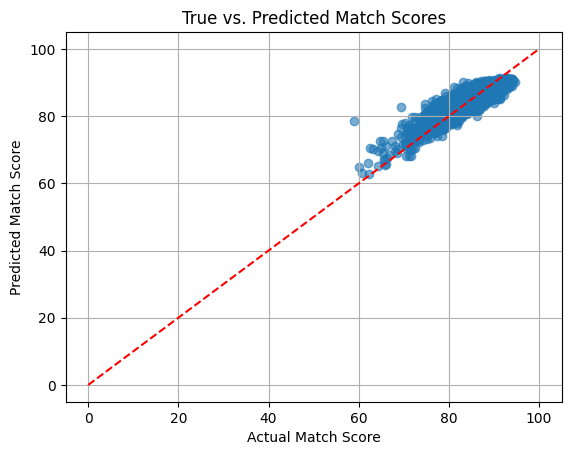

In [56]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Match Score")
plt.ylabel("Predicted Match Score")
plt.title("True vs. Predicted Match Scores")
plt.plot([0, 100], [0, 100], 'r--')
plt.grid(True)
plt.show()

In [57]:
import joblib
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

joblib.dump(regressor, 'models/kaggle_dataset_model.pkl')

['models/kaggle_dataset_model.pkl']